In [2]:
import pandas as pd
from common_utils.utils_Sep import *
pd.set_option('display.float_format', '{:.6f}'.format)
import matplotlib.pyplot as plt
import numpy as np


In [3]:
def get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = False):

    columns_used = ['sr_open_real', 'sr_open','sr_close_real', 'sr_close', 'real_earn', 'funding1_real', 'funding2_real', 'swap1_avg_price', 'swap1_deal_amount', 'swap2_avg_price', 'swap2_deal_amount']

    df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
    df_open = pd.read_csv(file_path_2,on_bad_lines="skip")

    if not df_open.empty:
        df_open = df_open[df_open['start'].astype(str).str.contains(r'\d{4}-\d{2}-\d{2}')]
        df_open['time'] = df_open['start'].apply(parse_start_time)

    if not df_close.empty:
        df_close = df_close[df_close['start'].astype(str).str.contains(r'\d{4}-\d{2}-\d{2}')]
        df_close['time'] = df_close['start'].apply(parse_start_time)


    # 把columns_used都转化为float（前提是得在这个dataframe的column里面）
    for c in columns_used:
        if c in df_open.columns:
            df_open[c] = pd.to_numeric(df_open[c], errors='coerce')
    for c in columns_used:
        if c in df_close.columns:
            df_close[c] = pd.to_numeric(df_close[c], errors='coerce')

    df_open['sign'] = (
        df_open['swap1_side']
        .map({'buy': 1, 'sell': -1})
        .fillna(0)
        .astype('int8')
    )

    df_open['slippage'] = (df_open['sr_open_real'] - df_open['sr_open'])*df_open['sign']




    df_close['sign'] = (
        df_close['swap1_side']
        .map({'closeShort': 1, 'closeLong': -1})
        .fillna(0)
        .astype('int8')
    )

    df_close['slippage'] = (df_close['sr_close_real'] - df_close['sr_close'])*df_close['sign']




    df_open['swap1_done_time'] = pd.to_datetime(
        df_open['swap1_done_time'].str.replace(r'\s\+\d{4}\s\w+$', '', regex=True),
        format='mixed',
        errors='coerce'
    )

    df_open['swap2_done_time'] = pd.to_datetime(
        df_open['swap2_done_time'].str.replace(r'\s\+\d{4}\s\w+$', '', regex=True),
        format='mixed',
        errors='coerce'
    )


    df_close['swap1_done_time'] = pd.to_datetime(
        df_close['swap1_done_time'].str.replace(r'\s\+\d{4}\s\w+$', '', regex=True),
        format='mixed',
        errors='coerce'
    )

    df_close['swap2_done_time'] = pd.to_datetime(
        df_close['swap2_done_time'].str.replace(r'\s\+\d{4}\s\w+$', '', regex=True),
        format='mixed',
        errors='coerce'
    )
    
    df_open['done_time_diff'] = (df_open['swap1_done_time']-df_open['swap2_done_time']).dt.total_seconds()
    df_close['done_time_diff'] = (df_close['swap1_done_time']-df_close['swap2_done_time']).dt.total_seconds()

    df_open_selected = df_open[(df_open['time'] >= start_date) & (df_open['time'] <= end_date)]
    df_close_selected = df_close[(df_close['time'] >= start_date) & (df_close['time'] <= end_date)]

    slippage_df = pd.concat([df_open, df_close])[['time', 'slippage']]
    slippage_df_selected = pd.concat([df_open_selected, df_close_selected])[['time', 'slippage']]

    long_slippage1 = df_open_selected[df_open['sign']==-1]
    short_slippage1 = df_open_selected[df_open['sign']==1]

    long_slippage2 = df_close_selected[df_close['sign']==-1]
    short_slippage2 = df_close_selected[df_close['sign']==1]

    long_slippage = pd.concat([long_slippage1, long_slippage2])
    short_slippage = pd.concat([short_slippage1, short_slippage2])


    if ifAnalyzeExchangeFirst:
        Exchange1FirstSlippage = pd.concat([df_open_selected[df_open['swap1_done_time']<df_open['swap2_done_time']], df_close_selected[df_close['swap1_done_time']<df_close['swap2_done_time']]])
        Exchange2FirstSlippage = pd.concat([df_open_selected[df_open['swap1_done_time']>df_open['swap2_done_time']], df_close_selected[df_close['swap1_done_time']>df_close['swap2_done_time']]])

        return slippage_df_selected,short_slippage,long_slippage,df_open_selected, df_close_selected, Exchange1FirstSlippage, Exchange2FirstSlippage


    return slippage_df_selected,short_slippage,long_slippage,df_open_selected, df_close_selected

In [ ]:
file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.close.csv'
file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.open.csv'

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_1487/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_1487/1325737168.py:6: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_1487/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_1487/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_1487/1325737168.py:86: User

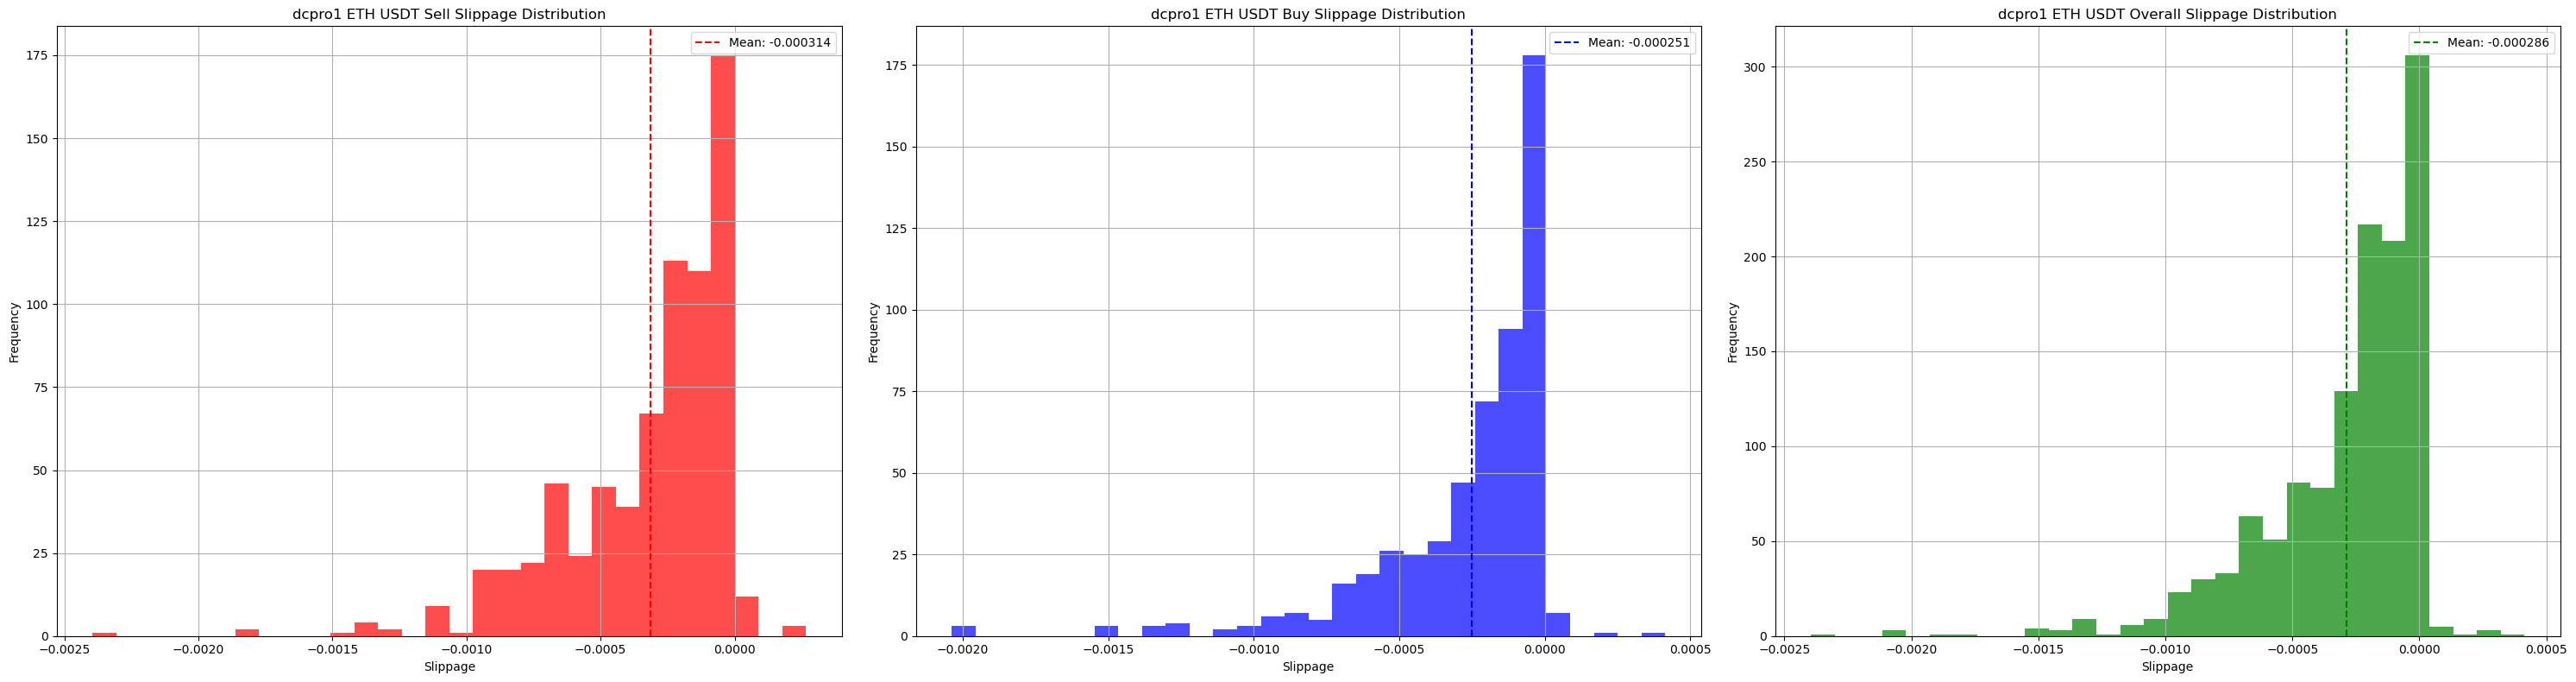

symbol  count      mean    median      std       min      max  \
env                                                                    
dcpro1    ETH   1267 -0.000286 -0.000192 0.000316 -0.002395 0.000414   

        percentile_5  percentile_10  percentile_50  percentile_60  \
env                                                                 
dcpro1     -0.000883      -0.000707      -0.000192      -0.000142   

        percentile_75  percentile_95  long_slippage_mean  short_slippage_mean  \
env                                                                             
dcpro1      -0.000055       0.000000           -0.000251            -0.000314   

        long_slippage_count  short_slippage_count  
env                                                
dcpro1                  551                   716

In [21]:
symbol = 'ETH'
env_list = ['dcpro1']

start_date = '2026-02-17 06:40:00'
end_date = '2026-02-19 23:15:00'

summary = []

for env in env_list:
    file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_{env}/{symbol}_USDT.close.csv'
    file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_{env}/{symbol}_USDT.open.csv'
    slippage_df_selected, short_slippage, long_slippage, df_open, df_close = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time)


    # 创建子图
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

    # 分析卖出滑点
    sell_slippage = short_slippage['slippage']
    sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
    ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
    ax1.set_xlabel('Slippage')
    ax1.set_ylabel('Frequency')
    sell_mean = sell_slippage.mean()
    sell_std = sell_slippage.std()
    ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
    ax1.legend()


    # 分析买入滑点
    buy_slippage = long_slippage['slippage']
    buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
    ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
    ax2.set_xlabel('Slippage')
    ax2.set_ylabel('Frequency')
    buy_mean = buy_slippage.mean()
    buy_std = buy_slippage.std()
    ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
    ax2.legend()


    # overall滑点分布
    slippage_array = slippage_df_selected['slippage'].values
    slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
    ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
    ax3.set_xlabel('Slippage')
    ax3.set_ylabel('Frequency')
    overall_mean = slippage_array.mean()
    ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    stats = {
        'symbol': symbol,
        'env': env,
        'count': len(slippage_array),
        'mean': np.mean(slippage_array),
        'median': np.median(slippage_array),
        'std': np.std(slippage_array),
        'min': np.min(slippage_array),
        'max': np.max(slippage_array),
        'percentile_5': np.percentile(slippage_array, 5),
        'percentile_10': np.percentile(slippage_array, 10),
        'percentile_50': np.percentile(slippage_array, 50),      
        'percentile_60': np.percentile(slippage_array, 60),
        'percentile_75': np.percentile(slippage_array, 75),
        'percentile_95': np.percentile(slippage_array, 95),
        'long_slippage_mean': long_slippage['slippage'].mean(),
        'short_slippage_mean': short_slippage['slippage'].mean(),
        'long_slippage_count': len(long_slippage),
        'short_slippage_count': len(short_slippage)
    }

    summary.append(stats)

df = pd.DataFrame(summary).set_index('env')
df

In [26]:
df_open[(df_open['done_time_diff']<=5)&(df_open['done_time_diff']>=-5)]

pos_id  \
85056  260217_175949_312860   
85057  260217_175949_312861   
85058  260217_175949_312862   
85059  260217_180027_312864   
85060  260217_180027_312865   
...                     ...   
85747  260219_035912_314652   
85748  260219_035914_314654   
85749  260219_045015_314668   
85753  260219_054001_314698   
85759  260219_054057_314703   

                                                   start  sr_open  \
85056  2026-02-17 17:59:49.409015817 +0800 CST m=+434... 0.000111   
85057  2026-02-17 17:59:49.409063766 +0800 CST m=+434... 0.000111   
85058  2026-02-17 17:59:49.409120385 +0800 CST m=+434... 0.000111   
85059  2026-02-17 18:00:27.069673026 +0800 CST m=+434... 0.000127   
85060  2026-02-17 18:00:27.069784023 +0800 CST m=+434... 0.000127   
...                                                  ...      ...   
85747  2026-02-19 03:59:12.092575418 +0800 CST m=+556... 0.000248   
85748  2026-02-19 03:59:14.201822767 +0800 CST m=+556... 0.000155   
85749  2026-02-19 04:50:15.879702886 +0800 CST m=+559... 0.000144   
85753  2026-02-19 05:40:01.584512759 +0800 CST m=+562... 0.000113   
85759  2026-02-19 05:40:57.381986623 +0800 CST m=+562... 0.000108   

       open_trade_unit   open_usdt  sr_open_real             swap1_order_id  \
85056         1.013000 2000.411620      0.000111 8389766104322720768.000000   
85057         1.013000 2000.411620      0.000111 8389766104322720768.000000   
85058         1.013000 2000.411620      0.000111 8389766104322720768.000000   
85059         1.013000 2000.229280      0.000015 8389766104323145728.000000   
85060         1.013000 2000.229280      0.000015 8389766104323145728.000000   
...                ...         ...           ...                        ...   
85747         1.032000 1999.314240     -0.001541 8389766105752947712.000000   
85748         1.031000 1999.933800     -0.000515 8389766105752955904.000000   
85749         1.026000 1999.581660      0.000411 8389766105791642624.000000   
85753         1.028000 1999.233840     -0.000149 8389766105823084544.000000   
85759         1.029000 2000.499480      0.000108 8389766105823577088.000000   

       swap1_avg_price  swap1_deal_amount swap1_side  ...     deposit  \
85056      1974.740000           1.013000        buy  ... 2000.523050   
85057      1974.740000           1.013000        buy  ... 2000.523050   
85058      1974.740000           1.013000        buy  ... 2000.523050   
85059      1974.780000           1.013000        buy  ... 2000.467335   
85060      1974.780000           1.013000        buy  ... 2000.467335   
...                ...                ...        ...  ...         ...   
85747      1940.790000           1.032000        buy  ... 2001.352440   
85748      1941.100000           1.031000        buy  ... 2000.758600   
85749      1948.400000           1.026000        buy  ... 1999.468800   
85753      1944.780000           1.028000        buy  ... 1999.084780   
85759      1944.120000           1.029000        buy  ... 2000.607525   

      deposit_real open_exposure          mode  \
85056  2000.523050     -0.222860  Swap1MSwap2M   
85057  2000.523050     -0.222860  Swap1MSwap2M   
85058  2000.523050     -0.222860  Swap1MSwap2M   
85059  2000.467335     -0.030390  Swap1MSwap2M   
85060  2000.467335     -0.030390  Swap1MSwap2M   
...            ...           ...           ...   
85747  2001.352440      3.085680  Swap1MSwap2M   
85748  2000.758600      1.031000  Swap1MSwap2M   
85749  1999.468800     -0.820800  Swap1MSwap2M   
85753  1999.084780      0.298120  Swap1MSwap2M   
85759  2000.607525     -0.216090  Swap1MSwap2M   

                                              maker_info  \
85056  {"first_filled":"swap2","first_sr":"0.00011140...   
85057  {"first_filled":"swap2","first_sr":"0.00011140...   
85058  {"first_filled":"swap2","first_sr":"0.00011140...   
85059  {"first_filled":"swap2","first_sr":"0","first_...   
85060  {"first_filled":"swap2","first_sr":"0.00009622...   
...                             

In [22]:
df_open['done_time_diff'].describe()

count   716.000000
mean      0.508978
std      13.538145
min     -73.916000
25%      -5.030250
50%       0.566500
75%       5.799000
max      61.299000
Name: done_time_diff, dtype: float64

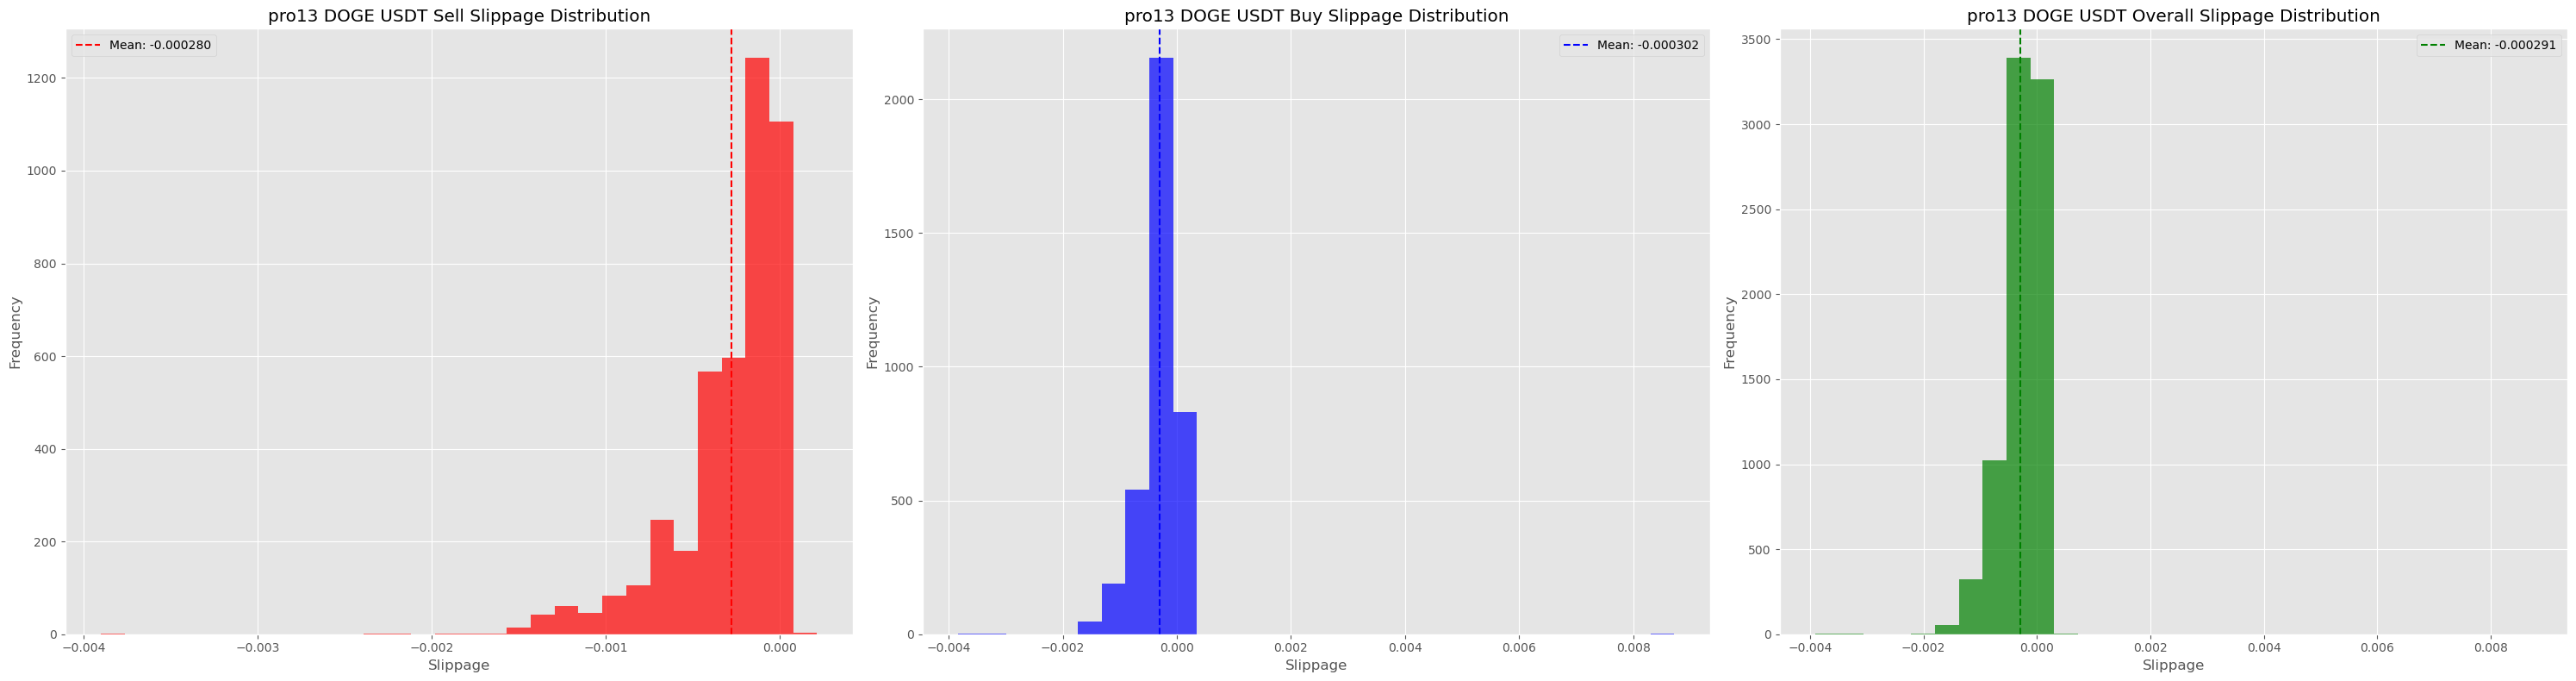

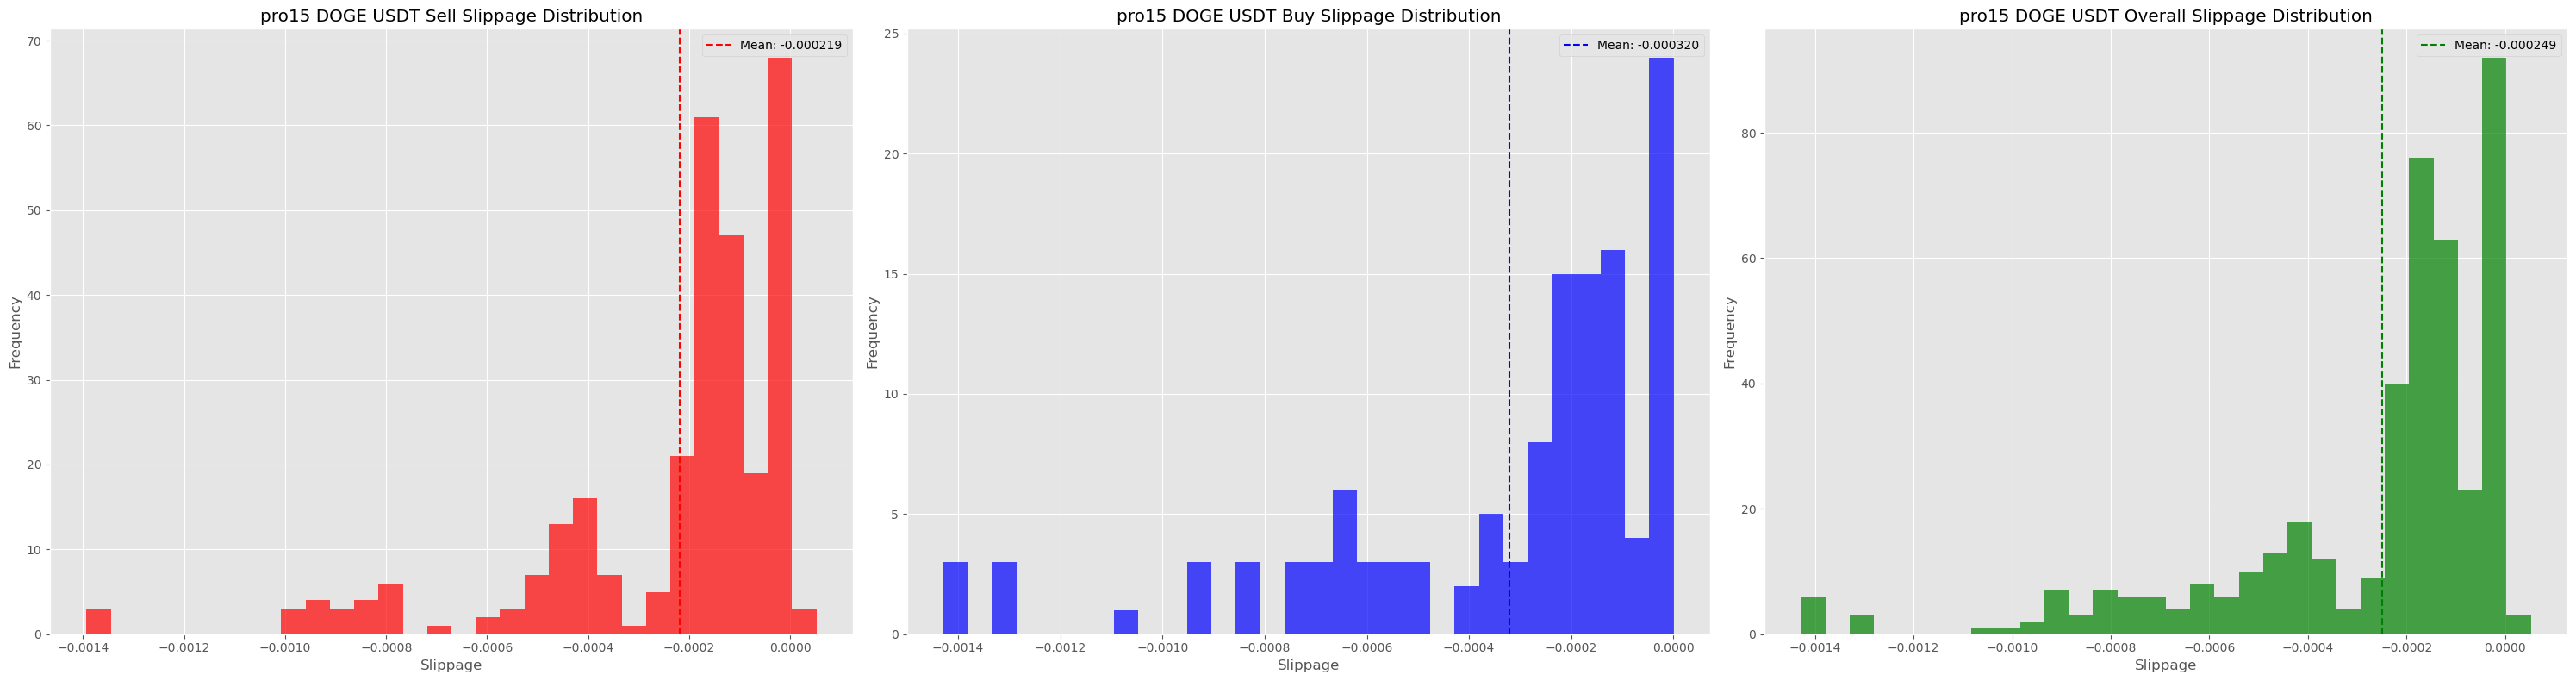

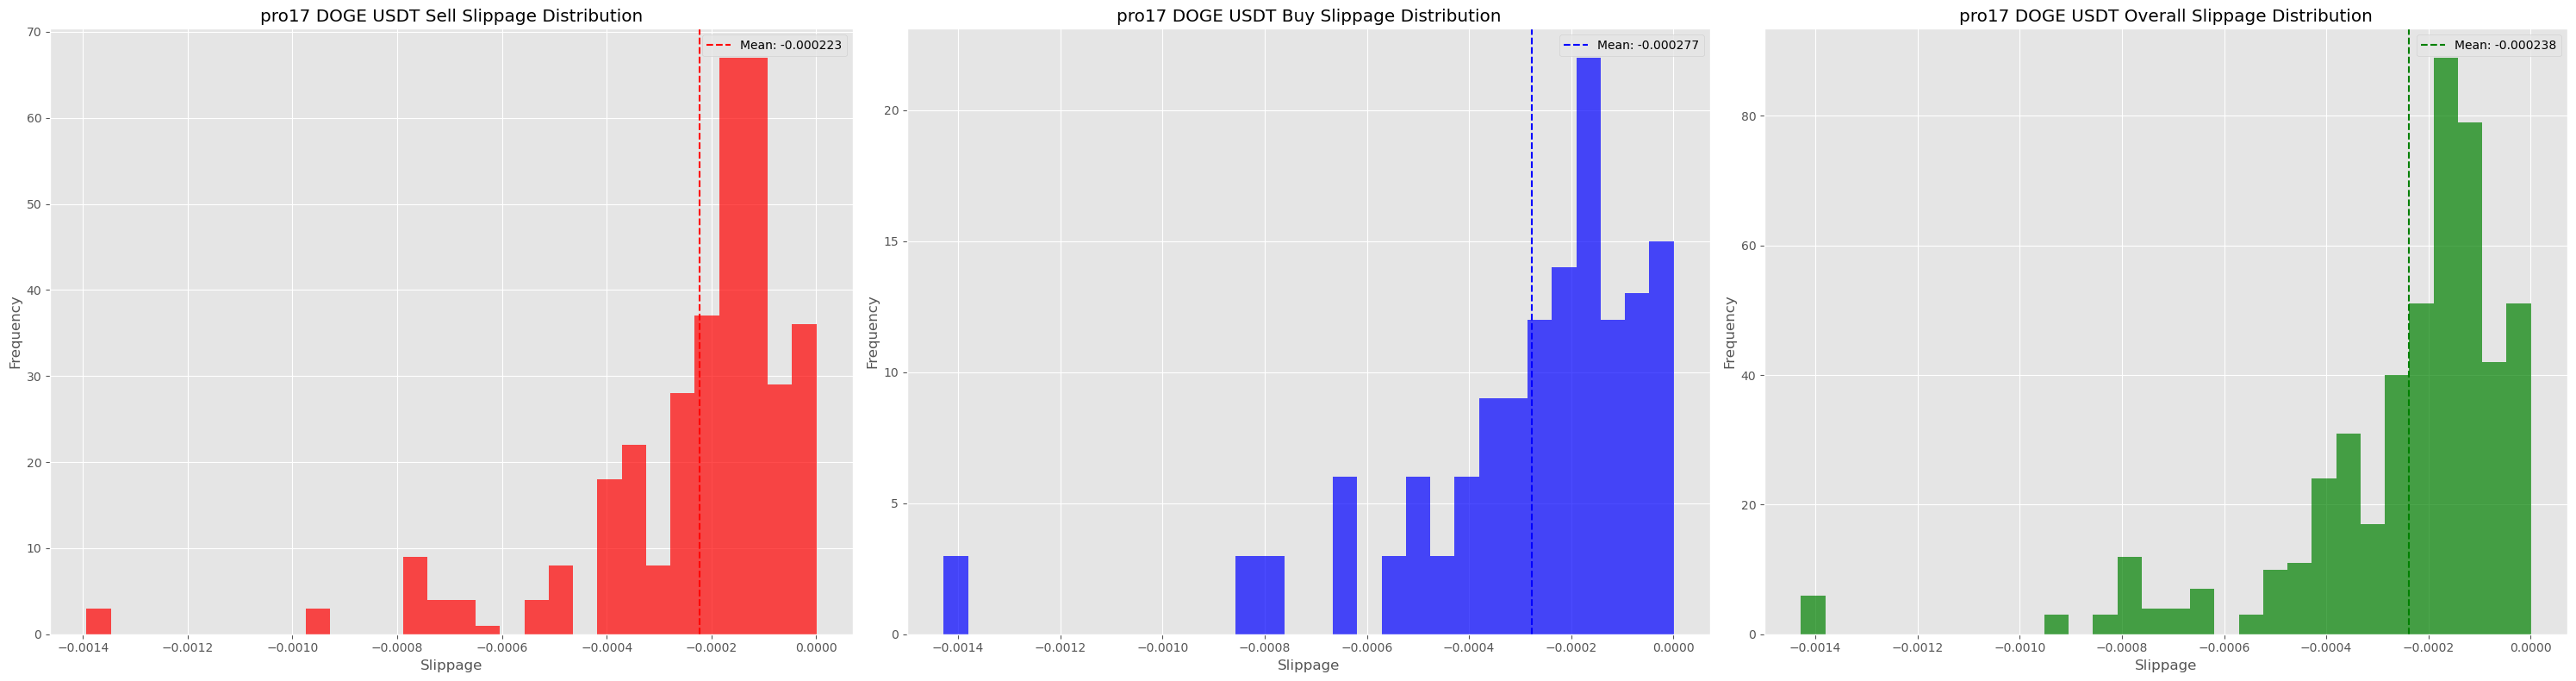

symbol              replace  count      mean    median      std  \
env                                                                     
pro13   DOGE   msecs3000 replace5   8070 -0.000291 -0.000157 0.000336   
pro15   DOGE  msecs30000 replace5    423 -0.000249 -0.000155 0.000295   
pro17   DOGE  msecs30000 replace1    487 -0.000238 -0.000155 0.000233   

            min      max  percentile_1  percentile_5  percentile_10  \
env                                                                   
pro13 -0.003902 0.008718     -0.001344     -0.000938      -0.000722   
pro15 -0.001428 0.000052     -0.001393     -0.000880      -0.000670   
pro17 -0.001428 0.000000     -0.001393     -0.000734      -0.000511   

       percentile_25  percentile_50  percentile_55  percentile_60  \
env                                                                 
pro13      -0.000413      -0.000157      -0.000155      -0.000112   
pro15      -0.000362      -0.000155      -0.000153      -0.000104   
pro17      -0.000311      -0.000155      -0.000155      -0.000154   

       percentile_65  percentile_75  percentile_95  percentile_99  
env                                                                
pro13      -0.000104      -0.000100       0.000000       0.000000  
pro15      -0.000103      -0.000051       0.000000       0.000000  
pro17      -0.000104      -0.000103       0.000000       0.000000

In [5]:
import pandas as pd


symbol = 'DOGE'
env_list = ['pro13', 'pro15', 'pro17']
replace_dict = {'pro13': 'msecs3000 replace5', 'pro15': 'msecs30000 replace5', 'pro17': 'msecs30000 replace1'}

start_date = '2025-10-28 01:18:00'
end_date = '2025-10-31 06:15:00'

summary = []

for env in env_list:
    file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.close.csv'
    file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.open.csv'
    slippage_df_selected, short_slippage, long_slippage, _,_ = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time)


    # 创建子图
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

    # 分析卖出滑点
    sell_slippage = short_slippage['slippage']
    sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
    ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
    ax1.set_xlabel('Slippage')
    ax1.set_ylabel('Frequency')
    sell_mean = sell_slippage.mean()
    sell_std = sell_slippage.std()
    ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
    ax1.legend()


    # 分析买入滑点
    buy_slippage = long_slippage['slippage']
    buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
    ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
    ax2.set_xlabel('Slippage')
    ax2.set_ylabel('Frequency')
    buy_mean = buy_slippage.mean()
    buy_std = buy_slippage.std()
    ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
    ax2.legend()


    # overall滑点分布
    slippage_array = slippage_df_selected['slippage'].values
    slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
    ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
    ax3.set_xlabel('Slippage')
    ax3.set_ylabel('Frequency')
    overall_mean = slippage_array.mean()
    ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    stats = {
        'symbol': symbol,
        'env': env,
        'replace': replace_dict[env],
        'count': len(slippage_array),
        'mean': np.mean(slippage_array),
        'median': np.median(slippage_array),
        'std': np.std(slippage_array),
        'min': np.min(slippage_array),
        'max': np.max(slippage_array),
        'percentile_1': np.percentile(slippage_array, 1),
        'percentile_5': np.percentile(slippage_array, 5),
        'percentile_10': np.percentile(slippage_array, 10),
        'percentile_25': np.percentile(slippage_array, 25),
        'percentile_50': np.percentile(slippage_array, 50),
        'percentile_55': np.percentile(slippage_array, 55),        
        'percentile_60': np.percentile(slippage_array, 60),
        'percentile_65': np.percentile(slippage_array, 65),
        'percentile_75': np.percentile(slippage_array, 75),
        'percentile_95': np.percentile(slippage_array, 95),
        'percentile_99': np.percentile(slippage_array, 99)
    }

    summary.append(stats)

df = pd.DataFrame(summary).set_index('env')
df

In [ ]:
slippage_df_selected

time  slippage
4414 2025-10-28 01:20:22.192607074 -0.000244
4415 2025-10-28 01:20:22.190512450 -0.000244
4416 2025-10-28 01:20:22.192639789 -0.000244
4417 2025-10-28 01:20:31.307812727 -0.000635
4418 2025-10-28 01:20:31.307978325 -0.000635
...                            ...       ...
4131 2025-10-29 22:59:00.831614311 -0.000259
4132 2025-10-29 22:59:00.654601894 -0.000259
4133 2025-10-29 23:14:39.786220252 -0.000155
4134 2025-10-29 23:14:39.805622037 -0.000155
4135 2025-10-29 23:14:39.795132397 -0.000155

[487 rows x 2 columns]

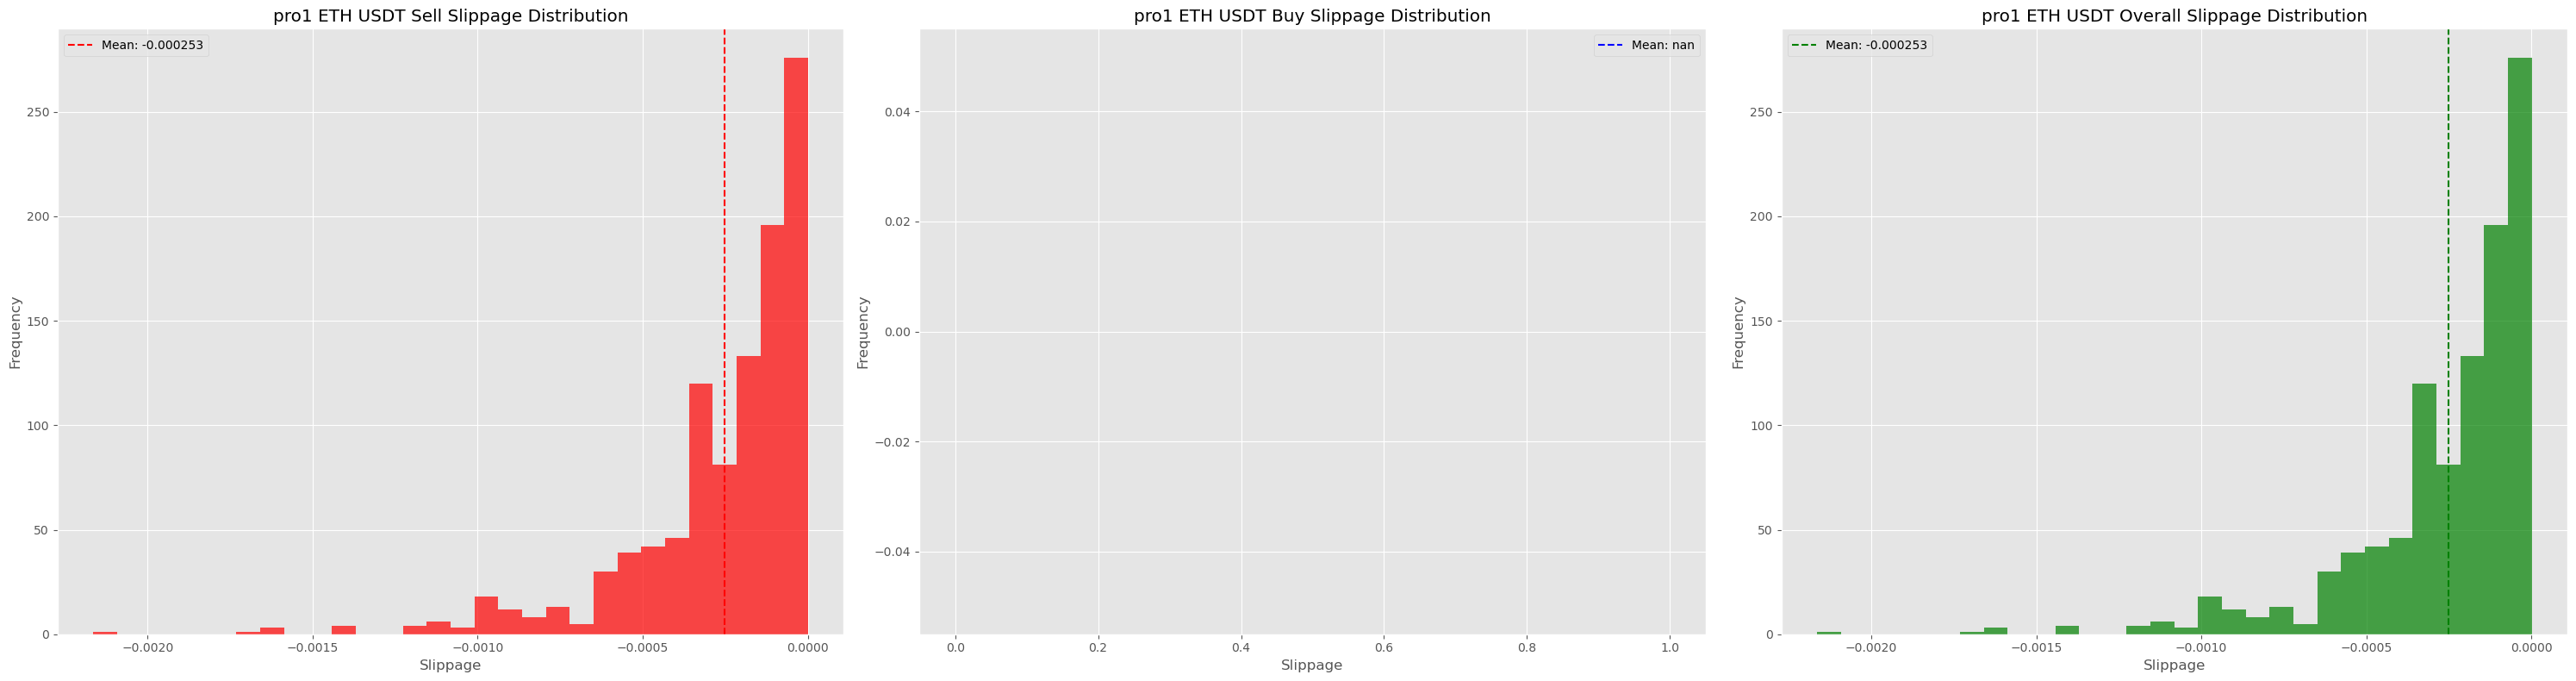

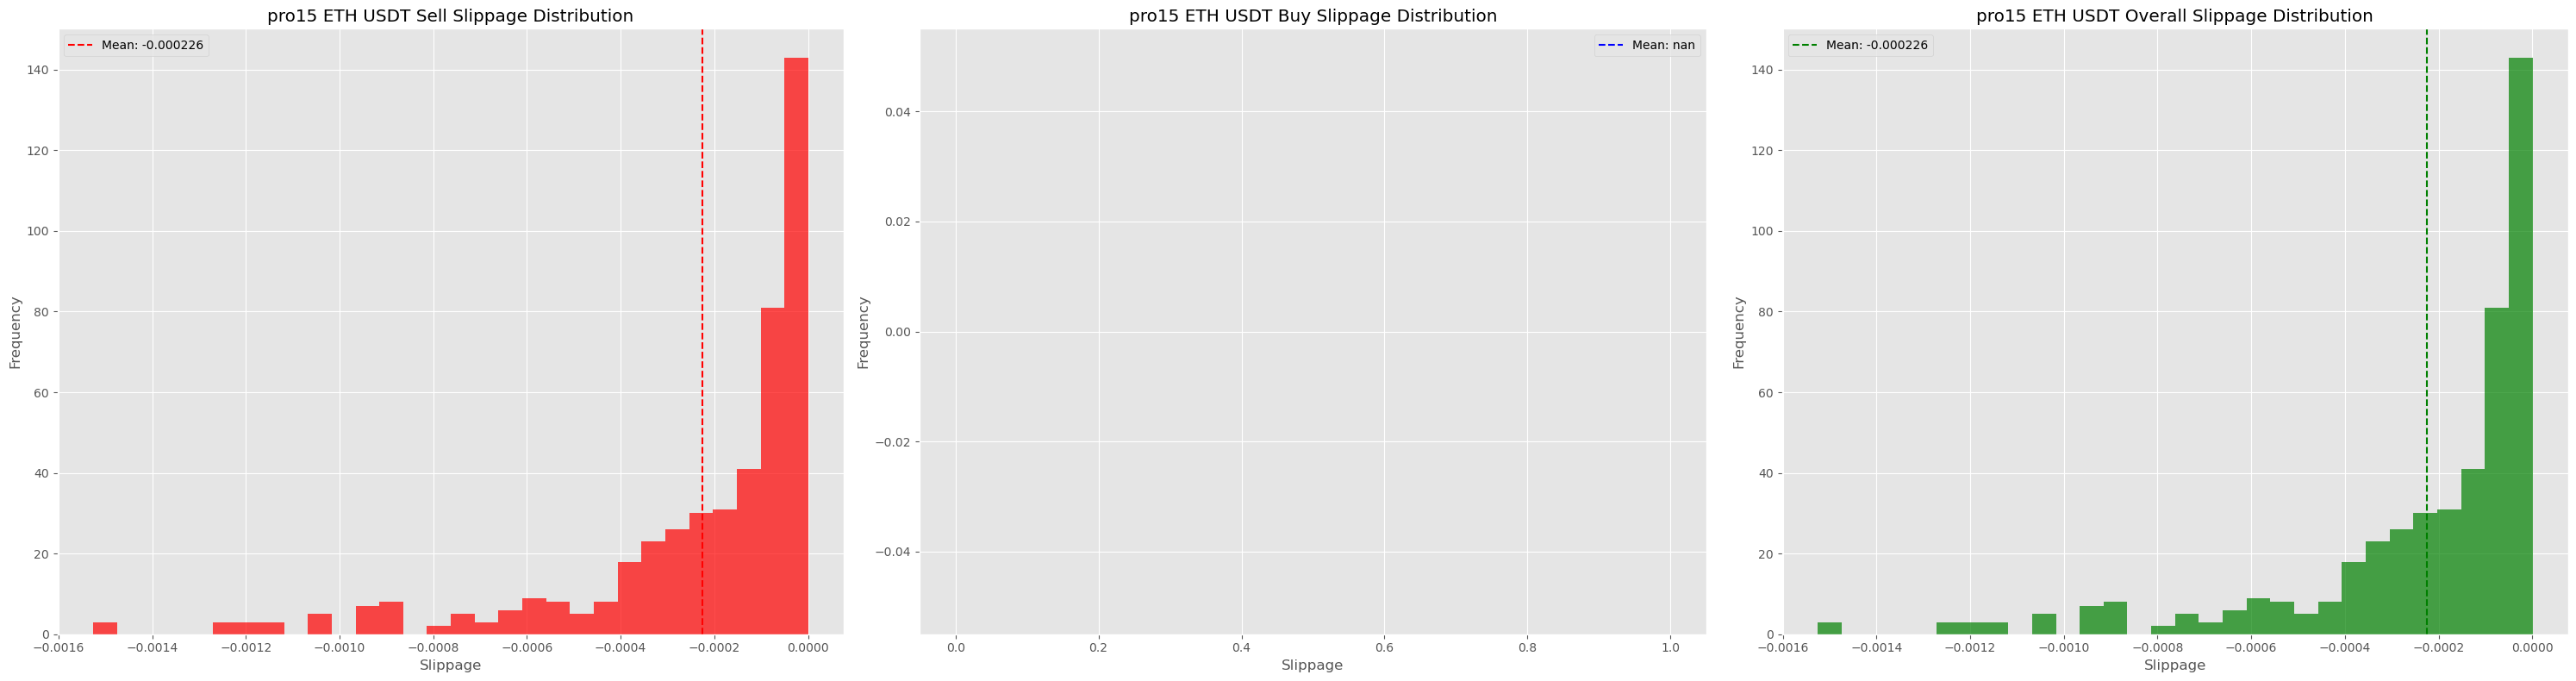

symbol                      replace  count      mean    median      std  \
env                                                                             
pro1     ETH    msecs500 replace80 normal   1041 -0.000253 -0.000165 0.000275   
pro15    ETH  msecs30000 replace80 normal    471 -0.000226 -0.000112 0.000294   

            min      max  percentile_1  percentile_5  percentile_10  \
env                                                                   
pro1  -0.002164 0.000000     -0.001174     -0.000822      -0.000578   
pro15 -0.001526 0.000000     -0.001256     -0.000914      -0.000658   

       percentile_25  percentile_50  percentile_55  percentile_60  \
env                                                                 
pro1       -0.000345      -0.000165      -0.000143      -0.000116   
pro15      -0.000305      -0.000112      -0.000087      -0.000081   

       percentile_65  percentile_75  percentile_95  percentile_99  
env                                                                
pro1       -0.000097      -0.000066       0.000000       0.000000  
pro15      -0.000073      -0.000000       0.000000       0.000000

In [ ]:
import pandas as pd


symbol = 'ETH'
env_list = ['pro1', 'pro15']
replace_dict = {'pro1': 'msecs500 replace80 normal', 'pro13': 'msecs3000 replace80', 'pro15': 'msecs30000 replace80 normal', 'pro16': 'msecs30000 replace1 median'}

start_date = '2025-10-28 01:18:00'
end_date = '2025-10-31 15:30:00'


summary = []

for env in env_list:
    file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.close.csv'
    file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.open.csv'
    slippage_df_selected, short_slippage, long_slippage, _,_ = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time)


    # 创建子图
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

    # 分析卖出滑点
    sell_slippage = short_slippage['slippage']
    sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
    ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
    ax1.set_xlabel('Slippage')
    ax1.set_ylabel('Frequency')
    sell_mean = sell_slippage.mean()
    sell_std = sell_slippage.std()
    ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
    ax1.legend()


    # 分析买入滑点
    buy_slippage = long_slippage['slippage']
    buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
    ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
    ax2.set_xlabel('Slippage')
    ax2.set_ylabel('Frequency')
    buy_mean = buy_slippage.mean()
    buy_std = buy_slippage.std()
    ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
    ax2.legend()


    # overall滑点分布
    slippage_array = slippage_df_selected['slippage'].values
    slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
    ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
    ax3.set_xlabel('Slippage')
    ax3.set_ylabel('Frequency')
    overall_mean = slippage_array.mean()
    ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    stats = {
        'symbol': symbol,
        'env': env,
        'replace': replace_dict[env],
        'count': len(slippage_array),
        'mean': np.mean(slippage_array),
        'median': np.median(slippage_array),
        'std': np.std(slippage_array),
        'min': np.min(slippage_array),
        'max': np.max(slippage_array),
        'percentile_1': np.percentile(slippage_array, 1),
        'percentile_5': np.percentile(slippage_array, 5),
        'percentile_10': np.percentile(slippage_array, 10),
        'percentile_25': np.percentile(slippage_array, 25),
        'percentile_50': np.percentile(slippage_array, 50),
        'percentile_55': np.percentile(slippage_array, 55),        
        'percentile_60': np.percentile(slippage_array, 60),
        'percentile_65': np.percentile(slippage_array, 65),
        'percentile_75': np.percentile(slippage_array, 75),
        'percentile_95': np.percentile(slippage_array, 95),
        'percentile_99': np.percentile(slippage_array, 99)
    }

    summary.append(stats)

df = pd.DataFrame(summary).set_index('env')
df

In [ ]:
file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.close.csv'
file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.open.csv'
slippage_df_selected, short_slippage, long_slippage, df_open, df_close = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time)

In [ ]:
(df_open['swap1_done_time']-df_open['swap2_done_time']).dt.total_seconds().abs() * 1000


0      29.000000
1      29.000000
2      37.000000
3      50.000000
4      27.000000
          ...   
5759   31.000000
5760   31.000000
5761   33.000000
5762   33.000000
5763   43.000000
Length: 5764, dtype: float64

In [ ]:
((df_open['swap1_done_time']-df_open['swap2_done_time']).dt.total_seconds().abs() * 1000).mean()

48.50277585010409

In [ ]:
# 给定一个dataframe，有两列，分别是swap1_done_time和swap2_done_time，计算swap1_done_time和swap2_done_time的差值（要求计算两个时间的差值 单位是毫秒（不需要引入1day），并计算差值的平均值
def get_taker_latency(df_open, df_close):
    taker_latency = (df_open['swap1_done_time']-df_open['swap2_done_time']).mean()
    return taker_latency

get_taker_latency(df_open, df_close)



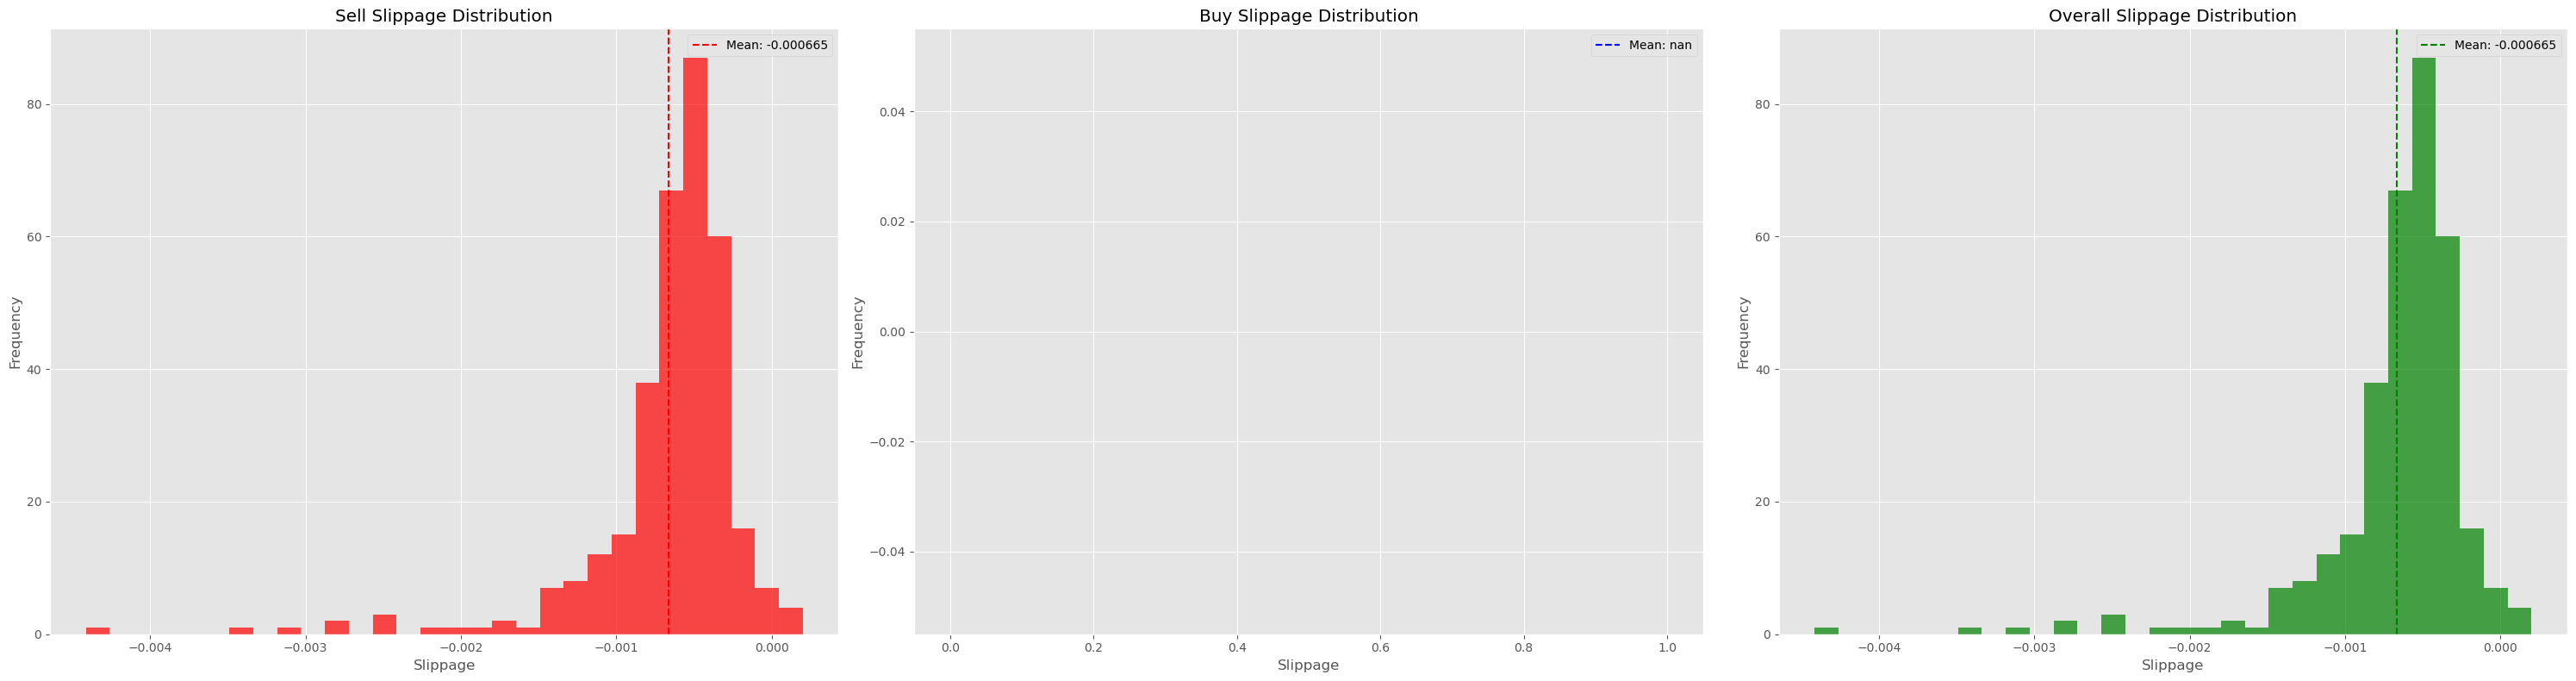

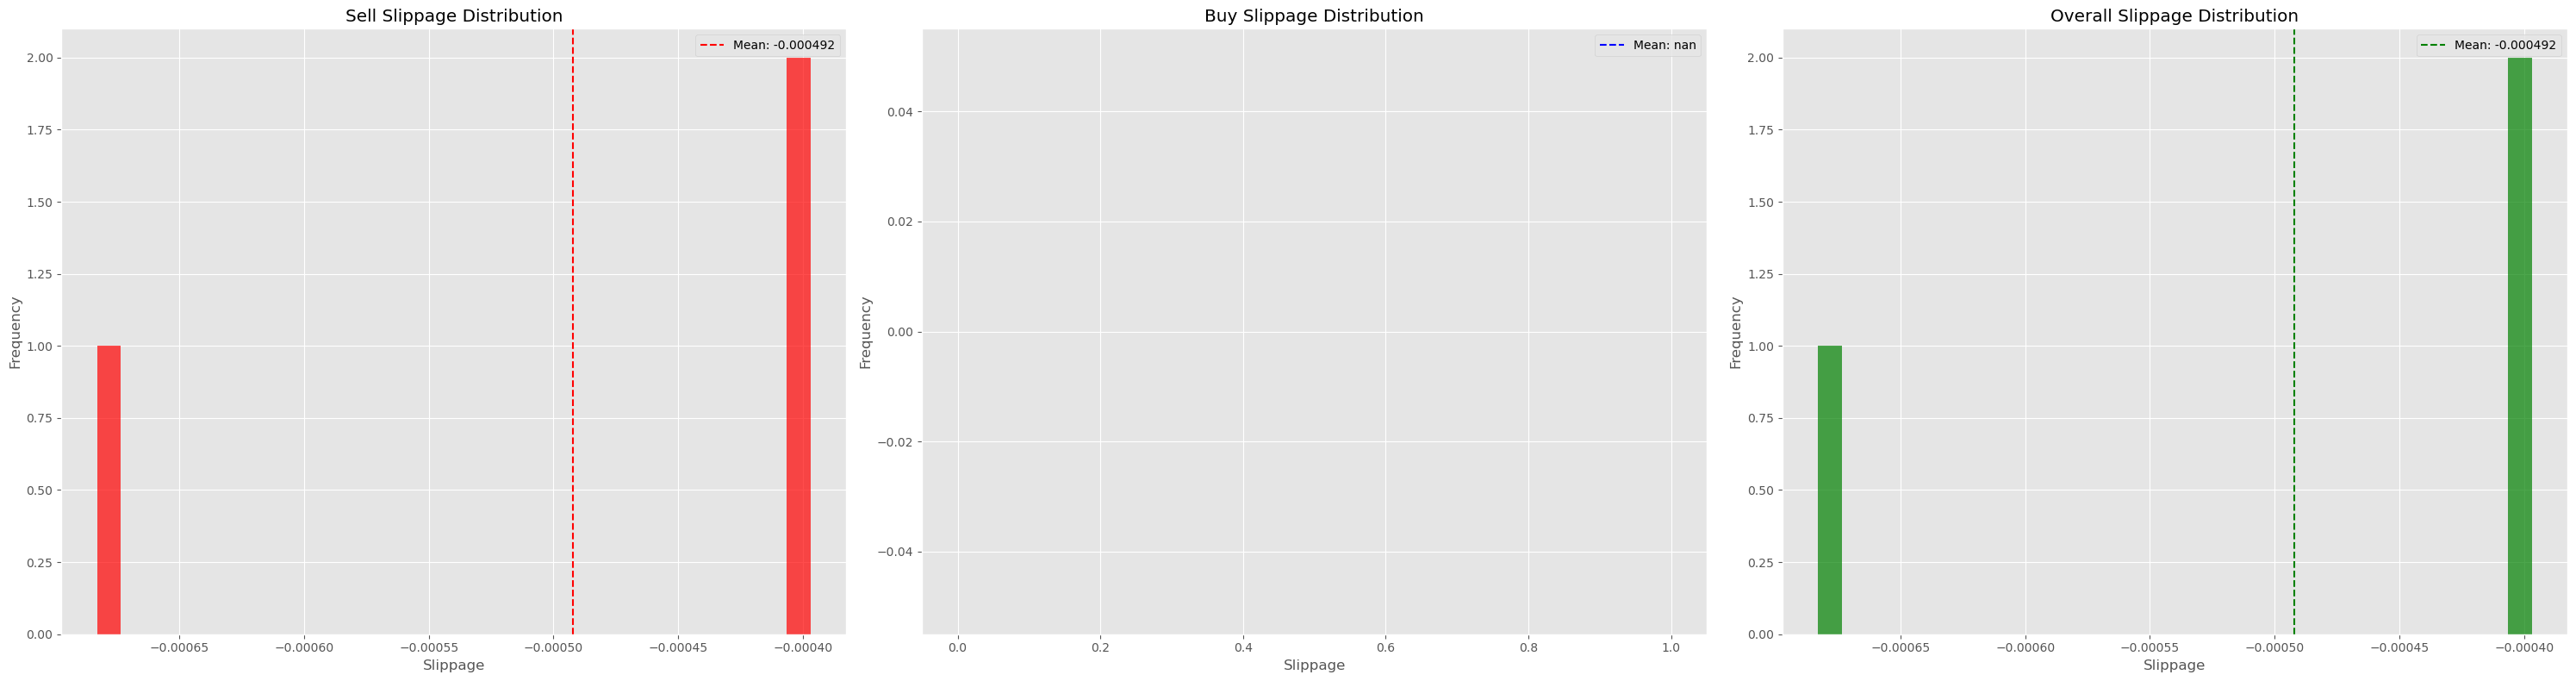

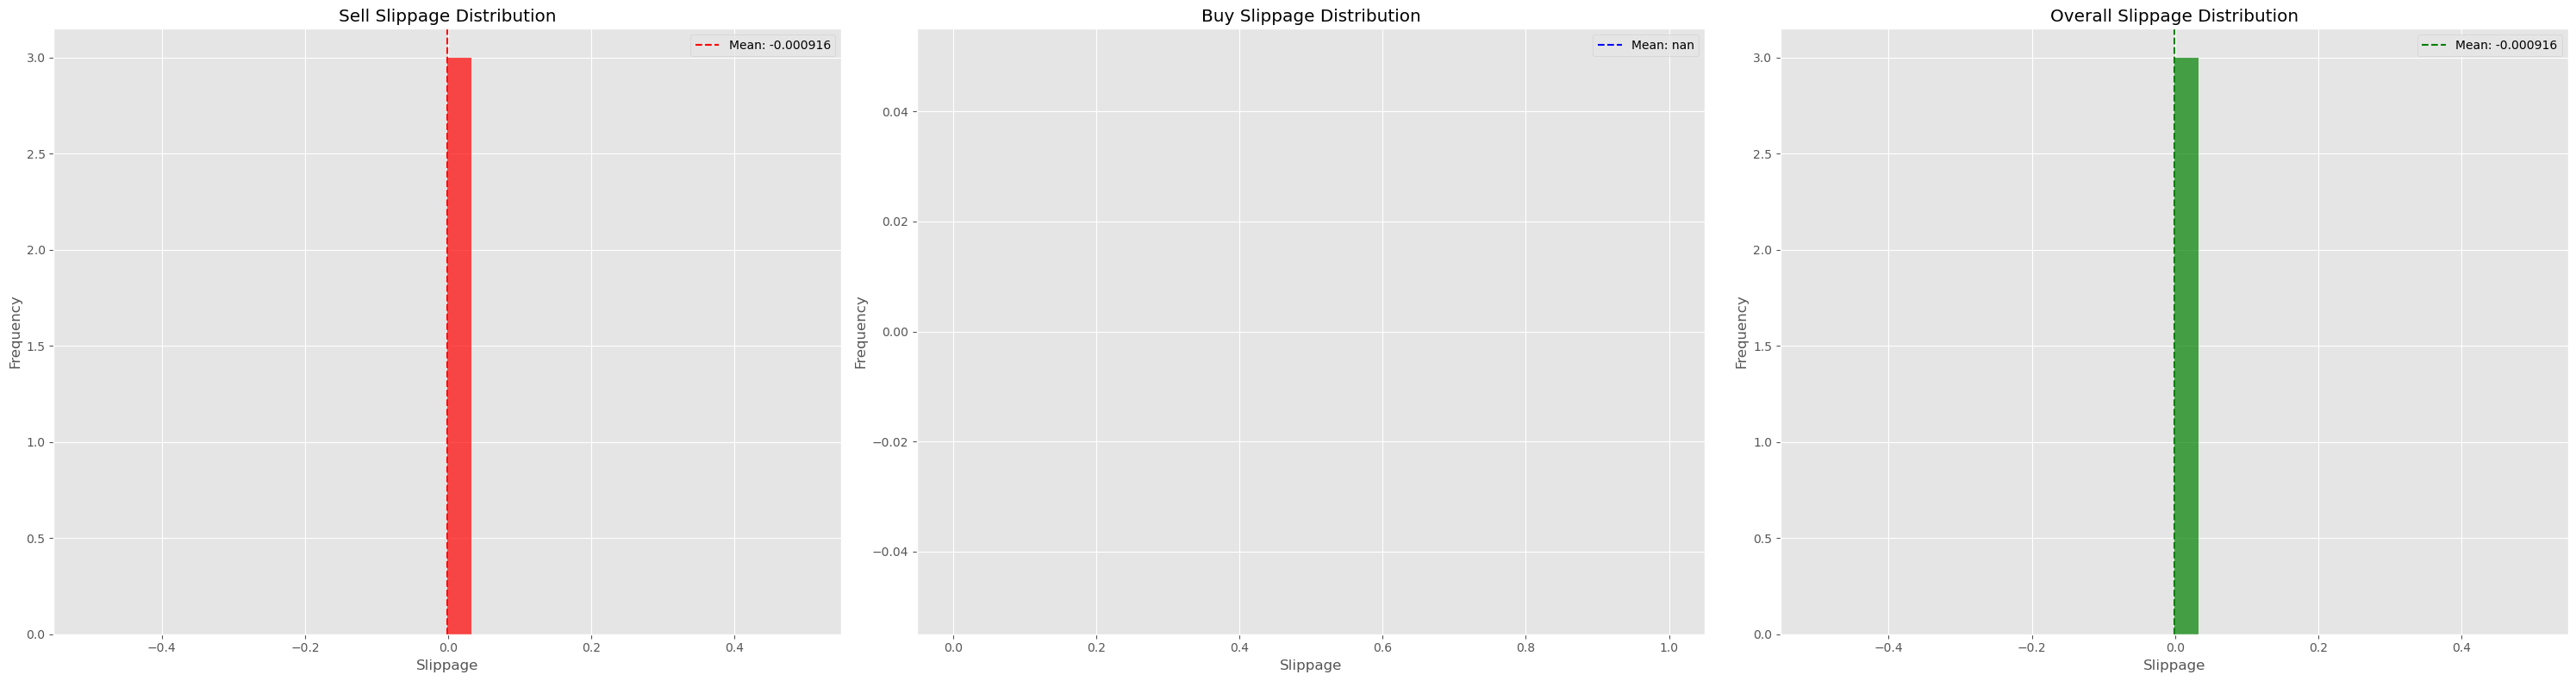

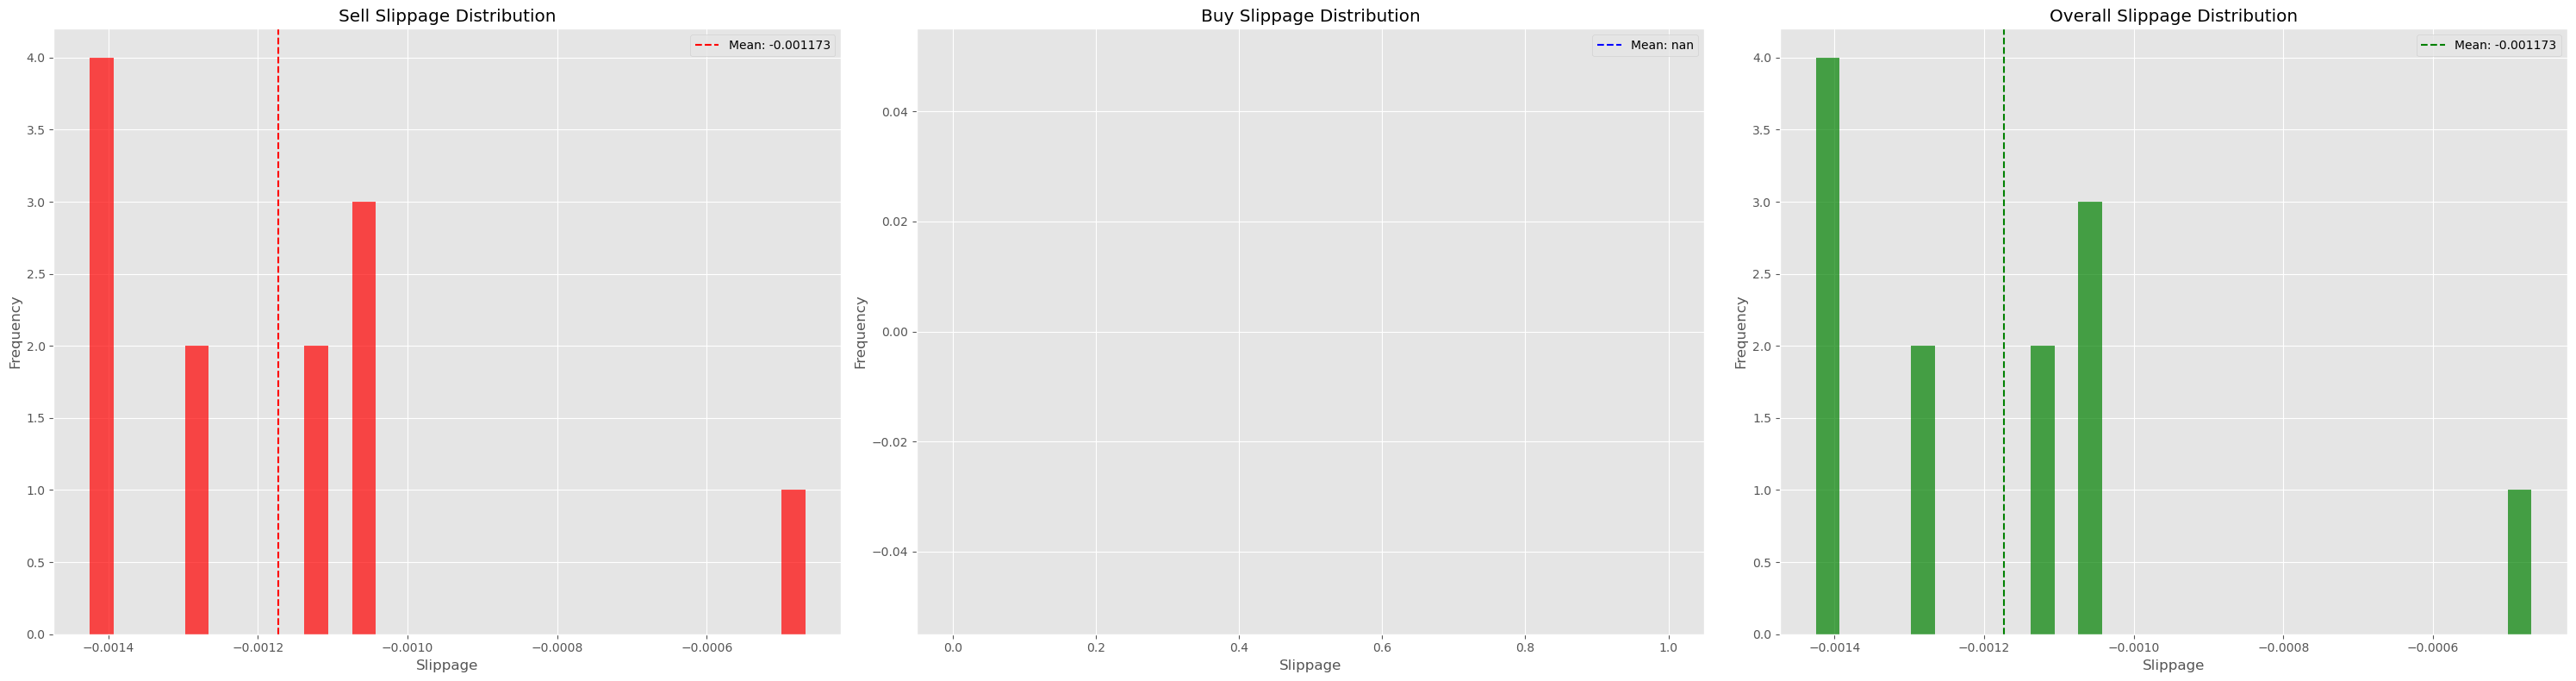

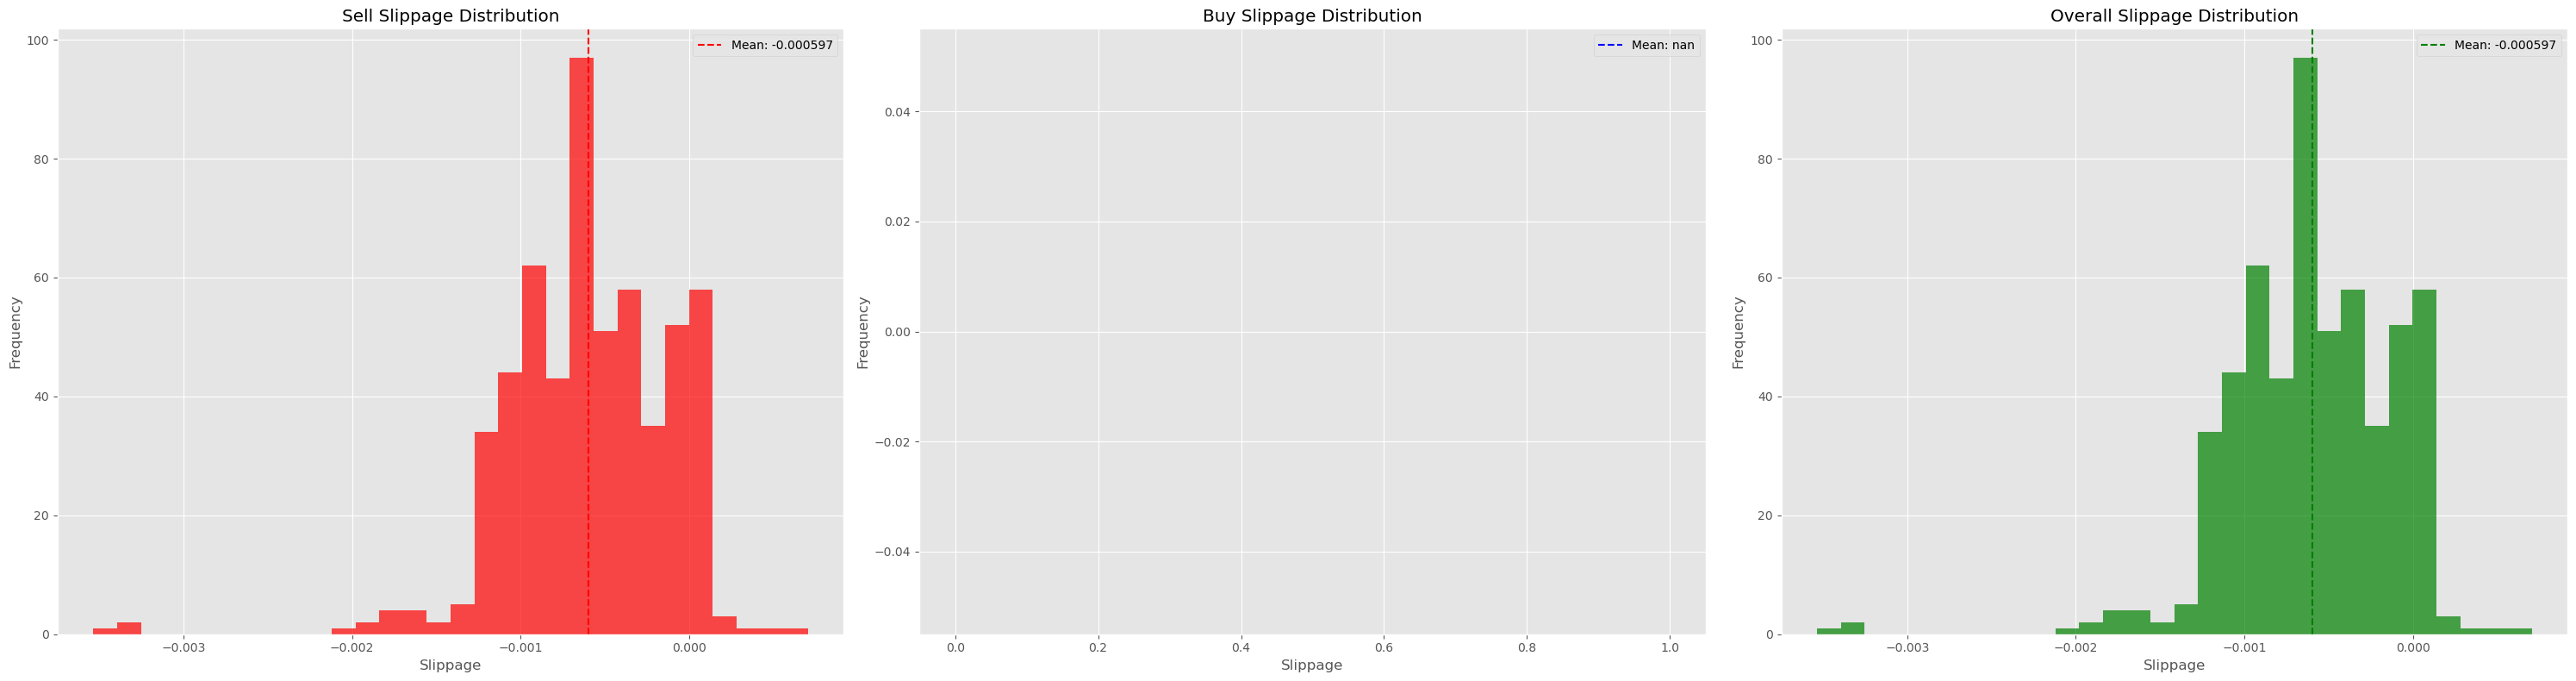

symbol  taker_latency(ms)  count      mean    median      std  \
env                                                                        
pro13  JELLYJELLY                 55    335 -0.000665 -0.000534 0.000500   
pro1   JELLYJELLY                 45      3 -0.000492 -0.000397 0.000135   
pro2   JELLYJELLY                 47      3 -0.000916 -0.000916 0.000000   
pro3   JELLYJELLY                 45     12 -0.001173 -0.001210 0.000257   
pro4   JELLYJELLY                 44    561 -0.000597 -0.000609 0.000466   

            min       max  percentile_1  percentile_5  percentile_10  \
env                                                                    
pro13 -0.004414  0.000200     -0.002802     -0.001457      -0.001079   
pro1  -0.000683 -0.000397     -0.000677     -0.000654      -0.000626   
pro2  -0.000916 -0.000916     -0.000916     -0.000916      -0.000916   
pro3  -0.001425 -0.000468     -0.001423     -0.001413      -0.001402   
pro4  -0.003535  0.000705     -0.001831     -0.001246      -0.001126   

       percentile_25  percentile_50  percentile_55  percentile_60  \
env                                                                 
pro13      -0.000779      -0.000534      -0.000522      -0.000501   
pro1       -0.000540      -0.000397      -0.000397      -0.000397   
pro2       -0.000916      -0.000916      -0.000916      -0.000916   
pro3       -0.001397      -0.001210      -0.001133      -0.001133   
pro4       -0.000873      -0.000609      -0.000531      -0.000468   

       percentile_65  percentile_75  percentile_95  percentile_99  
env                                                                
pro13      -0.000493      -0.000408      -0.000200       0.000035  
pro1       -0.000397      -0.000397      -0.000397      -0.000397  
pro2       -0.000916      -0.000916      -0.000916      -0.000916  
pro3       -0.001120      -0.001047      -0.000786      -0.000532  
pro4       -0.000375      -0.000248       0.000000       0.000182

In [ ]:
import pandas as pd


symbol = 'JELLYJELLY'
env_list = ['pro13', 'pro1', 'pro2','pro3','pro4']
# replace_dict = {'pro13': 'msecs3000 replace5', 'pro15': 'msecs30000 replace5', 'pro17': 'msecs30000 replace1'}

start_date = '2025-10-25 01:18:00'
end_date = '2025-10-31 06:15:00'

summary = []

for env in env_list:
    file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.close.csv'
    file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.open.csv'
    slippage_df_selected, short_slippage, long_slippage, df_open, df_close = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time)

    total_length = len(df_open)+len(df_close)
    df_open_latency = ((df_open['swap1_done_time']-df_open['swap2_done_time']).dt.total_seconds().abs() * 1000).mean()
    df_close_latency = ((df_close['swap1_done_time']-df_close['swap2_done_time']).dt.total_seconds().abs() * 1000).mean()
    taker_latency = int((len(df_open)*df_open_latency+len(df_close)*df_close_latency)/total_length)
    
    # 创建子图
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

    # 分析卖出滑点
    sell_slippage = short_slippage['slippage']
    sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
    ax1.set_title('Sell Slippage Distribution')
    ax1.set_xlabel('Slippage')
    ax1.set_ylabel('Frequency')
    sell_mean = sell_slippage.mean()
    sell_std = sell_slippage.std()
    ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
    ax1.legend()


    # 分析买入滑点
    buy_slippage = long_slippage['slippage']
    buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
    ax2.set_title('Buy Slippage Distribution')
    ax2.set_xlabel('Slippage')
    ax2.set_ylabel('Frequency')
    buy_mean = buy_slippage.mean()
    buy_std = buy_slippage.std()
    ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
    ax2.legend()


    # overall滑点分布
    slippage_array = slippage_df_selected['slippage'].values
    slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
    ax3.set_title('Overall Slippage Distribution')
    ax3.set_xlabel('Slippage')
    ax3.set_ylabel('Frequency')
    overall_mean = slippage_array.mean()
    ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    stats = {
        'symbol': symbol,
        'env': env,
        # 'replace': replace_dict[env],
        'taker_latency(ms)': taker_latency,
        'count': len(slippage_array),
        'mean': np.mean(slippage_array),
        'median': np.median(slippage_array),
        'std': np.std(slippage_array),
        'min': np.min(slippage_array),
        'max': np.max(slippage_array),
        'percentile_1': np.percentile(slippage_array, 1),
        'percentile_5': np.percentile(slippage_array, 5),
        'percentile_10': np.percentile(slippage_array, 10),
        'percentile_25': np.percentile(slippage_array, 25),
        'percentile_50': np.percentile(slippage_array, 50),
        'percentile_55': np.percentile(slippage_array, 55),        
        'percentile_60': np.percentile(slippage_array, 60),
        'percentile_65': np.percentile(slippage_array, 65),
        'percentile_75': np.percentile(slippage_array, 75),
        'percentile_95': np.percentile(slippage_array, 95),
        'percentile_99': np.percentile(slippage_array, 99)
    }

    summary.append(stats)

df = pd.DataFrame(summary).set_index('env')
df

In [ ]:
symbol = 'TRUMP'
env = 'pro16'
file_path_1 = f'/Users/rayxu/Downloads/{symbol}_USDT.close_{env}.csv'
file_path_2 = f'/Users/rayxu/Downloads/{symbol}_USDT.open_{env}.csv'

start_date = '2025-09-21 15:30:00'
end_date = '2025-10-30 08:08:00'


<Axes: >

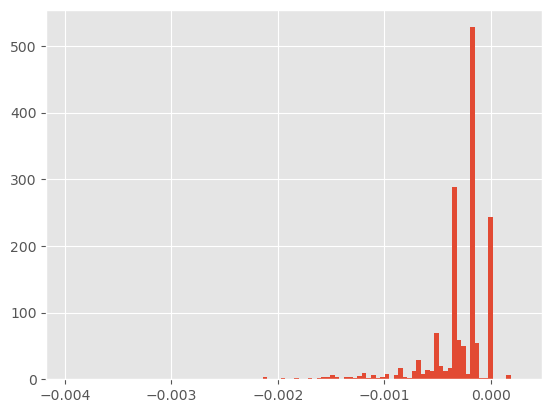

In [ ]:
slippage_df_selected, df_open, df_close = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time)
slippage_df_selected['slippage'].hist(bins=100)

In [ ]:
(df_open['swap1_done_time']-df_open['swap2_done_time']).mean()

Timedelta('0 days 00:00:00.103146718')

In [ ]:
slippage_df_selected['slippage'].mean()

-0.0003146309046718834

In [ ]:
slippage_df['slippage'].mean()

-0.00024574755132503466

<Axes: title={'center': 'pro15 DOGE USDT Slippage Distribution'}, xlabel='time'>

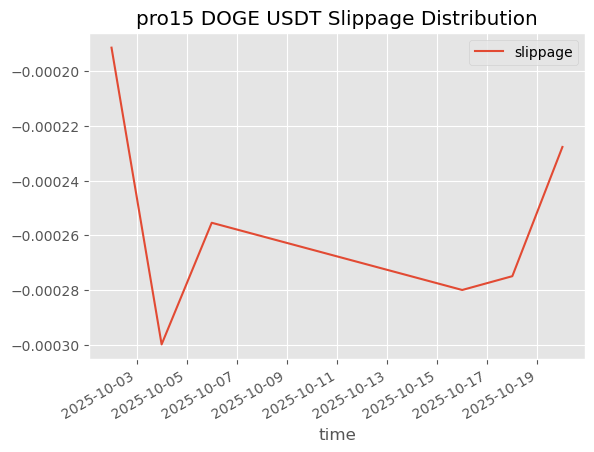

In [ ]:
# 增加标题
slippage_df.set_index('time').resample('2D').mean().dropna().plot(title=f'{env} {symbol} USDT Slippage Distribution')


In [ ]:
import pandas as pd


symbol = 'JELLYJELLY'
env_list = ['pro15', 'pro16']
replace_dict = {'pro15': 'okMbnT', 'pro16': 'okTbnM'}

start_date = '2025-10-22 09:00:00'
end_date = '2025-10-25 07:35:00'

summary = []

for env in env_list:
    file_path_1 = f'/Users/rayxu/Downloads/{symbol}_USDT.close_{env}.csv'
    file_path_2 = f'/Users/rayxu/Downloads/{symbol}_USDT.open_{env}.csv'
    slippage_df_selected = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time)
    
    summary.append({
        'env': env,
        'replace': replace_dict[env],
        'symbol': symbol,
        'count': len(slippage_df_selected),
        'mean': slippage_df_selected['slippage'].mean(),
        'std': slippage_df_selected['slippage'].std(),
        'min': slippage_df_selected['slippage'].min(),
        '25%': slippage_df_selected['slippage'].quantile(0.25),
        '50%': slippage_df_selected['slippage'].quantile(0.5),
        '75%': slippage_df_selected['slippage'].quantile(0.75),
        'max': slippage_df_selected['slippage'].max(),
    })

df = pd.DataFrame(summary).set_index('env')
df

replace      symbol  count      mean      std       min       25%  \
env                                                                       
pro15  okMbnT  JELLYJELLY   1355 -0.000356 0.000377 -0.005540 -0.000480   
pro16  okTbnM  JELLYJELLY   1392 -0.000328 0.000275 -0.002731 -0.000500   

            50%       75%      max  
env                                 
pro15 -0.000260 -0.000130 0.001817  
pro16 -0.000269 -0.000129 0.000759

In [ ]:
import pandas as pd
import numpy as np
import io
import statsmodels.api as sm

# 原始数据
data = """symbol	latency	tick_size	buy_slippage	sell_slippage	buy_usdt	sell_usdt	total_usdt
STORJ_USDT	0.121471	0.000541	-0.000736	-0.00126	11430.778	4370.958	15801.736
SOON_USDT	0.066239	0.000016	-0.001397	-0.000657	112.8925	96315.15217	96428.04467
RENDER_USDT	0.066219	0.000398	-0.00045	NaN	19643.6518	0	19643.6518
AERO_USDT	0.154166	0.000093	NaN	-0.000999	0	39110.08009	39110.08009
IOTA_USDT	NaN	NaN	NaN	NaN	0	0	0
KSM_USDT	0.1132	0.000092	-0.000939	NaN	418.9718	0	418.9718
W_USDT	0.063029	0.000123	NaN	-0.001001	0	19079.83802	19079.83802
MOODENG_USDT	0.170577	0.000089	-0.000407	-0.001172	922.45883	1258.97567	2181.4345
MERL_USDT	0.123263	0.000029	NaN	-0.000568	0	1088.802446	1088.802446
SOLV_USDT	0.044127	0.000232	-0.000983	-0.000882	717.47296	12374.52148	13091.99444
BAT_USDT	0.039734	0.000667	-0.000649	NaN	6047.0988	0	6047.0988
SUSHI_USDT	0.174758	0.00019	-0.000622	NaN	5497.8699	0	5497.8699
ZETA_USDT	0.105618	0.000894	-0.001498	NaN	6065.8154	0	6065.8154
T_USDT	0.279553	0.000807	NaN	-0.003609	0	10845.28259	10845.28259
CHZ_USDT	0.079725	0.0003	-0.00045	NaN	3913.7857	0	3913.7857
MUBARAK_USDT	NaN	NaN	NaN	NaN	0	0	0
TRUMP_USDT	0.079688	0.000168	-0.00022	NaN	36485.763	0	36485.763
USELESS_USDT	0.103668	0.000282	-0.000579	-0.00126	155.965898	46083.11952	46239.08541
GOAT_USDT	0.186667	0.000193	-0.00075	-0.00103	125.3921	841.2302	966.6223
SYRUP_USDT	0.120331	0.000025	-0.000762	NaN	12722.73039	0	12722.73039
ANIME_USDT	0.165444	0.001045	-0.001232	-0.001693	1439.8594	129.2985	1569.1579
JTO_USDT	0.100978	0.000089	-0.000995	NaN	14474.38449	0	14474.38449
MEW_USDT	0.115759	0.000475	-0.000662	NaN	12185.3143	0	12185.3143
TIA_USDT	0.109484	0.000091	-0.00078	-0.000827	3611.107789	69576.77695	73187.88474
"""

df = pd.read_excel('/Users/rayxu/Desktop/latency_pro17.xlsx').head(24)
df['slippage_mean'] = df[['buy_slippage', 'sell_slippage']].mean(axis=1)
df = df.dropna(subset=['latency', 'slippage_mean', 'tick_size'])
df = df[df['total_usdt'] > 0]
df['log_usdt'] = np.log(df['total_usdt'])

X = df[['latency', 'tick_size', 'log_usdt']]
X = sm.add_constant(X)
y = df['slippage_mean']

model = sm.OLS(y, X).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          slippage_mean   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     10.21
Date:                Fri, 24 Oct 2025   Prob (F-statistic):           0.000375
Time:                        17:53:54   Log-Likelihood:                 141.29
No. Observations:                  22   AIC:                            -274.6
Df Residuals:                      18   BIC:                            -270.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.693      0.108      -0.000       0.003
latency       -0.0077      0.002     -4.180      0.001      -0.012      -0.004
tick_size     -0.8809      0.325     -2.715      0.014      -1.563      -0.199
log_usdt      -0.0001   6.92e-05     -1.642      0.118      -0.000    3.18e-05
==============================================================================
Omnibus:                        2.025   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.363   Jarque-Bera (JB):                1.622
Skew:                          -0.636   Prob(JB):                        0.444
Kurtosis:                       2.612   Cond. No.                     3.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
df = pd.read_excel('/Users/rayxu/Desktop/latency_pro17.xlsx')
df.fillna(0, inplace=True)
df['buy_pct'] = df['buy_usdt']/df['total_usdt']
df['sell_pct'] = df['sell_usdt']/df['total_usdt']
df['slippage'] = df['buy_slippage']*df['buy_pct'] + df['sell_slippage']*df['sell_pct']
df.dropna(subset=['slippage'], inplace=True)

In [ ]:
df

symbol  latency  tick_size  buy_slippage  sell_slippage  \
0     STORJ_USDT 0.121471   0.000541     -0.000736      -0.001260   
1      SOON_USDT 0.066239   0.000016     -0.001397      -0.000657   
2    RENDER_USDT 0.066219   0.000398     -0.000450       0.000000   
3      AERO_USDT 0.154166   0.000093      0.000000      -0.000999   
5       KSM_USDT 0.113200   0.000092     -0.000939       0.000000   
..           ...      ...        ...           ...            ...   
107   LINEA_USDT 0.276154   0.000657     -0.000908       0.000000   
108     BNT_USDT 0.076111   0.000170     -0.001135       0.000000   
109    GALA_USDT 0.143782   0.000919     -0.000932      -0.001288   
110  RESOLV_USDT 0.107781   0.000147     -0.001796      -0.001090   
111    NEWT_USDT 0.139318   0.000671     -0.000996      -0.001549   

        buy_usdt    sell_usdt   total_usdt  buy_pct  sell_pct  slippage  
0   11430.778000  4370.958000 15801.736000 0.723387  0.276613 -0.000881  
1     112.892500 96315.152170 96428.044670 0.001171  0.998829 -0.000658  
2   19643.651800     0.000000 19643.651800 1.000000  0.000000 -0.000450  
3       0.000000 39110.080090 39110.080090 0.000000  1.000000 -0.000999  
5     418.971800     0.000000   418.971800 1.000000  0.000000 -0.000939  
..           ...          ...          ...      ...       ...       ...  
107  2347.904000     0.000000  2347.904000 1.000000  0.000000 -0.000908  
108  1195.715793     0.000000  1195.715793 1.000000  0.000000 -0.001135  
109  5200.410600   186.809400  5387.220000 0.965324  0.034676 -0.000944  
110  3514.830157 14347.915950 17862.746110 0.196769  0.803231 -0.001229  
111   485.277000  1587.240000  2072.517000 0.234149  0.765851 -0.001420  

[104 rows x 11 columns]

In [ ]:

X = df[['latency', 'tick_size']]
X = sm.add_constant(X)
y = df['slippage']

model = sm.OLS(y, X).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               slippage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     4.781
Date:                Fri, 24 Oct 2025   Prob (F-statistic):             0.0104
Time:                        17:56:09   Log-Likelihood:                 637.80
No. Observations:                 104   AIC:                            -1270.
Df Residuals:                     101   BIC:                            -1262.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008   6.96e-05    -10.922      0.000      -0.001      -0.001
latency     6.173e-06   2.98e-05      0.207      0.836    -5.3e-05    6.53e-05
tick_size     -0.4120      0.133     -3.092      0.003      -0.676      -0.148
==============================================================================
Omnibus:                       53.106   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.853
Skew:                          -1.822   Prob(JB):                     1.31e-37
Kurtosis:                       8.090   Cond. No.                     4.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          slippage_mean   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     3.625
Date:                Fri, 24 Oct 2025   Prob (F-statistic):             0.0156
Time:                        17:52:02   Log-Likelihood:                 607.89
No. Observations:                 104   AIC:                            -1208.
Df Residuals:                     100   BIC:                            -1197.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.000     -3.122      0.002      -0.002      -0.000
latency    -3.958e-06   4.08e-05     -0.097      0.923   -8.48e-05    7.69e-05
tick_size     -0.4833      0.184     -2.626      0.010      -0.848      -0.118
log_usdt    5.827e-05   4.49e-05      1.298      0.197   -3.08e-05       0.000
==============================================================================
Omnibus:                       88.244   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              705.700
Skew:                          -2.827   Prob(JB):                    5.74e-154
Kurtosis:                      14.441   Cond. No.                     2.43e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 实验1031

In [ ]:
import pandas as pd


symbol = 'ETH'
env_list = ['pro1', 'pro2', 'pro3', 'pro4', 'pro13', 'pro15', 'pro16', 'pro17']
# env_list = ['pro16']
replace_dict = {
'pro1': 'msecs500 replace80 normal', 
'pro2': 'msecs30000 replac40 normal',
'pro3': 'msecs30000 replace1 normal',
'pro4': 'msecs10000 replace80 normal',

'pro5': 'msecs10000 replace1 median', 
'pro7': 'msecs10000 replac80 median',
'pro8': 'msecs10000 replace1 normal',
'pro9': 'msecs3000 replace1 normal',
'pro12': 'msecs3000 replace40 normal',


'pro13': 'msecs3000 replace80 normal',
'pro15': 'msecs30000 replace80 normal',
'pro16': 'msecs30000 replace1 median',
'pro17': 'msecs30000 replace40 median'}

start_date = '2025-10-31 18:22:00'
# start_date = '2025-10-30 13:05:00' # pro16  切换成median
end_date = '2025-11-04 05:10:00'


summary = []

for env in env_list:
    file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.close.csv'
    file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.open.csv'
    slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


    # 创建子图  
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

    # 分析卖出滑点
    sell_slippage = short_slippage['slippage']
    sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
    ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
    ax1.set_xlabel('Slippage')
    ax1.set_ylabel('Frequency')
    sell_mean = sell_slippage.mean()
    sell_std = sell_slippage.std()
    ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
    ax1.legend()
    # print('sell count', len(sell_slippage))


    # 分析买入滑点
    buy_slippage = long_slippage['slippage']
    buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
    ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
    ax2.set_xlabel('Slippage')
    ax2.set_ylabel('Frequency')
    buy_mean = buy_slippage.mean()
    buy_std = buy_slippage.std()
    ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
    ax2.legend()
    # print('buy count', len(buy_slippage))

    # overall滑点分布
    slippage_array = slippage_df_selected['slippage'].values
    slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
    ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
    ax3.set_xlabel('Slippage')
    ax3.set_ylabel('Frequency')
    overall_mean = slippage_array.mean()
    ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    stats = {
        'symbol': symbol,
        'env': env,
        'replace': replace_dict[env],
        'count': len(slippage_array),
        'mean': np.mean(slippage_array),
        'median': np.median(slippage_array),
        'std': np.std(slippage_array),
        'min': np.min(slippage_array),
        'max': np.max(slippage_array),
        # 'percentile_1': np.percentile(slippage_array, 1),
        'percentile_5': np.percentile(slippage_array, 5),
        'percentile_10': np.percentile(slippage_array, 10),
        'percentile_25': np.percentile(slippage_array, 25),
        'percentile_50': np.percentile(slippage_array, 50),
        # 'percentile_55': np.percentile(slippage_array, 55),        
        'percentile_60': np.percentile(slippage_array, 60),
        # 'percentile_65': np.percentile(slippage_array, 65),
        'percentile_75': np.percentile(slippage_array, 75),
        'percentile_95': np.percentile(slippage_array, 95),
        # 'percentile_99': np.percentile(slippage_array, 99),
        'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
        'BNFirstSlippage_count': len(Exchange1FirstSlippage),
        'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
        'OKFirstSlippage_count': len(Exchange2FirstSlippage),
    }

    summary.append(stats)

df = pd.DataFrame(summary).set_index('env')
df

In [ ]:
# 稳定性
df[df.index.isin(['pro1','pro13', 'pro4','pro15'])]

symbol                      replace  count      mean    median      std  \
env                                                                             
pro1     ETH    msecs500 replace80 normal   4082 -0.000226 -0.000119 0.000308   
pro4     ETH  msecs10000 replace80 normal    971 -0.000222 -0.000108 0.000260   
pro13    ETH   msecs3000 replace80 normal   1956 -0.000224 -0.000109 0.000269   
pro15    ETH  msecs30000 replace80 normal    366 -0.000251 -0.000109 0.000308   

            min      max  percentile_5  percentile_10  percentile_25  \
env                                                                    
pro1  -0.005308 0.002416     -0.000810      -0.000561      -0.000316   
pro4  -0.001904 0.000000     -0.000728      -0.000548      -0.000342   
pro13 -0.002640 0.000307     -0.000809      -0.000586      -0.000324   
pro15 -0.001904 0.000000     -0.000808      -0.000682      -0.000378   

       percentile_50  percentile_60  percentile_75  percentile_95  \
env                                                                 
pro1       -0.000119      -0.000088      -0.000049       0.000000   
pro4       -0.000108      -0.000086      -0.000042       0.000000   
pro13      -0.000109      -0.000080      -0.000041       0.000000   
pro15      -0.000109      -0.000085      -0.000021       0.000000   

       BNFirstSlippage  BNFirstSlippage_count  OKFirstSlippage  \
env                                                              
pro1         -0.000225                   2231        -0.000227   
pro4         -0.000206                    509        -0.000240   
pro13        -0.000235                   1052        -0.000212   
pro15        -0.000199                    185        -0.000304   

       OKFirstSlippage_count  
env                           
pro1                    1851  
pro4                     462  
pro13                    904  
pro15                    181

In [ ]:
# 盘口
df[df.index.isin(['pro3','pro2','pro15'])]

symbol                      replace  count      mean    median      std  \
env                                                                             
pro2     ETH   msecs30000 replac40 normal    484 -0.000237 -0.000190 0.000236   
pro3     ETH   msecs30000 replace1 normal    310 -0.000241 -0.000169 0.000244   
pro15    ETH  msecs30000 replace80 normal    366 -0.000251 -0.000109 0.000308   

            min      max  percentile_5  percentile_10  percentile_25  \
env                                                                    
pro2  -0.001904 0.000099     -0.000727      -0.000627      -0.000356   
pro3  -0.001169 0.000000     -0.000782      -0.000623      -0.000361   
pro15 -0.001904 0.000000     -0.000808      -0.000682      -0.000378   

       percentile_50  percentile_60  percentile_75  percentile_95  \
env                                                                 
pro2       -0.000190      -0.000116      -0.000048       0.000000   
pro3       -0.000169      -0.000131      -0.000057       0.000000   
pro15      -0.000109      -0.000085      -0.000021       0.000000   

       BNFirstSlippage  BNFirstSlippage_count  OKFirstSlippage  \
env                                                              
pro2         -0.000211                    247        -0.000263   
pro3         -0.000214                    139        -0.000263   
pro15        -0.000199                    185        -0.000304   

       OKFirstSlippage_count  
env                           
pro2                     237  
pro3                     171  
pro15                    181

In [68]:
# median normal
df[df.index.isin(['pro3','pro2','pro16','pro17'])]

symbol                      replace  count      mean    median      std  \
env                                                                             
pro2     ETH   msecs30000 replac40 normal    484 -0.000237 -0.000190 0.000236   
pro3     ETH   msecs30000 replace1 normal    310 -0.000241 -0.000169 0.000244   
pro16    ETH   msecs30000 replace1 median   9028 -0.000234 -0.000184 0.000249   
pro17    ETH  msecs30000 replace40 median   3434 -0.000240 -0.000180 0.000248   

            min      max  percentile_5  percentile_10  percentile_25  \
env                                                                    
pro2  -0.001904 0.000099     -0.000727      -0.000627      -0.000356   
pro3  -0.001169 0.000000     -0.000782      -0.000623      -0.000361   
pro16 -0.004664 0.002562     -0.000661      -0.000517      -0.000317   
pro17 -0.002522 0.000697     -0.000687      -0.000538      -0.000350   

       percentile_50  percentile_60  percentile_75  percentile_95  \
env                                                                 
pro2       -0.000190      -0.000116      -0.000048       0.000000   
pro3       -0.000169      -0.000131      -0.000057       0.000000   
pro16      -0.000184      -0.000145      -0.000086       0.000000   
pro17      -0.000180      -0.000135      -0.000070       0.000000   

       BNFirstSlippage  BNFirstSlippage_count  OKFirstSlippage  \
env                                                              
pro2         -0.000211                    247        -0.000263   
pro3         -0.000214                    139        -0.000263   
pro16        -0.000234                   3603        -0.000234   
pro17        -0.000240                   1463        -0.000239   

       OKFirstSlippage_count  
env                           
pro2                     237  
pro3                     171  
pro16                   5425  
pro17                   1971

# 实验1102

In [ ]:
import pandas as pd


symbol = 'ETH'
env_list = ['pro1','pro2','pro3','pro4','pro5','pro7', 'pro8','pro9', 'pro12','pro13','pro15','pro16','pro17']
# env_list = ['pro16']
replace_dict = {
'pro1': 'msecs500 replace80 normal', 
'pro2': 'msecs30000 replac40 normal',
'pro3': 'msecs30000 replace1 normal',
'pro4': 'msecs10000 replace80 normal',

'pro5': 'msecs10000 replace1 median', 
'pro7': 'msecs10000 replac80 median',
'pro8': 'msecs10000 replace1 normal',
'pro9': 'msecs3000 replace1 normal',
'pro12': 'msecs3000 replace40 normal',


'pro13': 'msecs3000 replace80 normal',
'pro15': 'msecs30000 replace80 normal',
'pro16': 'msecs30000 replace1 median',
'pro17': 'msecs30000 replace40 median'}

start_date = '2025-11-02 13:00:00'
end_date = '2025-11-04 14:15:00'


summary = []

for env in env_list:
    file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.close.csv'
    file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.open.csv'
    slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


    # 创建子图  
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

    # 分析卖出滑点
    sell_slippage = short_slippage['slippage']
    sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
    ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
    ax1.set_xlabel('Slippage')
    ax1.set_ylabel('Frequency')
    sell_mean = sell_slippage.mean()
    sell_std = sell_slippage.std()
    ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
    ax1.legend()
    # print('sell count', len(sell_slippage))


    # 分析买入滑点
    buy_slippage = long_slippage['slippage']
    buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
    ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
    ax2.set_xlabel('Slippage')
    ax2.set_ylabel('Frequency')
    buy_mean = buy_slippage.mean()
    buy_std = buy_slippage.std()
    ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
    ax2.legend()
    # print('buy count', len(buy_slippage))

    # overall滑点分布
    slippage_array = slippage_df_selected['slippage'].values
    slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
    ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
    ax3.set_xlabel('Slippage')
    ax3.set_ylabel('Frequency')
    overall_mean = slippage_array.mean()
    ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    stats = {
        'symbol': symbol,
        'env': env,
        'replace': replace_dict[env],
        'count': len(slippage_array),
        'mean': np.mean(slippage_array),
        'median': np.median(slippage_array),
        'std': np.std(slippage_array),
        'min': np.min(slippage_array),
        'max': np.max(slippage_array),
        # 'percentile_1': np.percentile(slippage_array, 1),
        'percentile_5': np.percentile(slippage_array, 5),
        'percentile_10': np.percentile(slippage_array, 10),
        'percentile_25': np.percentile(slippage_array, 25),
        'percentile_50': np.percentile(slippage_array, 50),
        # 'percentile_55': np.percentile(slippage_array, 55),        
        'percentile_60': np.percentile(slippage_array, 60),
        # 'percentile_65': np.percentile(slippage_array, 65),
        'percentile_75': np.percentile(slippage_array, 75),
        'percentile_95': np.percentile(slippage_array, 95),
        # 'percentile_99': np.percentile(slippage_array, 99),
        'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
        'BNFirstSlippage_count': len(Exchange1FirstSlippage),
        'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
        'OKFirstSlippage_count': len(Exchange2FirstSlippage),
    }

    summary.append(stats)

df = pd.DataFrame(summary).set_index('env')
df

In [87]:
# df_close[df_close['swap1_side']=='closeShort'][df_close['slippage']<-0.0004]
df_close[df_close['sr_close']>0.0003]['slippage'].mean()

-0.0005000214498462142

In [105]:
df_short1 = df_open[df_open['swap1_side'] == 'buy'][['start','sr_open','sr_open_real','slippage']].rename(columns={'sr_open':'sr_short','sr_open_real':'sr_short_real'})
df_long1 = df_open[df_open['swap1_side'] == 'sell'][['start','sr_open','sr_open_real','slippage']].rename(columns={'sr_open':'sr_long','sr_open_real':'sr_long_real'})

df_short2 = df_close[df_close['swap1_side'] == 'closeShort'][['start','sr_close','sr_close_real','slippage']].rename(columns={'sr_close':'sr_short','sr_close_real':'sr_short_real'})
df_long2 = df_close[df_close['swap1_side'] == 'closeLong'][['start','sr_close','sr_close_real','slippage']].rename(columns={'sr_close':'sr_long','sr_close_real':'sr_long_real'})

df_short = pd.concat([df_short1, df_short2])
df_long = pd.concat([df_long1, df_long2])


In [133]:
df_short[df_short['sr_short']<0.0004]['slippage'].mean()

-0.00023087759279028346

In [134]:
df_long[df_long['sr_long']>-0.0004]['slippage'].mean()

-0.00022609786584196562

In [141]:
pd.concat([df_short[df_short['sr_short']<0.00032]['slippage'], df_long[df_long['sr_long']>-0.0004]['slippage']]).mean()

-0.00022801584972414148

In [142]:
0.000233-0.0002274515881344342

5.54841186556579e-06

In [ ]:
0.000228

In [ ]:
df_long[df_long['sr_long']>-0.0004]['slippage'].mean()

In [ ]:
df_short[df_short['sr_short']<0.0003]['slippage'].mean()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

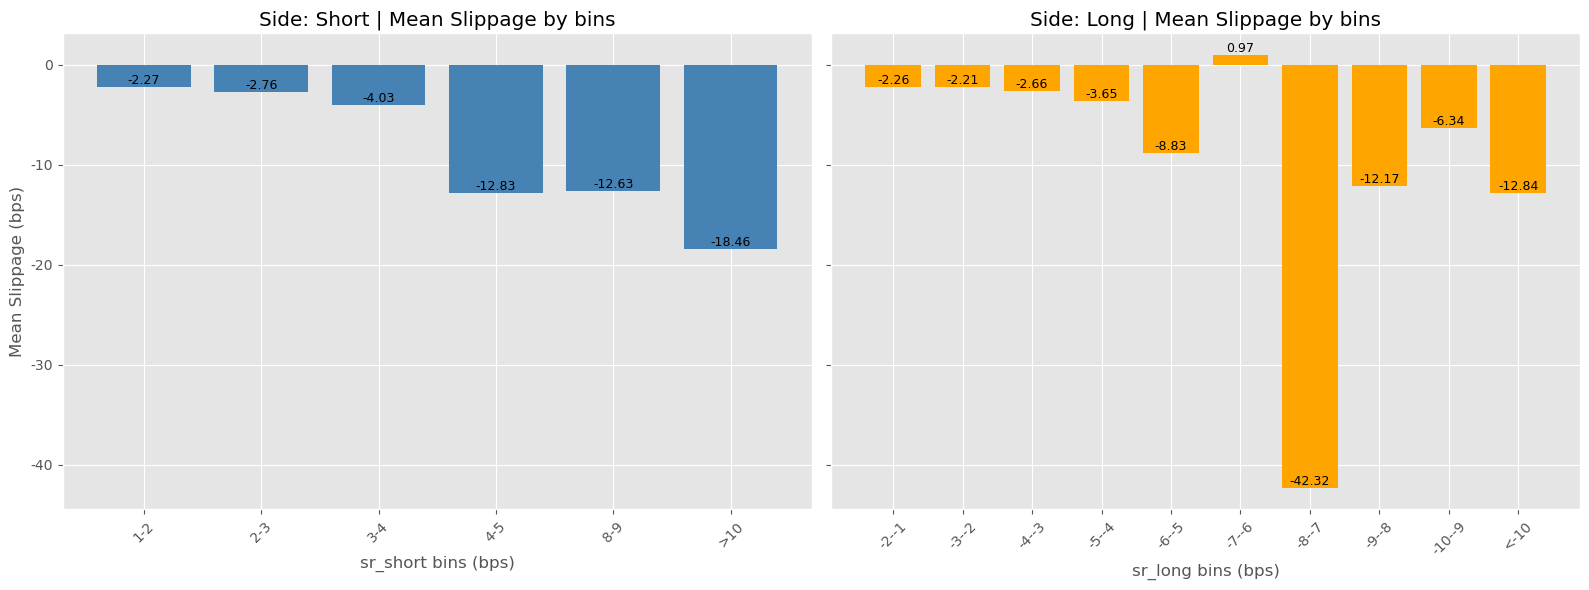

In [132]:
import pandas as pd
import matplotlib.pyplot as plt


# ==== 公共参数 ====
step = 1e-4  # 1 bps

# ==== sr_short：0→>10 bps ====
bins_short = [i*step for i in range(0, 11)] + [float('inf')]
labels_short = [f"{i}-{i+1}" for i in range(0, 10)] + [">10"]

df_short = df_short.copy()
df_short['sr_bin'] = pd.cut(df_short['sr_short'], bins=bins_short, labels=labels_short, right=False)
short_mean = df_short.groupby('sr_bin', observed=True)['slippage'].mean().reset_index()
short_mean['slippage_bps'] = short_mean['slippage'] * 1e4  # 转为bps

# ==== sr_long：先按升序分箱，然后重排为左大右小 ====
bins_long = [-float('inf')] + [-(i)*step for i in range(10,0,-1)] + [0.0]
labels_long_asc = ["<-10"] + [f"-{i}-{- (i-1)}" for i in range(10,0,-1)]
labels_long_display = [f"-{i}-{- (i-1)}" for i in range(1,11)] + ["<-10"]

df_long = df_long.copy()
df_long['sr_bin'] = pd.cut(df_long['sr_long'], bins=bins_long, labels=labels_long_asc, right=False)

long_mean = df_long.groupby('sr_bin', observed=True)['slippage'].mean().reset_index()
long_mean['slippage_bps'] = long_mean['slippage'] * 1e4
long_mean['sr_bin'] = pd.Categorical(long_mean['sr_bin'], categories=labels_long_display, ordered=True)
long_mean = long_mean.sort_values('sr_bin')

# ==== 画图 ====
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

# ---- sr_short ----
bars1 = axes[0].bar(short_mean['sr_bin'].astype(str), short_mean['slippage_bps'], color='steelblue')
axes[0].set_title("Side: Short | Mean Slippage by bins")
axes[0].set_xlabel("sr_short bins (bps)")
axes[0].set_ylabel("Mean Slippage (bps)")
axes[0].tick_params(axis='x', rotation=45)

# 在柱子上标数值
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height,
                 f"{height:.2f}", ha='center', va='bottom', fontsize=9)

# ---- sr_long ----
bars2 = axes[1].bar(long_mean['sr_bin'].astype(str), long_mean['slippage_bps'], color='orange')
axes[1].set_title("Side: Long | Mean Slippage by bins")
axes[1].set_xlabel("sr_long bins (bps)")
axes[1].tick_params(axis='x', rotation=45)

for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height,
                 f"{height:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [107]:
df_long

start   sr_long  \
6967  2025-11-02 15:38:48.757855508 +0800 CST m=+116... -0.000177   
6968  2025-11-02 15:38:48.757945382 +0800 CST m=+116... -0.000177   
6969  2025-11-02 15:38:48.755862711 +0800 CST m=+116... -0.000177   
6970  2025-11-02 15:40:09.899863202 +0800 CST m=+117... -0.000172   
6971  2025-11-02 15:40:09.899934113 +0800 CST m=+117... -0.000172   
...                                                 ...       ...   
9055  2025-11-03 14:46:09.467903178 +0800 CST m=+823... -0.000170   
9056  2025-11-03 14:46:09.46786016 +0800 CST m=+8234... -0.000170   
9057  2025-11-03 14:46:09.468023603 +0800 CST m=+823... -0.000170   
9058  2025-11-03 14:46:10.627668816 +0800 CST m=+823... -0.000178   
9059  2025-11-03 14:46:10.617253504 +0800 CST m=+823... -0.000178   

      sr_long_real  slippage  
6967      0.000550 -0.000727  
6968      0.000550 -0.000727  
6969      0.000550 -0.000727  
6970      0.000246 -0.000418  
6971      0.000246 -0.000418  
...            ...       ...  
9055      0.000314 -0.000484  
9056      0.000314 -0.000484  
9057      0.000314 -0.000484  
9058     -0.000178  0.000000  
9059     -0.000178  0.000000  

[3937 rows x 4 columns]

In [99]:
df_long1

start   sr_long  \
6967   2025-11-02 15:38:48.757855508 +0800 CST m=+116... -0.000177   
6968   2025-11-02 15:38:48.757945382 +0800 CST m=+116... -0.000177   
6969   2025-11-02 15:38:48.755862711 +0800 CST m=+116... -0.000177   
6970   2025-11-02 15:40:09.899863202 +0800 CST m=+117... -0.000172   
6971   2025-11-02 15:40:09.899934113 +0800 CST m=+117... -0.000172   
...                                                  ...       ...   
10899  2025-11-04 01:55:05.299738069 +0800 CST m=+122... -0.000230   
10900  2025-11-04 01:55:05.439592336 +0800 CST m=+122... -0.000230   
10901  2025-11-04 01:55:06.876111853 +0800 CST m=+122... -0.000230   
10902  2025-11-04 01:55:07.176477381 +0800 CST m=+122... -0.000213   
10903  2025-11-04 01:55:06.876073115 +0800 CST m=+122... -0.000230   

       sr_long_real  slippage  
6967       0.000550 -0.000727  
6968       0.000550 -0.000727  
6969       0.000550 -0.000727  
6970       0.000246 -0.000418  
6971       0.000246 -0.000418  
...             ...       ...  
10899     -0.000230 -0.000000  
10900     -0.000230 -0.000000  
10901      0.000170 -0.000400  
10902      0.000170 -0.000383  
10903      0.000170 -0.000400  

[3706 rows x 4 columns]

# 看过滤条件

In [50]:
symbol = 'ETH'
env = 'pro16'
start_date = '2025-11-04 16:00:00'
end_date = '2025-11-05 12:00:00'
file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.close.csv'
file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.open.csv'
slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


In [49]:
ccy = 'ETH'
st='2025-11-03'
et='2025-11-05'
# train_st='2025-07-01'
# train_et='2025-07-18'
exchange1='binance' 
market1='swap'
exchange2='okx'     
market2='swap'
open_quantile = 0.95
close_quantile = 0.05
order_type = 'MT'
data_source = "nuts_mm"
def read_cf_depth_backtesting(ccy, start_date, end_date, exchange1, market1, exchange2, market2, data_source, isUseLocalTime = False):

    if data_source == 'nuts_mm':
        market1_depth_path = f'/Volumes/T7/data/{exchange1}/perp/books/{ccy}'
        market2_depth_path = f'/Volumes/T7/data/{exchange2}/perp/books/{ccy}'
        market1_depth = pd.concat([pd.read_parquet(f'{market1_depth_path}/{ccy}usdt_{dd}_depth5.parquet')
                            for dd in pd.date_range(start_date, end_date).strftime('%Y-%m-%d')])        
        market2_depth = pd.concat([pd.read_parquet(f'{market2_depth_path}/{ccy}usdt_{dd}_depth5.parquet')
                            for dd in pd.date_range(start_date, end_date).strftime('%Y-%m-%d')])
    if isUseLocalTime:
        time_col = 'received_time'
        market1_depth[time_col] = pd.to_datetime(market1_depth[time_col])
        market2_depth[time_col] = pd.to_datetime(market2_depth[time_col])
    else:
        time_col = 'T'
        market1_depth[time_col] = pd.to_datetime(market1_depth[time_col], unit='ms')
        market2_depth[time_col] = pd.to_datetime(market2_depth[time_col], unit='ms')

    market1_depth.set_index(time_col, inplace=True)
    market1_depth['ws_type'] = "market1_depth"
    # market1_depth.drop_duplicates(inplace=True)


    market2_depth.set_index(time_col, inplace=True)
    market2_depth['ws_type'] = "market2_depth"
    # market2_depth.drop_duplicates(inplace=True)
    


    ########################################################################################
    # 04-21修改： 改用merge_asof
    # 保证时间索引已经在 column 中（因为 merge_asof 不能用 index 作为 on）
    market1_depth = market1_depth.reset_index()
    market2_depth = market2_depth.reset_index()

    merged_time = pd.Series(
        sorted(set(market1_depth[time_col]) | set(market2_depth[time_col]))
    )


    market1_depth_full = pd.merge_asof(merged_time.to_frame(time_col), market1_depth.sort_values(time_col),
                            on=time_col, direction='backward',tolerance=pd.Timedelta('100ms'))
    market2_depth_full = pd.merge_asof(merged_time.to_frame(time_col), market2_depth.sort_values(time_col),
                            on=time_col, direction='backward',tolerance=pd.Timedelta('100ms'))
                            
    merged_depth = pd.concat(
        [market1_depth_full.add_prefix('market1_'), market2_depth_full.add_prefix('market2_')], axis=1
    )
    merged_depth[time_col] = merged_time.values
    merged_depth['sr_open'] = (merged_depth['market2_ask_price0']/merged_depth['market1_ask_price0']-1)*10000
    merged_depth['sr_close'] = (merged_depth['market2_bid_price0']/merged_depth['market1_bid_price0']-1)*10000
    cf_depth = merged_depth.dropna()

    cf_depth.reset_index(inplace=True)
    cf_depth.set_index(time_col, inplace=True)
    if not isUseLocalTime:
        beijing_time = cf_depth.index.tz_localize('UTC').tz_convert('Asia/Shanghai').tz_localize(None)
        cf_depth['beijing_time'] = beijing_time
    else:
        cf_depth['beijing_time'] = cf_depth.index
        
    cf_depth = cf_depth.sort_index()
    # rolling('5s') 表示时间窗口5秒；center=False表示只看过去
    cf_depth['sr_open_median_5s'] = cf_depth['sr_open'].rolling('5s').median()/10000
    cf_depth['sr_open_median_10s'] = cf_depth['sr_open'].rolling('10s').median()/10000
    cf_depth['sr_open_median_30s'] = cf_depth['sr_open'].rolling('30s').median()/10000
    cf_depth['sr_close_median_5s'] = cf_depth['sr_close'].rolling('5s').median()/10000
    cf_depth['sr_close_median_10s'] = cf_depth['sr_close'].rolling('10s').median()/10000
    cf_depth['sr_close_median_30s'] = cf_depth['sr_close'].rolling('30s').median()/10000
    return cf_depth
def read_cf_depth(ccy, start_date, end_date, exchange1, market1, exchange2, market2, data_source):
    if data_source == 'inner_win':
        market1_depth_path = f'/Users/rayxu/Desktop/Obentech/dcdlData/{exchange1}/books/{ccy}/{market1}'
        market2_depth_path = f'/Users/rayxu/Desktop/Obentech/dcdlData/{exchange2}/books/{ccy}/{market2}'
    elif data_source == 'outer_ssd':
        market1_depth_path = f'/Volumes/T7/Obentech/dcdlData/{exchange1}/books/{ccy}/{market1}'
        market2_depth_path = f'/Volumes/T7/Obentech/dcdlData/{exchange2}/books/{ccy}/{market2}'
    elif data_source == 'nuts_mm':
        market1_depth_path = f'/Volumes/T7/data/{exchange1}/perp/books/{ccy}'
        market2_depth_path = f'/Volumes/T7/data/{exchange2}/perp/books/{ccy}'
    # if data_source == 'nuts_am_on_mac':
    #     market1_depth_path = f'/Users/rayxu/Downloads/nuts_am/data/{exchange1}/perp/books/{ccy}'
    #     market2_depth_path = f'/Users/rayxu/Downloads/nuts_am/data/{exchange2}/perp/books/{ccy}'
        market1_depth = pd.concat([pd.read_parquet(f'{market1_depth_path}/{ccy}usdt_{dd}_depth5.parquet')
                            for dd in pd.date_range(start_date, end_date).strftime('%Y-%m-%d')])        
        market2_depth = pd.concat([pd.read_parquet(f'{market2_depth_path}/{ccy}usdt_{dd}_depth5.parquet')
                            for dd in pd.date_range(start_date, end_date).strftime('%Y-%m-%d')])
    # else:
    #     market1_depth = pd.concat([pd.read_csv(f'{market1_depth_path}/{ccy}usdt_{dd}_depth5.csv')
    #                       for dd in pd.date_range(start_date, end_date).strftime('%Y-%m-%d')])        
    #     market2_depth = pd.concat([pd.read_csv(f'{market2_depth_path}/{ccy}usdt_{dd}_depth5.csv')
    #                       for dd in pd.date_range(start_date, end_date).strftime('%Y-%m-%d')])

    time_col = get_time_col(exchange1,exchange2)
    market1_depth[time_col] = pd.to_datetime(market1_depth[time_col], unit = 'ms')
    market1_depth.set_index(time_col, inplace=True)
    market1_depth['ws_type'] = "market1_depth"
    market1_depth.drop_duplicates(inplace=True)


    market2_depth[time_col] = pd.to_datetime(market2_depth[time_col], unit = 'ms')
    market2_depth.set_index(time_col, inplace=True)
    market2_depth['ws_type'] = "market2_depth"
    market2_depth.drop_duplicates(inplace=True)
    
    market1_depth.columns = rename_columns(list(market1_depth.columns), 'market1_')
    market2_depth.columns = rename_columns(list(market2_depth.columns), 'market2_')
    ########################################################################################
    # 04-21修改： 改用merge_asof
    # 保证时间索引已经在 column 中（因为 merge_asof 不能用 index 作为 on）
    market1_depth = market1_depth.reset_index()
    market2_depth = market2_depth.reset_index()

    # 使用 merge_asof 精准时间对齐，100ms 容差，向后对齐
    cf_depth = pd.merge_asof(
        market1_depth.sort_values(time_col),
        market2_depth.sort_values(time_col),
        on=time_col,
        direction='backward',
        tolerance=pd.Timedelta('100ms'),
        suffixes=('_market1', '_market2')
    )

    cf_depth[['market1_ws_type', 'market2_ws_type']] = cf_depth[['market1_ws_type', 'market2_ws_type']].fillna('')
    cf_depth['ws_type'] = cf_depth['market1_ws_type'] + cf_depth['market2_ws_type']
    
    cf_depth.dropna(inplace=True)
    cf_depth = cf_depth.fillna(method='ffill').assign(
        # sp_open=lambda df: df['market2_bid_price1']-df['market1_ask_price1'],
        # sp_close=lambda df: df['market2_ask_price1']-df['market1_bid_price1'],
        sr_open=lambda df: df['market2_ask_price1']/df['market1_bid_price1']-1,
        sr_close=lambda df: df['market2_bid_price1']/df['market1_ask_price1']-1,
        # 用midprice计算
        midprice=lambda df: (df['market1_bid_price1'] + df['market1_ask_price1']) / 2
    )

    # # 计算过去N个tick的收益率（用midprice）
    # for n in [10, 50, 100, 300, 600]:
    #     cf_depth[f'ret_mid_{n/10}s'] = cf_depth['midprice'].pct_change(periods=n)
    #     cf_depth[f'logret_mid_{n/10}s'] = np.log(cf_depth['midprice'] / cf_depth['midprice'].shift(n))
    
    cf_depth.reset_index(inplace=True)
    # cf_depth['received_time_diff_1jump_later'] = cf_depth[time_col].shift(-1) - cf_depth[time_col]
    # cf_depth['received_time_diff_1jump_later'] = cf_depth['received_time_diff_1jump_later'].apply(lambda x:x.total_seconds())
    cf_depth.set_index(time_col, inplace=True)
    beijing_time = cf_depth.index.tz_localize('UTC').tz_convert('Asia/Shanghai').tz_localize(None)
    cf_depth['beijing_time'] = beijing_time
    cf_depth_st_index = cf_depth.index[0]
    cf_depth_et_index = cf_depth.index[-1]
    cf_depth['sr_open_median_5s'] = cf_depth['sr_open'].rolling('5s').median()
    cf_depth['sr_open_median_10s'] = cf_depth['sr_open'].rolling('10s').median()
    cf_depth['sr_open_median_30s'] = cf_depth['sr_open'].rolling('30s').median()
    cf_depth['sr_close_median_5s'] = cf_depth['sr_close'].rolling('5s').median()
    cf_depth['sr_close_median_10s'] = cf_depth['sr_close'].rolling('10s').median()
    cf_depth['sr_close_median_30s'] = cf_depth['sr_close'].rolling('30s').median()
    return cf_depth


cf_depth = read_cf_depth(ccy, st, et, exchange1, market1, exchange2, market2, data_source=data_source)

In [51]:
cf_depth = cf_depth.reset_index()
cf_depth

T    index    market1_received_time  \
0       2025-11-02 16:00:42.410       85  2025-11-03 00:00:42.449   
1       2025-11-02 16:00:42.410       86  2025-11-03 00:00:42.549   
2       2025-11-02 16:00:42.526       87  2025-11-03 00:00:42.649   
3       2025-11-02 16:00:42.621       88  2025-11-03 00:00:42.749   
4       2025-11-02 16:00:42.740       89  2025-11-03 00:00:42.850   
...                         ...      ...                      ...   
2404531 2025-11-05 15:59:59.417  2590448  2025-11-05 23:59:59.549   
2404532 2025-11-05 15:59:59.552  2590449  2025-11-05 23:59:59.649   
2404533 2025-11-05 15:59:59.666  2590450  2025-11-05 23:59:59.749   
2404534 2025-11-05 15:59:59.764  2590451  2025-11-05 23:59:59.849   
2404535 2025-11-05 15:59:59.882  2590452  2025-11-05 23:59:59.949   

             market1_E  market1_bid_price0  market1_bid_size0  \
0        1762099242411         3849.300000          92.310000   
1        1762099242411         3849.300000          92.310000   
2        1762099242537         3849.680000         156.388000   
3        1762099242639         3849.910000         203.593000   
4        1762099242741         3849.910000         184.703000   
...                ...                 ...                ...   
2404531  1762358399420         3396.310000          36.347000   
2404532  1762358399553         3396.310000          35.560000   
2404533  1762358399668         3396.310000          20.806000   
2404534  1762358399772         3396.310000          12.930000   
2404535  1762358399883         3396.310000          30.607000   

         market1_bid_price1  market1_bid_size1  market1_bid_price2  \
0               3849.290000           0.038000         3849.280000   
1               3849.290000           0.038000         3849.280000   
2               3849.670000           0.032000         3849.640000   
3               3849.900000          16.030000         3849.890000   
4               3849.900000           2.501000         3849.890000   
...                     ...                ...                 ...   
2404531         3396.300000           0.120000         3396.290000   
2404532         3396.300000           0.120000         3396.290000   
2404533         3396.300000           0.120000         3396.290000   
2404534         3396.300000           0.120000         3396.290000   
2404535         3396.300000           4.827000         3396.290000   

         market1_bid_size2  market1_bid_price3  market1_bid_size3  \
0                 0.007000         3849.260000           0.006000   
1                 0.007000         3849.260000           0.006000   
2                17.622000         3849.630000          78.182000   
3                 5.661000         3849.880000           0.032000   
4                 0.048000         3849.880000           0.032000   
...                    ...                 ...                ...   
2404531           1.106000         3396.280000           1.177000   
2404532           1.106000         3396.280000           1.177000   
2404533           1.106000         3396.280000           1.177000   
2404534           1.230000         3396.280000           1.177000   
2404535          27.061000         3396.280000           1.177000   

         market1_bid_price4  market1_bid_size4  market1_ask_price0  \
0               3849.240000           2.146000         3849.310000   
1               3849.240000           2.146000         3849.310000   
2               3849.610000           2.513000         3849.690000   
3               3849.870000           0.084000         3849.920000   
4               3849.840000           0.017000         3849.920000   
...                     ...                ...                 ...   
2404531         3396.270000           0.043000         3396.320000   
2404532         3396.270000           0.043000         3396.320000   
2404533         3396.270000           0.043000         3396.320000   
2404534         3396.270000           0.043000    

In [52]:
df_close = pd.merge_asof(
    df_close.sort_values('time'), 
    cf_depth[['beijing_time', 'sr_close_median_5s', 'sr_close_median_10s', 'sr_close_median_30s','sr_open_median_5s', 'sr_open_median_10s', 'sr_open_median_30s']].sort_values('beijing_time'),
    left_on='time',      # df_close 的时间列
    right_on='beijing_time',         # cf_depth 的时间列
    direction='backward', # 表示用不超过 start 的最近时间
    tolerance=pd.Timedelta('200ms')  # 时间容忍度
)


In [53]:
df_open = pd.merge_asof(
    df_open.sort_values('time'), 
    cf_depth[['beijing_time', 'sr_close_median_5s', 'sr_close_median_10s', 'sr_close_median_30s','sr_open_median_5s', 'sr_open_median_10s', 'sr_open_median_30s']].sort_values('beijing_time'),
    left_on='time',      # df_close 的时间列
    right_on='beijing_time',         # cf_depth 的时间列
    direction='backward', # 表示用不超过 start 的最近时间
    tolerance=pd.Timedelta('200ms')  # 时间容忍度
)

In [65]:
df_close['slippage'].mean()

-0.0002974864814689761

In [67]:
df_close

start  sr_close  \
0     2025-11-04 19:02:28.205003604 +0800 CST m=+184...  0.000129   
1     2025-11-04 19:02:28.207440443 +0800 CST m=+184...  0.000129   
2     2025-11-04 19:02:28.207615824 +0800 CST m=+184...  0.000129   
3     2025-11-04 19:02:32.817036408 +0800 CST m=+184...  0.000141   
4     2025-11-04 19:02:32.817535953 +0800 CST m=+184...  0.000141   
...                                                 ...       ...   
1090  2025-11-05 10:05:31.689330796 +0800 CST m=+238...  0.000113   
1091  2025-11-05 10:05:31.799534326 +0800 CST m=+238...  0.000113   
1092  2025-11-05 10:05:35.833687326 +0800 CST m=+238...  0.000116   
1093  2025-11-05 10:05:35.833723386 +0800 CST m=+238...  0.000116   
1094  2025-11-05 10:05:35.833797047 +0800 CST m=+238...  0.000116   

      sr_close_real             swap1_order_id  swap1_avg_price  \
0         -0.000247 8389766006149513216.000000      3485.990000   
1         -0.000247 8389766006149513216.000000      3485.990000   
2         -0.000247 8389766006149513216.000000      3485.990000   
3          0.000141 8389766006149600256.000000      3485.110000   
4          0.000141 8389766006149600256.000000      3485.110000   
...             ...                        ...              ...   
1090      -0.000763 8389766007028311040.000000      3274.590000   
1091      -0.000763 8389766007028312064.000000      3274.590000   
1092      -0.000685 8389766007028371456.000000      3271.360000   
1093      -0.000685 8389766007028371456.000000      3271.360000   
1094      -0.000685 8389766007028371456.000000      3271.360000   

      swap1_deal_amount  swap1_side  swap1_fee swap1_fee_currency  \
0              0.459000  closeShort   0.080003               USDT   
1              0.459000  closeShort   0.080003               USDT   
2              0.459000  closeShort   0.080003               USDT   
3              0.459000  closeShort   0.079983               USDT   
4              0.459000  closeShort   0.079983               USDT   
...                 ...         ...        ...                ...   
1090           0.489000  closeShort   0.080064               USDT   
1091           0.489000  closeShort   0.080064               USDT   
1092           0.489000  closeShort   0.079985               USDT   
1093           0.489000  closeShort   0.079985               USDT   
1094           0.489000  closeShort   0.079985               USDT   

     swap1_is_maker                                    swap1_open_time  \
0             False  2025-11-04 19:02:28.281143154 +0800 CST m=+184...   
1             False  2025-11-04 19:02:28.277309406 +0800 CST m=+184...   
2             False  2025-11-04 19:02:28.271037438 +0800 CST m=+184...   
3             False  2025-11-04 19:02:32.877079362 +0800 CST m=+184...   
4             False  2025-11-04 19:02:32.878958488 +0800 CST m=+184...   
...             ...                                                ...   
1090          False  2025-11-05 10:05:31.744041295 +0800 CST m=+238...   
1091          False  2025-11-05 10:05:31.855422255 +0800 CST m=+238...   
1092          False  2025-11-05 10:05:35.888303578 +0800 CST m=+238...   
1093          False  2025-11-05 10:05:35.891144601 +0800 CST m=+238...   
1094          False  2025-11-05 10:05:35.897564045 +0800 CST m=+238...   

             swap1_done_time             swap2_order_id  swap2_avg_price  \
0    2025-11-04 19:02:29.286 3011569043821289472.000000      3485.130000   
1    2025-11-04 19:02:29.286 3011569043787735040.000000      3485.130000   
2    2025-11-04 19:02:29.286 3011569043821289472.000000      3485.130000   
3    2025-11-04 19:02:33.103 3011569097474826240.000000      3485.600000   
4    2025-11-04 19:02:33.103 3011569097474826240.000000      3485.600000   
...                      ...                        ...              ...   
1090 2025-11-05 10:05:31.945 3013387071634530304.000000      3272.090000   
1091 2025-11-05 10:05:31.945 3013387071634530304.000000      3272.090000   
1092 2025-11-0

In [70]:
df_close[df_close['sr_close']<df_close['sr_open_median_30s']+0.0002]['slippage'].mean()

-0.0002810109537023539

In [59]:
df_close[df_close['swap1_side']=='sell']['sr_open_median_30s'].describe()

start  sr_close  \
0     2025-11-04 19:02:28.205003604 +0800 CST m=+184...  0.000129   
1     2025-11-04 19:02:28.207440443 +0800 CST m=+184...  0.000129   
2     2025-11-04 19:02:28.207615824 +0800 CST m=+184...  0.000129   
3     2025-11-04 19:02:32.817036408 +0800 CST m=+184...  0.000141   
4     2025-11-04 19:02:32.817535953 +0800 CST m=+184...  0.000141   
...                                                 ...       ...   
1090  2025-11-05 10:05:31.689330796 +0800 CST m=+238...  0.000113   
1091  2025-11-05 10:05:31.799534326 +0800 CST m=+238...  0.000113   
1092  2025-11-05 10:05:35.833687326 +0800 CST m=+238...  0.000116   
1093  2025-11-05 10:05:35.833723386 +0800 CST m=+238...  0.000116   
1094  2025-11-05 10:05:35.833797047 +0800 CST m=+238...  0.000116   

      sr_close_real             swap1_order_id  swap1_avg_price  \
0         -0.000247 8389766006149513216.000000      3485.990000   
1         -0.000247 8389766006149513216.000000      3485.990000   
2         -0.000247 8389766006149513216.000000      3485.990000   
3          0.000141 8389766006149600256.000000      3485.110000   
4          0.000141 8389766006149600256.000000      3485.110000   
...             ...                        ...              ...   
1090      -0.000763 8389766007028311040.000000      3274.590000   
1091      -0.000763 8389766007028312064.000000      3274.590000   
1092      -0.000685 8389766007028371456.000000      3271.360000   
1093      -0.000685 8389766007028371456.000000      3271.360000   
1094      -0.000685 8389766007028371456.000000      3271.360000   

      swap1_deal_amount  swap1_side  swap1_fee swap1_fee_currency  \
0              0.459000  closeShort   0.080003               USDT   
1              0.459000  closeShort   0.080003               USDT   
2              0.459000  closeShort   0.080003               USDT   
3              0.459000  closeShort   0.079983               USDT   
4              0.459000  closeShort   0.079983               USDT   
...                 ...         ...        ...                ...   
1090           0.489000  closeShort   0.080064               USDT   
1091           0.489000  closeShort   0.080064               USDT   
1092           0.489000  closeShort   0.079985               USDT   
1093           0.489000  closeShort   0.079985               USDT   
1094           0.489000  closeShort   0.079985               USDT   

     swap1_is_maker                                    swap1_open_time  \
0             False  2025-11-04 19:02:28.281143154 +0800 CST m=+184...   
1             False  2025-11-04 19:02:28.277309406 +0800 CST m=+184...   
2             False  2025-11-04 19:02:28.271037438 +0800 CST m=+184...   
3             False  2025-11-04 19:02:32.877079362 +0800 CST m=+184...   
4             False  2025-11-04 19:02:32.878958488 +0800 CST m=+184...   
...             ...                                                ...   
1090          False  2025-11-05 10:05:31.744041295 +0800 CST m=+238...   
1091          False  2025-11-05 10:05:31.855422255 +0800 CST m=+238...   
1092          False  2025-11-05 10:05:35.888303578 +0800 CST m=+238...   
1093          False  2025-11-05 10:05:35.891144601 +0800 CST m=+238...   
1094          False  2025-11-05 10:05:35.897564045 +0800 CST m=+238...   

             swap1_done_time             swap2_order_id  swap2_avg_price  \
0    2025-11-04 19:02:29.286 3011569043821289472.000000      3485.130000   
1    2025-11-04 19:02:29.286 3011569043787735040.000000      3485.130000   
2    2025-11-04 19:02:29.286 3011569043821289472.000000      3485.130000   
3    2025-11-04 19:02:33.103 3011569097474826240.000000      3485.600000   
4    2025-11-04 19:02:33.103 3011569097474826240.000000      3485.600000   
...                      ...                        ...              ...   
1090 2025-11-05 10:05:31.945 3013387071634530304.000000      3272.090000   
1091 2025-11-05 10:05:31.945 3013387071634530304.000000      3272.090000   
1092 2025-11-0

In [63]:
df_close[df_close['sr_open_median_30s']<0.0001]
# df_close[df_close['swap1_side']=='closeShort']['sr_open_median_30s'].describe()



start  sr_close  \
258  2025-11-05 02:22:57.443956625 +0800 CST m=+210...  0.000108   
259  2025-11-05 02:22:57.444076794 +0800 CST m=+210...  0.000108   
260  2025-11-05 02:22:57.444126458 +0800 CST m=+210...  0.000108   
447  2025-11-05 04:35:48.449078989 +0800 CST m=+218...  0.000202   
448  2025-11-05 04:35:48.449169525 +0800 CST m=+218...  0.000202   
449  2025-11-05 04:35:50.658805662 +0800 CST m=+218...  0.000120   
450  2025-11-05 04:35:50.658984928 +0800 CST m=+218...  0.000120   
451  2025-11-05 04:35:50.666208782 +0800 CST m=+218...  0.000120   
452  2025-11-05 05:07:07.275204907 +0800 CST m=+220...  0.000116   
453  2025-11-05 05:07:07.277535317 +0800 CST m=+220...  0.000116   
586  2025-11-05 06:06:40.861852339 +0800 CST m=+223...  0.000204   
587  2025-11-05 06:06:42.022145073 +0800 CST m=+223...  0.000117   
588  2025-11-05 06:06:42.023970235 +0800 CST m=+223...  0.000117   
589  2025-11-05 06:06:42.462211231 +0800 CST m=+223...  0.000105   

     sr_close_real             swap1_order_id  swap1_avg_price  \
258      -0.000355 8389766006582188032.000000      3324.150000   
259      -0.000355 8389766006582188032.000000      3324.150000   
260      -0.000355 8389766006582188032.000000      3324.150000   
447      -0.000066 8389766006716502016.000000      3164.350000   
448      -0.000066 8389766006716502016.000000      3164.350000   
449      -0.000202 8389766006716558336.000000      3166.900000   
450      -0.000221 8389766006716559360.000000      3166.960000   
451      -0.000202 8389766006716558336.000000      3166.900000   
452      -0.000586 8389766006747919360.000000      3192.270000   
453      -0.000197 8389766006747944960.000000      3191.210000   
586      -0.000275 8389766006803193856.000000      3236.930000   
587      -0.000195 8389766006803220480.000000      3236.670000   
588      -0.000195 8389766006803220480.000000      3236.670000   
589      -0.000130 8389766006803220480.000000      3236.670000   

     swap1_deal_amount  swap1_side  swap1_fee swap1_fee_currency  \
258           0.482000  closeShort   0.080112               USDT   
259           0.482000  closeShort   0.080112               USDT   
260           0.482000  closeShort   0.080112               USDT   
447           0.506000  closeShort   0.080058               USDT   
448           0.506000  closeShort   0.080058               USDT   
449           0.505000  closeShort   0.079964               USDT   
450           0.505000  closeShort   0.079966               USDT   
451           0.505000  closeShort   0.079964               USDT   
452           0.501000  closeShort   0.079966               USDT   
453           0.501000  closeShort   0.079940               USDT   
586           0.494000  closeShort   0.079952               USDT   
587           0.494000  closeShort   0.079946               USDT   
588           0.494000  closeShort   0.079946               USDT   
589           0.494000  closeShort   0.079946                NaN   

    swap1_is_maker                                    swap1_open_time  \
258          False  2025-11-05 02:22:57.522310259 +0800 CST m=+210...   
259          False  2025-11-05 02:22:57.524515021 +0800 CST m=+210...   
260          False  2025-11-05 02:22:57.518101169 +0800 CST m=+210...   
447          False  2025-11-05 04:35:48.525527891 +0800 CST m=+218...   
448          False  2025-11-05 04:35:48.522095167 +0800 CST m=+218...   
449          False  2025-11-05 04:35:50.71402157 +0800 CST m=+2185...   
450          False  2025-11-05 04:35:50.717019415 +0800 CST m=+218...   
451          False  2025-11-05 04:35:50.720450328 +0800 CST m=+218...   
452          False                  2025-11-05 05:07:07.362 +0800 CST   
453          False                  2025-11-05 05:07:07.364 +0800 CST   
586          False  2025-11-05 06:06:40.923035657 +0800 CST m=+223...   
587          False  2025-11-05 06:06:42.09552634 +0800 CST m=+2239...   
588          False  2025-11-05 06:06:42.098805949 +0800 CST m=+223.

In [64]:
df_close[df_close['sr_open_median_30s']<0.0001][['start','sr_close','sr_close_real','slippage','sr_open_median_30s','sr_open_median_10s','sr_open_median_5s']].dropna().tail(30)

start  sr_close  \
258  2025-11-05 02:22:57.443956625 +0800 CST m=+210...  0.000108   
259  2025-11-05 02:22:57.444076794 +0800 CST m=+210...  0.000108   
260  2025-11-05 02:22:57.444126458 +0800 CST m=+210...  0.000108   
447  2025-11-05 04:35:48.449078989 +0800 CST m=+218...  0.000202   
448  2025-11-05 04:35:48.449169525 +0800 CST m=+218...  0.000202   
449  2025-11-05 04:35:50.658805662 +0800 CST m=+218...  0.000120   
450  2025-11-05 04:35:50.658984928 +0800 CST m=+218...  0.000120   
451  2025-11-05 04:35:50.666208782 +0800 CST m=+218...  0.000120   
452  2025-11-05 05:07:07.275204907 +0800 CST m=+220...  0.000116   
453  2025-11-05 05:07:07.277535317 +0800 CST m=+220...  0.000116   
586  2025-11-05 06:06:40.861852339 +0800 CST m=+223...  0.000204   
587  2025-11-05 06:06:42.022145073 +0800 CST m=+223...  0.000117   
588  2025-11-05 06:06:42.023970235 +0800 CST m=+223...  0.000117   
589  2025-11-05 06:06:42.462211231 +0800 CST m=+223...  0.000105   

     sr_close_real  slippage  sr_open_median_30s  sr_open_median_10s  \
258      -0.000355 -0.000463            0.000100            0.000060   
259      -0.000355 -0.000463            0.000100            0.000060   
260      -0.000355 -0.000463            0.000100            0.000060   
447      -0.000066 -0.000268            0.000095            0.000089   
448      -0.000066 -0.000268            0.000095            0.000089   
449      -0.000202 -0.000322            0.000100            0.000082   
450      -0.000221 -0.000341            0.000100            0.000082   
451      -0.000202 -0.000322            0.000100            0.000082   
452      -0.000586 -0.000702            0.000094            0.000138   
453      -0.000197 -0.000313            0.000094            0.000138   
586      -0.000275 -0.000479            0.000099            0.000065   
587      -0.000195 -0.000312            0.000093            0.000068   
588      -0.000195 -0.000312            0.000093            0.000068   
589      -0.000130 -0.000235            0.000090            0.000068   

     sr_open_median_5s  
258           0.000042  
259           0.000042  
260           0.000042  
447           0.000057  
448           0.000057  
449           0.000071  
450           0.000071  
451           0.000071  
452           0.000129  
453           0.000129  
586           0.000059  
587           0.000059  
588           0.000059  
589           0.000056

In [ ]:
temp = df_close[df_close['swap1_side']=='closeShort']
print(temp['slippage'].mean())

temp[temp['sr_close']<=temp['sr_open_median_30s']+0.0002]['slippage'].mean()

-0.00023149529339637191


-0.00022639038473142142

In [200]:
temp2

pos_id                                              start  \
0      251102_153848_7822  2025-11-02 15:38:48.755862711 +0800 CST m=+116...   
1      251102_153848_7823  2025-11-02 15:38:48.757855508 +0800 CST m=+116...   
2      251102_153848_7824  2025-11-02 15:38:48.757945382 +0800 CST m=+116...   
3      251102_154009_7825  2025-11-02 15:40:09.899725867 +0800 CST m=+117...   
4      251102_154009_7826  2025-11-02 15:40:09.899863202 +0800 CST m=+117...   
...                   ...                                                ...   
3932  251104_015505_19844  2025-11-04 01:55:05.299790092 +0800 CST m=+122...   
3933  251104_015505_19845  2025-11-04 01:55:05.439592336 +0800 CST m=+122...   
3934  251104_015506_19846  2025-11-04 01:55:06.876073115 +0800 CST m=+122...   
3935  251104_015506_19847  2025-11-04 01:55:06.876111853 +0800 CST m=+122...   
3936  251104_015507_19848  2025-11-04 01:55:07.176477381 +0800 CST m=+122...   

       sr_open  open_trade_unit   open_usdt  sr_open_real  \
0    -0.000177         0.411000 1600.438110      0.000550   
1    -0.000177         0.411000 1600.434000      0.000550   
2    -0.000177         0.411000 1600.434000      0.000550   
3    -0.000172         0.411000 1601.058720      0.000246   
4    -0.000172         0.411000 1601.058720      0.000246   
...        ...              ...         ...           ...   
3932 -0.000230         0.437000 1598.196400     -0.000230   
3933 -0.000230         0.437000 1598.196400     -0.000230   
3934 -0.000230         0.437000 1598.196400      0.000170   
3935 -0.000230         0.437000 1598.196400      0.000170   
3936 -0.000213         0.438000 1601.827320      0.000170   

                 swap1_order_id  swap1_avg_price  swap1_deal_amount  \
0    8389766003657698304.000000      3891.180000           0.411000   
1    8389766003657698304.000000      3891.180000           0.411000   
2    8389766003657698304.000000      3891.180000           0.411000   
3    8389766003658587136.000000      3895.520000           0.411000   
4    8389766003658588160.000000      3895.520000           0.411000   
...                         ...              ...                ...   
3932 8389766005218594816.000000      3657.200000           0.437000   
3933 8389766005218595840.000000      3657.200000           0.437000   
3934 8389766005218617344.000000      3657.140000           0.437000   
3935 8389766005218617344.000000      3657.140000           0.437000   
3936 8389766005218617344.000000      3657.140000           0.438000   

     swap1_side  swap1_fee swap1_fee_currency swap1_is_maker  \
0          sell   0.079964                NaN          False   
1          sell   0.079964               USDT          False   
2          sell   0.079964                NaN          False   
3          sell   0.080053               USDT          False   
4          sell   0.080053               USDT          False   
...         ...        ...                ...            ...   
3932       sell   0.079910               USDT          False   
3933       sell   0.079910               USDT          False   
3934       sell   0.079908               USDT          False   
3935       sell   0.079908               USDT          False   
3936       sell   0.080091               USDT          False   

                                        swap1_open_time  \
0     2025-11-02 15:38:48.895693641 +0800 CST m=+116...   
1     2025-11-02 15:38:48.899092148 +0800 CST m=+116...   
2     2025-11-02 15:38:48.903218769 +0800 CST m=+116...   
3     2025-11-02 15:40:09.956832235 +0800 CST m=+117...   
4     2025-11-02 15:40:09.96043856 +0800 CST m=+1176...   
...                                                 ...   
3932  2025-11-04 01:55:05.363434119 +0800 CST m=+122...   
3933  2025-11-04 01:55:05.495128039 +0800 CST m=+122...   
3934  2025-11-04 01:55:06.934758 +0800 CST m=+122483...   
3935  2025-11-04 01:55:06.932000541 +0800 CST m=+122...   
3936  2025-11-04 01:55:07.232286926 +0800 CST m=+122..

In [201]:
temp2 = df_open[df_open['swap1_side']=='sell']
print(temp2['slippage'].mean())

temp2[temp2['sr_open']>=temp2['sr_close_median_30s']-0.0002]['slippage'].mean()

-0.0002312768838551086


-0.00022903576688767778

In [192]:
temp[temp['sr_close']<=temp['sr_open_median_30s']+0.0002]['slippage'].mean()

-0.00022639038473142142

In [180]:
df_close['slippage'].mean()

-0.00023357745480140167

In [181]:
df_close[(df_close['sr_open_median_30s']>0.00012)|(df_close['sr_close_median_30s']<-0.0002)]['slippage'].mean()

-0.00022741203331369853

# normal medain 


In [204]:
df[df.index.isin(['pro4','pro8', 'pro2','pro3','pro5','pro7','pro16','pro17'])]

symbol                      replace  count      mean    median      std  \
env                                                                             
pro2     ETH   msecs30000 replac40 normal     54 -0.000264 -0.000214 0.000238   
pro3     ETH   msecs30000 replace1 normal     48 -0.000269 -0.000184 0.000249   
pro4     ETH  msecs10000 replace80 normal    484 -0.000234 -0.000127 0.000270   
pro5     ETH   msecs10000 replace1 median   1026 -0.000211 -0.000163 0.000212   
pro7     ETH   msecs10000 replac80 median    696 -0.000248 -0.000145 0.000277   
pro8     ETH   msecs10000 replace1 normal    498 -0.000230 -0.000188 0.000225   
pro16    ETH   msecs30000 replace1 median   7772 -0.000233 -0.000182 0.000256   
pro17    ETH  msecs30000 replace40 median   1379 -0.000240 -0.000166 0.000279   

            min      max  percentile_5  percentile_10  percentile_25  \
env                                                                    
pro2  -0.000844 0.000000     -0.000744      -0.000689      -0.000370   
pro3  -0.000799 0.000000     -0.000786      -0.000762      -0.000272   
pro4  -0.001453 0.000000     -0.000771      -0.000561      -0.000352   
pro5  -0.001178 0.000307     -0.000657      -0.000483      -0.000292   
pro7  -0.001302 0.000068     -0.000864      -0.000684      -0.000361   
pro8  -0.001271 0.000000     -0.000711      -0.000516      -0.000330   
pro16 -0.004664 0.002562     -0.000666      -0.000517      -0.000314   
pro17 -0.002522 0.000697     -0.000823      -0.000555      -0.000336   

       percentile_50  percentile_60  percentile_75  percentile_95  \
env                                                                 
pro2       -0.000214      -0.000195      -0.000072      -0.000000   
pro3       -0.000184      -0.000157      -0.000132      -0.000000   
pro4       -0.000127      -0.000086      -0.000039       0.000000   
pro5       -0.000163      -0.000118      -0.000051       0.000000   
pro7       -0.000145      -0.000102      -0.000038       0.000000   
pro8       -0.000188      -0.000138      -0.000064       0.000000   
pro16      -0.000182      -0.000143      -0.000083       0.000000   
pro17      -0.000166      -0.000117      -0.000062       0.000000   

       BNFirstSlippage  BNFirstSlippage_count  OKFirstSlippage  \
env                                                              
pro2         -0.000268                     35        -0.000256   
pro3         -0.000245                     24        -0.000294   
pro4         -0.000220                    239        -0.000248   
pro5         -0.000195                    473        -0.000225   
pro7         -0.000220                    332        -0.000274   
pro8         -0.000239                    231        -0.000222   
pro16        -0.000234                   3056        -0.000232   
pro17        -0.000241                    654        -0.000239   

       OKFirstSlippage_count  
env                           
pro2                      19  
pro3                      24  
pro4                     245  
pro5                     553  
pro7                     364  
pro8                     267  
pro16                   4716  
pro17                    725

# 稳定性长度

In [205]:
df[df.index.isin(['pro1', 'pro13','pro4','pro15'])]

symbol                      replace  count      mean    median      std  \
env                                                                             
pro1     ETH    msecs500 replace80 normal   3252 -0.000243 -0.000129 0.000344   
pro4     ETH  msecs10000 replace80 normal    484 -0.000234 -0.000127 0.000270   
pro13    ETH   msecs3000 replace80 normal   1049 -0.000237 -0.000140 0.000284   
pro15    ETH  msecs30000 replace80 normal     50 -0.000312 -0.000195 0.000374   

            min      max  percentile_5  percentile_10  percentile_25  \
env                                                                    
pro1  -0.005308 0.002416     -0.000877      -0.000582      -0.000329   
pro4  -0.001453 0.000000     -0.000771      -0.000561      -0.000352   
pro13 -0.002640 0.000307     -0.000849      -0.000586      -0.000337   
pro15 -0.001251 0.000000     -0.001182      -0.000877      -0.000413   

       percentile_50  percentile_60  percentile_75  percentile_95  \
env                                                                 
pro1       -0.000129      -0.000094      -0.000053       0.000000   
pro4       -0.000127      -0.000086      -0.000039       0.000000   
pro13      -0.000140      -0.000093      -0.000048       0.000000   
pro15      -0.000195      -0.000086      -0.000018       0.000000   

       BNFirstSlippage  BNFirstSlippage_count  OKFirstSlippage  \
env                                                              
pro1         -0.000231                   1794        -0.000259   
pro4         -0.000220                    239        -0.000248   
pro13        -0.000236                    594        -0.000239   
pro15        -0.000328                     32        -0.000284   

       OKFirstSlippage_count  
env                           
pro1                    1458  
pro4                     245  
pro13                    455  
pro15                     18


我看normal和median的几组对比都是 median滑点少成交大了 pro1 pro13 pro4 pro15
稳定性那个好像还是越高滑点越大 (包括新加的同为median的pro5, pro16对比)（但感觉后面得都切成median之后再验证一下）
追着盘口那个感觉整体不好说 (之前感觉追着挂最好，但从16,17的对比来看这两天好像挂40要好一点了）

# 实验1104

In [ ]:
import pandas as pd


symbol = 'ETH'
env_list = ['pro1','pro2','pro3','pro4','pro5','pro7', 'pro8','pro9', 'pro12','pro13','pro15','pro16','pro17']
# env_list = ['pro16']
replace_dict = {
'pro1': 'msecs500 replace1 normal', 
'pro2': 'msecs2000 replac40 median',
'pro3': 'msecs2000 replace10 median',
'pro4': 'msecs10000 replace40 median',

'pro5': 'msecs10000 replace1 median', 
'pro7': 'msecs10000 replac80 median',
'pro8': 'msecs10000 replace10 median',
'pro9': 'msecs5000 replace1 median',
'pro12': 'msecs5000 replace40 median',


'pro13': 'msecs5000 replace80 median',
'pro15': 'msecs5000 replace10 median',
'pro16': 'msecs30000 replace1 median',
'pro17': 'msecs2000 replace1 median',

'pro14':'tbd'}

start_date = '2025-11-04 16:00:00'
end_date = '2025-11-06 07:15:00'

# start_date = '2025-11-05 00:00:00'
# end_date = '2025-11-06 07:15:00'

summary = []

for env in env_list:
    file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.close.csv'
    file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.open.csv'
    slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


    # 创建子图  
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

    # 分析卖出滑点
    sell_slippage = short_slippage['slippage']
    sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
    ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
    ax1.set_xlabel('Slippage')
    ax1.set_ylabel('Frequency')
    sell_mean = sell_slippage.mean()
    sell_std = sell_slippage.std()
    ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
    ax1.legend()
    # print('sell count', len(sell_slippage))


    # 分析买入滑点
    buy_slippage = long_slippage['slippage']
    buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
    ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
    ax2.set_xlabel('Slippage')
    ax2.set_ylabel('Frequency')
    buy_mean = buy_slippage.mean()
    buy_std = buy_slippage.std()
    ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
    ax2.legend()
    # print('buy count', len(buy_slippage))

    # overall滑点分布
    slippage_array = slippage_df_selected['slippage'].values
    slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
    ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
    ax3.set_xlabel('Slippage')
    ax3.set_ylabel('Frequency')
    overall_mean = slippage_array.mean()
    ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    stats = {
        'symbol': symbol,
        'env': env,
        'replace': replace_dict[env],
        'count': len(slippage_array),
        'mean': np.mean(slippage_array),
        'median': np.median(slippage_array),
        'std': np.std(slippage_array),
        'min': np.min(slippage_array),
        'max': np.max(slippage_array),
        # 'percentile_1': np.percentile(slippage_array, 1),
        'percentile_5': np.percentile(slippage_array, 5),
        'percentile_10': np.percentile(slippage_array, 10),
        'percentile_25': np.percentile(slippage_array, 25),
        'percentile_50': np.percentile(slippage_array, 50),
        # 'percentile_55': np.percentile(slippage_array, 55),        
        'percentile_60': np.percentile(slippage_array, 60),
        # 'percentile_65': np.percentile(slippage_array, 65),
        'percentile_75': np.percentile(slippage_array, 75),
        'percentile_95': np.percentile(slippage_array, 95),
        # 'percentile_99': np.percentile(slippage_array, 99),
        'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
        'BNFirstSlippage_count': len(Exchange1FirstSlippage),
        'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
        'OKFirstSlippage_count': len(Exchange2FirstSlippage),
    }

    summary.append(stats)

df = pd.DataFrame(summary).set_index('env')
df

In [117]:
# replace 40 不同 msecs: 5000 > 10000 > 2000
df[df.index.isin(['pro2','pro4', 'pro12'])]

# replace 10 不同 msecs: 10000 = 2000 > 5000
df[df.index.isin(['pro3','pro8', 'pro15'])]

# replace 1 不同 msecs: 10000 = 30000 > 5000 
df[df.index.isin(['pro5','pro9', 'pro16'])]

symbol                     replace  count      mean    median      std  \
env                                                                            
pro5     ETH  msecs10000 replace1 median   3711 -0.000267 -0.000202 0.000283   
pro9     ETH   msecs5000 replace1 median   3162 -0.000274 -0.000203 0.000309   
pro16    ETH  msecs30000 replace1 median   1820 -0.000269 -0.000208 0.000297   

            min      max  percentile_5  percentile_10  percentile_25  \
env                                                                    
pro5  -0.002057 0.001688     -0.000792      -0.000617      -0.000373   
pro9  -0.003612 0.001688     -0.000818      -0.000634      -0.000375   
pro16 -0.002324 0.001688     -0.000806      -0.000615      -0.000376   

       percentile_50  percentile_60  percentile_75  percentile_95  \
env                                                                 
pro5       -0.000202      -0.000151      -0.000090       0.000000   
pro9       -0.000203      -0.000153      -0.000095       0.000000   
pro16      -0.000208      -0.000152      -0.000092       0.000000   

       BNFirstSlippage  BNFirstSlippage_count  OKFirstSlippage  \
env                                                              
pro5         -0.000251                   1555        -0.000279   
pro9         -0.000269                   1225        -0.000277   
pro16        -0.000247                    796        -0.000286   

       OKFirstSlippage_count  
env                           
pro5                    2156  
pro9                    1936  
pro16                   1024

In [120]:
# 相同 2000 msecs：40 > 1 > 80
df[df.index.isin(['pro2','pro13','pro17'])]
# 相同 10000 msecs：80 = 40 = 1 = 10
df[df.index.isin(['pro4','pro5','pro7','pro8'])]
# 相同 5000 msecs：40 > 1 > 10 > 80
df[df.index.isin(['pro12','pro9','pro13','pro15'])]


symbol                     replace  count      mean    median      std  \
env                                                                            
pro9     ETH   msecs5000 replace1 median   3162 -0.000274 -0.000203 0.000309   
pro12    ETH  msecs5000 replace40 median    290 -0.000257 -0.000174 0.000339   
pro13    ETH  msecs5000 replace80 median   5111 -0.000305 -0.000189 0.000339   
pro15    ETH  msecs5000 replace10 median  14134 -0.000288 -0.000229 0.000266   

            min      max  percentile_5  percentile_10  percentile_25  \
env                                                                    
pro9  -0.003612 0.001688     -0.000818      -0.000634      -0.000375   
pro12 -0.002436 0.000000     -0.000762      -0.000540      -0.000306   
pro13 -0.002628 0.000922     -0.001004      -0.000764      -0.000428   
pro15 -0.003482 0.001522     -0.000821      -0.000617      -0.000385   

       percentile_50  percentile_60  percentile_75  percentile_95  \
env                                                                 
pro9       -0.000203      -0.000153      -0.000095       0.000000   
pro12      -0.000174      -0.000102      -0.000051       0.000000   
pro13      -0.000189      -0.000138      -0.000090       0.000000   
pro15      -0.000229      -0.000183      -0.000120       0.000000   

       BNFirstSlippage  BNFirstSlippage_count  OKFirstSlippage  \
env                                                              
pro9         -0.000269                   1225        -0.000277   
pro12        -0.000174                    156        -0.000353   
pro13        -0.000275                   1727        -0.000321   
pro15        -0.000269                   5139        -0.000299   

       OKFirstSlippage_count  
env                           
pro9                    1936  
pro12                    134  
pro13                   3384  
pro15                   8995

symbol                     replace  count      mean    median      std  \
env                                                                            
pro5     ETH  msecs10000 replace1 median   3538 -0.000267 -0.000201 0.000286   
pro9     ETH   msecs5000 replace1 median   2876 -0.000277 -0.000206 0.000314   
pro16    ETH  msecs30000 replace1 median   1787 -0.000268 -0.000209 0.000296   

            min      max  percentile_5  percentile_10  percentile_25  \
env                                                                    
pro5  -0.002057 0.001688     -0.000792      -0.000629      -0.000375   
pro9  -0.003612 0.001688     -0.000824      -0.000640      -0.000380   
pro16 -0.002324 0.001688     -0.000801      -0.000615      -0.000373   

       percentile_50  percentile_60  percentile_75  percentile_95  \
env                                                                 
pro5       -0.000201      -0.000149      -0.000086       0.000000   
pro9       -0.000206      -0.000156      -0.000096       0.000000   
pro16      -0.000209      -0.000151      -0.000092       0.000000   

       BNFirstSlippage  BNFirstSlippage_count  OKFirstSlippage  \
env                                                              
pro5         -0.000253                   1469        -0.000277   
pro9         -0.000278                   1100        -0.000276   
pro16        -0.000246                    781        -0.000284   

       OKFirstSlippage_count  
env                           
pro5                    2069  
pro9                    1775  
pro16                   1006

# 引入BT数据


In [134]:
symbol = 'ETH'
env = 'pro13'
start_date = '2025-11-05 00:00:00'
end_date = '2025-11-05 12:00:00'
file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.close.csv'
file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.open.csv'
slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


In [144]:
df_open['done_time_diff'].abs().describe()

count   938.000000
mean      1.763039
std       3.291608
min       0.002000
25%       0.414000
50%       1.059500
75%       2.085750
max      48.853000
Name: done_time_diff, dtype: float64

<Axes: >

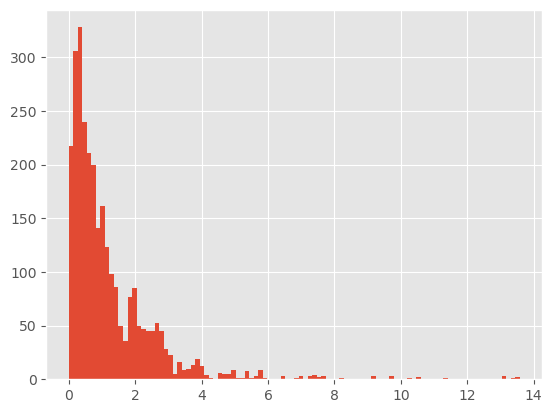

In [145]:
df_close['done_time_diff'].abs().hist(bins=100)

In [127]:
ccy = 'ETH'
st='2025-11-05'
et='2025-11-05'
# train_st='2025-07-01'
# train_et='2025-07-18'
exchange1='binance' 
market1='swap'
exchange2='okx'     
market2='swap'
open_quantile = 0.95
close_quantile = 0.05
order_type = 'MT'
data_source = "nuts_mm"
def read_cf_depth_backtesting(ccy, start_date, end_date, exchange1, market1, exchange2, market2, data_source, isUseLocalTime = False):

    if data_source == 'nuts_mm':
        market1_depth_path = f'/Volumes/T7/data/{exchange1}/perp/books/{ccy}'
        market2_depth_path = f'/Volumes/T7/data/{exchange2}/perp/books/{ccy}'
        market1_depth = pd.concat([pd.read_parquet(f'{market1_depth_path}/{ccy}usdt_{dd}_depth5.parquet')
                            for dd in pd.date_range(start_date, end_date).strftime('%Y-%m-%d')])        
        market2_depth = pd.concat([pd.read_parquet(f'{market2_depth_path}/{ccy}usdt_{dd}_depth5.parquet')
                            for dd in pd.date_range(start_date, end_date).strftime('%Y-%m-%d')])
    if isUseLocalTime:
        time_col = 'received_time'
        market1_depth[time_col] = pd.to_datetime(market1_depth[time_col])
        market2_depth[time_col] = pd.to_datetime(market2_depth[time_col])
    else:
        time_col = 'T'
        market1_depth[time_col] = pd.to_datetime(market1_depth[time_col], unit='ms')
        market2_depth[time_col] = pd.to_datetime(market2_depth[time_col], unit='ms')

    market1_depth.set_index(time_col, inplace=True)
    market1_depth['ws_type'] = "market1_depth"
    # market1_depth.drop_duplicates(inplace=True)


    market2_depth.set_index(time_col, inplace=True)
    market2_depth['ws_type'] = "market2_depth"
    # market2_depth.drop_duplicates(inplace=True)
    


    ########################################################################################
    # 04-21修改： 改用merge_asof
    # 保证时间索引已经在 column 中（因为 merge_asof 不能用 index 作为 on）
    market1_depth = market1_depth.reset_index()
    market2_depth = market2_depth.reset_index()

    merged_time = pd.Series(
        sorted(set(market1_depth[time_col]) | set(market2_depth[time_col]))
    )


    market1_depth_full = pd.merge_asof(merged_time.to_frame(time_col), market1_depth.sort_values(time_col),
                            on=time_col, direction='backward',tolerance=pd.Timedelta('100ms'))
    market2_depth_full = pd.merge_asof(merged_time.to_frame(time_col), market2_depth.sort_values(time_col),
                            on=time_col, direction='backward',tolerance=pd.Timedelta('100ms'))
                            
    merged_depth = pd.concat(
        [market1_depth_full.add_prefix('market1_'), market2_depth_full.add_prefix('market2_')], axis=1
    )
    merged_depth[time_col] = merged_time.values
    merged_depth['sr_open'] = (merged_depth['market2_ask_price0']/merged_depth['market1_ask_price0']-1)*10000
    merged_depth['sr_close'] = (merged_depth['market2_bid_price0']/merged_depth['market1_bid_price0']-1)*10000
    cf_depth = merged_depth.dropna()

    cf_depth.reset_index(inplace=True)
    cf_depth.set_index(time_col, inplace=True)
    if not isUseLocalTime:
        beijing_time = cf_depth.index.tz_localize('UTC').tz_convert('Asia/Shanghai').tz_localize(None)
        cf_depth['beijing_time'] = beijing_time
    else:
        cf_depth['beijing_time'] = cf_depth.index
        
    cf_depth = cf_depth.sort_index()
    # rolling('5s') 表示时间窗口5秒；center=False表示只看过去
    cf_depth['sr_open_median_5s'] = cf_depth['sr_open'].rolling('5s').median()/10000
    cf_depth['sr_open_median_10s'] = cf_depth['sr_open'].rolling('10s').median()/10000
    cf_depth['sr_open_median_30s'] = cf_depth['sr_open'].rolling('30s').median()/10000
    cf_depth['sr_close_median_5s'] = cf_depth['sr_close'].rolling('5s').median()/10000
    cf_depth['sr_close_median_10s'] = cf_depth['sr_close'].rolling('10s').median()/10000
    cf_depth['sr_close_median_30s'] = cf_depth['sr_close'].rolling('30s').median()/10000
    return cf_depth
def read_cf_depth(ccy, start_date, end_date, exchange1, market1, exchange2, market2, data_source):
    if data_source == 'inner_win':
        market1_depth_path = f'/Users/rayxu/Desktop/Obentech/dcdlData/{exchange1}/books/{ccy}/{market1}'
        market2_depth_path = f'/Users/rayxu/Desktop/Obentech/dcdlData/{exchange2}/books/{ccy}/{market2}'
    elif data_source == 'outer_ssd':
        market1_depth_path = f'/Volumes/T7/Obentech/dcdlData/{exchange1}/books/{ccy}/{market1}'
        market2_depth_path = f'/Volumes/T7/Obentech/dcdlData/{exchange2}/books/{ccy}/{market2}'
    elif data_source == 'nuts_mm':
        market1_depth_path = f'/Volumes/T7/data/{exchange1}/perp/books/{ccy}'
        market2_depth_path = f'/Volumes/T7/data/{exchange2}/perp/books/{ccy}'
    # if data_source == 'nuts_am_on_mac':
    #     market1_depth_path = f'/Users/rayxu/Downloads/nuts_am/data/{exchange1}/perp/books/{ccy}'
    #     market2_depth_path = f'/Users/rayxu/Downloads/nuts_am/data/{exchange2}/perp/books/{ccy}'
        market1_depth = pd.concat([pd.read_parquet(f'{market1_depth_path}/{ccy}usdt_{dd}_depth5.parquet')
                            for dd in pd.date_range(start_date, end_date).strftime('%Y-%m-%d')])        
        market2_depth = pd.concat([pd.read_parquet(f'{market2_depth_path}/{ccy}usdt_{dd}_depth5.parquet')
                            for dd in pd.date_range(start_date, end_date).strftime('%Y-%m-%d')])
    # else:
    #     market1_depth = pd.concat([pd.read_csv(f'{market1_depth_path}/{ccy}usdt_{dd}_depth5.csv')
    #                       for dd in pd.date_range(start_date, end_date).strftime('%Y-%m-%d')])        
    #     market2_depth = pd.concat([pd.read_csv(f'{market2_depth_path}/{ccy}usdt_{dd}_depth5.csv')
    #                       for dd in pd.date_range(start_date, end_date).strftime('%Y-%m-%d')])

    time_col = get_time_col(exchange1,exchange2)
    market1_depth[time_col] = pd.to_datetime(market1_depth[time_col], unit = 'ms')
    market1_depth.set_index(time_col, inplace=True)
    market1_depth['ws_type'] = "market1_depth"
    market1_depth.drop_duplicates(inplace=True)


    market2_depth[time_col] = pd.to_datetime(market2_depth[time_col], unit = 'ms')
    market2_depth.set_index(time_col, inplace=True)
    market2_depth['ws_type'] = "market2_depth"
    market2_depth.drop_duplicates(inplace=True)
    
    market1_depth.columns = rename_columns(list(market1_depth.columns), 'market1_')
    market2_depth.columns = rename_columns(list(market2_depth.columns), 'market2_')
    ########################################################################################
    # 04-21修改： 改用merge_asof
    # 保证时间索引已经在 column 中（因为 merge_asof 不能用 index 作为 on）
    market1_depth = market1_depth.reset_index()
    market2_depth = market2_depth.reset_index()

    # 使用 merge_asof 精准时间对齐，100ms 容差，向后对齐
    cf_depth = pd.merge_asof(
        market1_depth.sort_values(time_col),
        market2_depth.sort_values(time_col),
        on=time_col,
        direction='backward',
        tolerance=pd.Timedelta('100ms'),
        suffixes=('_market1', '_market2')
    )

    cf_depth[['market1_ws_type', 'market2_ws_type']] = cf_depth[['market1_ws_type', 'market2_ws_type']].fillna('')
    cf_depth['ws_type'] = cf_depth['market1_ws_type'] + cf_depth['market2_ws_type']
    
    cf_depth.dropna(inplace=True)
    cf_depth = cf_depth.fillna(method='ffill').assign(
        # sp_open=lambda df: df['market2_bid_price1']-df['market1_ask_price1'],
        # sp_close=lambda df: df['market2_ask_price1']-df['market1_bid_price1'],
        sr_open=lambda df: df['market2_ask_price1']/df['market1_bid_price1']-1,
        sr_close=lambda df: df['market2_bid_price1']/df['market1_ask_price1']-1,
        # 用midprice计算
        midprice=lambda df: (df['market1_bid_price1'] + df['market1_ask_price1']) / 2
    )

    # # 计算过去N个tick的收益率（用midprice）
    # for n in [10, 50, 100, 300, 600]:
    #     cf_depth[f'ret_mid_{n/10}s'] = cf_depth['midprice'].pct_change(periods=n)
    #     cf_depth[f'logret_mid_{n/10}s'] = np.log(cf_depth['midprice'] / cf_depth['midprice'].shift(n))
    
    cf_depth.reset_index(inplace=True)
    # cf_depth['received_time_diff_1jump_later'] = cf_depth[time_col].shift(-1) - cf_depth[time_col]
    # cf_depth['received_time_diff_1jump_later'] = cf_depth['received_time_diff_1jump_later'].apply(lambda x:x.total_seconds())
    cf_depth.set_index(time_col, inplace=True)
    beijing_time = cf_depth.index.tz_localize('UTC').tz_convert('Asia/Shanghai').tz_localize(None)
    cf_depth['beijing_time'] = beijing_time
    cf_depth_st_index = cf_depth.index[0]
    cf_depth_et_index = cf_depth.index[-1]
    cf_depth['sr_open_median_5s'] = cf_depth['sr_open'].rolling('5s').median()
    cf_depth['sr_open_median_10s'] = cf_depth['sr_open'].rolling('10s').median()
    cf_depth['sr_open_median_30s'] = cf_depth['sr_open'].rolling('30s').median()
    cf_depth['sr_close_median_5s'] = cf_depth['sr_close'].rolling('5s').median()
    cf_depth['sr_close_median_10s'] = cf_depth['sr_close'].rolling('10s').median()
    cf_depth['sr_close_median_30s'] = cf_depth['sr_close'].rolling('30s').median()
    return cf_depth


cf_depth = read_cf_depth(ccy, st, et, exchange1, market1, exchange2, market2, data_source=data_source)

In [124]:
pd.read_csv('/Users/rayxu/Downloads/binancecross1_okex5.ETH.csv').columns

Index(['spot_ask0_amount', 'spot_ask0_price', 'spot_ask1_amount',
       'spot_ask1_price', 'spot_ask2_amount', 'spot_ask2_price',
       'spot_ask3_amount', 'spot_ask3_price', 'spot_ask4_amount',
       'spot_ask4_price', 'spot_bid0_amount', 'spot_bid0_price',
       'spot_bid1_amount', 'spot_bid1_price', 'spot_bid2_amount',
       'spot_bid2_price', 'spot_bid3_amount', 'spot_bid3_price',
       'spot_bid4_amount', 'spot_bid4_price', 'spot_id', 'spot_timestamp',
       'swap_ask0_amount', 'swap_ask0_price', 'swap_ask1_amount',
       'swap_ask1_price', 'swap_ask2_amount', 'swap_ask2_price',
       'swap_ask3_amount', 'swap_ask3_price', 'swap_ask4_amount',
       'swap_ask4_price', 'swap_bid0_amount', 'swap_bid0_price',
       'swap_bid1_amount', 'swap_bid1_price', 'swap_bid2_amount',
       'swap_bid2_price', 'swap_bid3_amount', 'swap_bid3_price',
       'swap_bid4_amount', 'swap_bid4_price', 'swap_id', 'swap_timestamp'],
      dtype='object')

In [148]:
# df = pd.read_csv('/Users/rayxu/Downloads/binancecross1_okex5.ETH.csv')
df = pd.read_csv('/Users/rayxu/Downloads/binancecross1_okex5.ETH-20251105.csv.gz')
df = df[['spot_ask0_amount', 'spot_ask0_price', 'spot_bid0_amount', 'spot_bid0_price', 'spot_timestamp',
       'swap_ask0_amount', 'swap_ask0_price', 'swap_bid0_amount', 'swap_bid0_price','swap_timestamp']].rename(columns={'spot_ask0_price':'market1_ask_price0', 'spot_bid0_price':'market1_bid_price0', 'swap_ask0_price':'market2_ask_price0', 'swap_bid0_price':'market2_bid_price0', 'spot_timestamp':'market1_timestamp', 'swap_timestamp':'market2_timestamp'})
df['market2_timestamp'] = df['market2_timestamp'].apply(parse_start_time)
df['market1_timestamp'] = df['market1_timestamp'].apply(parse_start_time)
df['ESRA'] = df['market2_ask_price0']/df['market1_ask_price0']-1
df['ESRB'] = df['market2_bid_price0']/df['market1_bid_price0']-1

In [156]:
df_close[df_close['slippage'] < -0.00005]['done_time_diff'].abs().describe()

count   2437.000000
mean       1.295799
std        1.459100
min        0.027000
25%        0.380000
50%        0.835000
75%        1.811000
max       13.584000
Name: done_time_diff, dtype: float64

In [155]:
df_close[df_close['slippage'] > -0.00005]['done_time_diff'].abs().describe()

count   431.000000
mean      0.703773
std       0.672964
min       0.001000
25%       0.236000
50%       0.476000
75%       1.011000
max       3.770000
Name: done_time_diff, dtype: float64

In [135]:
df_open

pos_id                                              start  \
8851  251105_075353_18538  2025-11-05 07:53:53.574761641 +0800 CST m=+179...   
8852  251105_075353_18537  2025-11-05 07:53:53.57467208 +0800 CST m=+1792...   
8853  251105_075359_18549  2025-11-05 07:53:59.40443876 +0800 CST m=+1793...   
8854  251105_075401_18556  2025-11-05 07:54:01.956519374 +0800 CST m=+179...   
8855  251105_075401_18555  2025-11-05 07:54:01.942631573 +0800 CST m=+179...   
...                   ...                                                ...   
9784  251105_115014_22968  2025-11-05 11:50:14.974089113 +0800 CST m=+321...   
9785  251105_115014_22966  2025-11-05 11:50:14.968549533 +0800 CST m=+321...   
9786  251105_115016_22970  2025-11-05 11:50:16.421594081 +0800 CST m=+321...   
9787  251105_115016_22969  2025-11-05 11:50:16.421145652 +0800 CST m=+321...   
9788  251105_115016_22971  2025-11-05 11:50:16.422782942 +0800 CST m=+321...   

       sr_open  open_trade_unit   open_usdt  sr_open_real  \
8851 -0.000212         0.579000 1908.795090     -0.000133   
8852 -0.000212         0.579000 1908.795090     -0.000133   
8853 -0.000309         0.579000 1908.447690     -0.000046   
8854 -0.000234         0.580000 1911.366800     -0.000046   
8855 -0.000234         0.580000 1911.366800     -0.000042   
...        ...              ...         ...           ...   
9784 -0.000204         0.573000 1908.554130      0.000099   
9785 -0.000204         0.573000 1908.554130      0.000099   
9786 -0.000228         0.573000 1909.218810     -0.000228   
9787 -0.000228         0.573000 1909.218810     -0.000228   
9788 -0.000228         0.573000 1909.218810     -0.000228   

                 swap1_order_id  swap1_avg_price  swap1_deal_amount  \
8851 8389766006898979840.000000      3296.450000           0.579000   
8852 8389766006898979840.000000      3296.450000           0.059000   
8853 8389766006899073024.000000      3296.110000           0.510000   
8854 8389766006899117056.000000      3294.500000           0.580000   
8855 8389766006899116032.000000      3294.830000           0.580000   
...                         ...              ...                ...   
9784 8389766007123877888.000000      3330.810000           0.573000   
9785 8389766007123877888.000000      3330.810000           0.573000   
9786 8389766007123909632.000000      3331.970000           0.573000   
9787 8389766007123909632.000000      3331.970000           0.573000   
9788 8389766007123909632.000000      3331.970000           0.573000   

     swap1_side  swap1_fee swap1_fee_currency swap1_is_maker  \
8851       sell   0.095432               USDT          False   
8852       sell   0.009725               USDT          False   
8853       sell  -0.322755               USDT          False   
8854       sell   0.095541               USDT          False   
8855       sell   0.095550               USDT          False   
...         ...        ...                ...            ...   
9784       sell   0.095428               USDT          False   
9785       sell   0.095428               USDT          False   
9786       sell   0.095461               USDT          False   
9787       sell   0.095461               USDT          False   
9788       sell   0.095461               USDT          False   

                                        swap1_open_time  \
8851  2025-11-05 07:53:53.633525571 +0800 CST m=+179...   
8852  2025-11-05 07:53:53.63055992 +0800 CST m=+1792...   
8853                  2025-11-05 07:53:59.529 +0800 CST   
8854                  2025-11-05 07:54:02.072 +0800 CST   
8855                  2025-11-05 07:54:02.059 +0800 CST   
...                                                 ...   
9784  2025-11-05 11:50:15.032366282 +0800 CST m=+321...   
9785  2025-11-05 11:50:15.025303641 +0800 CST m=+321...   
9786  2025-11-05 11:50:16.483001345 +0800 CST m=+321...   
9787  2025-11-05 11:50:16.47841699 +0800 CST m=+3210...   
9788  2025-11-05 11:50:16.487436734 +0800 CST m=+321..

In [149]:
df_open['done_time_diff'].abs().describe()

count   938.000000
mean      1.763039
std       3.291608
min       0.002000
25%       0.414000
50%       1.059500
75%       2.085750
max      48.853000
Name: done_time_diff, dtype: float64

In [128]:
cf_depth

index    market1_received_time      market1_E  \
T                                                                         
2025-11-04 16:00:00.096       0  2025-11-05 00:00:31.410  1762272000096   
2025-11-04 16:00:35.141      40  2025-11-05 00:00:35.250  1762272035141   
2025-11-04 16:00:35.255      41  2025-11-05 00:00:35.349  1762272035256   
2025-11-04 16:00:35.375      42  2025-11-05 00:00:35.449  1762272035376   
2025-11-04 16:00:35.484      43  2025-11-05 00:00:35.549  1762272035486   
...                         ...                      ...            ...   
2025-11-05 15:59:59.417  863455  2025-11-05 23:59:59.549  1762358399420   
2025-11-05 15:59:59.552  863456  2025-11-05 23:59:59.649  1762358399553   
2025-11-05 15:59:59.666  863457  2025-11-05 23:59:59.749  1762358399668   
2025-11-05 15:59:59.764  863458  2025-11-05 23:59:59.849  1762358399772   
2025-11-05 15:59:59.882  863459  2025-11-05 23:59:59.949  1762358399883   

                         market1_bid_price0  market1_bid_size0  \
T                                                                
2025-11-04 16:00:00.096         3505.990000         104.885000   
2025-11-04 16:00:35.141         3513.590000          57.803000   
2025-11-04 16:00:35.255         3513.590000          65.361000   
2025-11-04 16:00:35.375         3513.590000          66.663000   
2025-11-04 16:00:35.484         3513.590000          66.788000   
...                                     ...                ...   
2025-11-05 15:59:59.417         3396.310000          36.347000   
2025-11-05 15:59:59.552         3396.310000          35.560000   
2025-11-05 15:59:59.666         3396.310000          20.806000   
2025-11-05 15:59:59.764         3396.310000          12.930000   
2025-11-05 15:59:59.882         3396.310000          30.607000   

                         market1_bid_price1  market1_bid_size1  \
T                                                                
2025-11-04 16:00:00.096         3505.980000           0.012000   
2025-11-04 16:00:35.141         3513.580000          13.094000   
2025-11-04 16:00:35.255         3513.580000          13.378000   
2025-11-04 16:00:35.375         3513.580000          13.378000   
2025-11-04 16:00:35.484         3513.580000          13.378000   
...                                     ...                ...   
2025-11-05 15:59:59.417         3396.300000           0.120000   
2025-11-05 15:59:59.552         3396.300000           0.120000   
2025-11-05 15:59:59.666         3396.300000           0.120000   
2025-11-05 15:59:59.764         3396.300000           0.120000   
2025-11-05 15:59:59.882         3396.300000           4.827000   

                         market1_bid_price2  market1_bid_size2  \
T                                                                
2025-11-04 16:00:00.096         3505.970000           0.034000   
2025-11-04 16:00:35.141         3513.570000           0.024000   
2025-11-04 16:00:35.255         3513.570000           0.024000   
2025-11-04 16:00:35.375         3513.570000           0.024000   
2025-11-04 16:00:35.484         3513.570000           0.024000   
...                                     ...                ...   
2025-11-05 15:59:59.417         3396.290000           1.106000   
2025-11-05 15:59:59.552         3396.290000           1.106000   
2025-11-05 15:59:59.666         3396.290000           1.106000   
2025-11-05 15:59:59.764         3396.290000           1.230000   
2025-11-05 15:59:59.882         3396.290000          27.061000   

                         market1_bid_price3  market1_bid_size3  \
T                                                                
2025-11-04 16:00:00.096         3505.960000           0.475000   
2025-11-04 16:00:35.141         3513.560000           0.284000   
2025-11-04 16:00:35.255         3513.560000           0.284000   
2025-11-04 16:00:35.375         3513.560000           0.284000   
2025-11-04 16:00:35.484         3513.560000           0.284000   
...        

In [ ]:
# 用plotly把cf_depth的market1_ask_price0和market1_timestamp画出来
fig = go.Figure()

# —— Spread 曲线（左侧 y 轴）——
# fig.add_trace(go.Scatter(
#     x=df['market1_timestamp'],
#     y=df['ESRA'],
#     mode='lines',
#     name='Spread (bps)',
#     line=dict(color='purple'),
#     yaxis='y1'
# ))

# —— 价格曲线（右侧 y 轴）——
fig.add_trace(go.Scatter(
    x=df['market1_timestamp'],
    y=df['market1_ask_price0'],
    mode='lines',
    name=f'binance ask',
    yaxis='y2'
))
fig.add_trace(go.Scatter(
    x=df['market1_timestamp'],
    y=df['market2_ask_price0'],
    mode='lines',
    name=f'okx ask',
    yaxis='y2'
))

# 布局：定义两个纵轴
fig.update_layout(
    # title=f'Spread & Prices',
    # xaxis=dict(title='Time (Beijing)'),
    # yaxis=dict(
    #     title='Spread (bps)',
    #     side='left',
    #     showgrid=False,
    # ),
    # yaxis2=dict(
    #     title='Price',
    #     overlaying='y',
    #     side='right',
    #     showgrid=False,
    # ),
    hovermode='x unified',
    height=1200,
    width=2400,
    legend=dict(x=0.01, y=0.99)
)

fig.show()


In [147]:
df[df['market2_timestamp'] > pd.to_datetime('2025-11-05 07:53:59')].head(20)

spot_ask0_amount  market1_ask_price0  spot_bid0_amount  \
543550         34.791000         3296.880000          2.413000   
543551         51.802000         3296.780000          0.119000   
543552         32.575000         3296.490000          0.084000   
543553         22.185000         3296.310000          0.369000   
543554          8.091000         3296.200000          0.030000   
543555         29.057000         3296.110000          0.427000   
543556         27.858000         3296.110000          2.216000   
543557          3.707000         3296.980000          2.314000   
543558         15.232000         3296.270000          0.036000   
543559         21.583000         3296.120000         17.889000   
543560         21.508000         3296.120000         18.223000   
543561         25.712000         3296.120000         17.749000   
543562         25.712000         3296.120000          7.129000   
543563         24.259000         3295.970000         16.335000   
543564         24.243000         3295.970000         16.335000   
543565         13.868000         3295.970000         19.070000   
543566         13.868000         3295.970000         19.070000   
543567         13.067000         3295.970000         19.307000   
543568         13.067000         3295.970000         29.927000   
543569         17.534000         3295.970000         33.994000   

        market1_bid_price0       market1_timestamp  swap_ask0_amount  \
543550         3296.870000 2025-11-05 07:53:58.987         34.526000   
543551         3296.770000 2025-11-05 07:53:59.034         30.502000   
543552         3296.480000 2025-11-05 07:53:59.089         20.479000   
543553         3296.300000 2025-11-05 07:53:59.136         47.011000   
543554         3296.190000 2025-11-05 07:53:59.197         36.322000   
543555         3296.100000 2025-11-05 07:53:59.238         18.962000   
543556         3296.100000 2025-11-05 07:53:59.300         18.331000   
543557         3296.100000 2025-11-05 07:53:59.324         19.238000   
543558         3296.220000 2025-11-05 07:53:59.390         20.663000   
543559         3296.110000 2025-11-05 07:53:59.475         45.477000   
543560         3296.110000 2025-11-05 07:53:59.484         42.795000   
543561         3296.110000 2025-11-05 07:53:59.577         41.297000   
543562         3296.110000 2025-11-05 07:53:59.584         41.297000   
543563         3295.960000 2025-11-05 07:53:59.685         37.187000   
543564         3295.960000 2025-11-05 07:53:59.685         37.187000   
543565         3295.960000 2025-11-05 07:53:59.780         38.510000   
543566         3295.960000 2025-11-05 07:53:59.787         38.510000   
543567         3295.960000 2025-11-05 07:53:59.877         38.602000   
543568         3295.960000 2025-11-05 07:53:59.890         38.596000   
543569         3295.960000 2025-11-05 07:53:59.970         36.611000   

        market2_ask_price0  swap_bid0_amount  market2_bid_price0  \
543550         3296.320000          1.707000         3296.310000   
543551         3296.130000          1.735000         3296.120000   
543552         3296.130000          1.172000         3296.120000   
543553         3295.670000          0.039000         3295.660000   
543554         3295.470000         13.526000         3295.460000   
543555         3295.470000         13.022000         3295.460000   
543556         3295.470000         12.730000         3295.460000   
543557         3295.970000          0.016000         3295.960000   
543558         3295.970000          0.595000         3295.960000   
543559         3295.570000          3.851000         3295.560000   
543560         3295.570000          6.096000         3295.560000   
543561         3295.570000         13.619000         3295.560000   
543562         3295.570000         13.619000         3295.560000   
543563         3295.570000          6.071000         3295.560000   
543564         3295.570000          6.071000         3295.560000   
543565         3295.

# 实验1105： pro7和pro13引入更长的replace

In [ ]:
import pandas as pd


symbol = 'ETH'
env_list = ['pro1','pro2','pro3','pro4','pro5', 'pro8','pro9', 'pro12','pro15','pro16','pro17']
# env_list = ['pro16']
replace_dict = {
'pro1': 'msecs500 replace1 normal', 
'pro2': 'msecs2000 replac40 median',
'pro3': 'msecs2000 replace10 median',
'pro4': 'msecs10000 replace40 median',

'pro5': 'msecs10000 replace1 median', 
'pro7': 'msecs10000 replac120 median',
'pro8': 'msecs10000 replace10 median',
'pro9': 'msecs5000 replace1 median',
'pro12': 'msecs5000 replace40 median',


'pro13': 'msecs5000 replace300 median',
'pro15': 'msecs5000 replace10 median',
'pro16': 'msecs30000 replace1 median',
'pro17': 'msecs2000 replace1 median',

'pro14':'tbd'}

start_date = '2025-11-04 16:00:00'
end_date = '2025-11-10 02:30:00'

# start_date = '2025-11-05 00:00:00'
# end_date = '2025-11-06 07:15:00'

summary = []

for env in env_list:
    file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.close.csv'
    file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.open.csv'
    slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


    # 创建子图  
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

    # 分析卖出滑点
    sell_slippage = short_slippage['slippage']
    sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
    ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
    ax1.set_xlabel('Slippage')
    ax1.set_ylabel('Frequency')
    sell_mean = sell_slippage.mean()
    sell_std = sell_slippage.std()
    ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
    ax1.legend()
    # print('sell count', len(sell_slippage))


    # 分析买入滑点
    buy_slippage = long_slippage['slippage']
    buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
    ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
    ax2.set_xlabel('Slippage')
    ax2.set_ylabel('Frequency')
    buy_mean = buy_slippage.mean()
    buy_std = buy_slippage.std()
    ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
    ax2.legend()
    # print('buy count', len(buy_slippage))

    # overall滑点分布
    slippage_array = slippage_df_selected['slippage'].values
    slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
    ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
    ax3.set_xlabel('Slippage')
    ax3.set_ylabel('Frequency')
    overall_mean = slippage_array.mean()
    ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    stats = {
        'symbol': symbol,
        'env': env,
        'replace': replace_dict[env],
        'count': len(slippage_array),
        'mean': np.mean(slippage_array),
        'median': np.median(slippage_array),
        'std': np.std(slippage_array),
        'min': np.min(slippage_array),
        'max': np.max(slippage_array),
        # 'percentile_1': np.percentile(slippage_array, 1),
        'percentile_5': np.percentile(slippage_array, 5),
        'percentile_10': np.percentile(slippage_array, 10),
        'percentile_25': np.percentile(slippage_array, 25),
        'percentile_50': np.percentile(slippage_array, 50),
        # 'percentile_55': np.percentile(slippage_array, 55),        
        'percentile_60': np.percentile(slippage_array, 60),
        # 'percentile_65': np.percentile(slippage_array, 65),
        'percentile_75': np.percentile(slippage_array, 75),
        'percentile_95': np.percentile(slippage_array, 95),
        # 'percentile_99': np.percentile(slippage_array, 99),
        'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
        'BNFirstSlippage_count': len(Exchange1FirstSlippage),
        'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
        'OKFirstSlippage_count': len(Exchange2FirstSlippage),
    }

    summary.append(stats)

df = pd.DataFrame(summary).set_index('env')
df

In [ ]:
import pandas as pd


symbol = 'ETH'
env_list = ['pro1','pro2','pro3','pro4','pro5','pro7', 'pro8','pro9', 'pro12','pro13','pro15','pro16','pro17']
# env_list = ['pro16']
replace_dict = {
'pro1': 'msecs500 replace1 normal', 
'pro2': 'msecs2000 replac40 median',
'pro3': 'msecs2000 replace10 median',
'pro4': 'msecs10000 replace40 median',

'pro5': 'msecs10000 replace1 median', 
'pro7': 'msecs10000 replac120 median',
'pro8': 'msecs10000 replace10 median',
'pro9': 'msecs5000 replace1 median',
'pro12': 'msecs5000 replace40 median',


'pro13': 'msecs5000 replace300 median',
'pro15': 'msecs5000 replace10 median',
'pro16': 'msecs30000 replace1 median',
'pro17': 'msecs2000 replace1 median',

'pro14':'tbd'}

start_date = '2025-11-06 15:28:00'
end_date = '2025-11-13 10:00:00'

# start_date = '2025-11-05 00:00:00'
# end_date = '2025-11-06 07:15:00'

summary = []

for env in env_list:
    file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.close.csv'
    file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.open.csv'
    slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


    # 创建子图  
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

    # 分析卖出滑点
    sell_slippage = short_slippage['slippage']
    sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
    ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
    ax1.set_xlabel('Slippage')
    ax1.set_ylabel('Frequency')
    sell_mean = sell_slippage.mean()
    sell_std = sell_slippage.std()
    ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
    ax1.legend()
    # print('sell count', len(sell_slippage))


    # 分析买入滑点
    buy_slippage = long_slippage['slippage']
    buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
    ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
    ax2.set_xlabel('Slippage')
    ax2.set_ylabel('Frequency')
    buy_mean = buy_slippage.mean()
    buy_std = buy_slippage.std()
    ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
    ax2.legend()
    # print('buy count', len(buy_slippage))

    # overall滑点分布
    slippage_array = slippage_df_selected['slippage'].values
    slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
    ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
    ax3.set_xlabel('Slippage')
    ax3.set_ylabel('Frequency')
    overall_mean = slippage_array.mean()
    ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    stats = {
        'symbol': symbol,
        'env': env,
        'replace': replace_dict[env],
        'count': len(slippage_array),
        'mean': np.mean(slippage_array),
        'median': np.median(slippage_array),
        'std': np.std(slippage_array),
        'min': np.min(slippage_array),
        'max': np.max(slippage_array),
        # 'percentile_1': np.percentile(slippage_array, 1),
        'percentile_5': np.percentile(slippage_array, 5),
        'percentile_10': np.percentile(slippage_array, 10),
        'percentile_25': np.percentile(slippage_array, 25),
        'percentile_50': np.percentile(slippage_array, 50),
        # 'percentile_55': np.percentile(slippage_array, 55),        
        'percentile_60': np.percentile(slippage_array, 60),
        # 'percentile_65': np.percentile(slippage_array, 65),
        'percentile_75': np.percentile(slippage_array, 75),
        'percentile_95': np.percentile(slippage_array, 95),
        # 'percentile_99': np.percentile(slippage_array, 99),
        'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
        'BNFirstSlippage_count': len(Exchange1FirstSlippage),
        'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
        'OKFirstSlippage_count': len(Exchange2FirstSlippage),
    }

    summary.append(stats)

df = pd.DataFrame(summary).set_index('env')
df

# 1111

In [ ]:
import pandas as pd


symbol = 'ETH'
env_list = ['pro1','pro2','pro3','pro4','pro5','pro7', 'pro8','pro9', 'pro12','pro13','pro15','pro16','pro17']
# env_list = ['pro16']
replace_dict = {
'pro1': 'msecs500 replace1 normal', 
'pro2': 'msecs2000 replac40 median',
'pro3': 'msecs2000 replace10 median',
'pro4': 'msecs10000 replace40 median',

'pro5': 'msecs10000 replace1 median', 
'pro7': 'msecs10000 replac120 median',
'pro8': 'msecs10000 replace10 median',
'pro9': 'msecs5000 replace1 median',
'pro12': 'msecs5000 replace40 median',


'pro13': 'msecs5000 replace300 median',
'pro15': 'msecs5000 replace10 median',
'pro16': 'msecs10000 replace1 median abnormal 0.0002',
'pro17': 'msecs2000 replace1 median',

'pro14':'tbd'}

start_date = '2025-11-11 23:02:00'
end_date = '2025-11-13 23:02:00'

summary = []

for env in env_list:
    file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.close.csv'
    file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.open.csv'
    slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


    # 创建子图  
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

    # 分析卖出滑点
    sell_slippage = short_slippage['slippage']
    sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
    ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
    ax1.set_xlabel('Slippage')
    ax1.set_ylabel('Frequency')
    sell_mean = sell_slippage.mean()
    sell_std = sell_slippage.std()
    ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
    ax1.legend()
    # print('sell count', len(sell_slippage))


    # 分析买入滑点
    buy_slippage = long_slippage['slippage']
    buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
    ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
    ax2.set_xlabel('Slippage')
    ax2.set_ylabel('Frequency')
    buy_mean = buy_slippage.mean()
    buy_std = buy_slippage.std()
    ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
    ax2.legend()
    # print('buy count', len(buy_slippage))

    # overall滑点分布
    slippage_array = slippage_df_selected['slippage'].values
    slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
    ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
    ax3.set_xlabel('Slippage')
    ax3.set_ylabel('Frequency')
    overall_mean = slippage_array.mean()
    ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    stats = {
        'symbol': symbol,
        'env': env,
        'replace': replace_dict[env],
        'count': len(slippage_array),
        'mean': np.mean(slippage_array),
        'median': np.median(slippage_array),
        'std': np.std(slippage_array),
        'min': np.min(slippage_array),
        'max': np.max(slippage_array),
        # 'percentile_1': np.percentile(slippage_array, 1),
        'percentile_5': np.percentile(slippage_array, 5),
        'percentile_10': np.percentile(slippage_array, 10),
        'percentile_25': np.percentile(slippage_array, 25),
        'percentile_50': np.percentile(slippage_array, 50),
        # 'percentile_55': np.percentile(slippage_array, 55),        
        'percentile_60': np.percentile(slippage_array, 60),
        # 'percentile_65': np.percentile(slippage_array, 65),
        'percentile_75': np.percentile(slippage_array, 75),
        'percentile_95': np.percentile(slippage_array, 95),
        # 'percentile_99': np.percentile(slippage_array, 99),
        'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
        'BNFirstSlippage_count': len(Exchange1FirstSlippage),
        'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
        'OKFirstSlippage_count': len(Exchange2FirstSlippage),
    }

    summary.append(stats)

df = pd.DataFrame(summary).set_index('env')
df

In [166]:
file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.close.csv'
file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.open.csv'

In [169]:
df = pd.read_csv(file_path_1).tail(100)
df['slippage'] = df['sr_close_real'] - df['sr_close']

In [170]:
df['slippage'].mean()

-0.0002755272097078589

# 1113


In [ ]:
import pandas as pd


symbol = 'ETH'
env_list = ['pro1','pro2','pro3','pro4','pro5','pro7', 'pro8','pro9', 'pro12','pro13','pro15','pro16','pro17']
# env_list = ['pro16']
replace_dict = {
'pro1': 'msecs3000 replace1 median', 
'pro2': 'msecs2000 replace1 median',
'pro3': 'msecs5000 replace1 median',


'pro4': 'msecs3000 replace120 median',
'pro5': 'msecs10000 replace1 median', 
'pro7': 'msecs10000 replac120 median',
'pro8': 'msecs10000 replace300 median',
'pro9': 'msecs5000 replace1 median',
'pro12': 'msecs3000 replace300 median',


'pro13': 'msecs5000 replace300 median',
'pro15': 'msecs5000 replace120 median',
'pro16': 'msecs10000 replace1 median+cancel abnormal 0.0002', 
'pro17': 'msecs3000 replace1 median',

'pmpro': 'msecs3000 replace1 median',
'test4': 'msecs3000 replace300 10 median',
'pro14':'tbd'}

start_date = '2025-11-13 23:02:00'
end_date = '2025-11-19 15:34:00'

summary = []

for env in env_list:
    file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.close.csv'
    file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.open.csv'
    if env == 'pmpro':
        file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.close.csv'
        file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.open.csv'
    slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


    # 创建子图  
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

    # 分析卖出滑点
    sell_slippage = short_slippage['slippage']
    sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
    ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
    ax1.set_xlabel('Slippage')
    ax1.set_ylabel('Frequency')
    sell_mean = sell_slippage.mean()
    sell_std = sell_slippage.std()
    ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
    ax1.legend()
    # print('sell count', len(sell_slippage))


    # 分析买入滑点
    buy_slippage = long_slippage['slippage']
    buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
    ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
    ax2.set_xlabel('Slippage')
    ax2.set_ylabel('Frequency')
    buy_mean = buy_slippage.mean()
    buy_std = buy_slippage.std()
    ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
    ax2.legend()
    # print('buy count', len(buy_slippage))

    # overall滑点分布
    slippage_array = slippage_df_selected['slippage'].values
    slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
    ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
    ax3.set_xlabel('Slippage')
    ax3.set_ylabel('Frequency')
    overall_mean = slippage_array.mean()
    ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    stats = {
        'symbol': symbol,
        'env': env,
        'replace': replace_dict[env],
        'count': len(slippage_array),
        'mean': np.mean(slippage_array),
        'median': np.median(slippage_array),
        'std': np.std(slippage_array),
        'min': np.min(slippage_array),
        'max': np.max(slippage_array),
        # 'percentile_1': np.percentile(slippage_array, 1),
        'percentile_5': np.percentile(slippage_array, 5),
        'percentile_10': np.percentile(slippage_array, 10),
        'percentile_25': np.percentile(slippage_array, 25),
        'percentile_50': np.percentile(slippage_array, 50),
        # 'percentile_55': np.percentile(slippage_array, 55),        
        'percentile_60': np.percentile(slippage_array, 60),
        # 'percentile_65': np.percentile(slippage_array, 65),
        'percentile_75': np.percentile(slippage_array, 75),
        'percentile_95': np.percentile(slippage_array, 95),
        # 'percentile_99': np.percentile(slippage_array, 99),
        'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
        'BNFirstSlippage_count': len(Exchange1FirstSlippage),
        'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
        'OKFirstSlippage_count': len(Exchange2FirstSlippage),
    }

    summary.append(stats)

df = pd.DataFrame(summary).set_index('env')
df

# 1115

In [ ]:
import pandas as pd


symbol = 'ETH'
env_list = ['pro1','pro2','pro3','pro4','pro5','pro7', 'pro8','pro9', 'pro12','pro13','pro15','pro16','pro17','pmpro','test4']
env_list = ['pmpro','test4','pro1','pro12']
replace_dict = {
'pro1': 'msecs3000 replace1 median', 
'pro2': 'msecs2000 replace1 median',
'pro3': 'msecs5000 replace1 median',


'pro4': 'msecs3000 replace120 median',
'pro5': 'msecs10000 replace1 median', 
'pro7': 'msecs10000 replac120 median',
'pro8': 'msecs10000 replace300 median',
'pro9': 'msecs5000 replace1 median',
'pro12': 'msecs3000 replace300 median',


'pro13': 'msecs5000 replace300 median',
'pro15': 'msecs5000 replace120 median',
'pro16': 'msecs10000 replace1 median+cancel abnormal 0.0002', 
'pro17': 'msecs3000 replace1 median',

'pmpro': 'msecs3000 replace1 median',
'test4': 'msecs3000 replace300 10 median',
'pro14':'tbd'}

start_date = '2025-11-15 10:37:00'
end_date = '2025-11-19 15:34:00'

summary = []

for env in env_list:
    file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.close.csv'
    file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.open.csv'
    if env == 'pmpro':
        file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.close.csv'
        file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.open.csv'
    slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


    # 创建子图  
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

    # 分析卖出滑点
    sell_slippage = short_slippage['slippage']
    sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
    ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
    ax1.set_xlabel('Slippage')
    ax1.set_ylabel('Frequency')
    sell_mean = sell_slippage.mean()
    sell_std = sell_slippage.std()
    ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
    ax1.legend()
    # print('sell count', len(sell_slippage))


    # 分析买入滑点
    buy_slippage = long_slippage['slippage']
    buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
    ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
    ax2.set_xlabel('Slippage')
    ax2.set_ylabel('Frequency')
    buy_mean = buy_slippage.mean()
    buy_std = buy_slippage.std()
    ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
    ax2.legend()
    # print('buy count', len(buy_slippage))

    # overall滑点分布
    slippage_array = slippage_df_selected['slippage'].values
    slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
    ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
    ax3.set_xlabel('Slippage')
    ax3.set_ylabel('Frequency')
    overall_mean = slippage_array.mean()
    ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    stats = {
        'symbol': symbol,
        'env': env,
        'replace': replace_dict[env],
        'count': len(slippage_array),
        'mean': np.mean(slippage_array),
        'median': np.median(slippage_array),
        'std': np.std(slippage_array),
        'min': np.min(slippage_array),
        'max': np.max(slippage_array),
        # 'percentile_1': np.percentile(slippage_array, 1),
        'percentile_5': np.percentile(slippage_array, 5),
        'percentile_10': np.percentile(slippage_array, 10),
        'percentile_25': np.percentile(slippage_array, 25),
        'percentile_50': np.percentile(slippage_array, 50),
        # 'percentile_55': np.percentile(slippage_array, 55),        
        'percentile_60': np.percentile(slippage_array, 60),
        # 'percentile_65': np.percentile(slippage_array, 65),
        'percentile_75': np.percentile(slippage_array, 75),
        'percentile_95': np.percentile(slippage_array, 95),
        # 'percentile_99': np.percentile(slippage_array, 99),
        'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
        'BNFirstSlippage_count': len(Exchange1FirstSlippage),
        'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
        'OKFirstSlippage_count': len(Exchange2FirstSlippage),
    }

    summary.append(stats)

df = pd.DataFrame(summary).set_index('env')
df

# 1121

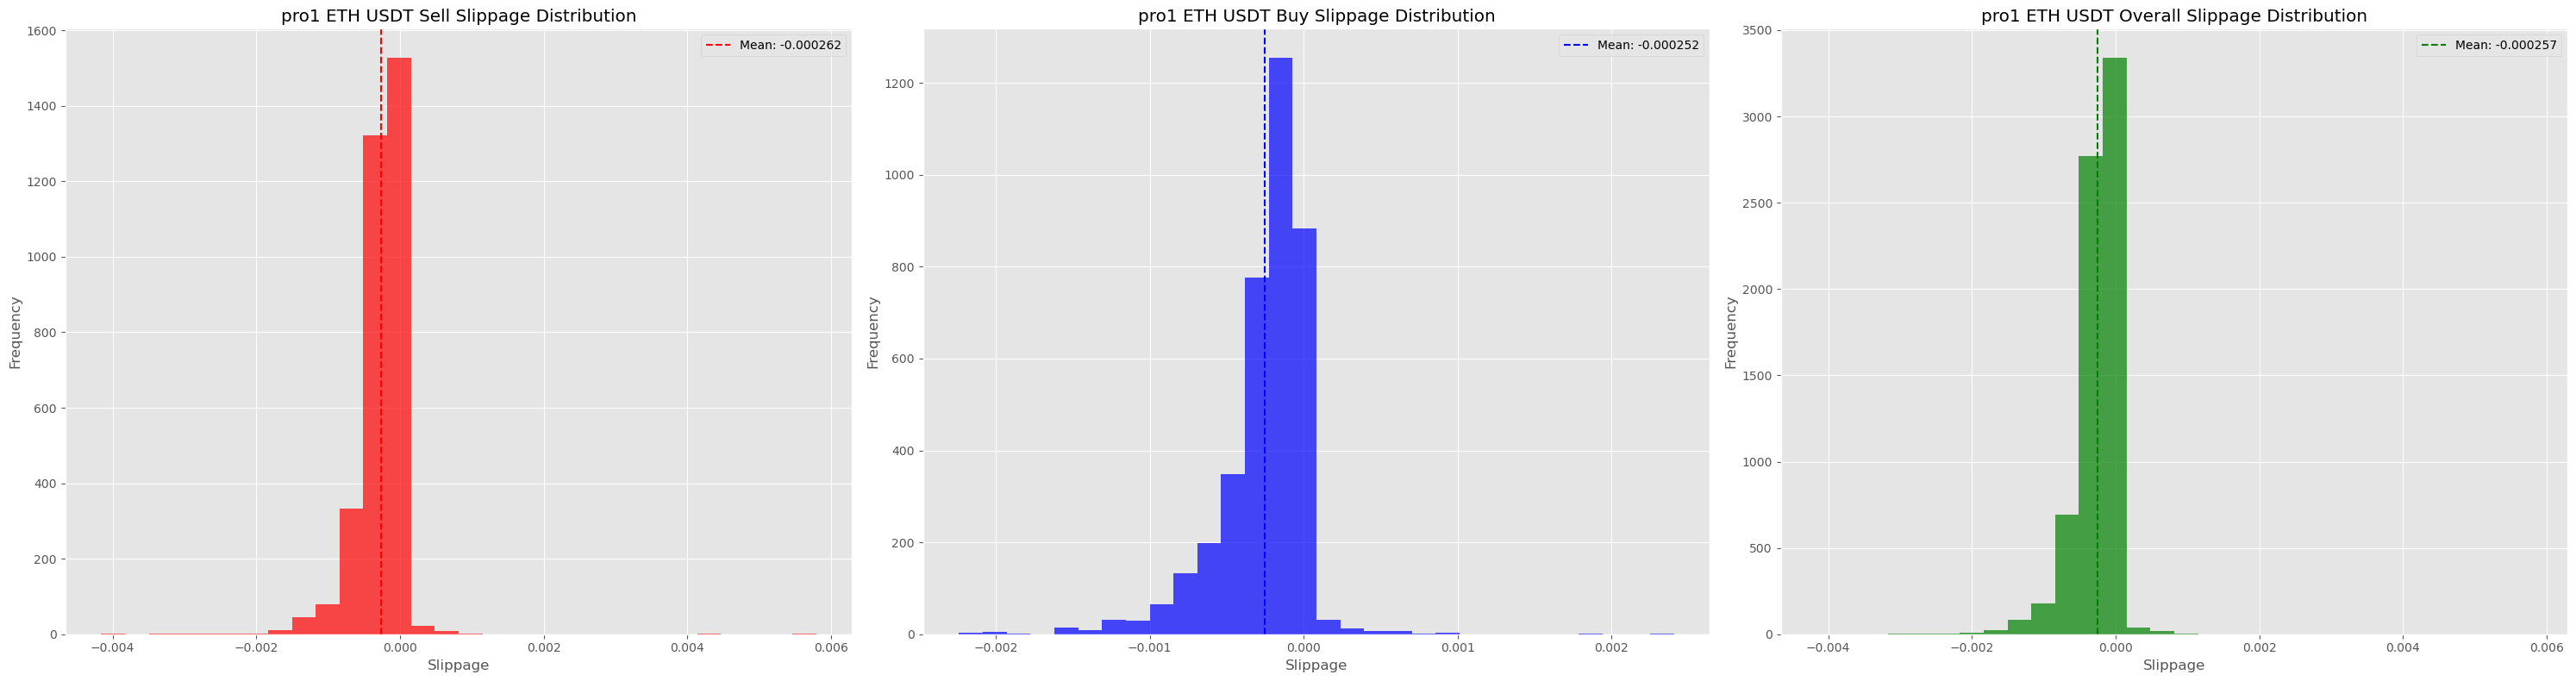

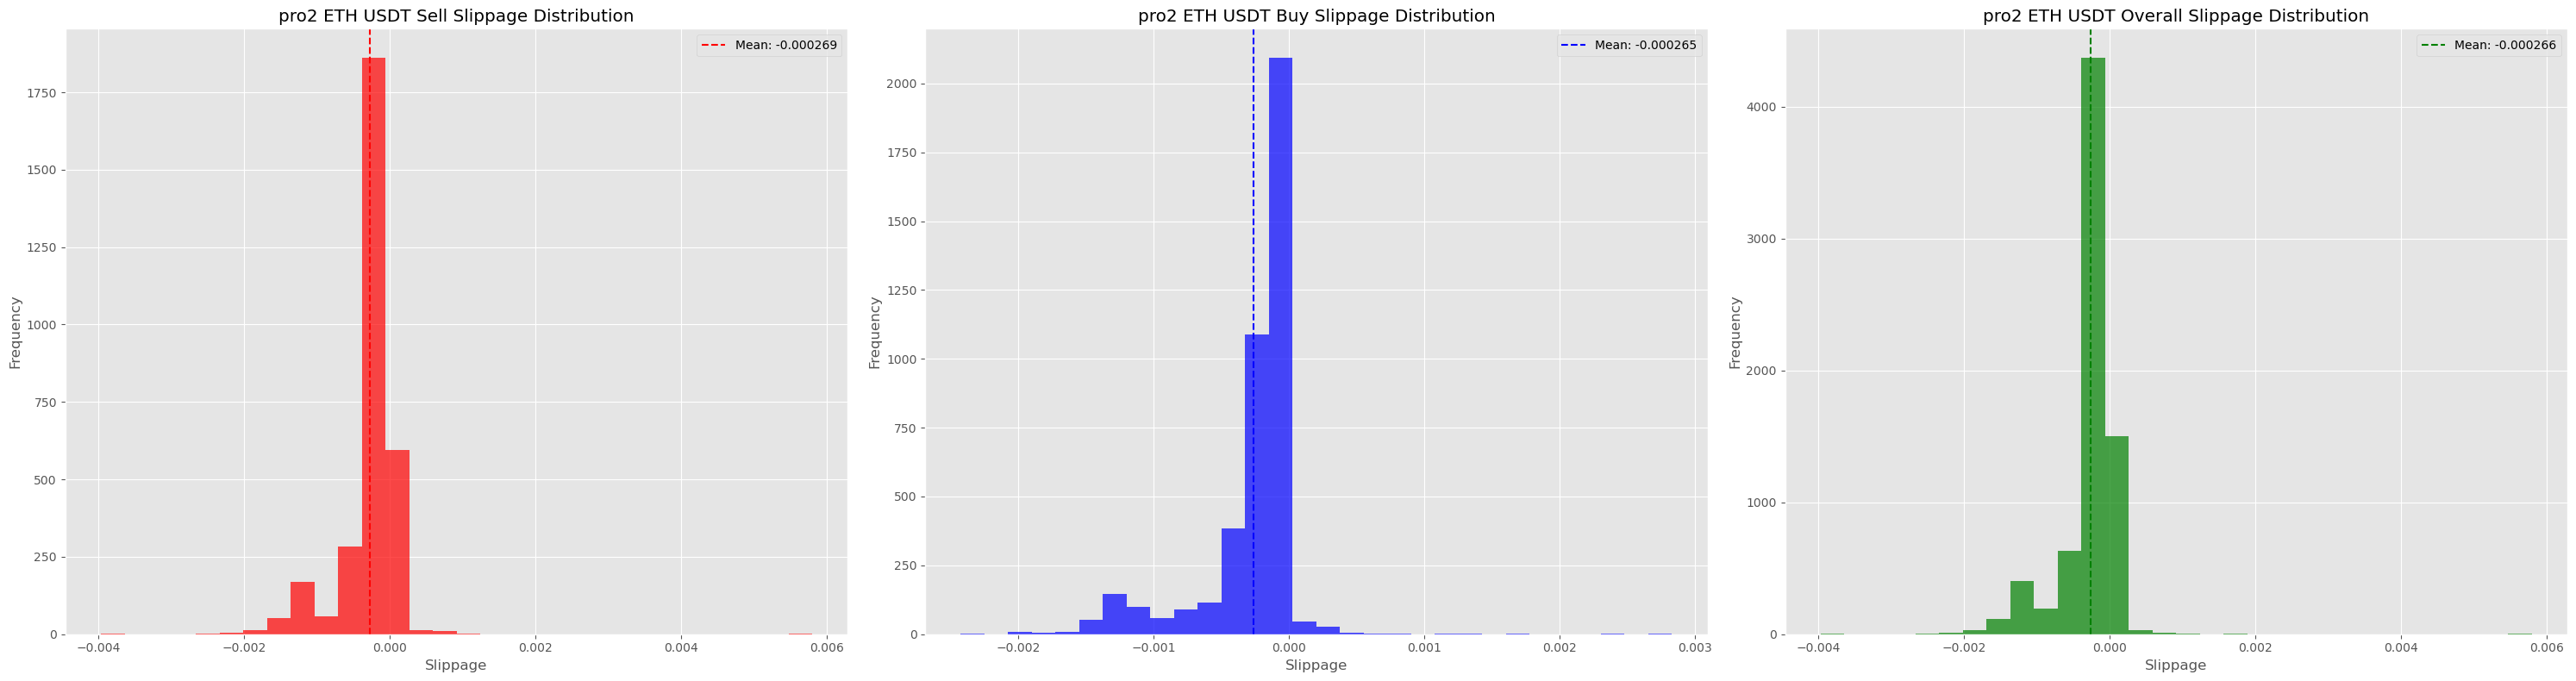

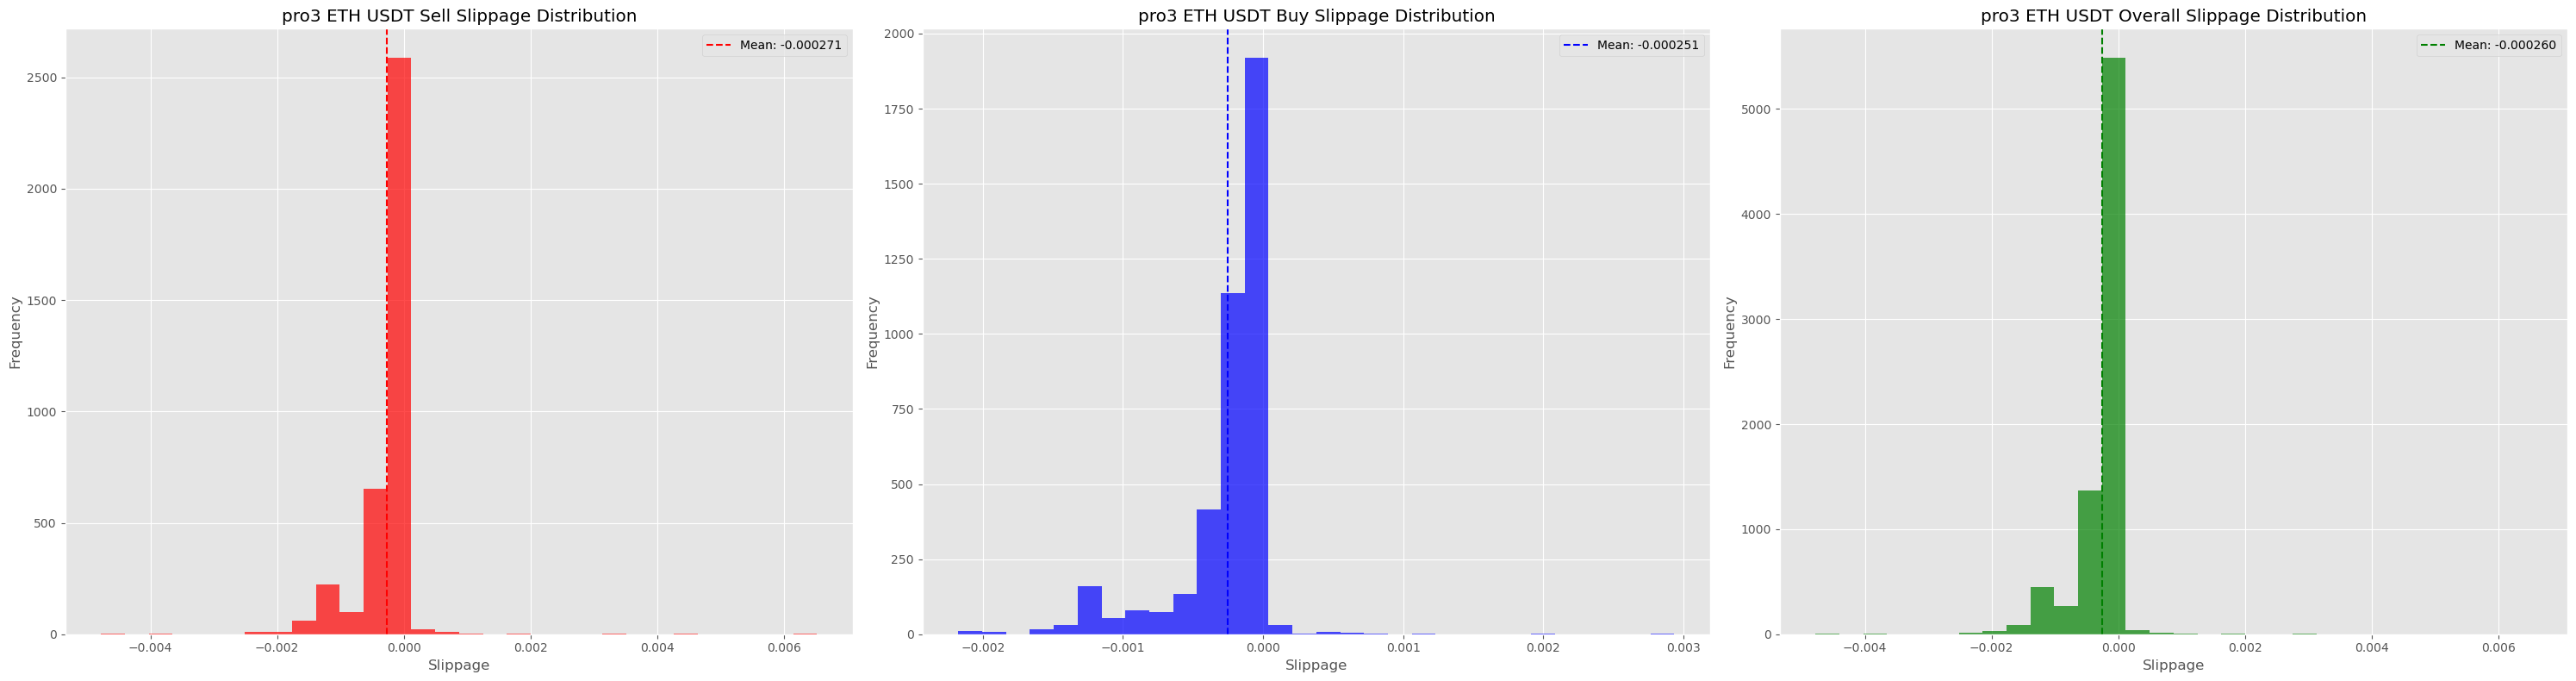

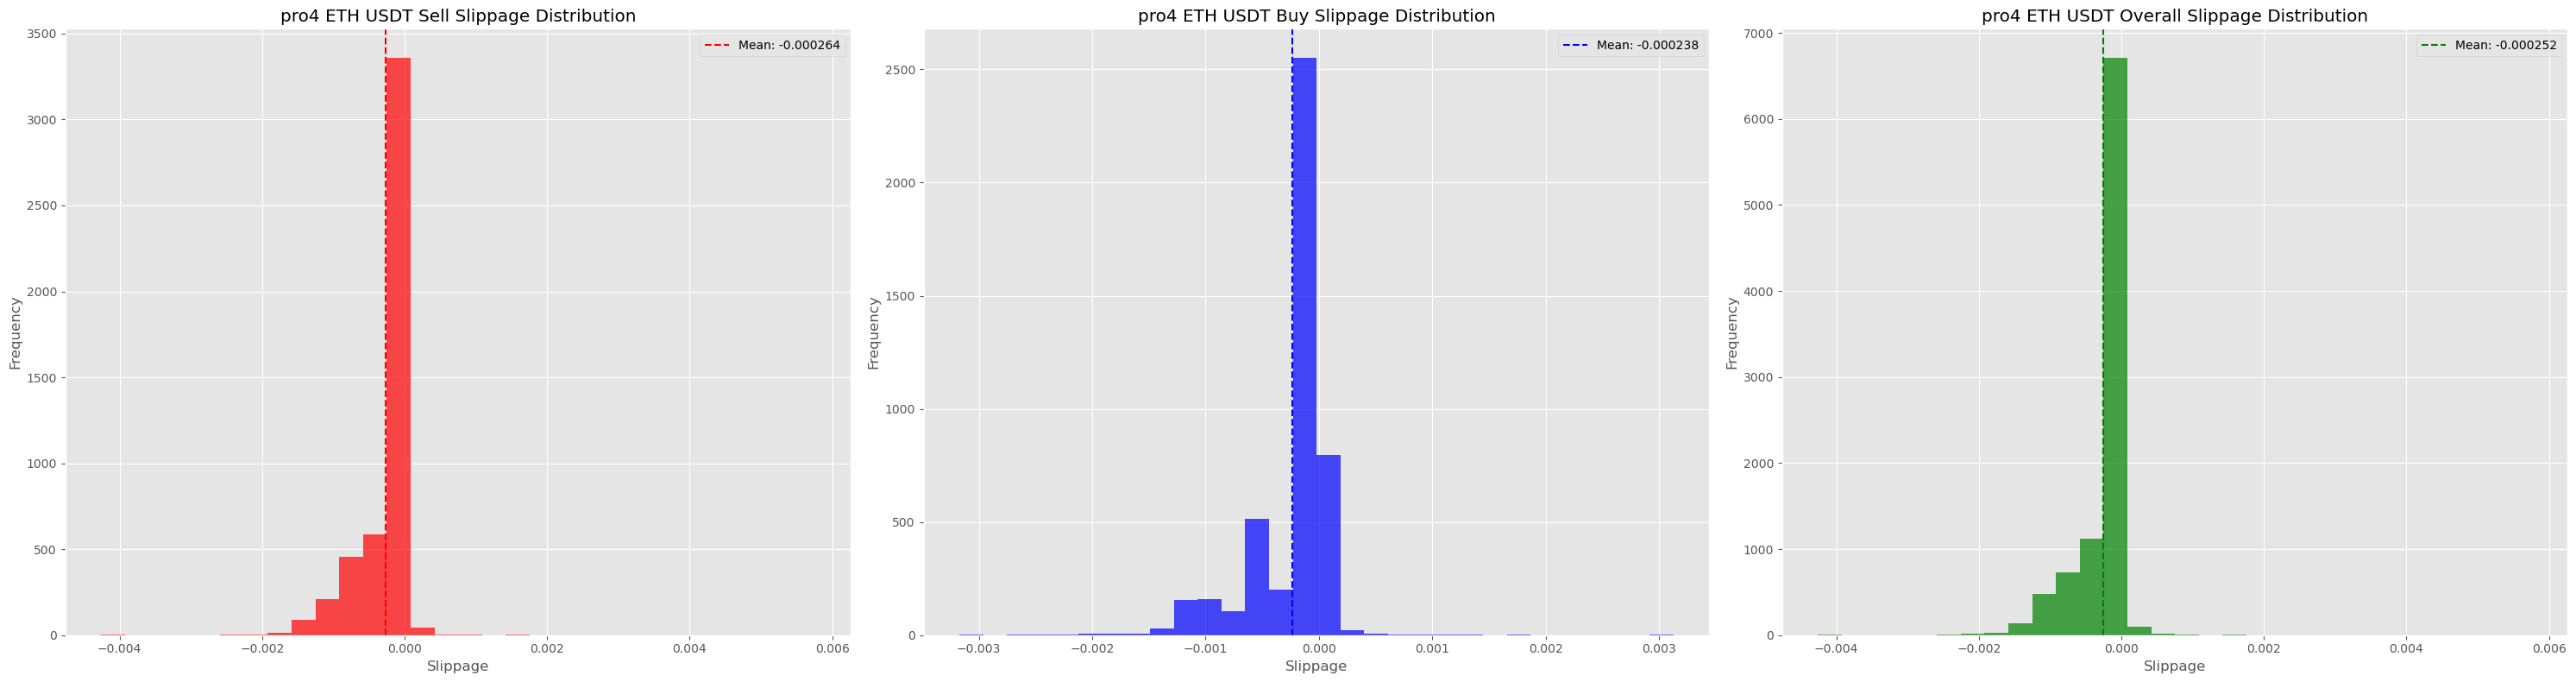

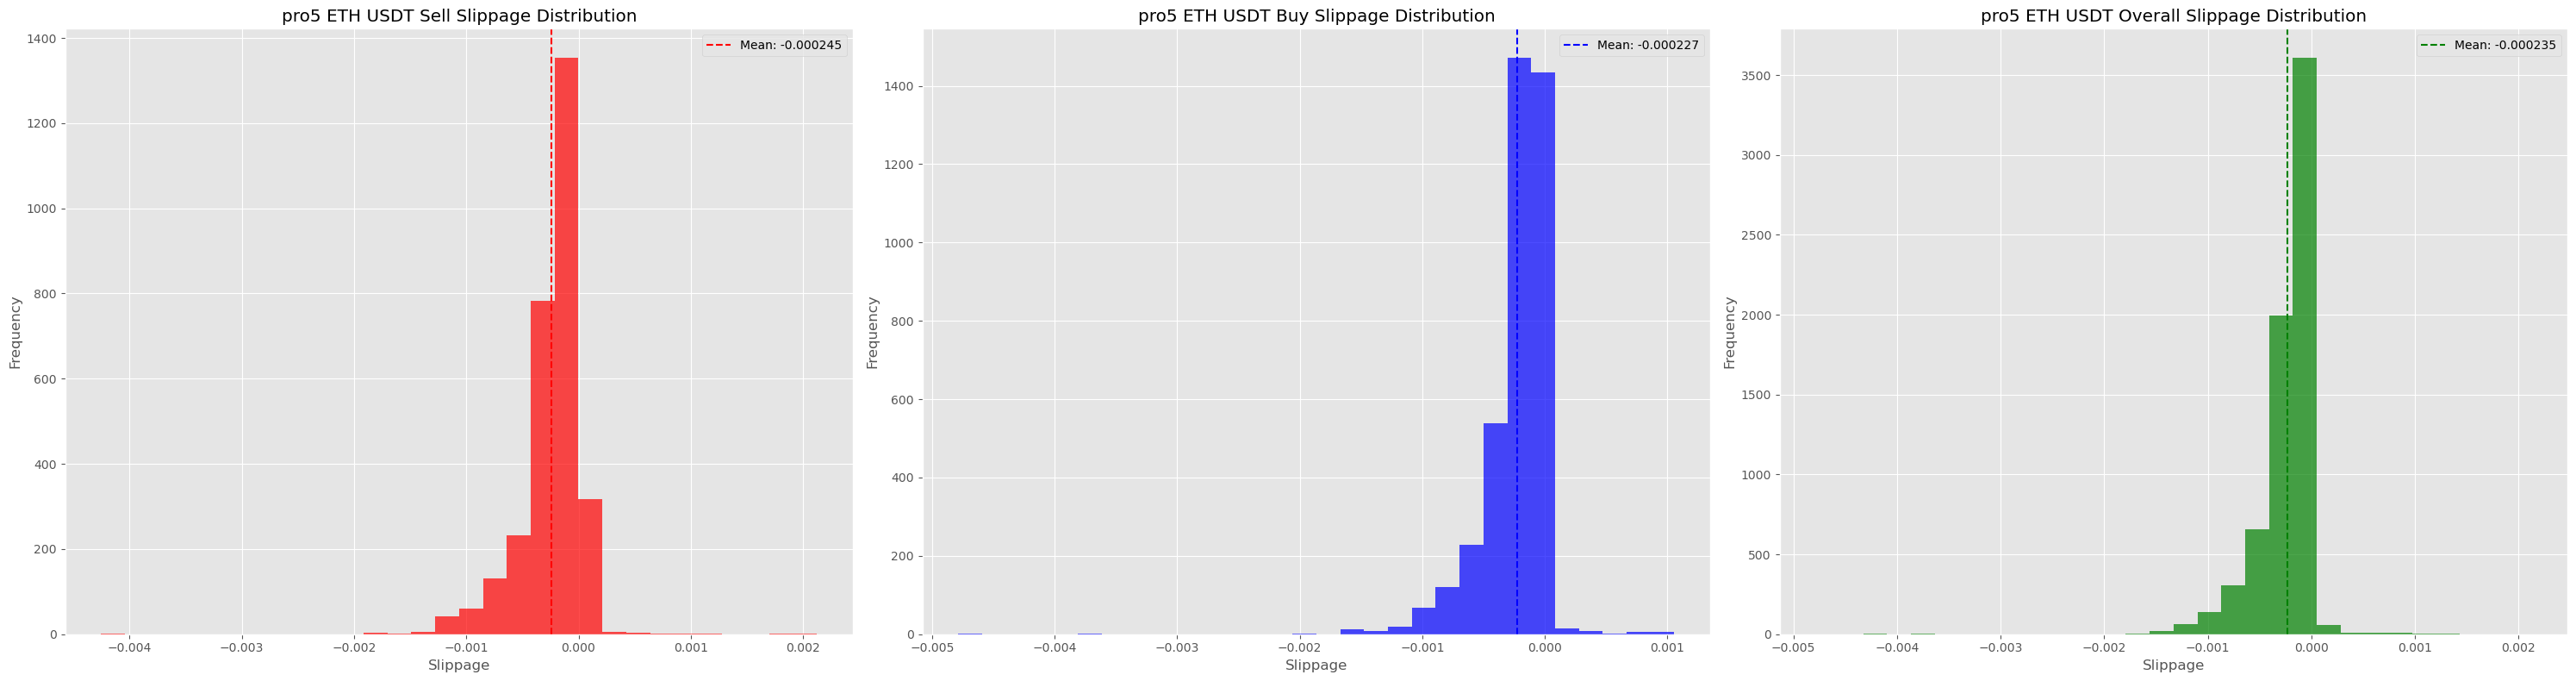

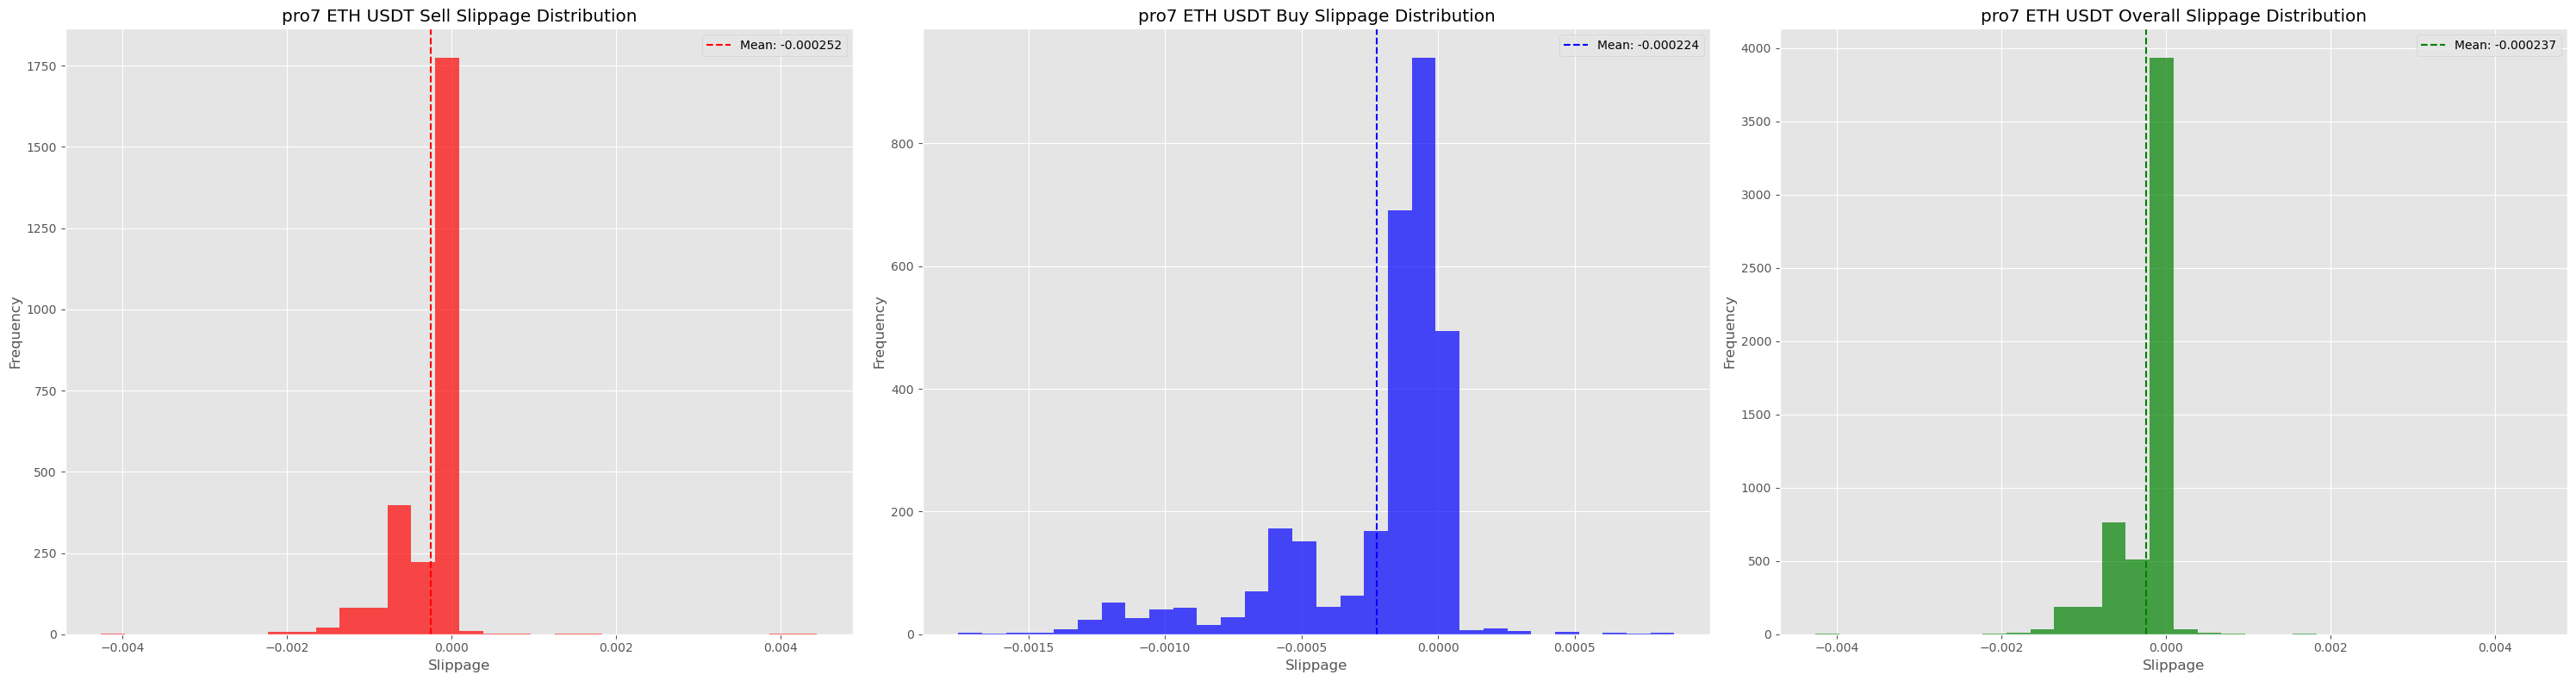

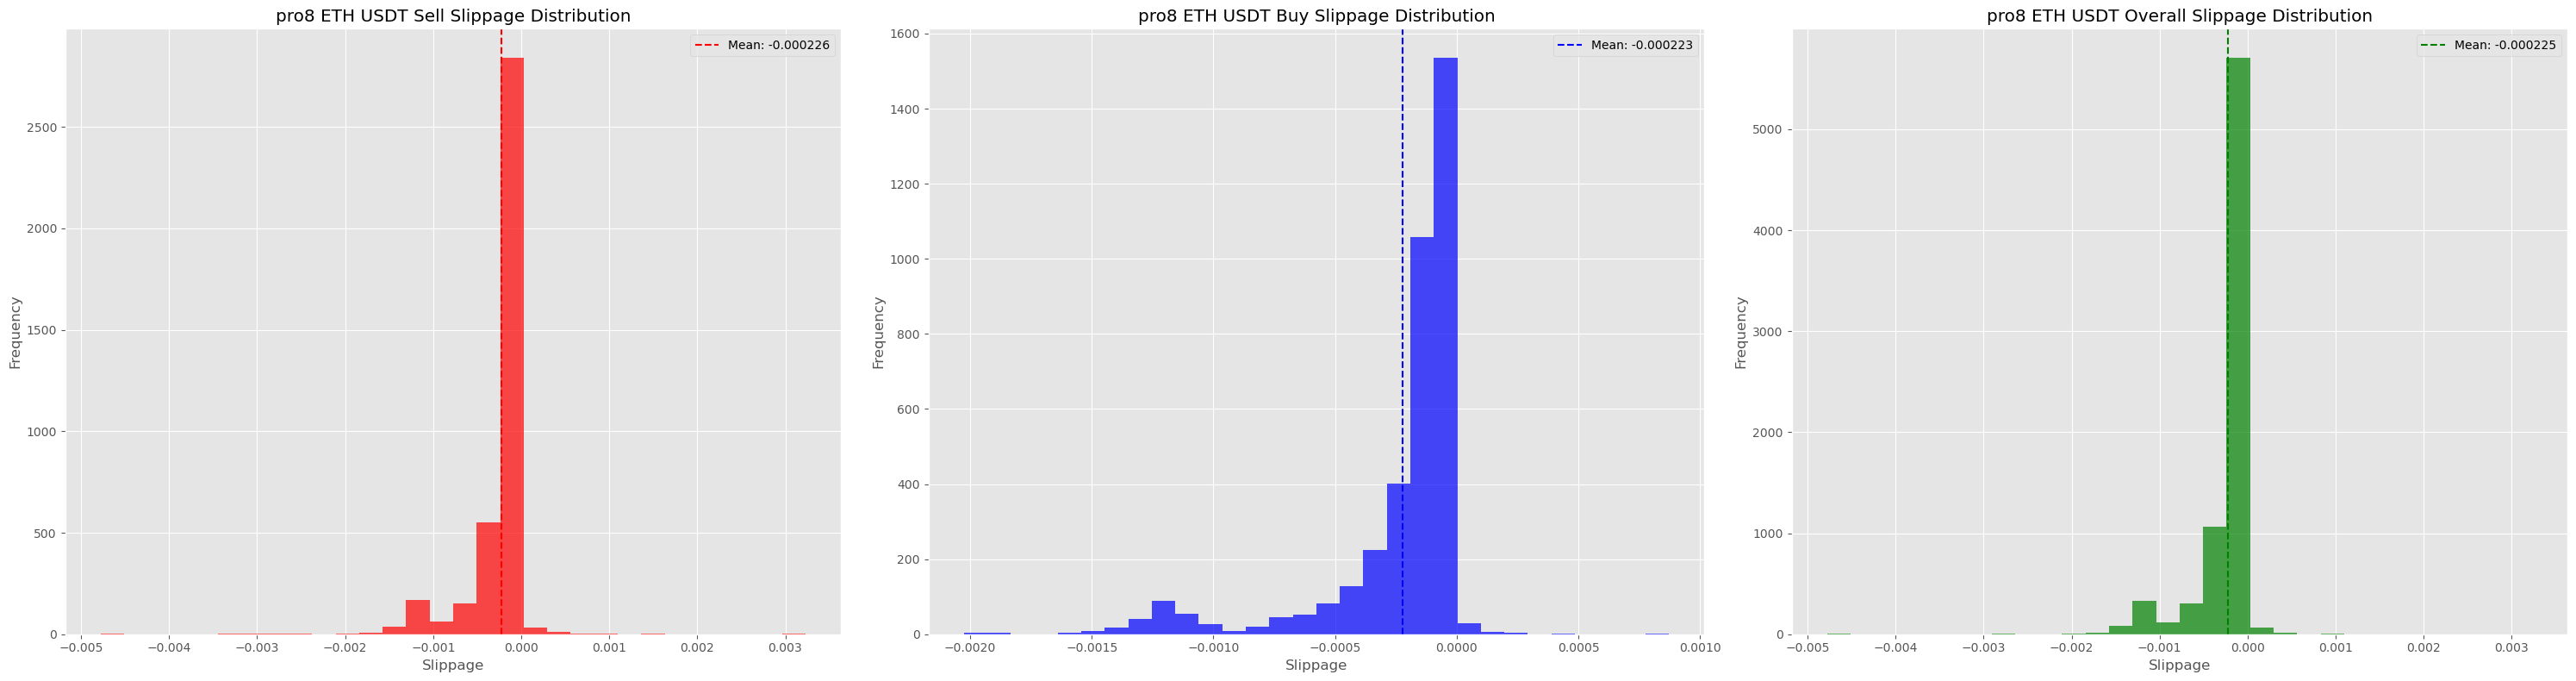

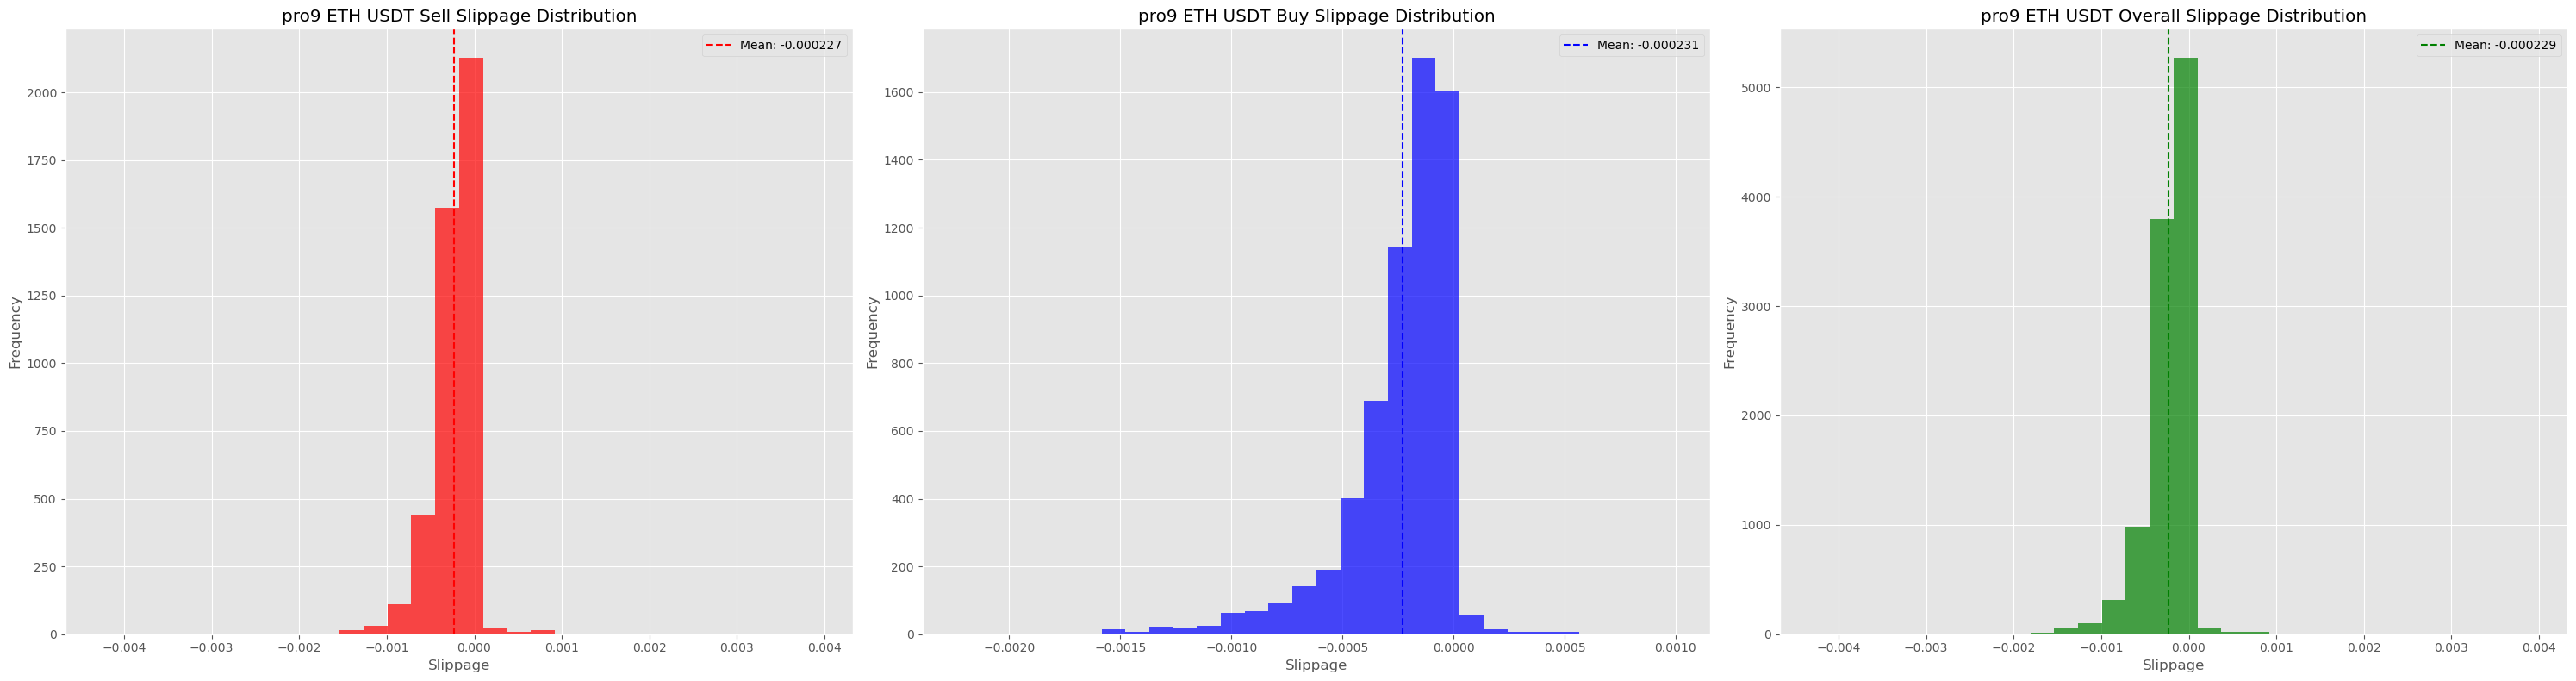

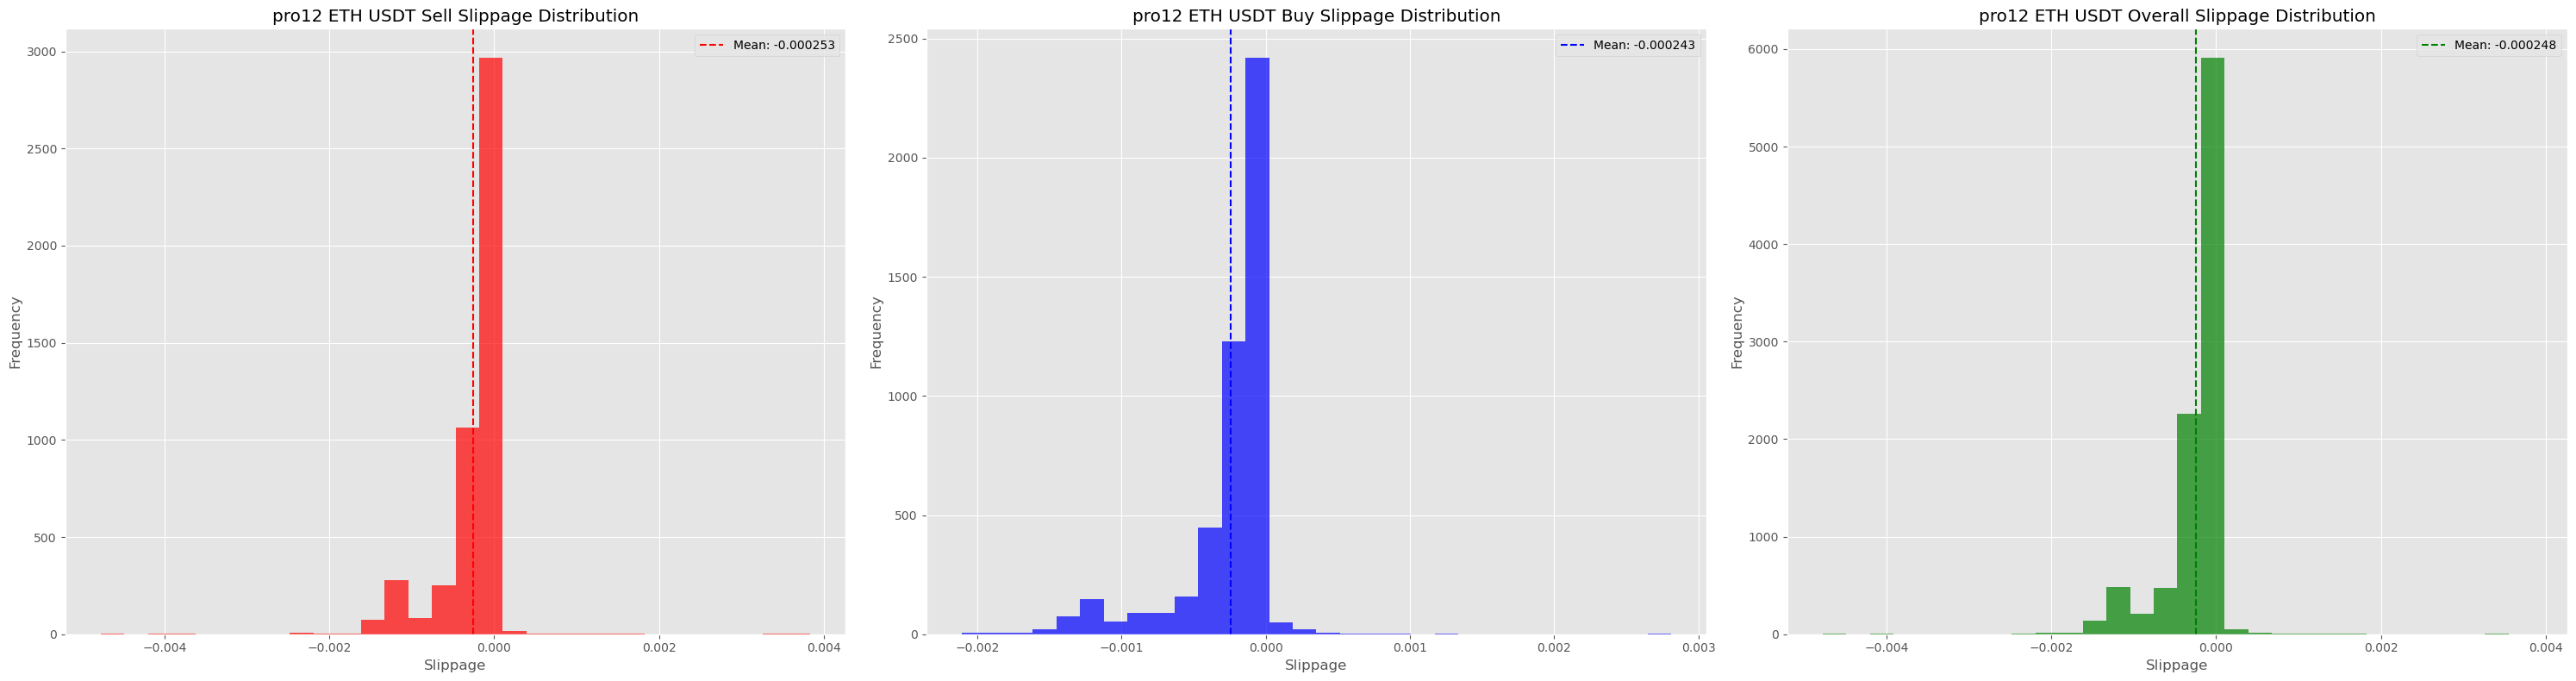

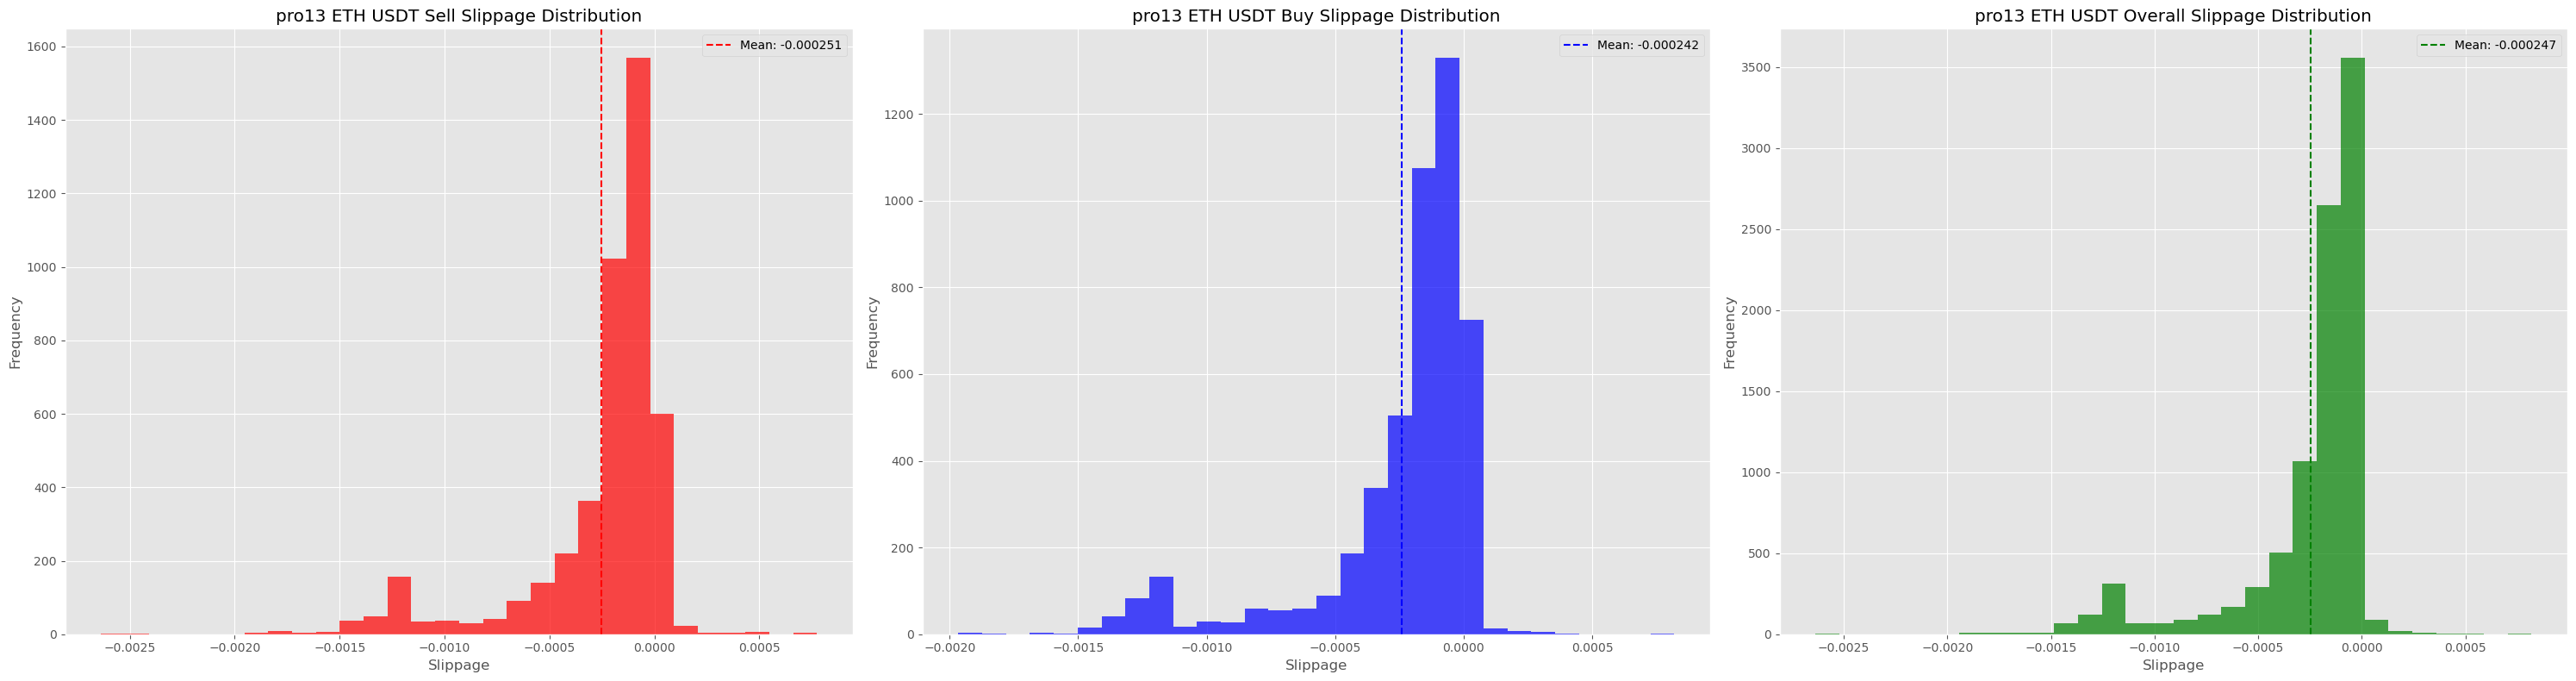

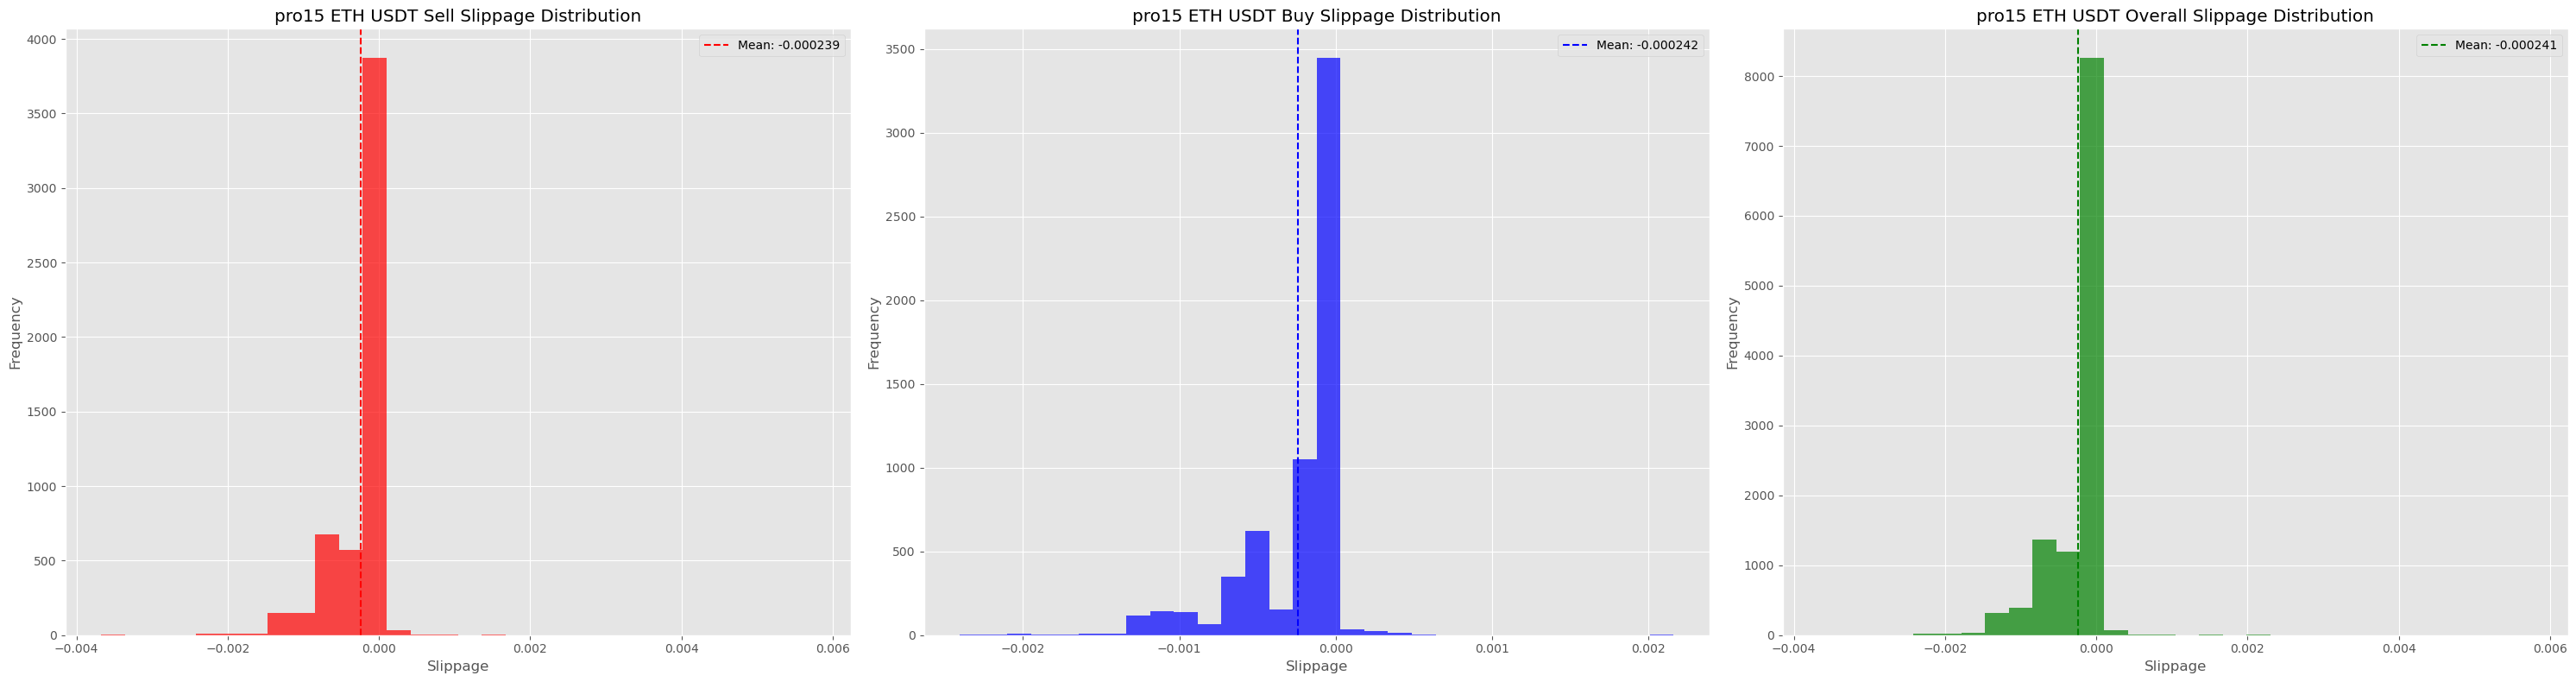

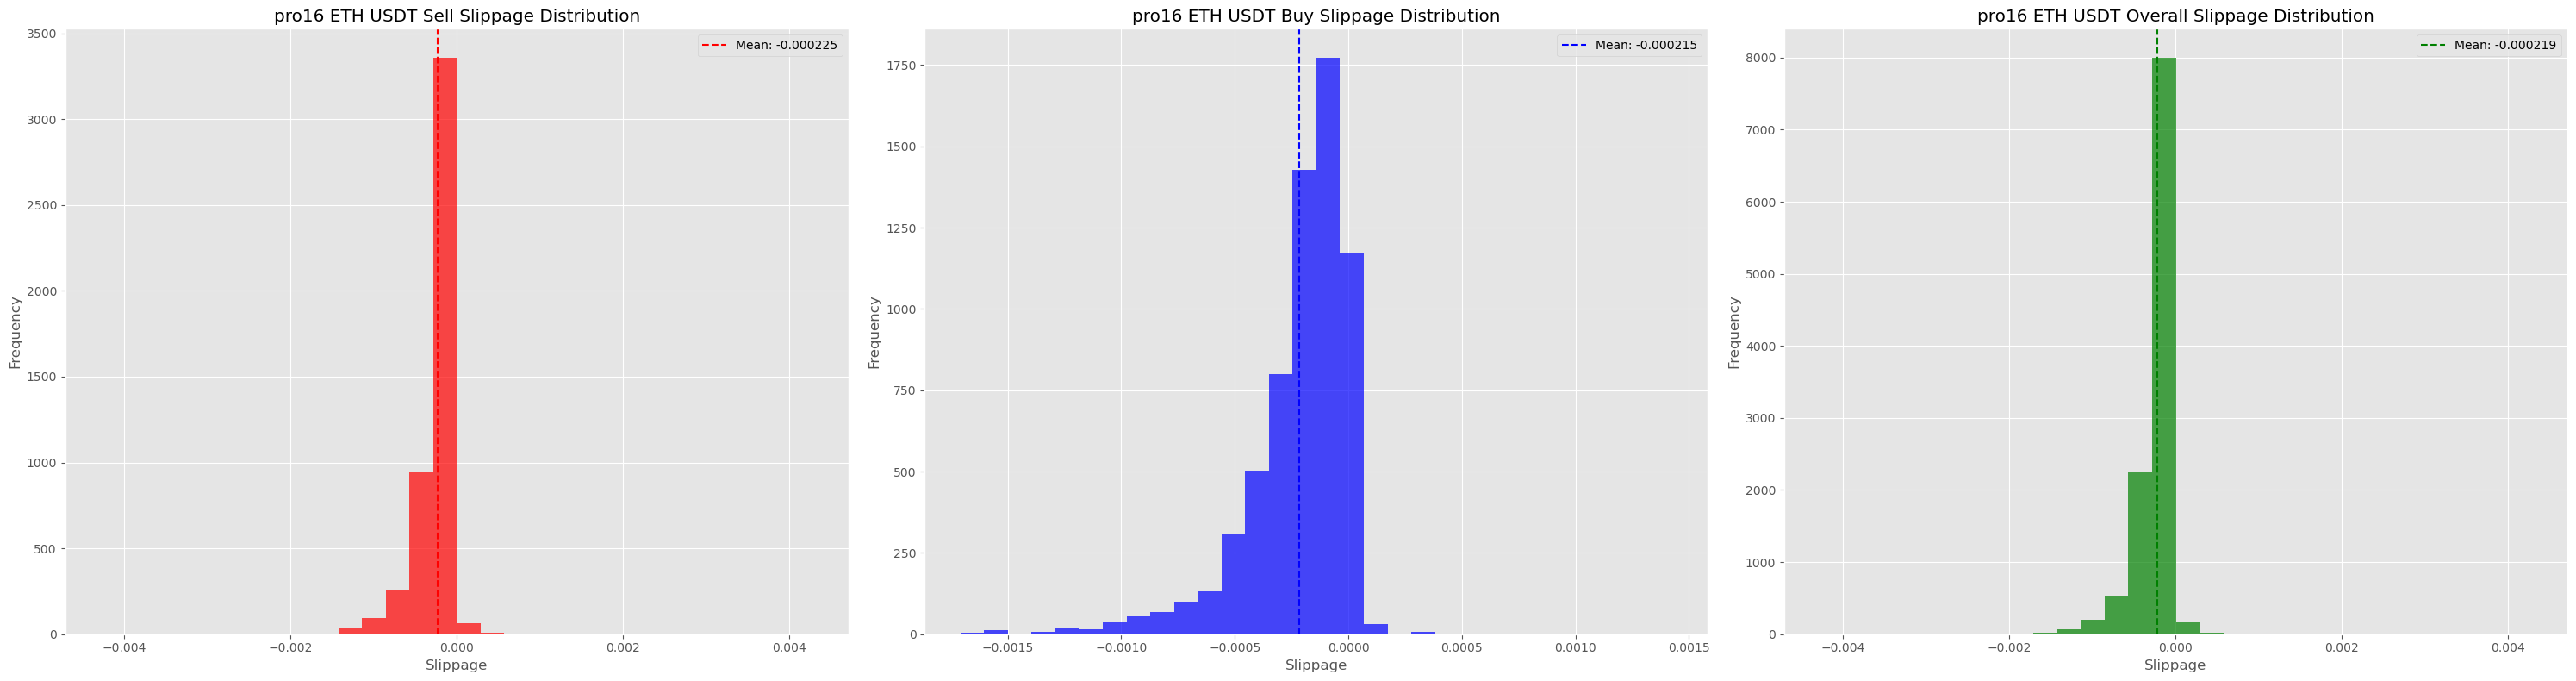

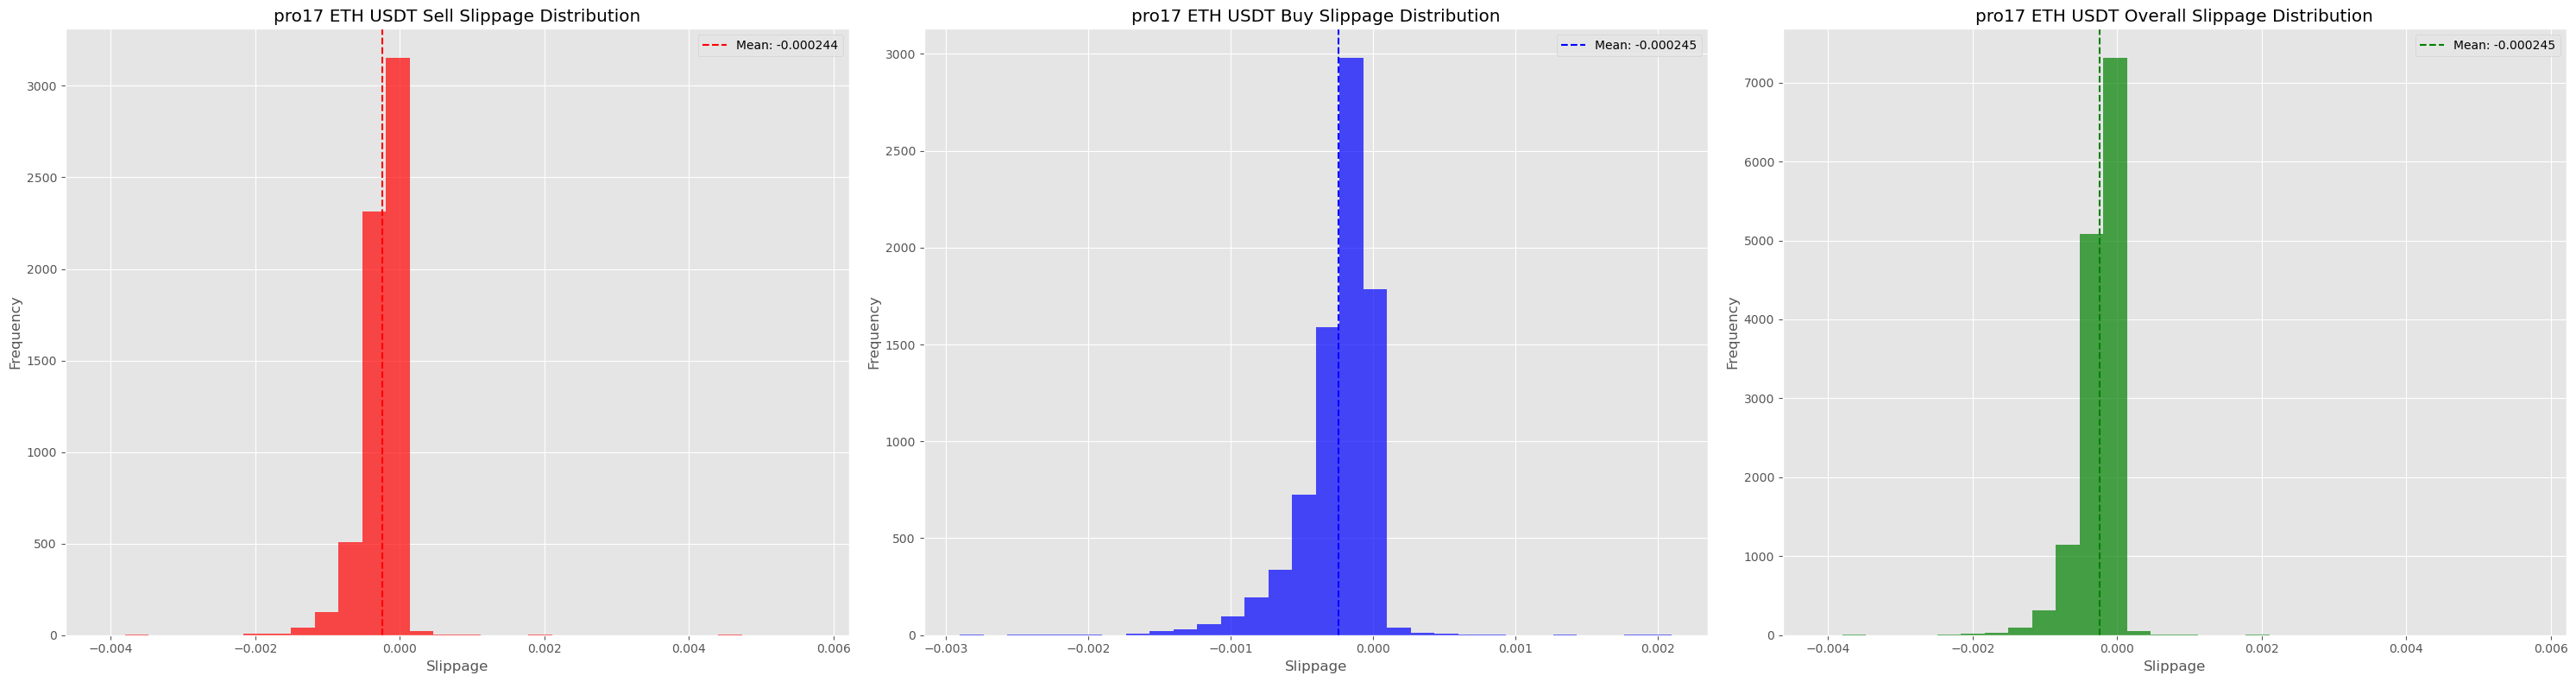

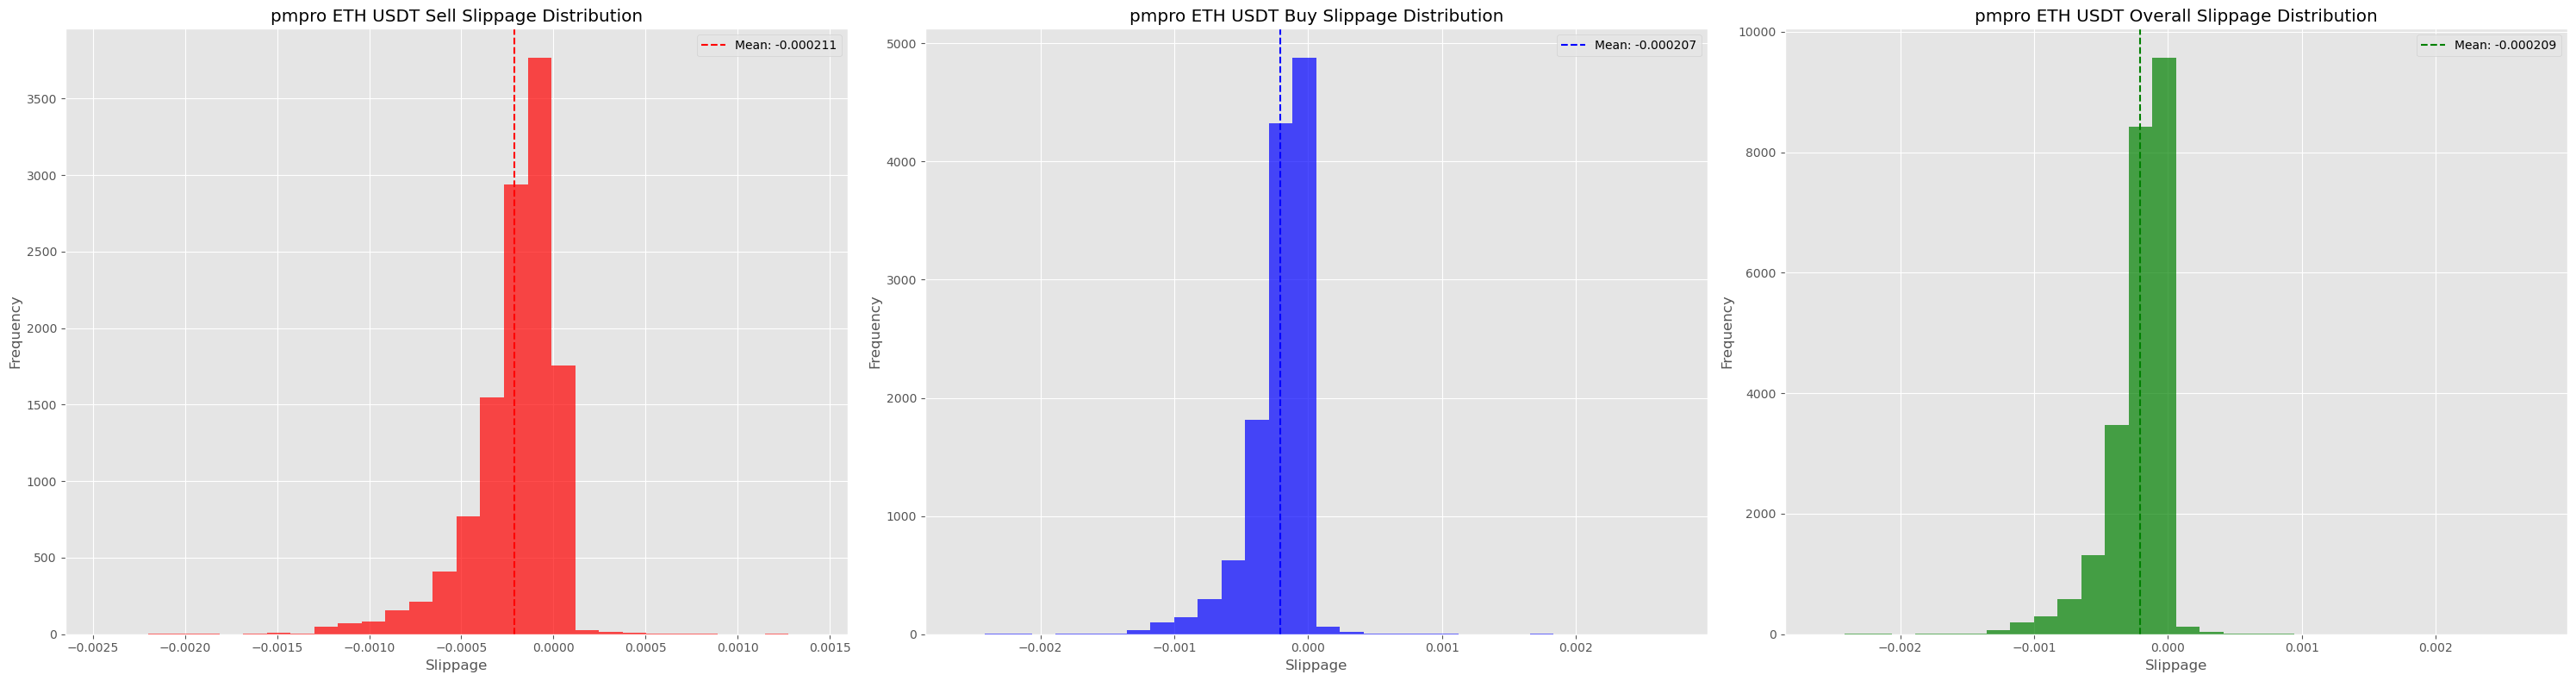

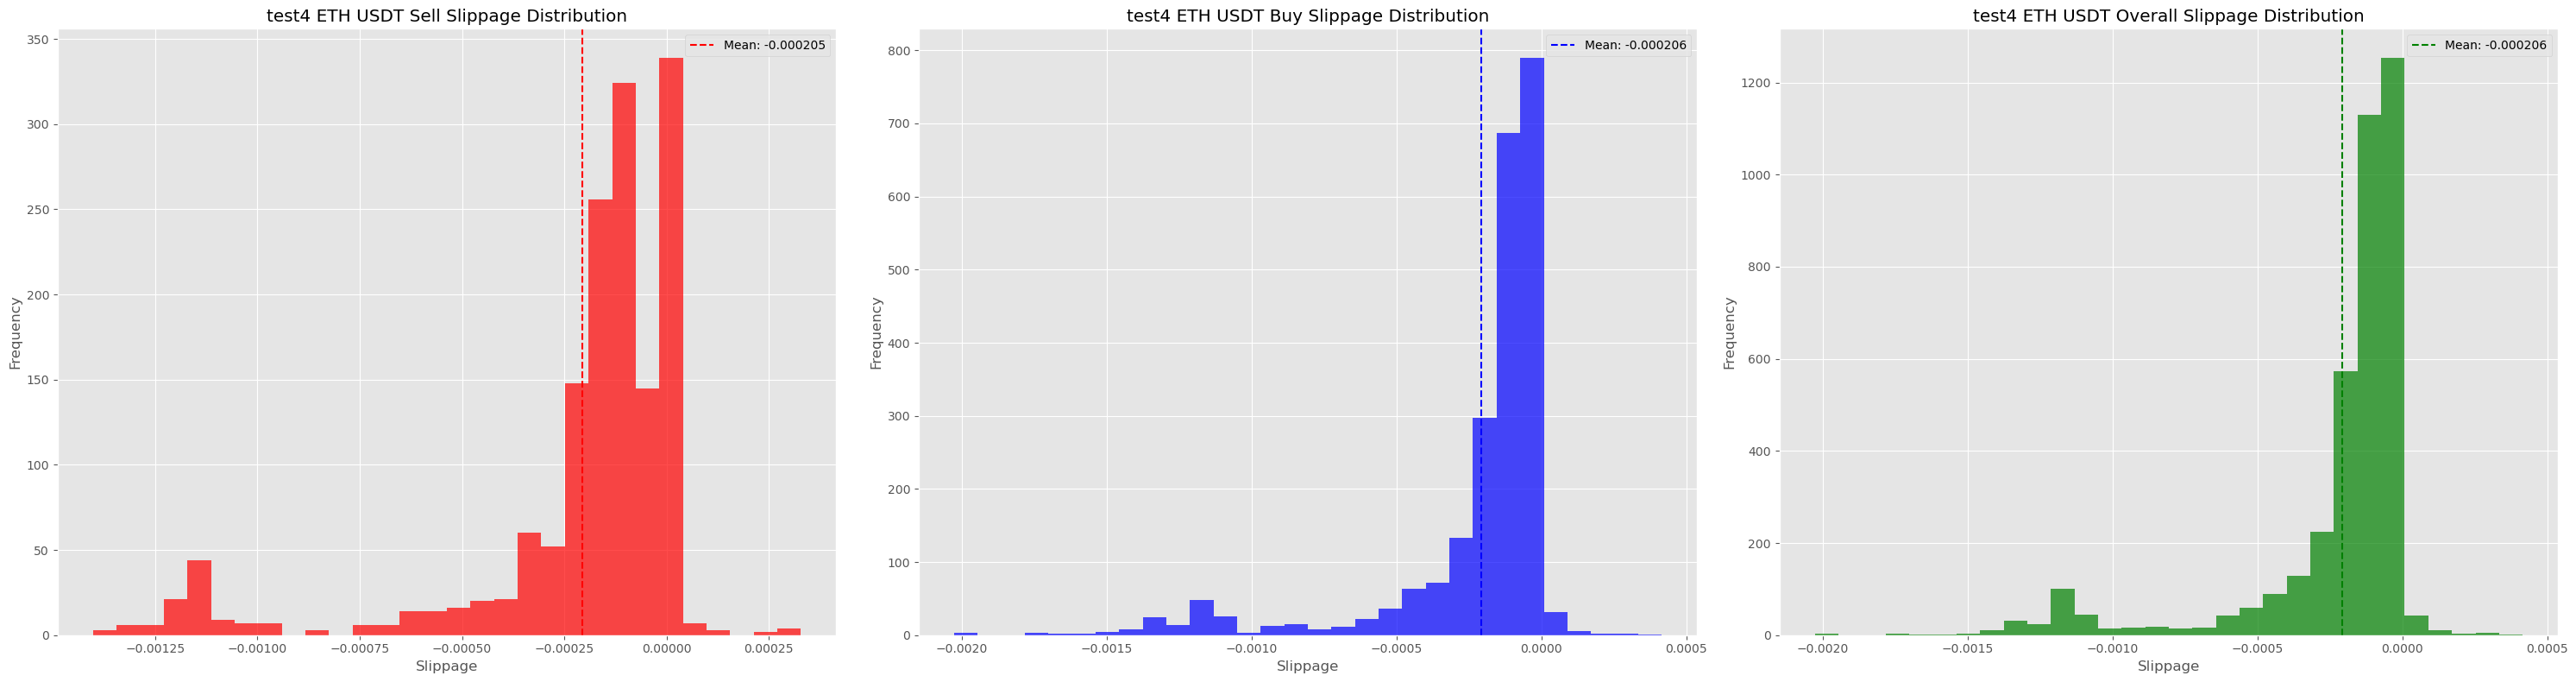

2025-11-20 17:33:00 2025-11-24 13:30:00


symbol                                            replace  count  \
env                                                                      
test4    ETH     msecs3000 replace300 10 median abnormal 0.0001   3870   
pmpro    ETH          msecs3000 replace1 median abnormal 0.0003  24203   
pro16    ETH  msecs10000 replace1 median+cancel abnormal 0.0001  11274   
pro8     ETH  msecs10000 replace1_300_1_10 median abnormal 0...   7733   
pro9     ETH          msecs5000 replace1 median abnormal 0.0001  10643   
pro5     ETH         msecs10000 replace1 median abnormal 0.0001   6887   
pro7     ETH        msecs10000 replac120 median abnormal 0.0002   5684   
pro15    ETH        msecs5000 replace120 median abnormal 0.0002  11712   
pro17    ETH          msecs3000 replace1 median abnormal 0.0001  14104   
pro13    ETH  msecs5000 replace1_300_1_10 median abnormal 0....   9265   
pro12    ETH  msecs3000 replace1_300_1_10 median abnormal 0....   9602   
pro4     ETH        msecs3000 replace120 median abnormal 0.0002   9366   
pro1     ETH          msecs3000 replace1 median abnormal 0.0001   7179   
pro3     ETH  msecs3000 replace1_300_1_1 median abnormal 0.0001   7779   
pro2     ETH  msecs3000 replace1_300_1_3 median abnormal 0.0001   7313   

           mean    median      std       min      max  percentile_5  \
env                                                                   
test4 -0.000206 -0.000110 0.000303 -0.002026 0.000416     -0.001114   
pmpro -0.000209 -0.000153 0.000232 -0.002596 0.002718     -0.000645   
pro16 -0.000219 -0.000158 0.000254 -0.004280 0.004286     -0.000679   
pro8  -0.000225 -0.000115 0.000337 -0.004779 0.003232     -0.001131   
pro9  -0.000229 -0.000172 0.000259 -0.004261 0.003914     -0.000699   
pro5  -0.000235 -0.000164 0.000277 -0.004787 0.002126     -0.000741   
pro7  -0.000237 -0.000106 0.000345 -0.004261 0.004448     -0.000995   
pro15 -0.000241 -0.000108 0.000347 -0.003675 0.005763     -0.001020   
pro17 -0.000245 -0.000181 0.000281 -0.004135 0.005723     -0.000743   
pro13 -0.000247 -0.000133 0.000331 -0.002637 0.000820     -0.001174   
pro12 -0.000248 -0.000132 0.000362 -0.004775 0.003834     -0.001173   
pro4  -0.000252 -0.000112 0.000373 -0.004261 0.005763     -0.001066   
pro1  -0.000257 -0.000189 0.000311 -0.004161 0.005796     -0.000804   
pro3  -0.000260 -0.000141 0.000392 -0.004779 0.006524     -0.001201   
pro2  -0.000266 -0.000144 0.000389 -0.003965 0.005796     -0.001213   

       percentile_10  percentile_25  percentile_50  percentile_60  \
env                                                                 
test4      -0.000497      -0.000216      -0.000110      -0.000088   
pmpro      -0.000480      -0.000291      -0.000153      -0.000114   
pro16      -0.000490      -0.000303      -0.000158      -0.000121   
pro8       -0.000571      -0.000240      -0.000115      -0.000090   
pro9       -0.000514      -0.000318      -0.000172      -0.000131   
pro5       -0.000554      -0.000318      -0.000164      -0.000128   
pro7       -0.000651      -0.000297      -0.000106      -0.000084   
pro15      -0.000637      -0.000316      -0.000108      -0.000086   
pro17      -0.000556      -0.000340      -0.000181      -0.000140   
pro13      -0.000654      -0.000274      -0.000133      -0.000103   
pro12      -0.000661      -0.000278      -0.000132      -0.000103   
pro4       -0.000682      -0.000320      -0.000112      -0.000088   
pro1       -0.000605      -0.000351      -0.000189      -0.000143   
pro3       -0.000727      -0.000290      -0.000141      -0.000107   
pro2       -0.000748      -0.000305      -0.000144      -0.000114   

       percentile_75  percentile_95  BNFirstSlippage  BNFirstSlippage_count  \
env                                                                           
test4      -0.000042       0.000000        -0.000221                   1576   
pmpro      -0.000063       0.000000        -0.000205                  10073   
pro16      -0.000067       0.000000        -0.000

In [10]:
import pandas as pd


symbol = 'ETH'
env_list = ['pro1','pro2','pro3','pro4','pro5','pro7', 'pro8','pro9', 'pro12','pro13','pro15','pro16','pro17','pmpro','test4']
# env_list = ['pmpro','test4','pro1','pro12']
replace_dict = {
'pro1': 'msecs3000 replace1 median abnormal 0.0001', 
'pro2': 'msecs3000 replace1_300_1_3 median abnormal 0.0001',
'pro3': 'msecs3000 replace1_300_1_1 median abnormal 0.0001',


'pro4': 'msecs3000 replace120 median abnormal 0.0002',
'pro5': 'msecs10000 replace1 median abnormal 0.0001', 
'pro7': 'msecs10000 replac120 median abnormal 0.0002',
'pro8': 'msecs10000 replace1_300_1_10 median abnormal 0.0001',
'pro9': 'msecs5000 replace1 median abnormal 0.0001',
'pro12': 'msecs3000 replace1_300_1_10 median abnormal 0.0001',


'pro13': 'msecs5000 replace1_300_1_10 median abnormal 0.0001',
'pro15': 'msecs5000 replace120 median abnormal 0.0002',
'pro16': 'msecs10000 replace1 median+cancel abnormal 0.0001', 
'pro17': 'msecs3000 replace1 median abnormal 0.0001',

'pmpro': 'msecs3000 replace1 median abnormal 0.0003',
'test4': 'msecs3000 replace300 10 median abnormal 0.0001',
'pro14':'tbd'}

start_date = '2025-11-20 17:33:00'
end_date = '2025-11-24 13:30:00'

summary = []

for env in env_list:
    file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.close.csv'
    file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.open.csv'
    if env == 'pmpro':
        file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.close.csv'
        file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.open.csv'
    slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


    # 创建子图  
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

    # 分析卖出滑点
    sell_slippage = short_slippage['slippage']
    sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
    ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
    ax1.set_xlabel('Slippage')
    ax1.set_ylabel('Frequency')
    sell_mean = sell_slippage.mean()
    sell_std = sell_slippage.std()
    ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
    ax1.legend()
    # print('sell count', len(sell_slippage))


    # 分析买入滑点
    buy_slippage = long_slippage['slippage']
    buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
    ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
    ax2.set_xlabel('Slippage')
    ax2.set_ylabel('Frequency')
    buy_mean = buy_slippage.mean()
    buy_std = buy_slippage.std()
    ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
    ax2.legend()
    # print('buy count', len(buy_slippage))

    # overall滑点分布
    slippage_array = slippage_df_selected['slippage'].values
    slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
    ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
    ax3.set_xlabel('Slippage')
    ax3.set_ylabel('Frequency')
    overall_mean = slippage_array.mean()
    ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    stats = {
        'symbol': symbol,
        'env': env,
        'replace': replace_dict[env],
        'count': len(slippage_array),
        'mean': np.mean(slippage_array),
        'median': np.median(slippage_array),
        'std': np.std(slippage_array),
        'min': np.min(slippage_array),
        'max': np.max(slippage_array),
        # 'percentile_1': np.percentile(slippage_array, 1),
        'percentile_5': np.percentile(slippage_array, 5),
        'percentile_10': np.percentile(slippage_array, 10),
        'percentile_25': np.percentile(slippage_array, 25),
        'percentile_50': np.percentile(slippage_array, 50),
        # 'percentile_55': np.percentile(slippage_array, 55),        
        'percentile_60': np.percentile(slippage_array, 60),
        # 'percentile_65': np.percentile(slippage_array, 65),
        'percentile_75': np.percentile(slippage_array, 75),
        'percentile_95': np.percentile(slippage_array, 95),
        # 'percentile_99': np.percentile(slippage_array, 99),
        'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
        'BNFirstSlippage_count': len(Exchange1FirstSlippage),
        'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
        'OKFirstSlippage_count': len(Exchange2FirstSlippage),
    }

    summary.append(stats)

df = pd.DataFrame(summary).set_index('env').sort_values(by='mean', ascending=False)
print(start_date,end_date)
df

# 1126

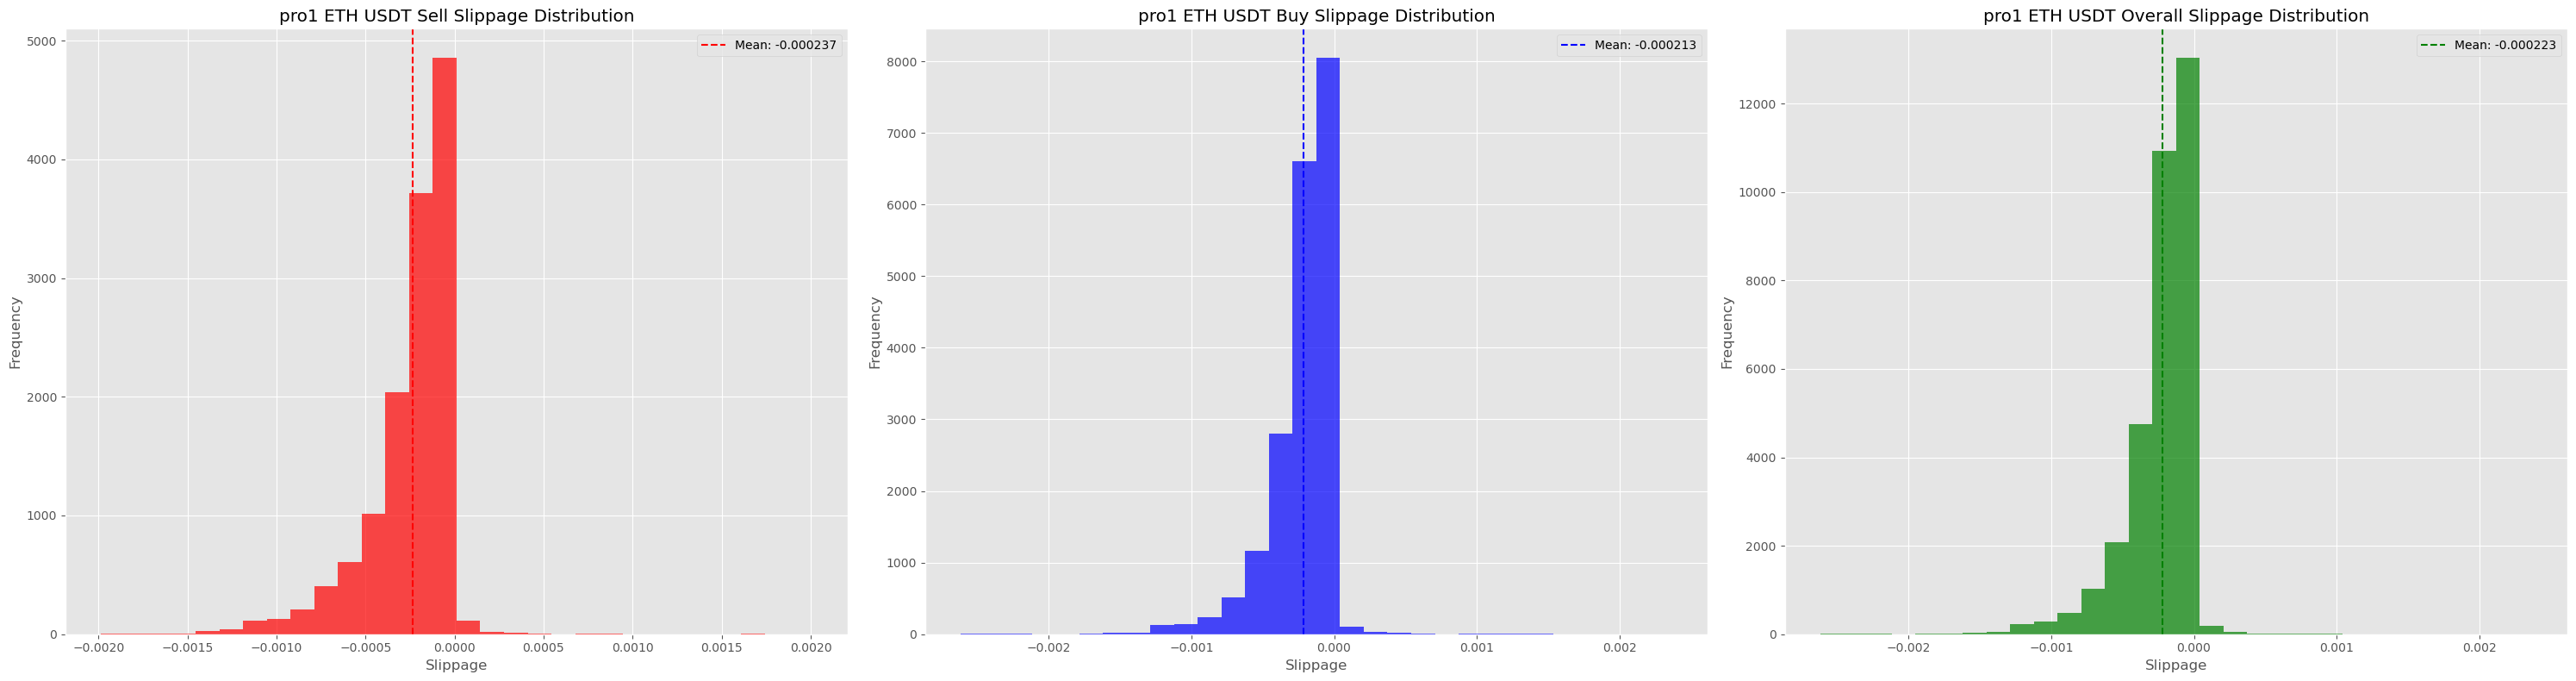

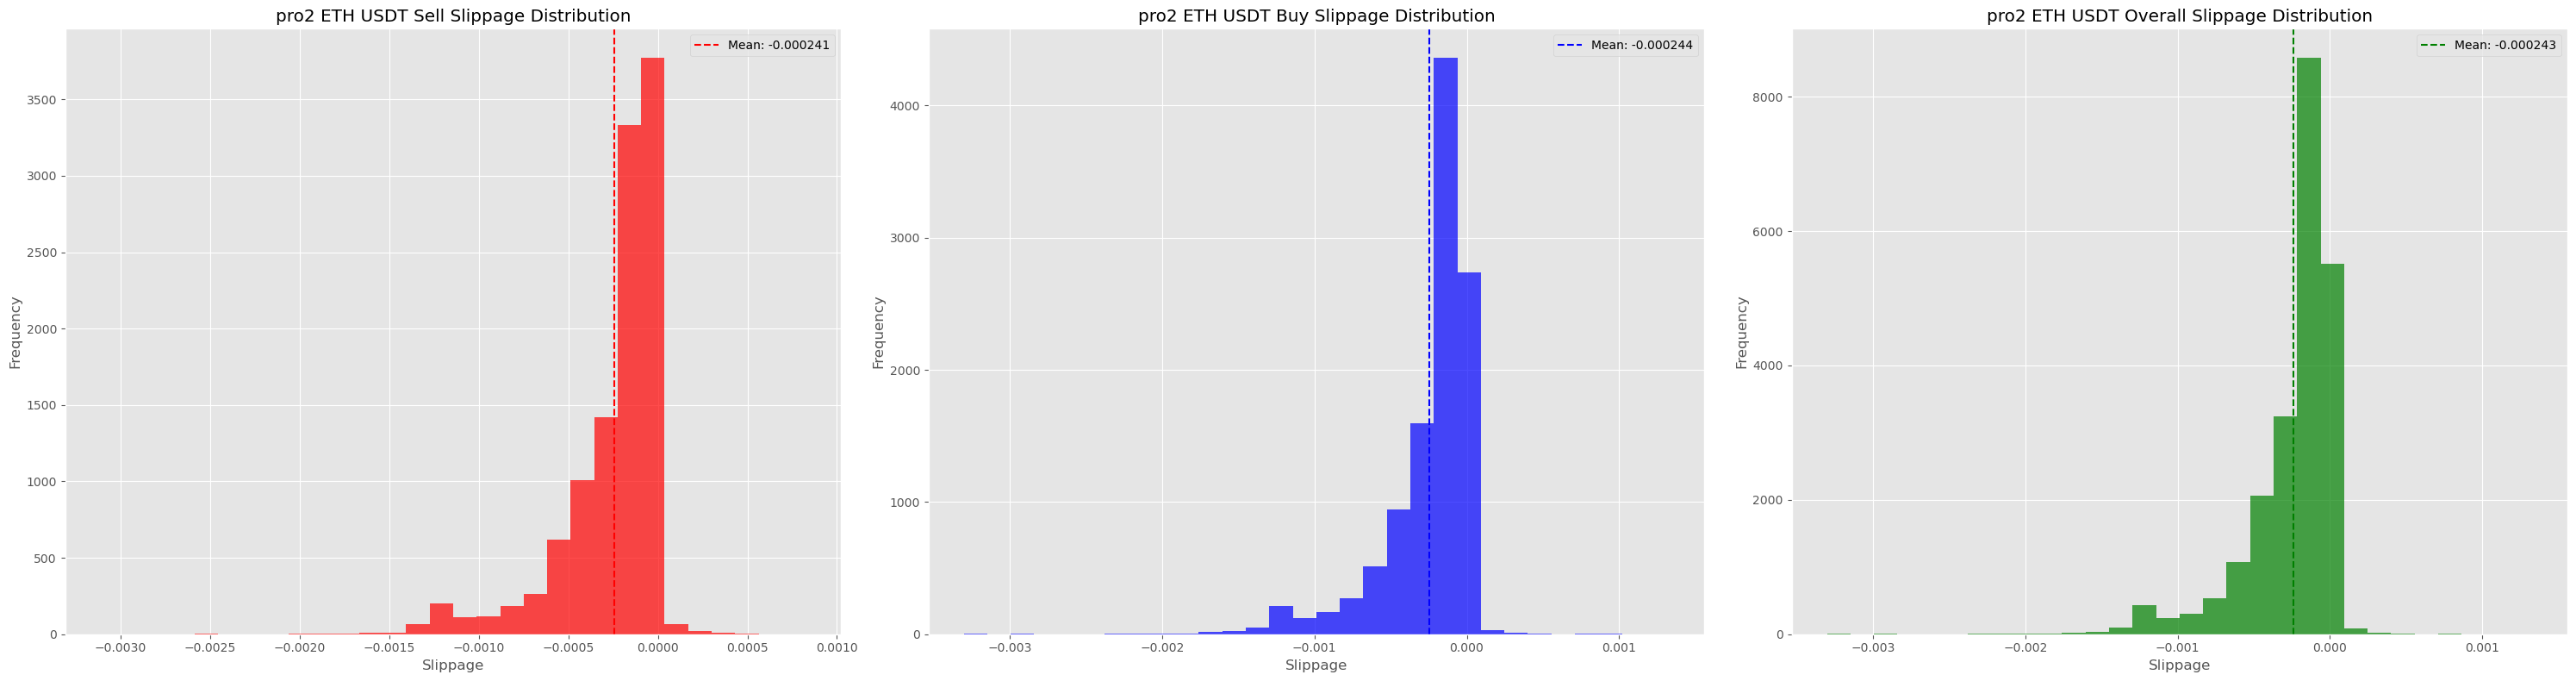

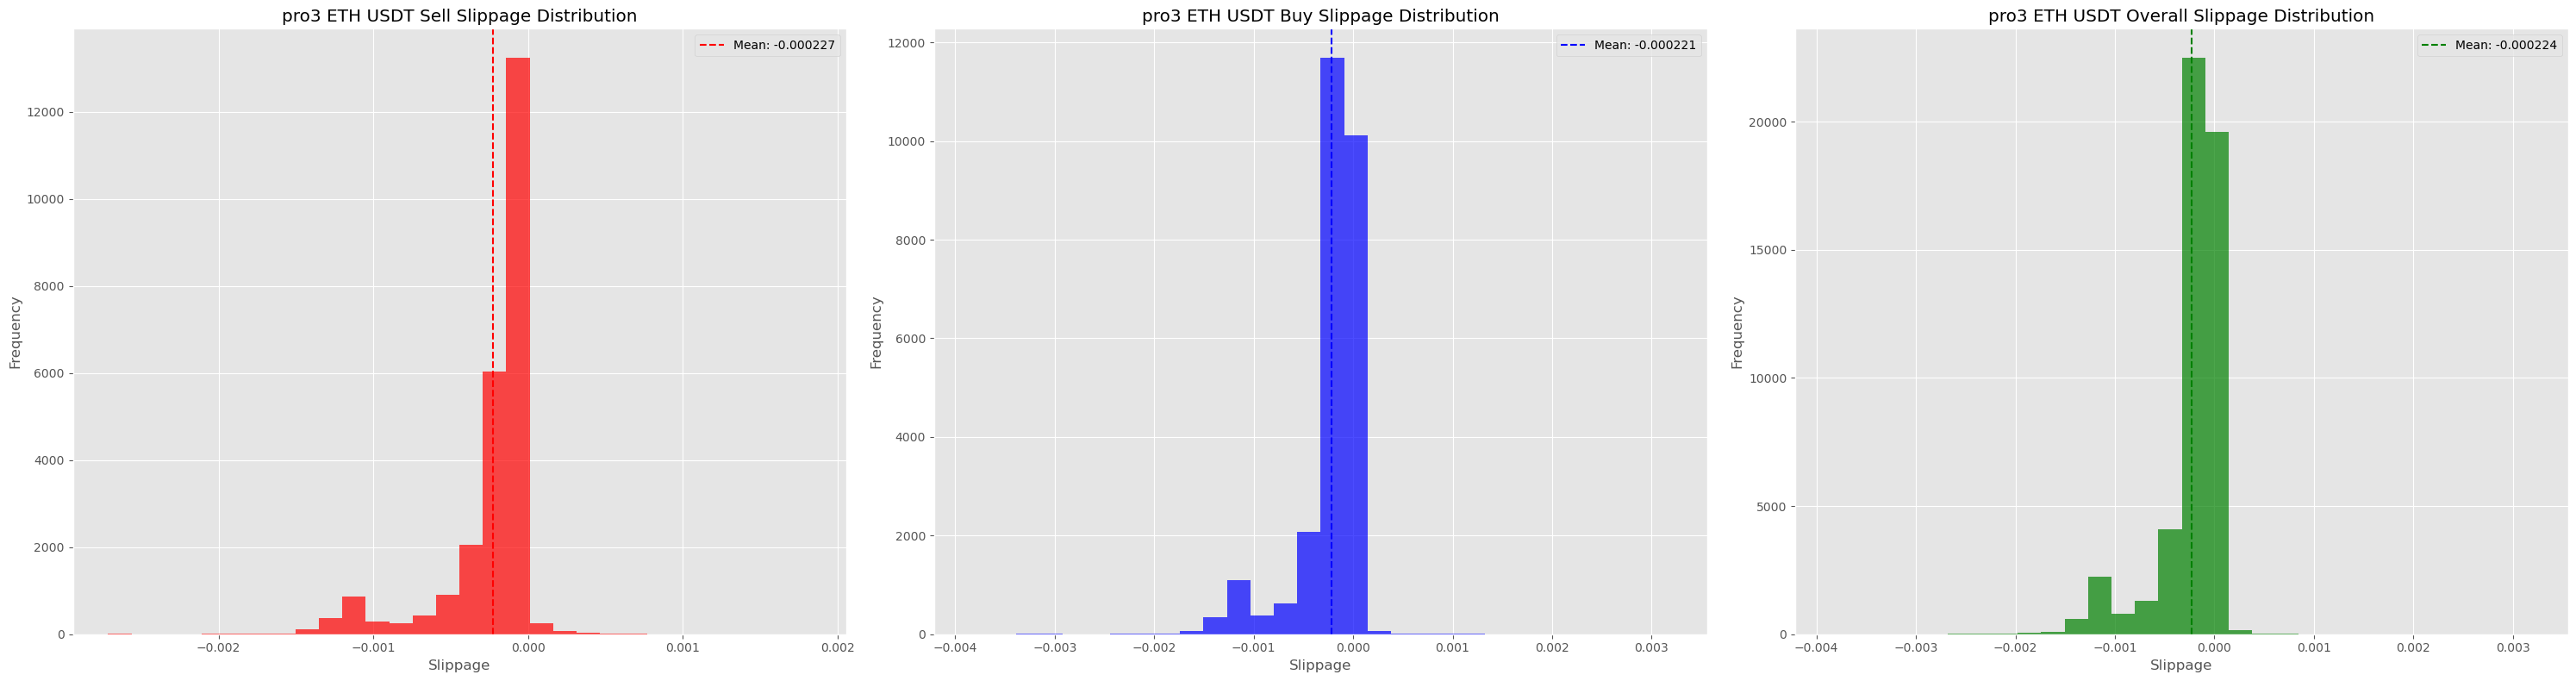

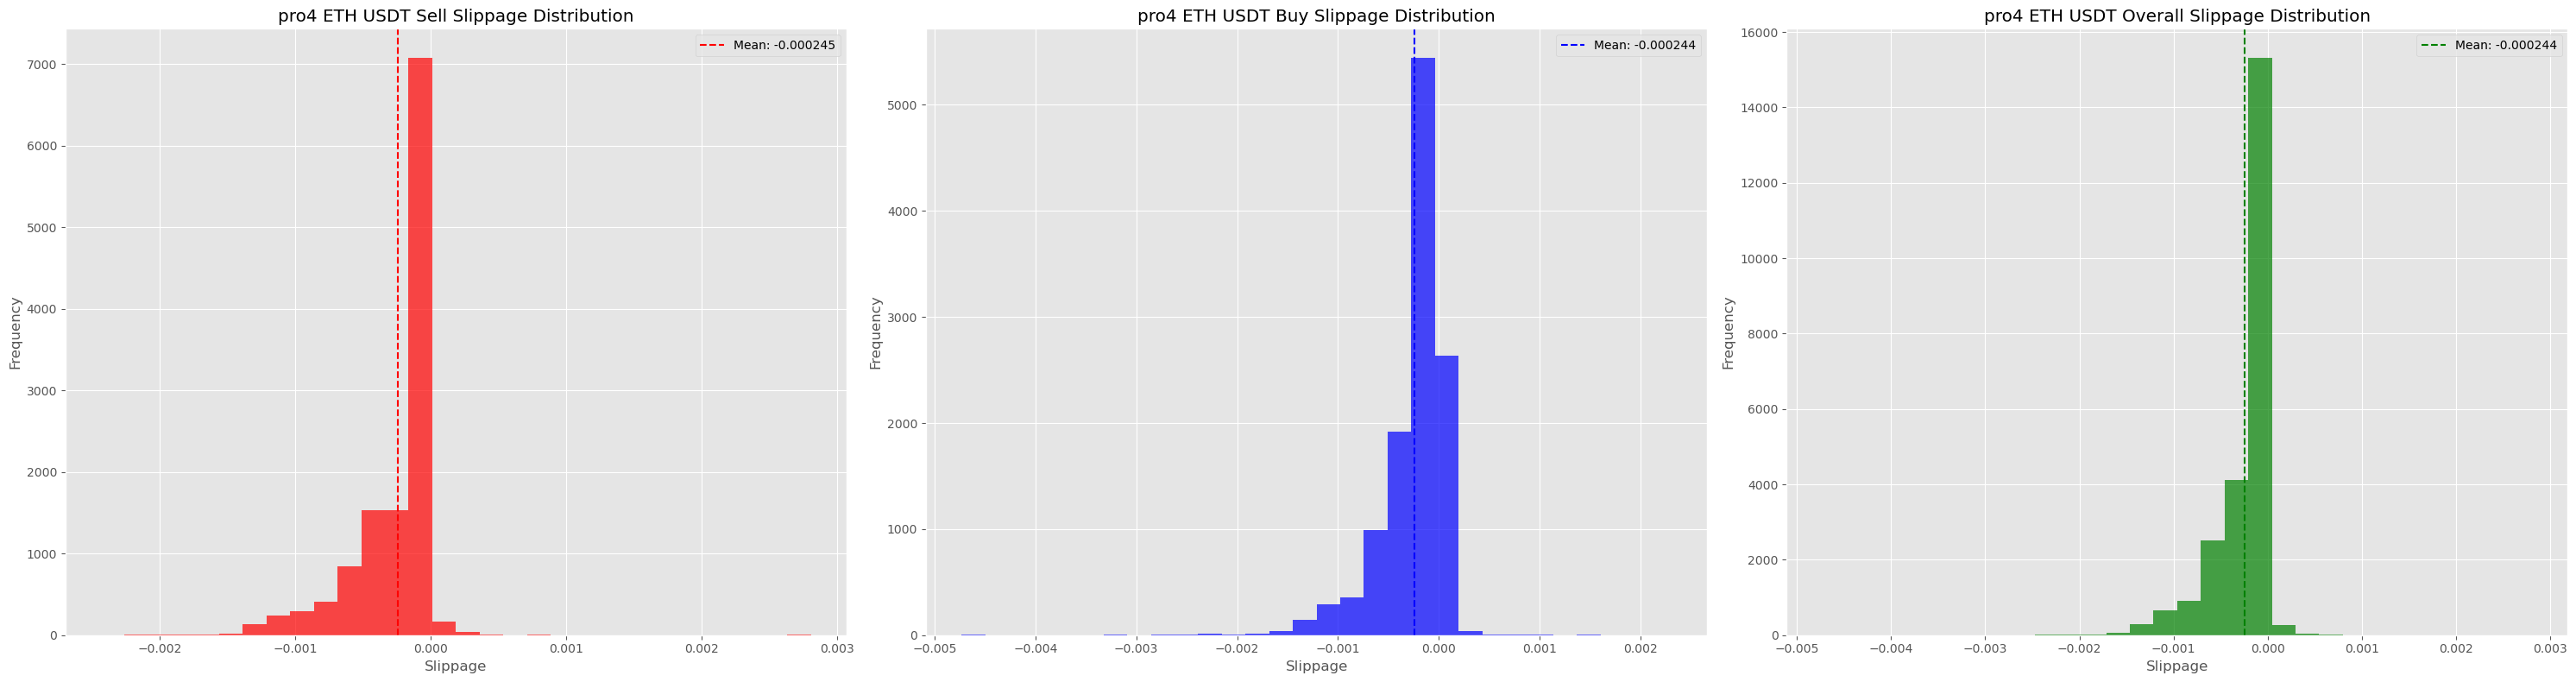

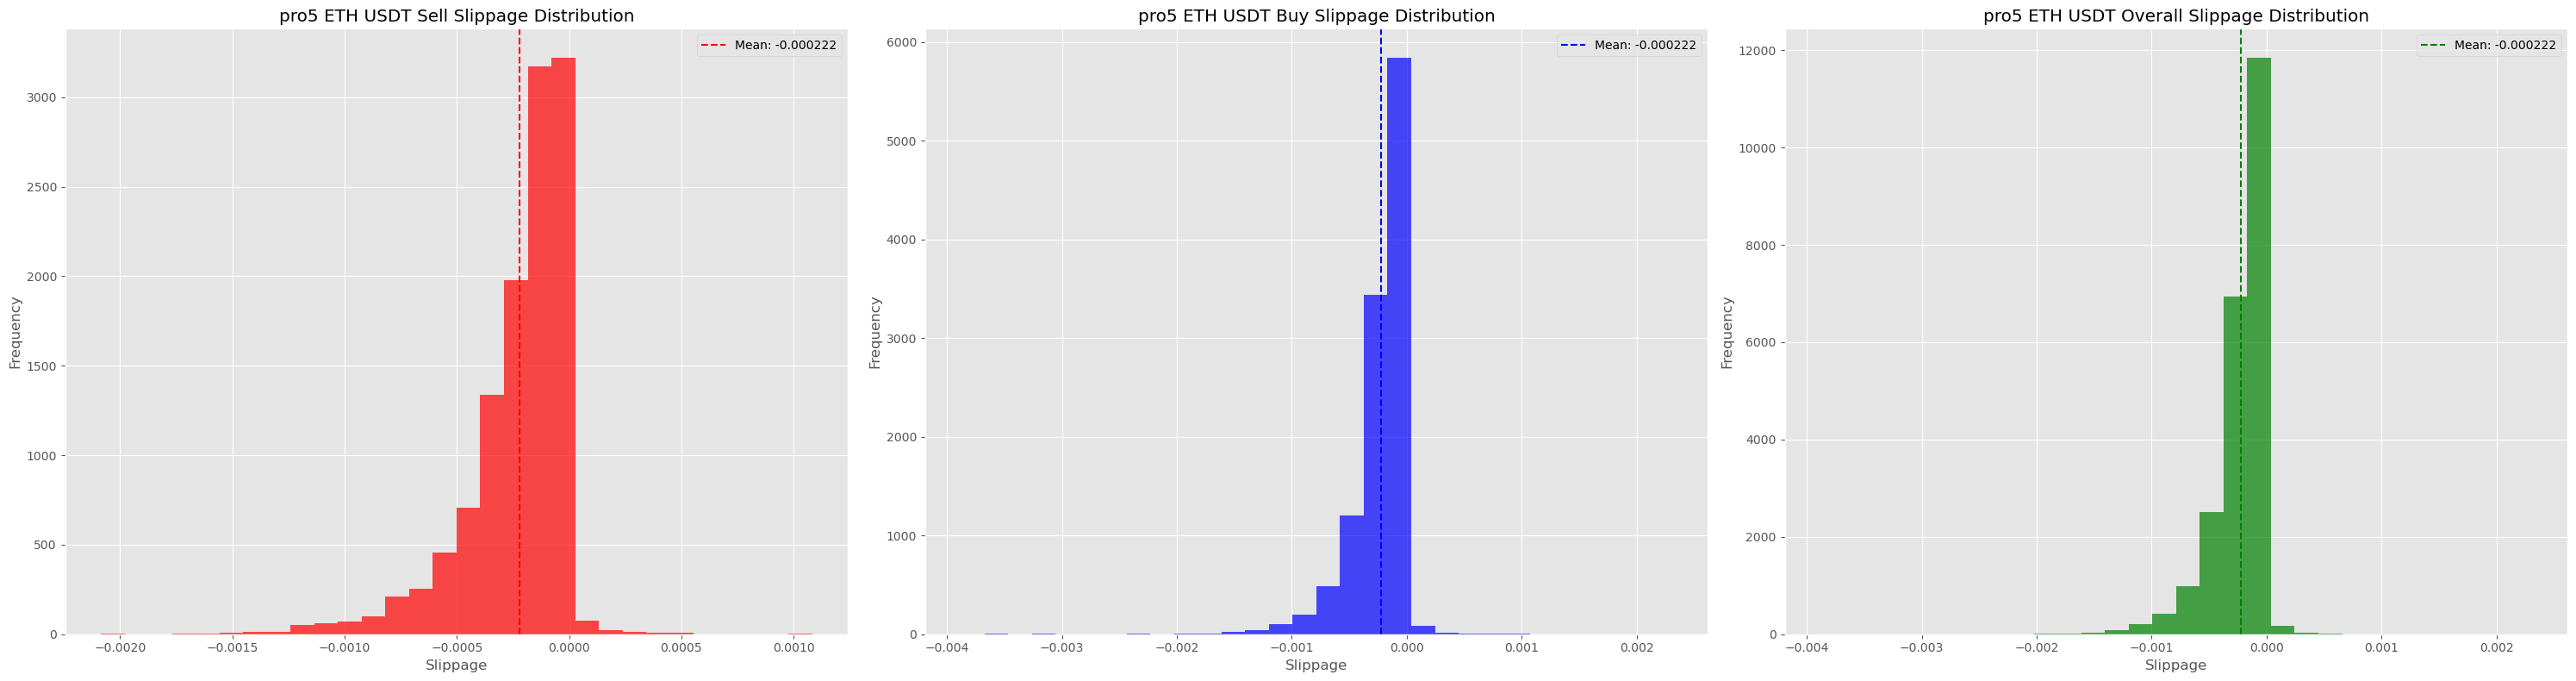

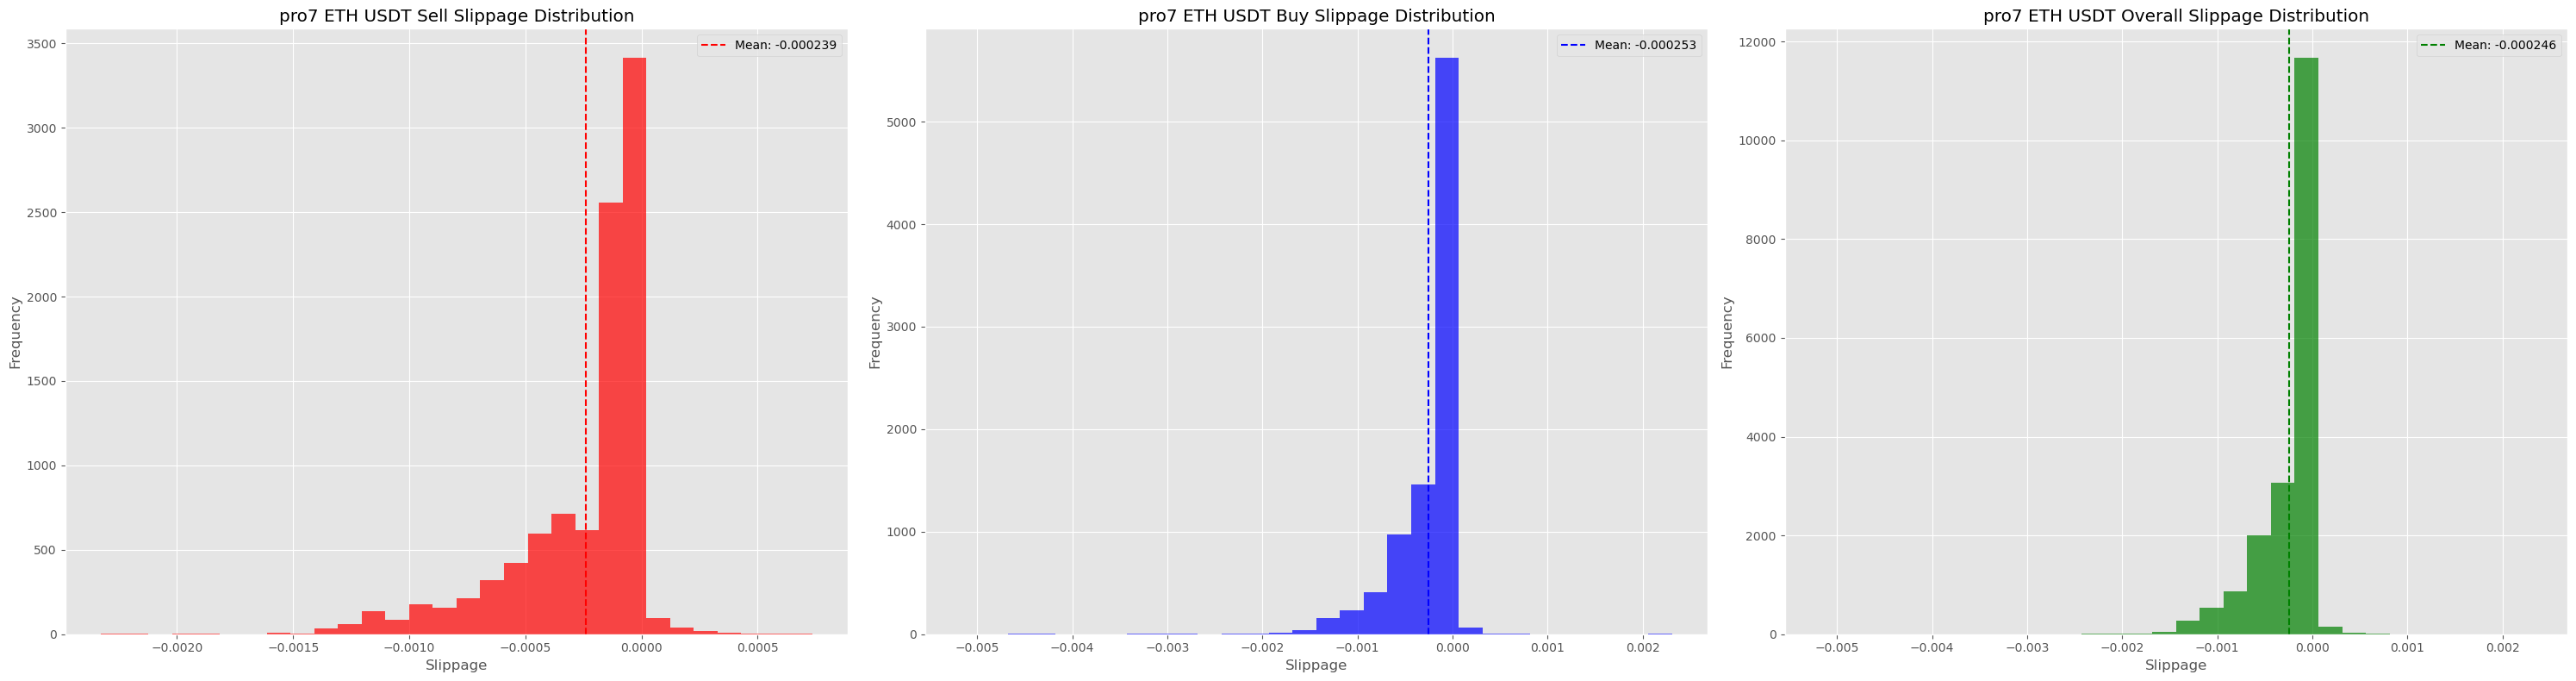

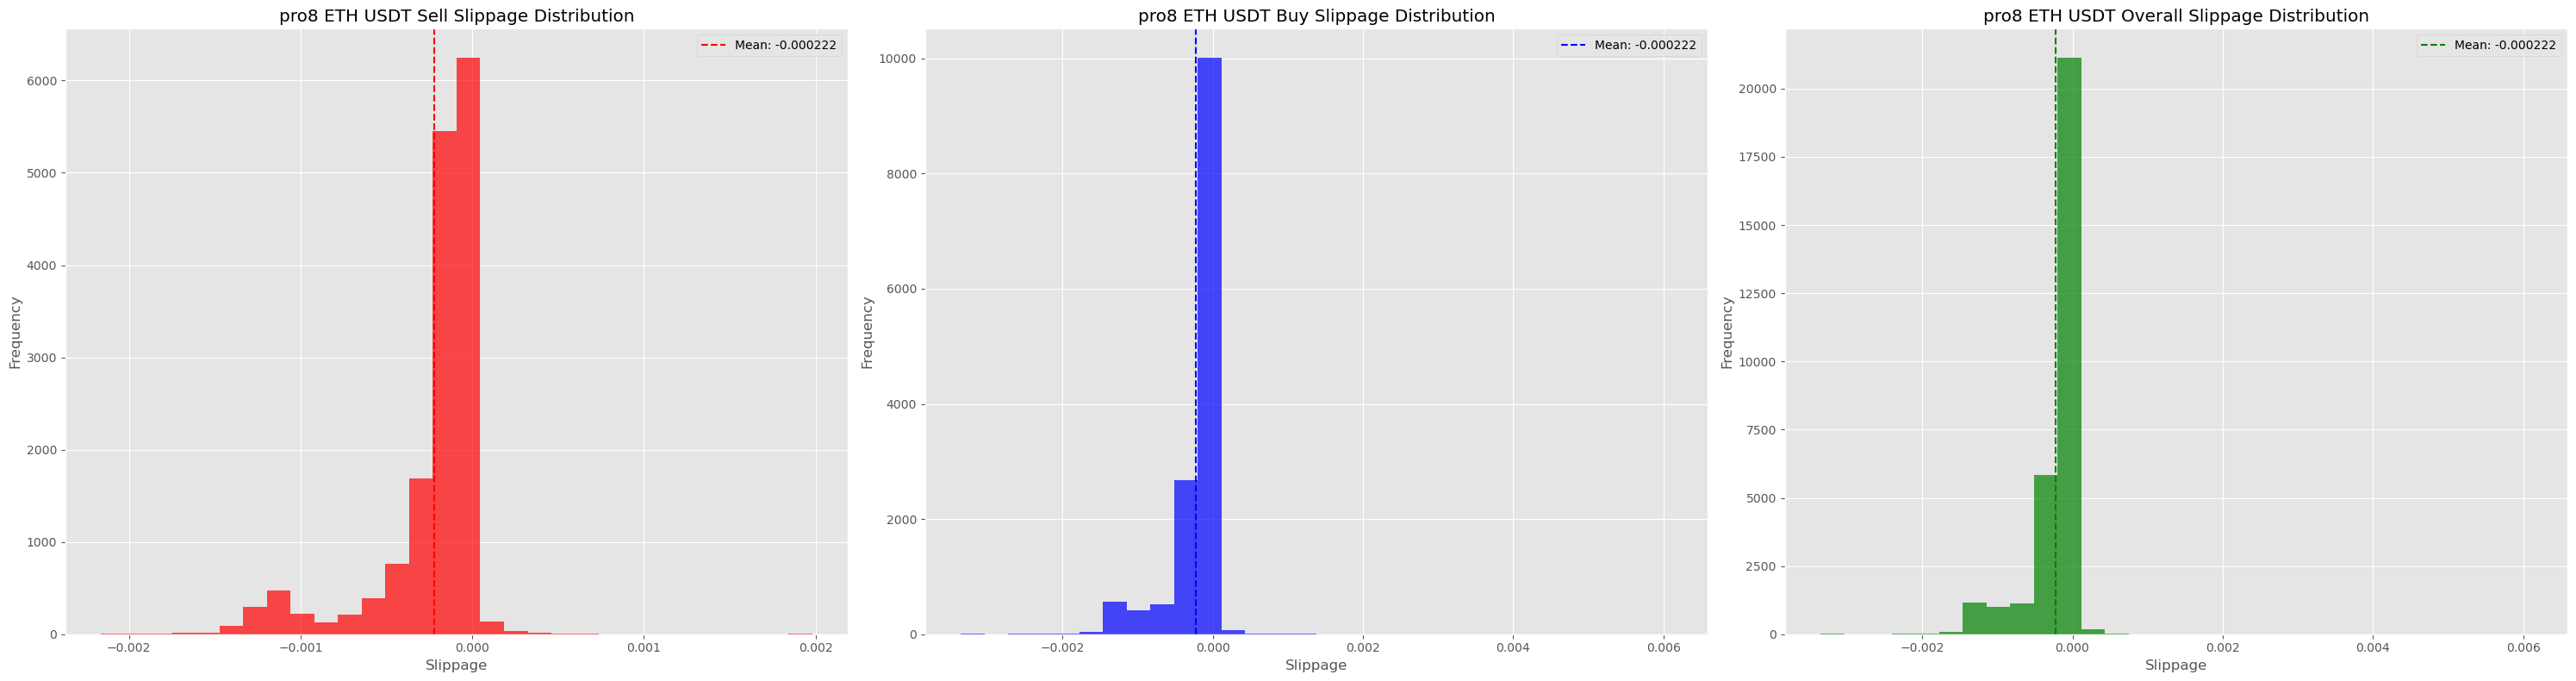

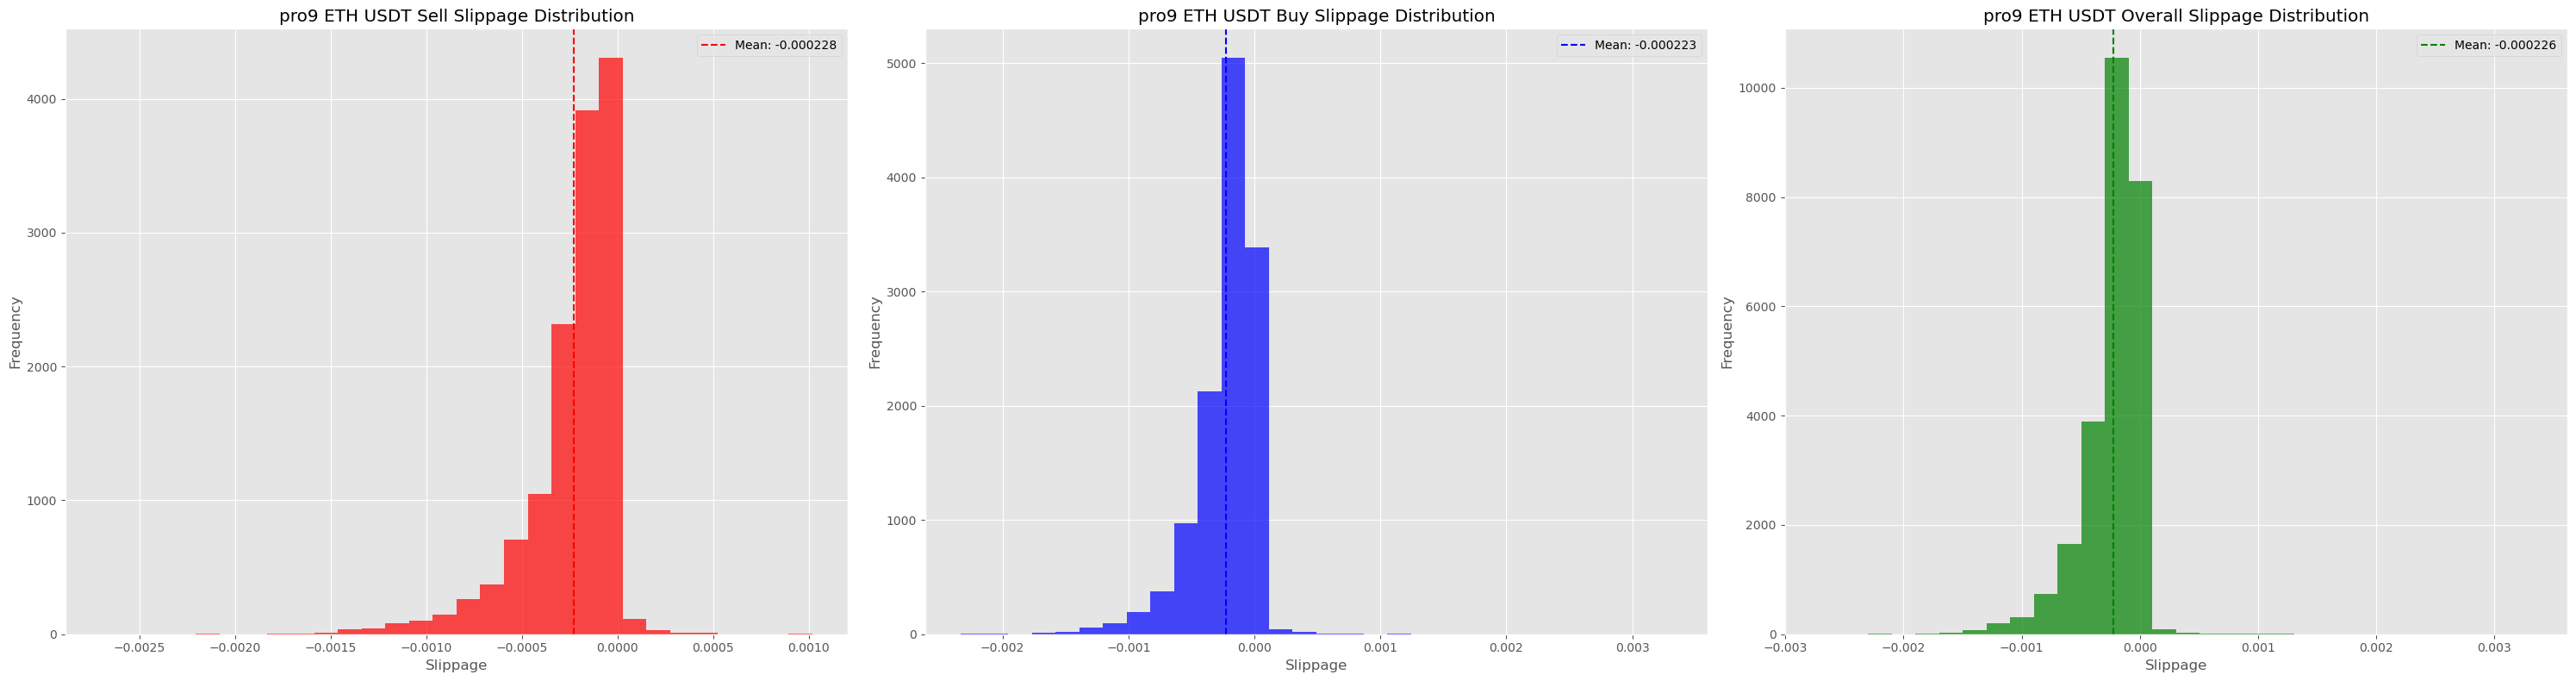

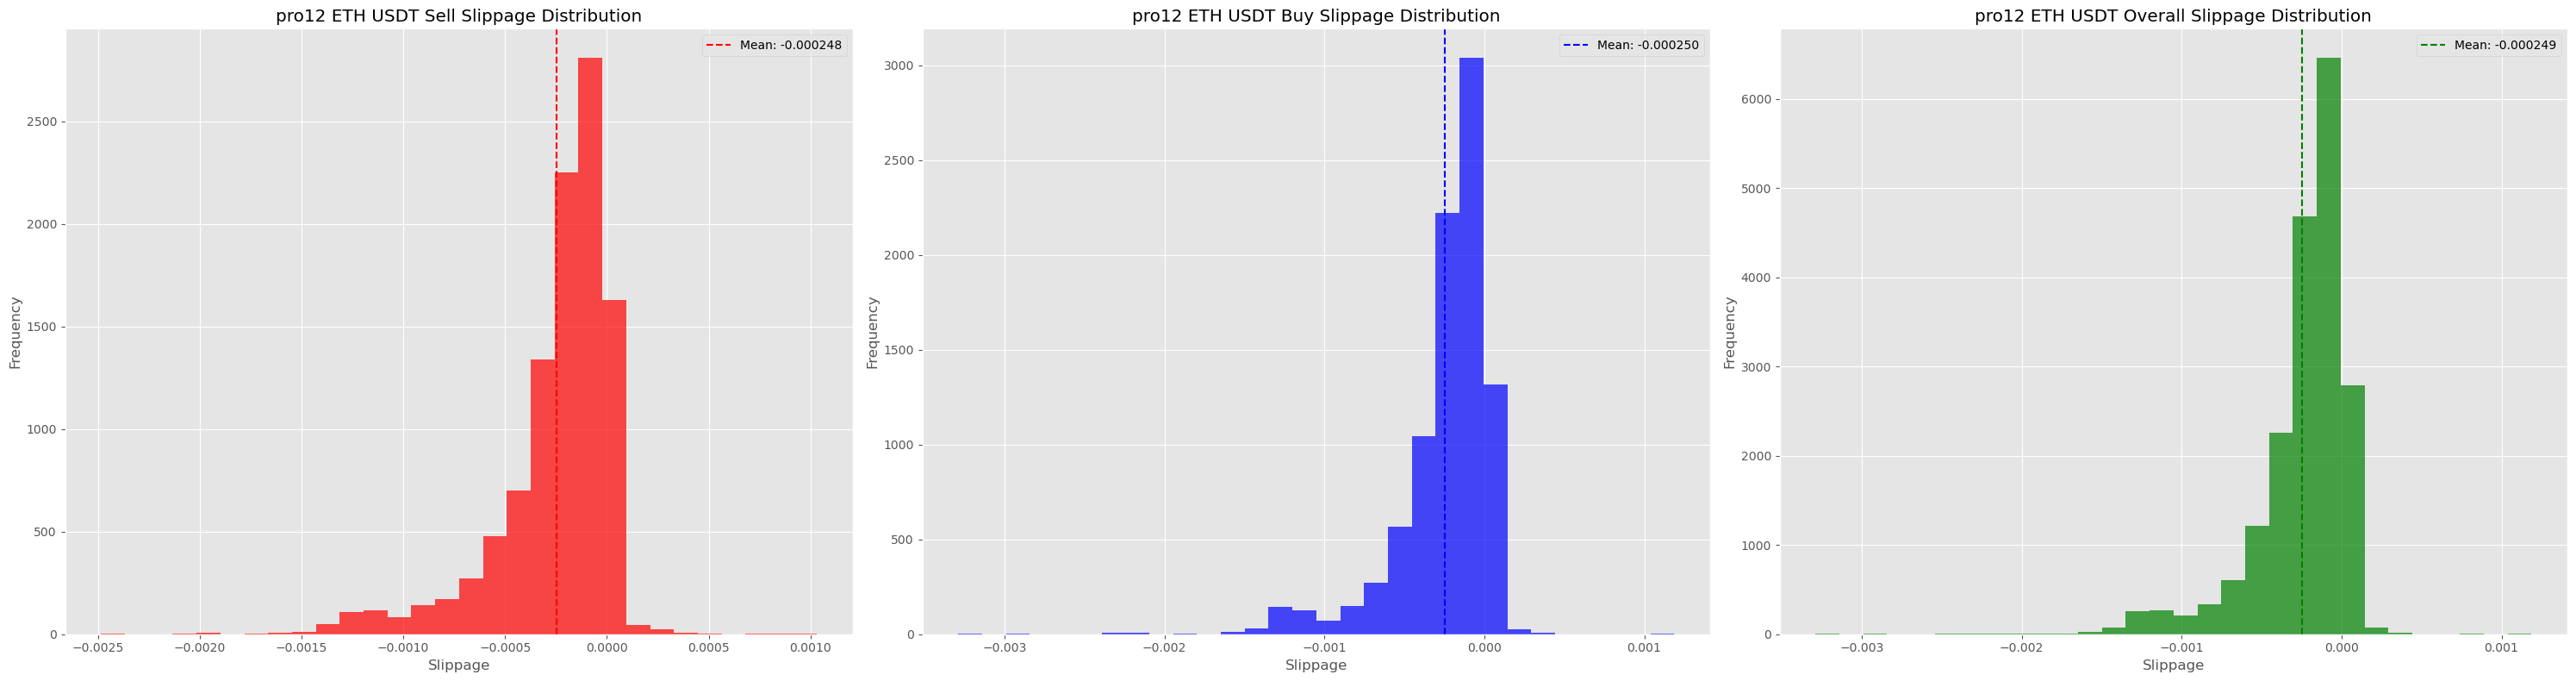

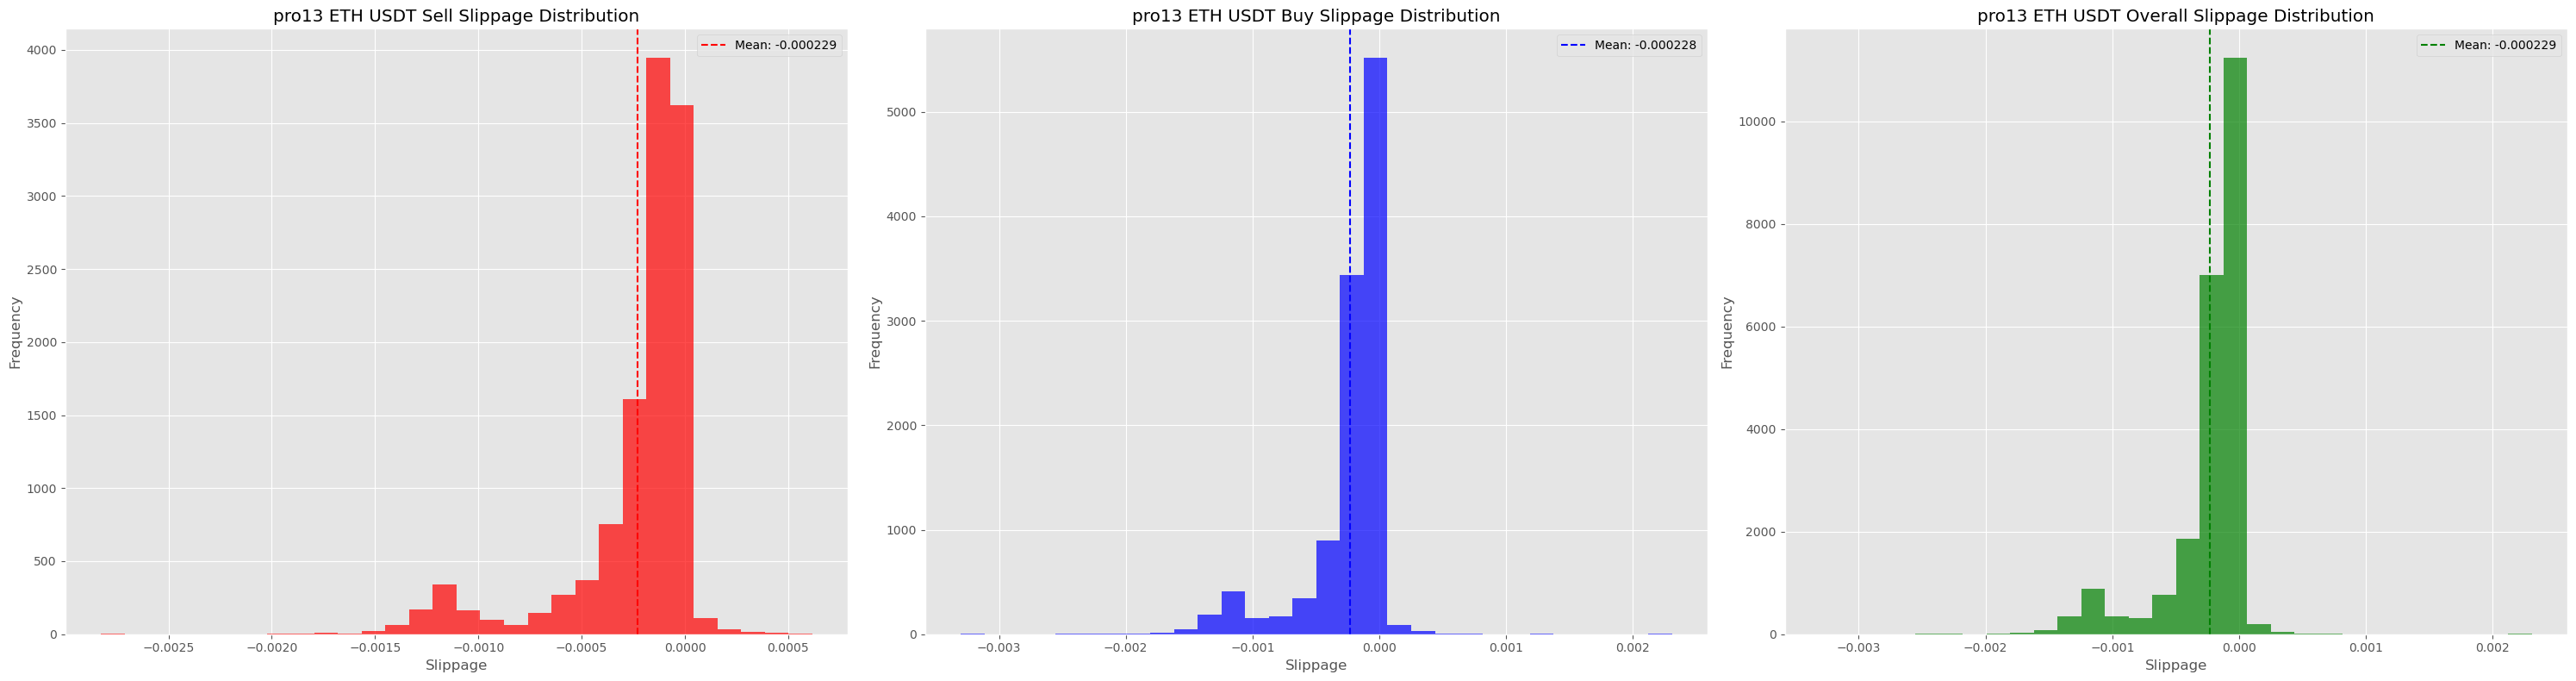

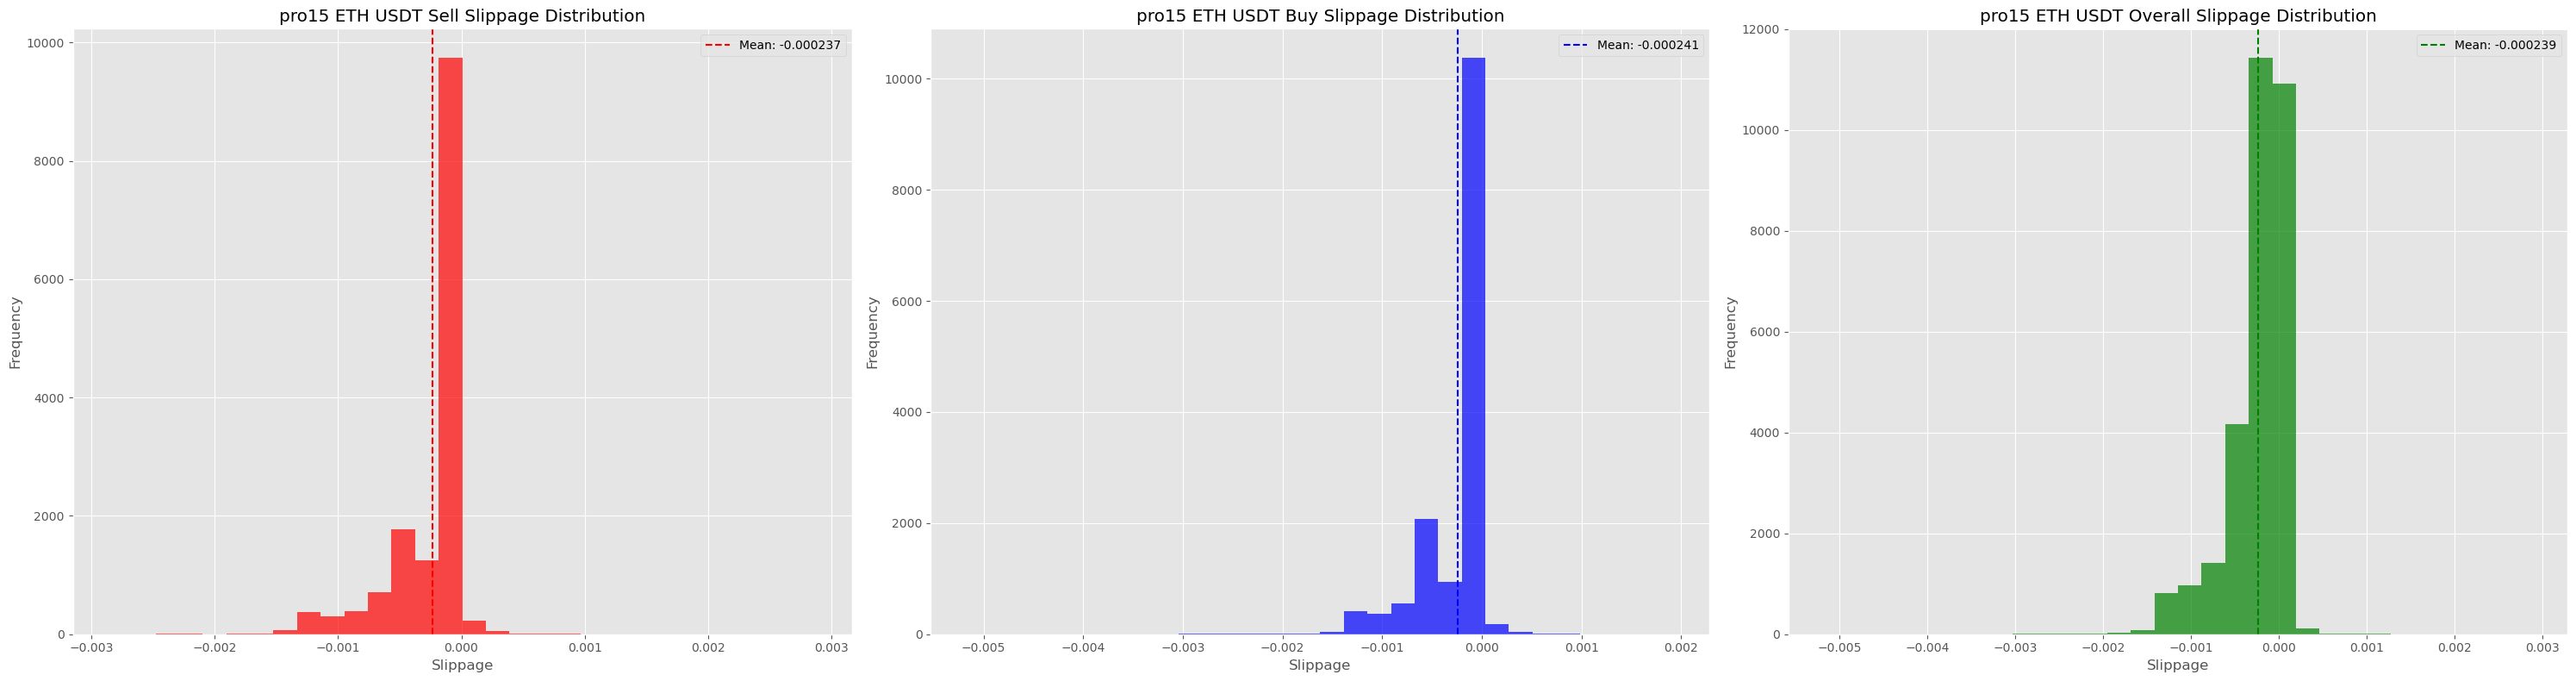

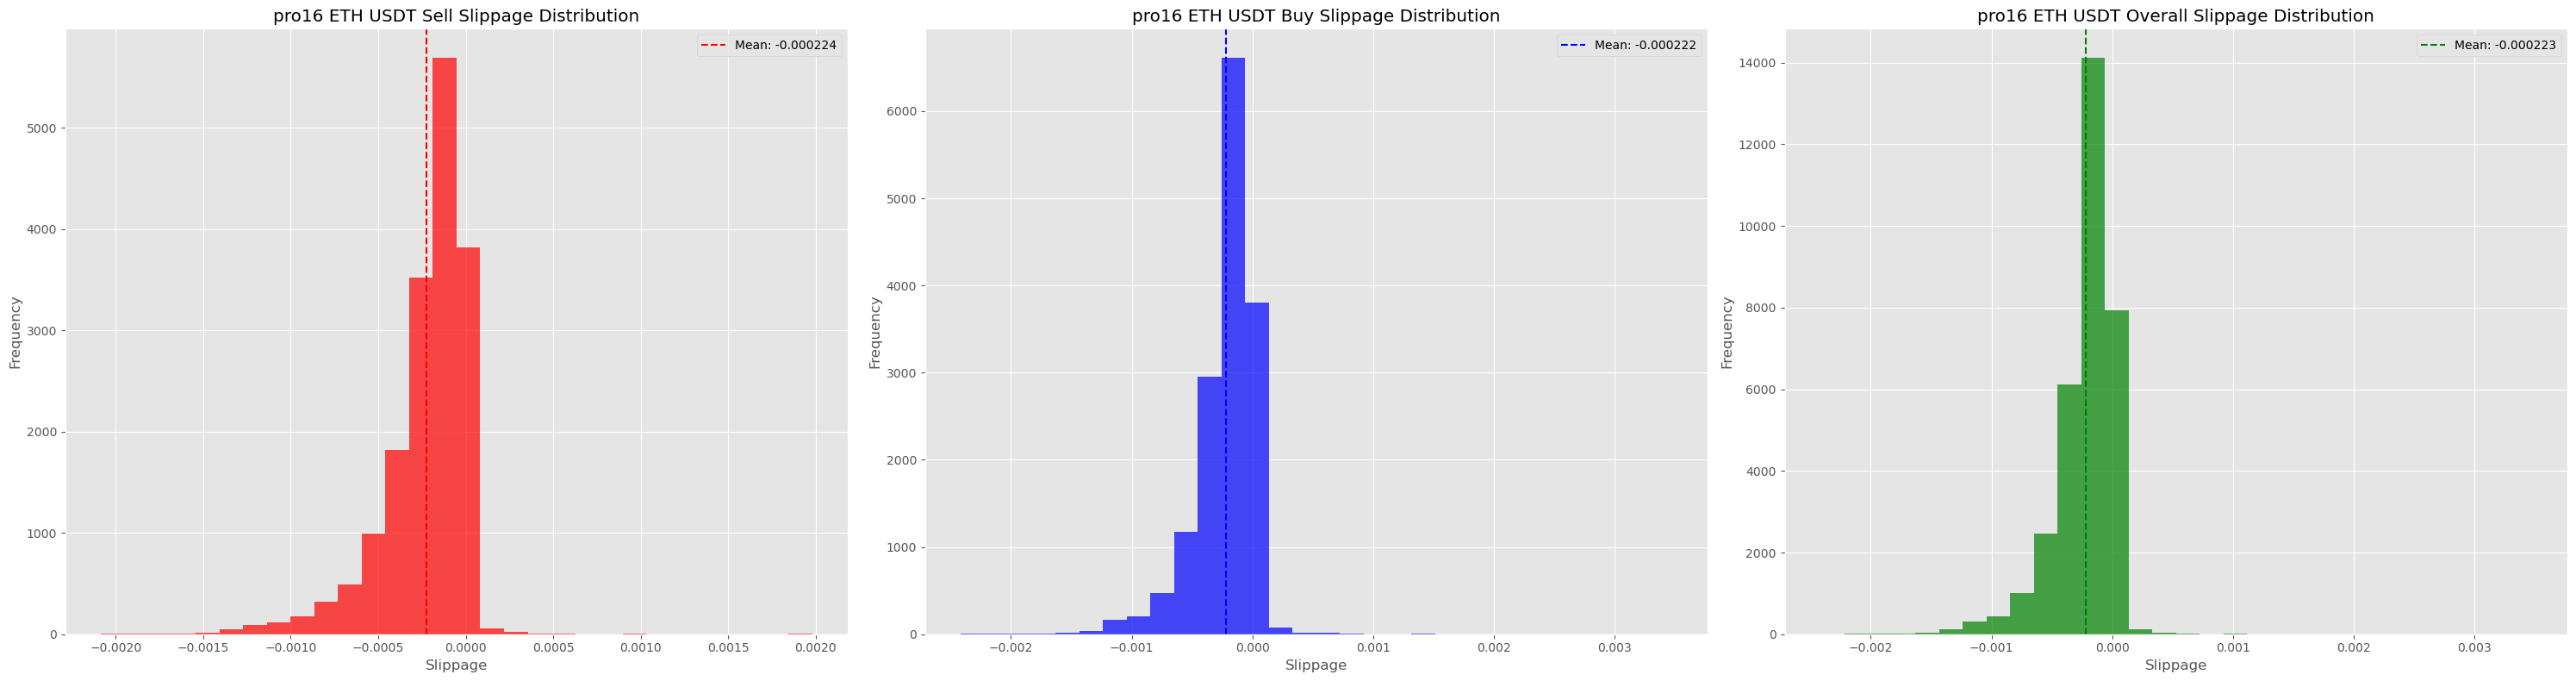

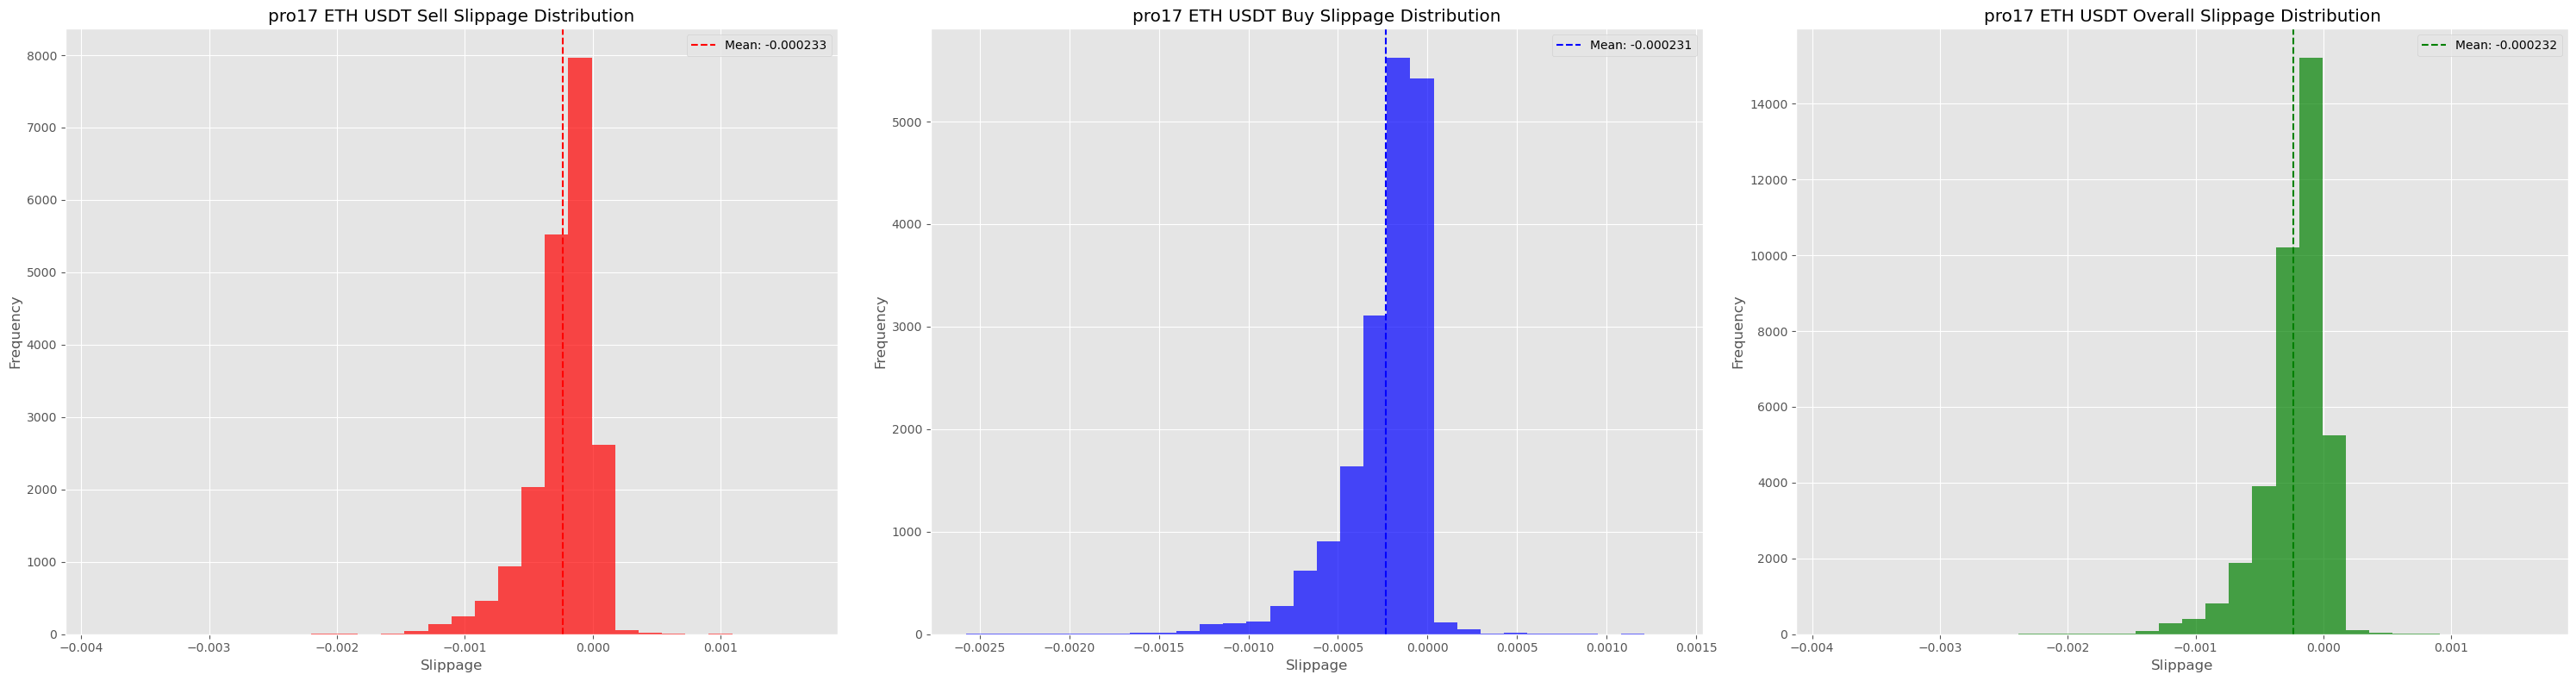

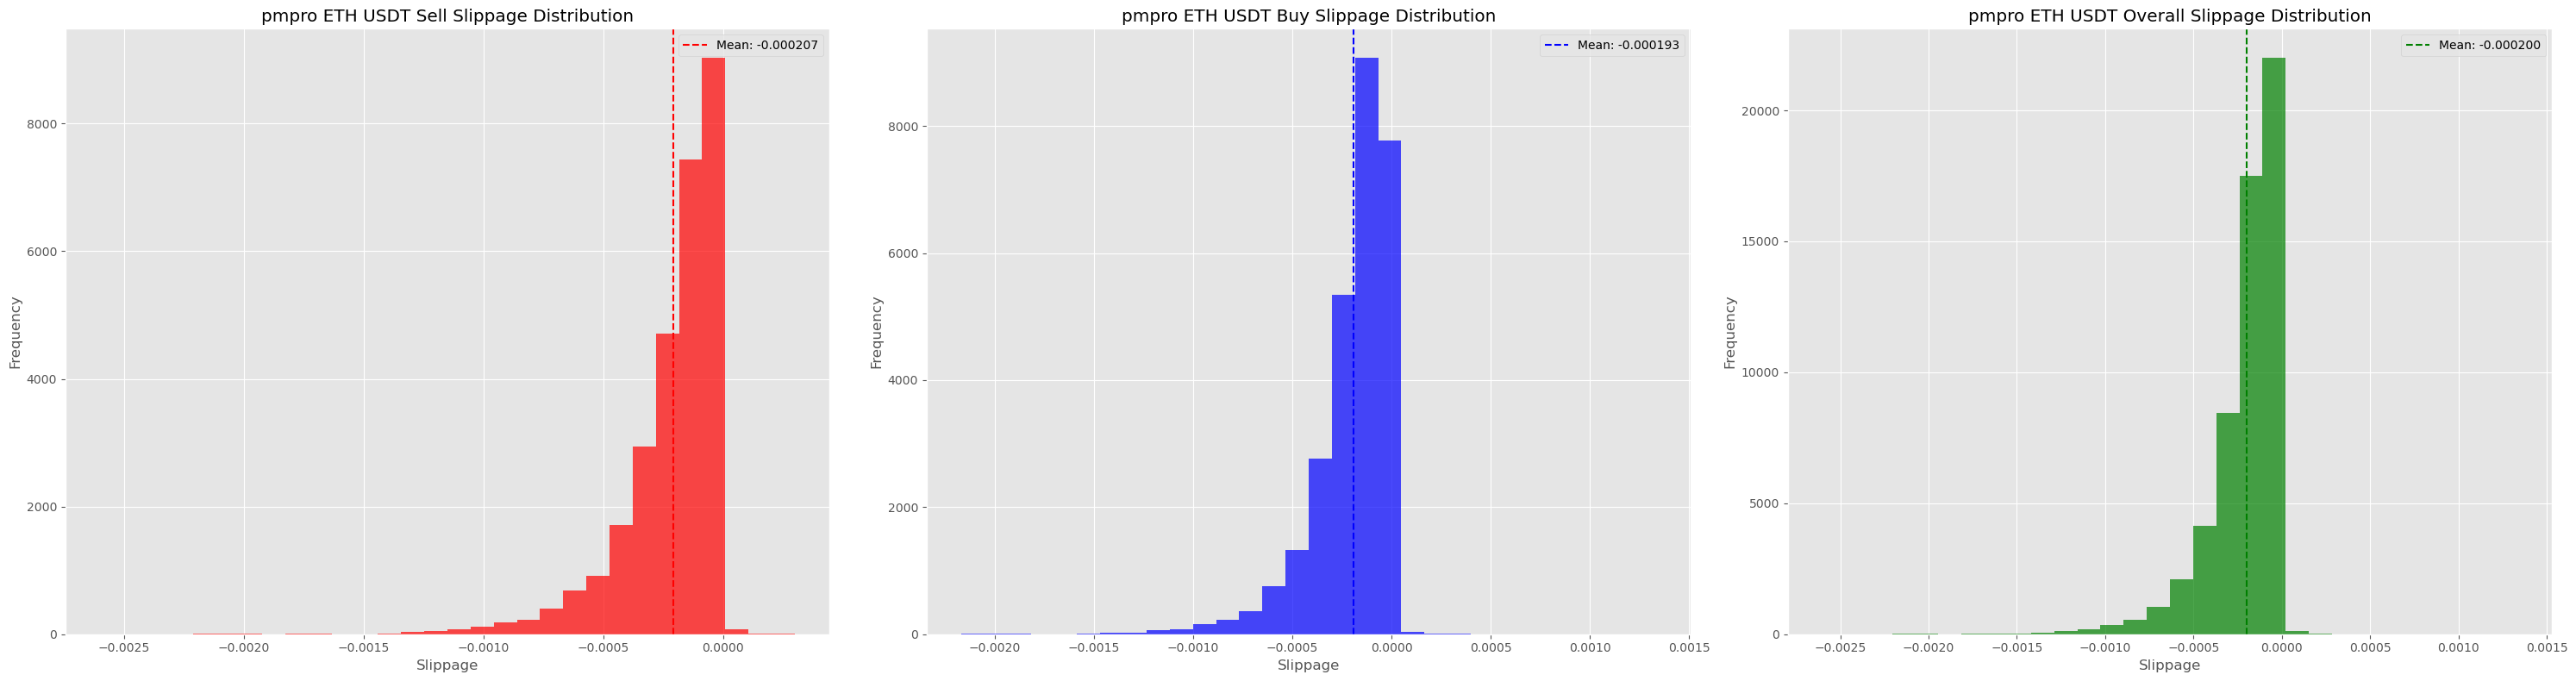

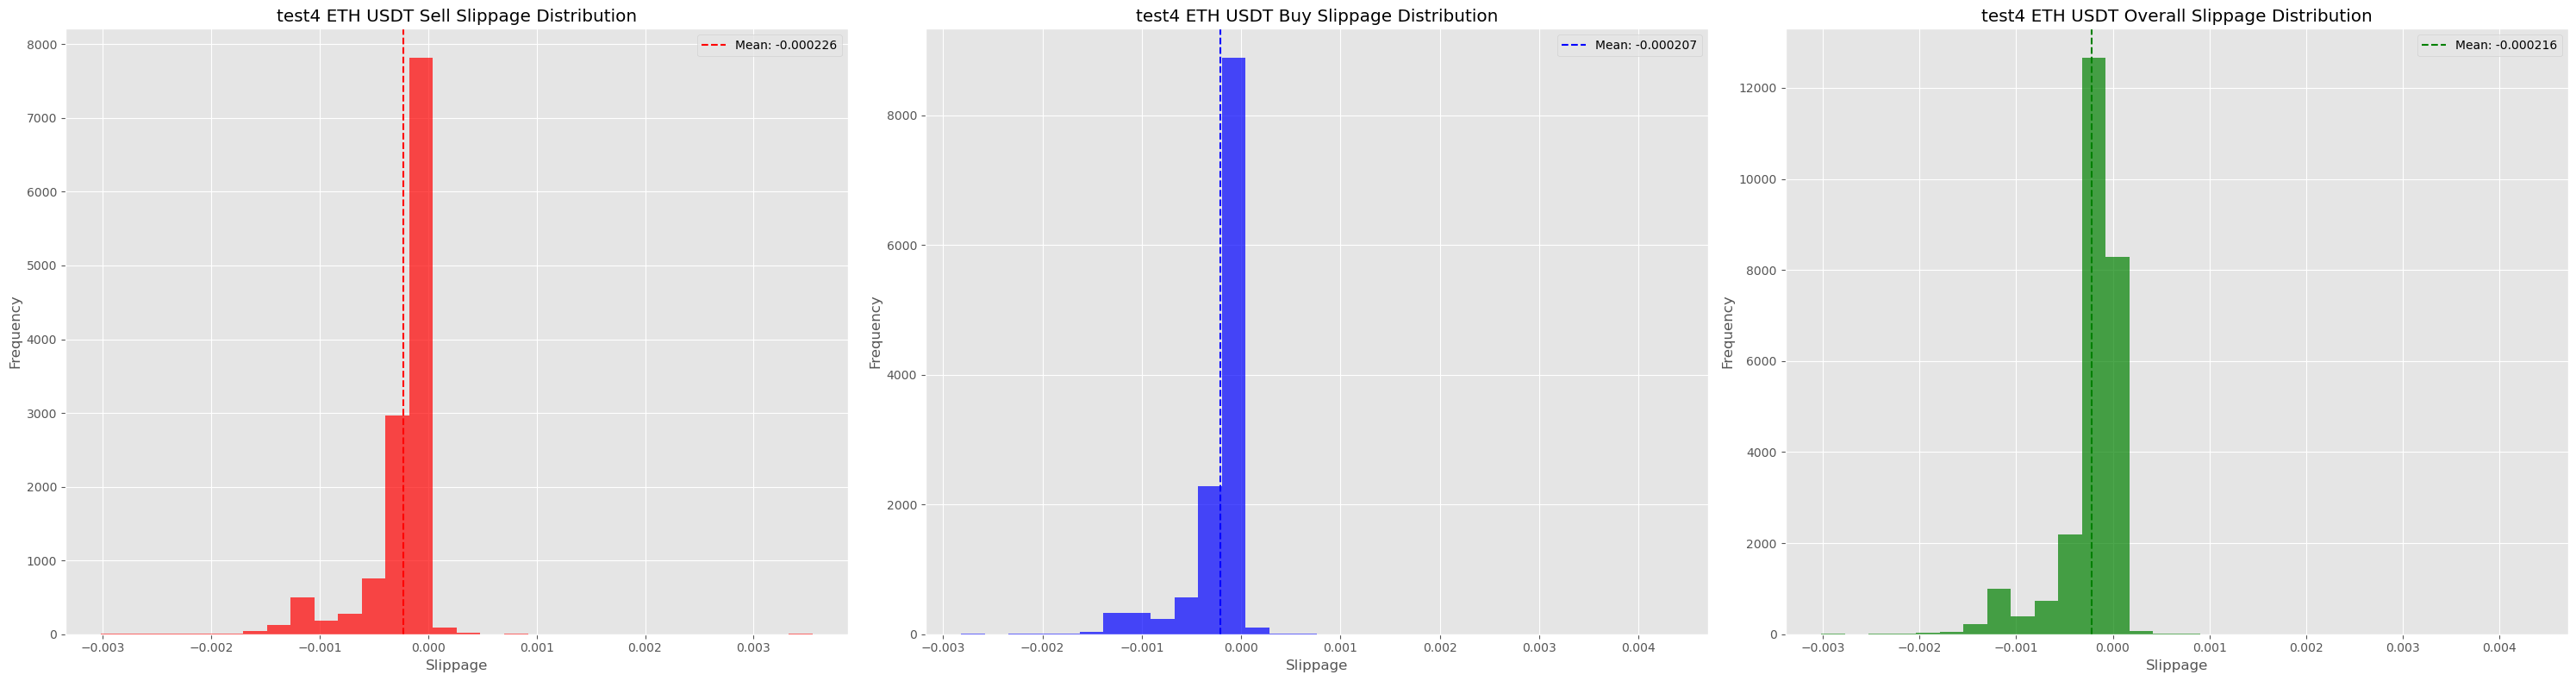

2025-11-24 13:30:00 2025-12-11 15:00:00


symbol                                            replace  count  \
env                                                                      
pmpro    ETH          msecs3000 replace1 median abnormal 0.0003  56741   
test4    ETH     msecs3000 replace300 10 median abnormal 0.0001  25660   
pro8     ETH  msecs10000 replace1_300_1_10 median abnormal 0...  30594   
pro5     ETH         msecs10000 replace1 median abnormal 0.0001  23268   
pro1     ETH          msecs8000 replace1 median abnormal 0.0001  33232   
pro16    ETH  msecs10000 replace1 median+cancel abnormal 0.0001  32786   
pro3     ETH  msecs5000 replace1_300_1_1 median abnormal 0.0002  51543   
pro9     ETH          msecs5000 replace1 median abnormal 0.0001  25907   
pro13    ETH  msecs8000 replace1_300_1_10 median abnormal 0....  23184   
pro17    ETH          msecs3000 replace1 median abnormal 0.0001  38282   
pro15    ETH        msecs5000 replace120 median abnormal 0.0001  30036   
pro2     ETH  msecs3000 replace1_300_1_3 median abnormal 0.0002  22323   
pro4     ETH       msecs10000 replace120 median abnormal 0.0001  24242   
pro7     ETH        msecs10000 replac120 median abnormal 0.0002  18717   
pro12    ETH  msecs5000 replace1_300_1_10 median abnormal 0....  19339   

           mean    median      std       min      max  percentile_5  \
env                                                                   
pmpro -0.000200 -0.000148 0.000208 -0.002599 0.001333     -0.000600   
test4 -0.000216 -0.000122 0.000310 -0.003017 0.004341     -0.001068   
pro8  -0.000222 -0.000118 0.000326 -0.003354 0.006113     -0.001113   
pro5  -0.000222 -0.000160 0.000241 -0.003881 0.002307     -0.000684   
pro1  -0.000223 -0.000162 0.000243 -0.002616 0.002367     -0.000688   
pro16 -0.000223 -0.000162 0.000246 -0.002417 0.003473     -0.000691   
pro3  -0.000224 -0.000125 0.000316 -0.003860 0.003205     -0.001101   
pro9  -0.000226 -0.000163 0.000250 -0.002703 0.003315     -0.000714   
pro13 -0.000229 -0.000124 0.000328 -0.003302 0.002309     -0.001123   
pro17 -0.000232 -0.000173 0.000245 -0.003850 0.001641     -0.000706   
pro15 -0.000239 -0.000106 0.000334 -0.005174 0.002878     -0.000976   
pro2  -0.000243 -0.000147 0.000294 -0.003302 0.001327     -0.000861   
pro4  -0.000244 -0.000117 0.000318 -0.004732 0.002810     -0.000910   
pro7  -0.000246 -0.000116 0.000323 -0.005174 0.002307     -0.000929   
pro12 -0.000249 -0.000163 0.000294 -0.003290 0.001188     -0.000864   

       percentile_10  percentile_25  percentile_50  percentile_60  \
env                                                                 
pmpro      -0.000450      -0.000276      -0.000148      -0.000112   
test4      -0.000530      -0.000239      -0.000122      -0.000093   
pro8       -0.000579      -0.000238      -0.000118      -0.000091   
pro5       -0.000515      -0.000310      -0.000160      -0.000121   
pro1       -0.000516      -0.000307      -0.000162      -0.000124   
pro16      -0.000526      -0.000312      -0.000162      -0.000123   
pro3       -0.000562      -0.000249      -0.000125      -0.000096   
pro9       -0.000536      -0.000309      -0.000163      -0.000123   
pro13      -0.000612      -0.000254      -0.000124      -0.000095   
pro17      -0.000534      -0.000321      -0.000173      -0.000132   
pro15      -0.000646      -0.000350      -0.000106      -0.000082   
pro2       -0.000581      -0.000326      -0.000147      -0.000111   
pro4       -0.000654      -0.000370      -0.000117      -0.000089   
pro7       -0.000665      -0.000371      -0.000116      -0.000089   
pro12      -0.000587      -0.000327      -0.000163      -0.000123   

       percentile_75  percentile_95  BNFirstSlippage  BNFirstSlippage_count  \
env                                                                           
pmpro      -0.000060       0.000000        -0.000199                  27058   
test4      -0.000050       0.000000        -0.000225                  12112   
pro8       -0.000048       0.000000        -0.000

In [4]:
import pandas as pd


symbol = 'ETH'
env_list = ['pro1','pro2','pro3','pro4','pro5','pro7', 'pro8','pro9', 'pro12','pro13','pro15','pro16','pro17','pmpro','test4']
# env_list = ['pmpro','test4','pro1','pro12']
replace_dict = {
'pro1': 'msecs8000 replace1 median abnormal 0.0001', # 3000 -> 8000
'pro2': 'msecs3000 replace1_300_1_3 median abnormal 0.0002',# 3000 -> 10000， 0.0001 -> 0.0002
'pro3': 'msecs5000 replace1_300_1_1 median abnormal 0.0002', # 3000 -> 5000，0.0001 -> 0.0002


'pro4': 'msecs10000 replace120 median abnormal 0.0001', # 3000 -> 10000， 0.0002 -> 0.0001
'pro5': 'msecs10000 replace1 median abnormal 0.0001',  # 保留
'pro7': 'msecs10000 replac120 median abnormal 0.0002', # 保留
'pro8': 'msecs10000 replace1_300_1_10 median abnormal 0.0001', # 保留
'pro9': 'msecs5000 replace1 median abnormal 0.0001', #  保留
'pro12': 'msecs5000 replace1_300_1_10 median abnormal 0.0001', # 3000 -> 5000，0.0001 -> 0.0002


'pro13': 'msecs8000 replace1_300_1_10 median abnormal 0.0002', # 3000 -> 8000，0.0001 -> 0.0002
'pro15': 'msecs5000 replace120 median abnormal 0.0001',# 0.0002 - > 0.0001
'pro16': 'msecs10000 replace1 median+cancel abnormal 0.0001',  # 保留
'pro17': 'msecs3000 replace1 median abnormal 0.0001', # 保留

'pmpro': 'msecs3000 replace1 median abnormal 0.0003',
'test4': 'msecs3000 replace300 10 median abnormal 0.0001',
'pro14':'tbd'}

start_date = '2025-11-24 13:30:00'
# start_date = '2025-12-11 15:30:00'
end_date = '2025-12-11 15:00:00'

summary = []

for env in env_list:
    file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.close.csv'
    file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.open.csv'
    if env == 'pmpro':
        file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.close.csv'
        file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.open.csv'
    slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


    # 创建子图  
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

    # 分析卖出滑点
    sell_slippage = short_slippage['slippage']
    sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
    ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
    ax1.set_xlabel('Slippage')
    ax1.set_ylabel('Frequency')
    sell_mean = sell_slippage.mean()
    sell_std = sell_slippage.std()
    ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
    ax1.legend()
    # print('sell count', len(sell_slippage))


    # 分析买入滑点
    buy_slippage = long_slippage['slippage']
    buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
    ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
    ax2.set_xlabel('Slippage')
    ax2.set_ylabel('Frequency')
    buy_mean = buy_slippage.mean()
    buy_std = buy_slippage.std()
    ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
    ax2.legend()
    # print('buy count', len(buy_slippage))

    # overall滑点分布
    slippage_array = slippage_df_selected['slippage'].values
    slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
    ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
    ax3.set_xlabel('Slippage')
    ax3.set_ylabel('Frequency')
    overall_mean = slippage_array.mean()
    ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    stats = {
        'symbol': symbol,
        'env': env,
        'replace': replace_dict[env],
        'count': len(slippage_array),
        'mean': np.mean(slippage_array),
        'median': np.median(slippage_array),
        'std': np.std(slippage_array),
        'min': np.min(slippage_array),
        'max': np.max(slippage_array),
        # 'percentile_1': np.percentile(slippage_array, 1),
        'percentile_5': np.percentile(slippage_array, 5),
        'percentile_10': np.percentile(slippage_array, 10),
        'percentile_25': np.percentile(slippage_array, 25),
        'percentile_50': np.percentile(slippage_array, 50),
        # 'percentile_55': np.percentile(slippage_array, 55),        
        'percentile_60': np.percentile(slippage_array, 60),
        # 'percentile_65': np.percentile(slippage_array, 65),
        'percentile_75': np.percentile(slippage_array, 75),
        'percentile_95': np.percentile(slippage_array, 95),
        # 'percentile_99': np.percentile(slippage_array, 99),
        'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
        'BNFirstSlippage_count': len(Exchange1FirstSlippage),
        'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
        'OKFirstSlippage_count': len(Exchange2FirstSlippage),
    }

    summary.append(stats)

df = pd.DataFrame(summary).set_index('env').sort_values(by='mean', ascending=False)
print(start_date,end_date)
df

# 1230

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:5: DtypeWarning: Columns (1,9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:6: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:8

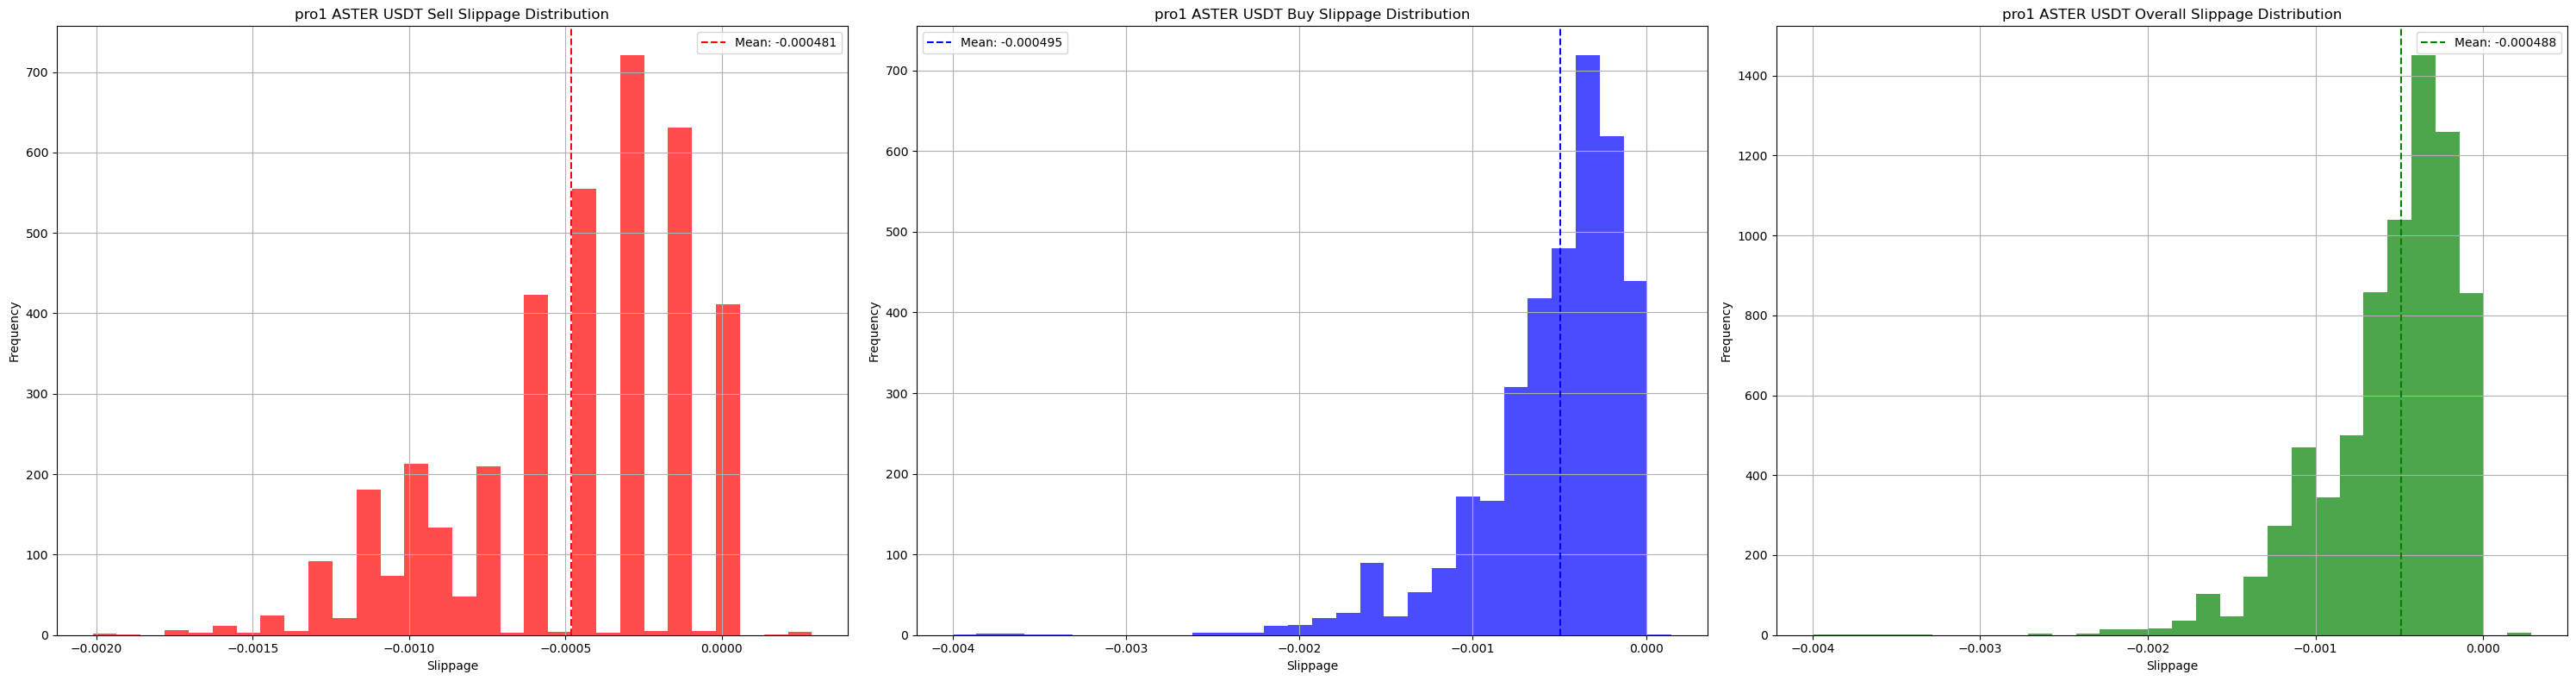

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

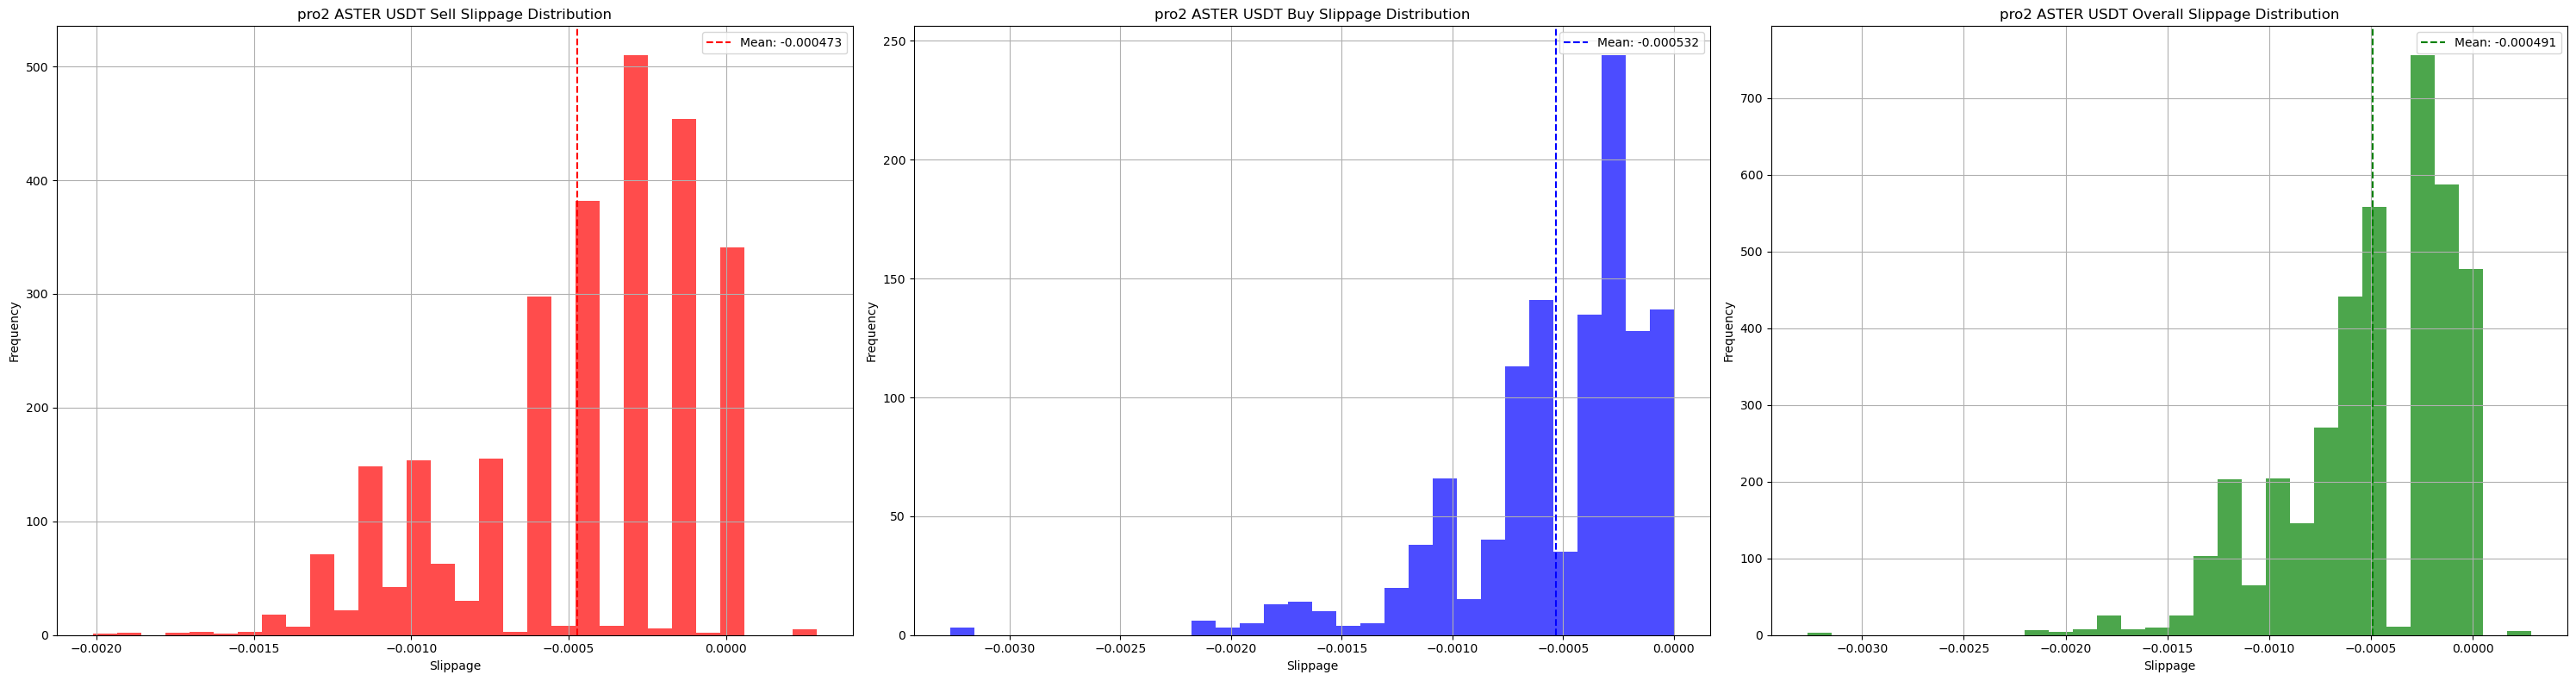

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

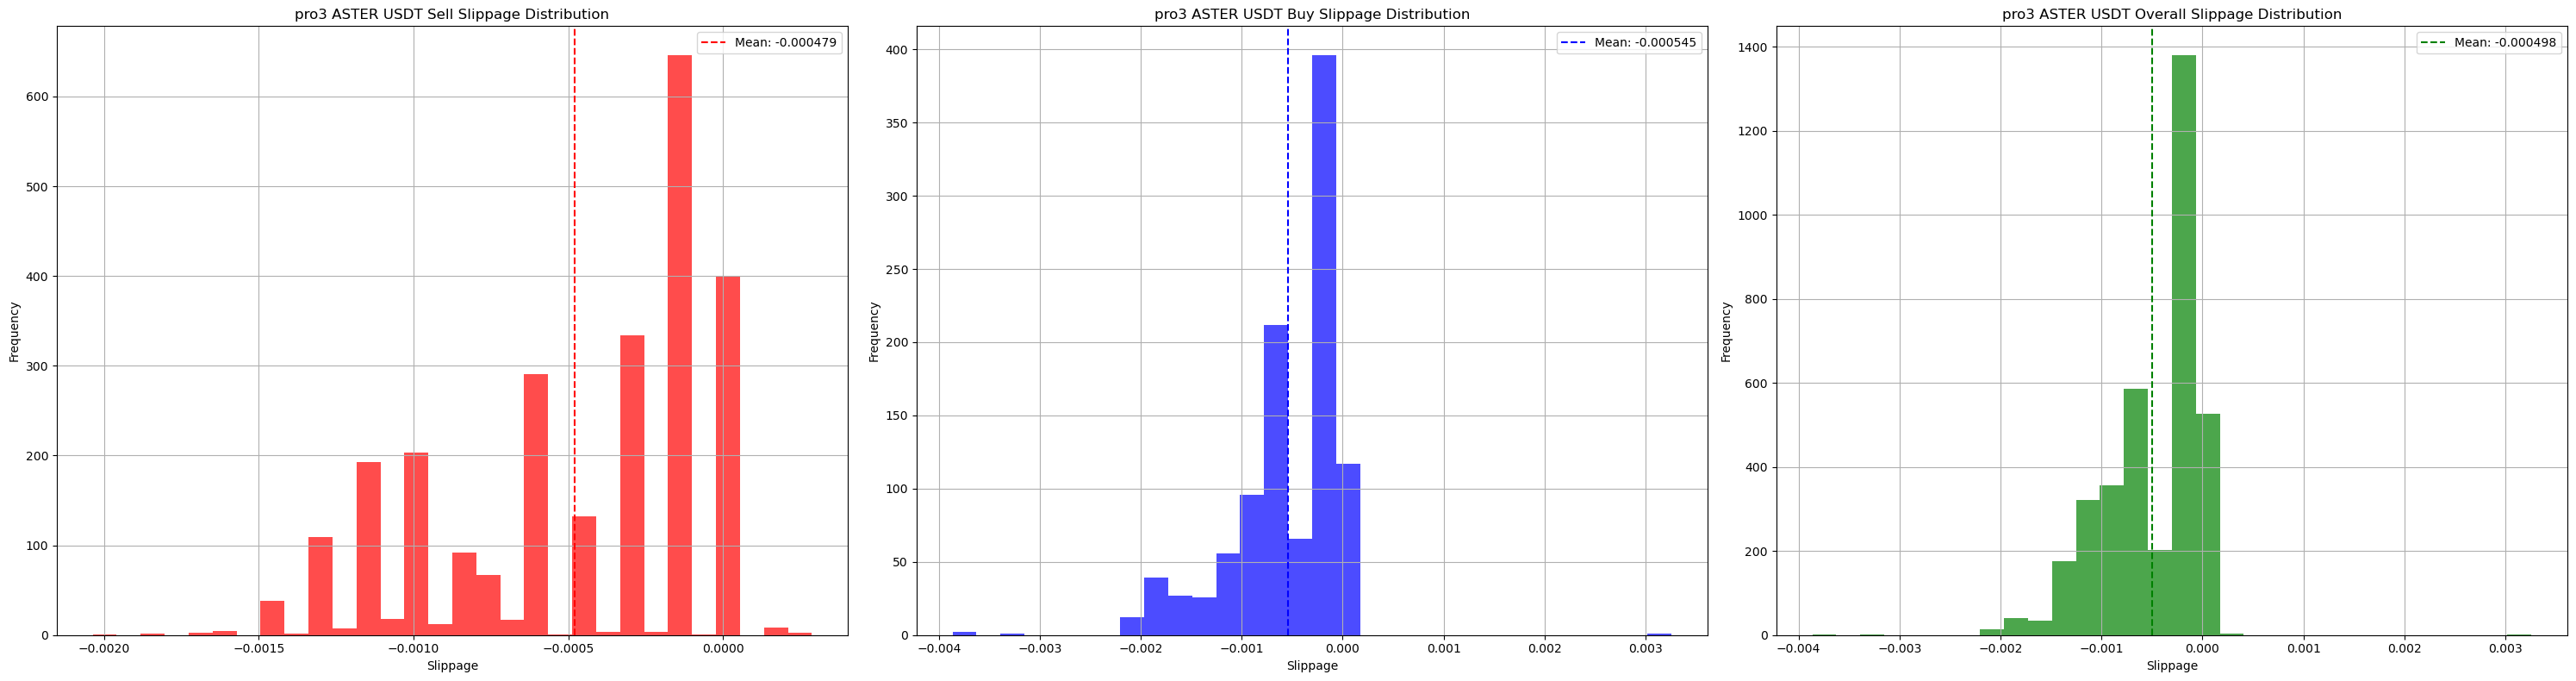

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

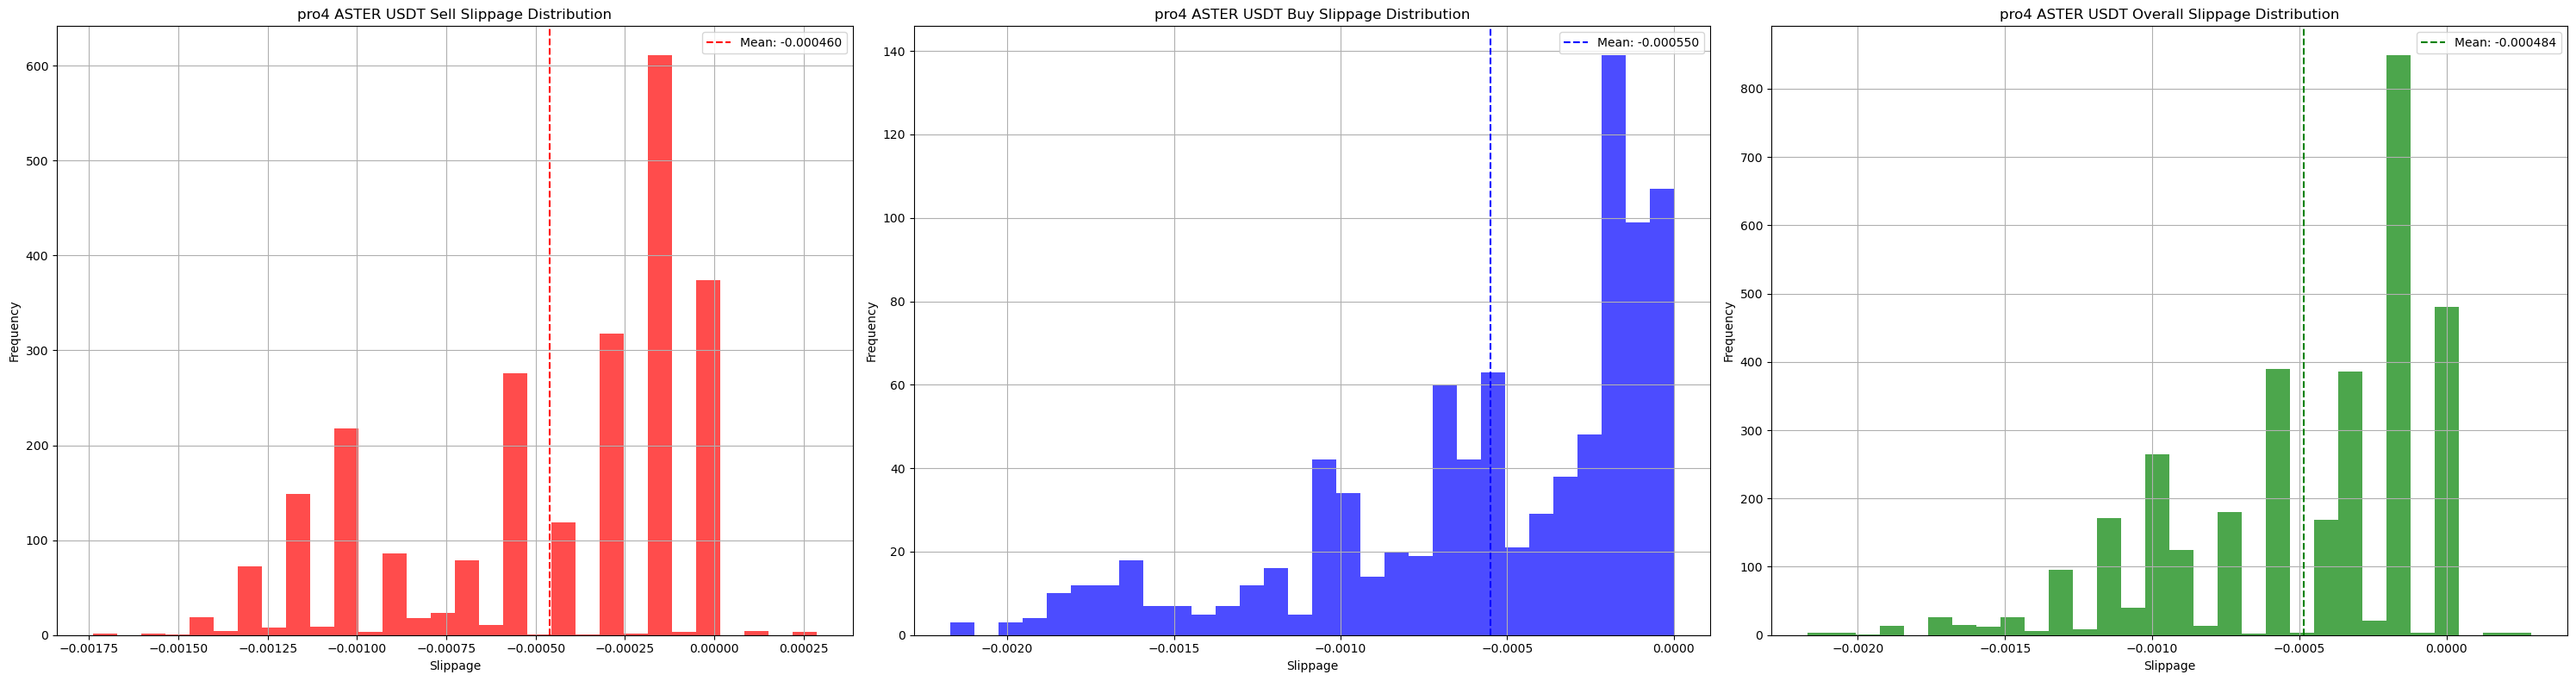

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_26950/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

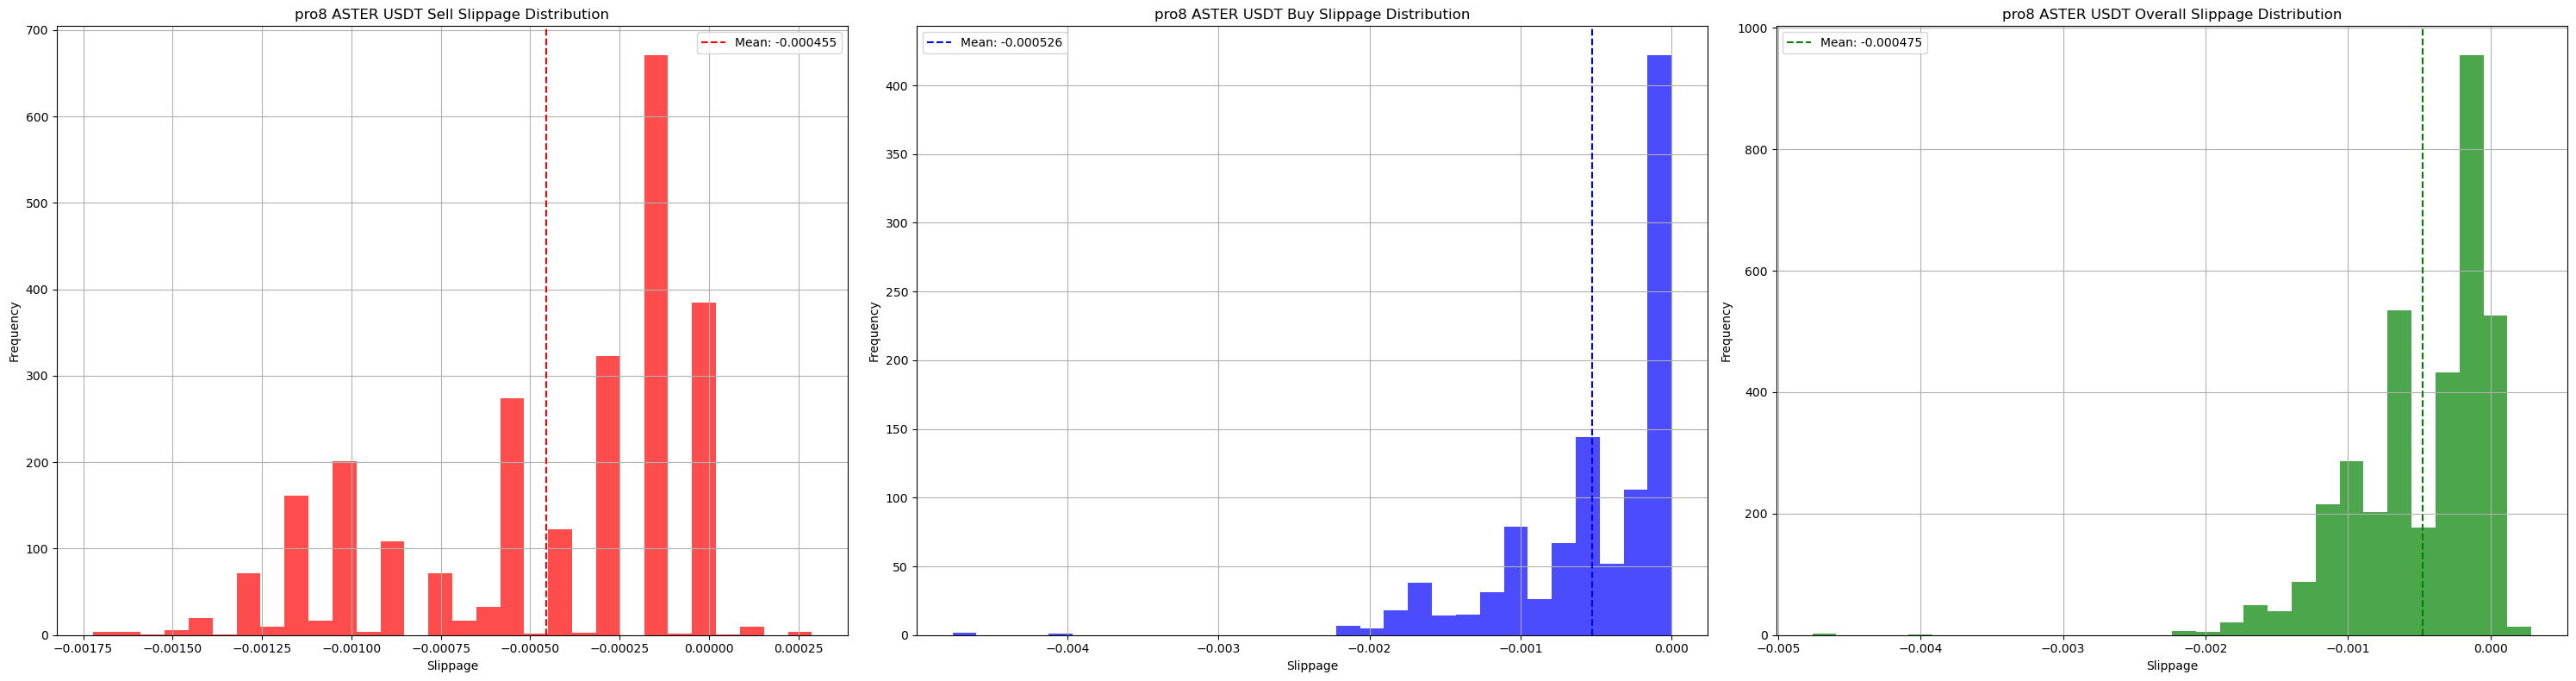

2025-12-30 07:00:00 2026-01-01 15:00:00


symbol                              replace  count      mean    median  \
env                                                                           
pro8  ASTER  msecs10000 replace6 abnormal 0.0005   3555 -0.000475 -0.000289   
pro4  ASTER  msecs15000 replace3 abnormal 0.0005   3312 -0.000484 -0.000290   
pro1  ASTER   msecs1000 replace1 abnormal 0.0005   7449 -0.000488 -0.000431   
pro2  ASTER  msecs10000 replace1 abnormal 0.0005   3914 -0.000491 -0.000432   
pro3  ASTER  msecs10000 replace3 abnormal 0.0005   3644 -0.000498 -0.000291   

          std       min      max  percentile_5  percentile_10  percentile_25  \
env                                                                            
pro8 0.000457 -0.004760 0.000288     -0.001298      -0.001153      -0.000725   
pro4 0.000441 -0.002171 0.000287     -0.001299      -0.001152      -0.000740   
pro1 0.000415 -0.004002 0.000288     -0.001293      -0.001023      -0.000719   
pro2 0.000404 -0.003269 0.000288     -0.001185      -0.001142      -0.000721   
pro3 0.000468 -0.003865 0.003258     -0.001302      -0.001157      -0.000861   

      percentile_50  percentile_60  percentile_75  percentile_95  \
env                                                                
pro8      -0.000289      -0.000147      -0.000144       0.000000   
pro4      -0.000290      -0.000148      -0.000144       0.000000   
pro1      -0.000431      -0.000289      -0.000145       0.000000   
pro2      -0.000432      -0.000289      -0.000146       0.000000   
pro3      -0.000291      -0.000194      -0.000144       0.000000   

      BNFirstSlippage  BNFirstSlippage_count  OKFirstSlippage  \
env                                                             
pro8        -0.000489                   2721        -0.000431   
pro4        -0.000498                   2500        -0.000444   
pro1        -0.000505                   5826        -0.000428   
pro2        -0.000503                   2984        -0.000450   
pro3        -0.000508                   2764        -0.000467   

      OKFirstSlippage_count  
env                          
pro8                    834  
pro4                    812  
pro1                   1623  
pro2                    930  
pro3                    880

In [4]:
import pandas as pd


symbol = 'ASTER'
env_list = ['pro1','pro2','pro3','pro4','pro8']
# env_list = ['pro3']
replace_dict = {
'pro1': 'msecs1000 replace1 abnormal 0.0005',
'pro2': 'msecs10000 replace1 abnormal 0.0005',
'pro3': 'msecs10000 replace3 abnormal 0.0005',
'pro4': 'msecs15000 replace3 abnormal 0.0005', 
'pro8': 'msecs10000 replace6 abnormal 0.0005',
}

start_date = '2025-12-30 07:00:00'
# start_date = '2025-12-11 15:30:00'
end_date = '2026-01-01 15:00:00'

summary = []

for env in env_list:
    file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.close.csv'
    file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.open.csv'
    if env == 'pmpro':
        file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.close.csv'
        file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.open.csv'
    slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


    # 创建子图  
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

    # 分析卖出滑点
    sell_slippage = short_slippage['slippage']
    sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
    ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
    ax1.set_xlabel('Slippage')
    ax1.set_ylabel('Frequency')
    sell_mean = sell_slippage.mean()
    sell_std = sell_slippage.std()
    ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
    ax1.legend()
    # print('sell count', len(sell_slippage))


    # 分析买入滑点
    buy_slippage = long_slippage['slippage']
    buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
    ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
    ax2.set_xlabel('Slippage')
    ax2.set_ylabel('Frequency')
    buy_mean = buy_slippage.mean()
    buy_std = buy_slippage.std()
    ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
    ax2.legend()
    # print('buy count', len(buy_slippage))

    # overall滑点分布
    slippage_array = slippage_df_selected['slippage'].values
    slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
    ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
    ax3.set_xlabel('Slippage')
    ax3.set_ylabel('Frequency')
    overall_mean = slippage_array.mean()
    ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    stats = {
        'symbol': symbol,
        'env': env,
        'replace': replace_dict[env],
        'count': len(slippage_array),
        'mean': np.mean(slippage_array),
        'median': np.median(slippage_array),
        'std': np.std(slippage_array),
        'min': np.min(slippage_array),
        'max': np.max(slippage_array),
        # 'percentile_1': np.percentile(slippage_array, 1),
        'percentile_5': np.percentile(slippage_array, 5),
        'percentile_10': np.percentile(slippage_array, 10),
        'percentile_25': np.percentile(slippage_array, 25),
        'percentile_50': np.percentile(slippage_array, 50),
        # 'percentile_55': np.percentile(slippage_array, 55),        
        'percentile_60': np.percentile(slippage_array, 60),
        # 'percentile_65': np.percentile(slippage_array, 65),
        'percentile_75': np.percentile(slippage_array, 75),
        'percentile_95': np.percentile(slippage_array, 95),
        # 'percentile_99': np.percentile(slippage_array, 99),
        'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
        'BNFirstSlippage_count': len(Exchange1FirstSlippage),
        'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
        'OKFirstSlippage_count': len(Exchange2FirstSlippage),
    }

    summary.append(stats)

df = pd.DataFrame(summary).set_index('env').sort_values(by='mean', ascending=False)
print(start_date,end_date)
df

# 0106



/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:5: DtypeWarning: Columns (1,9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:6: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:8

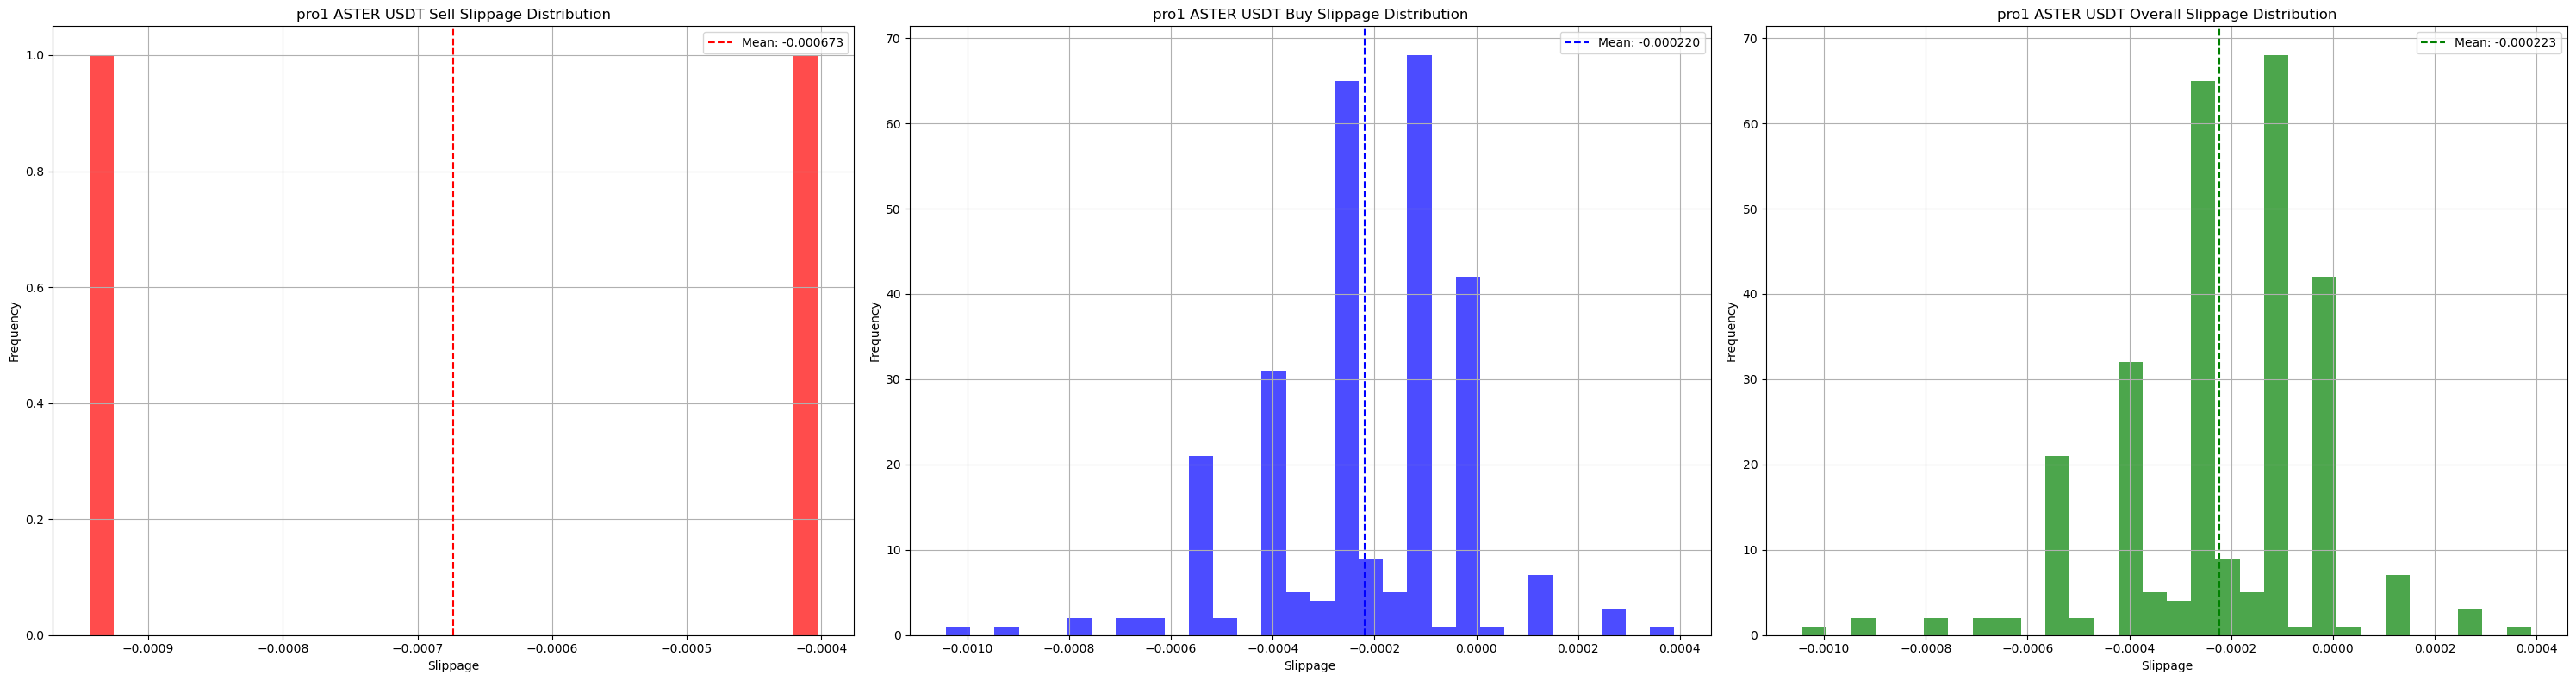

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

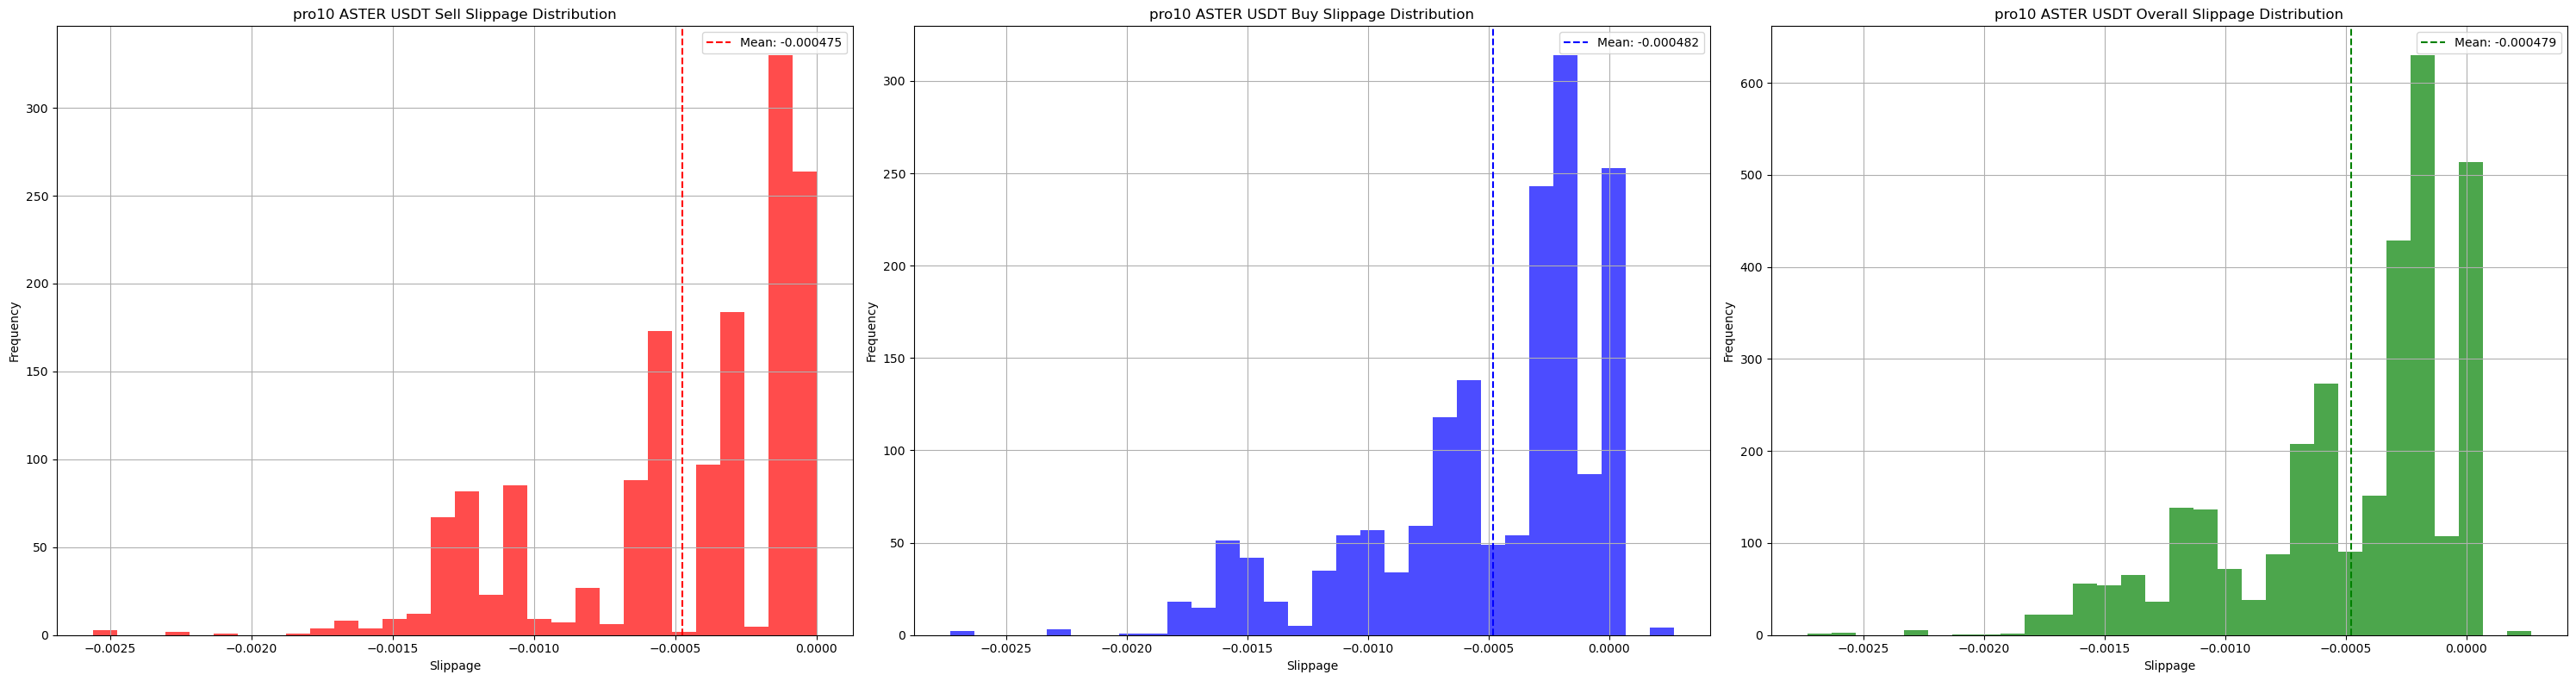

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

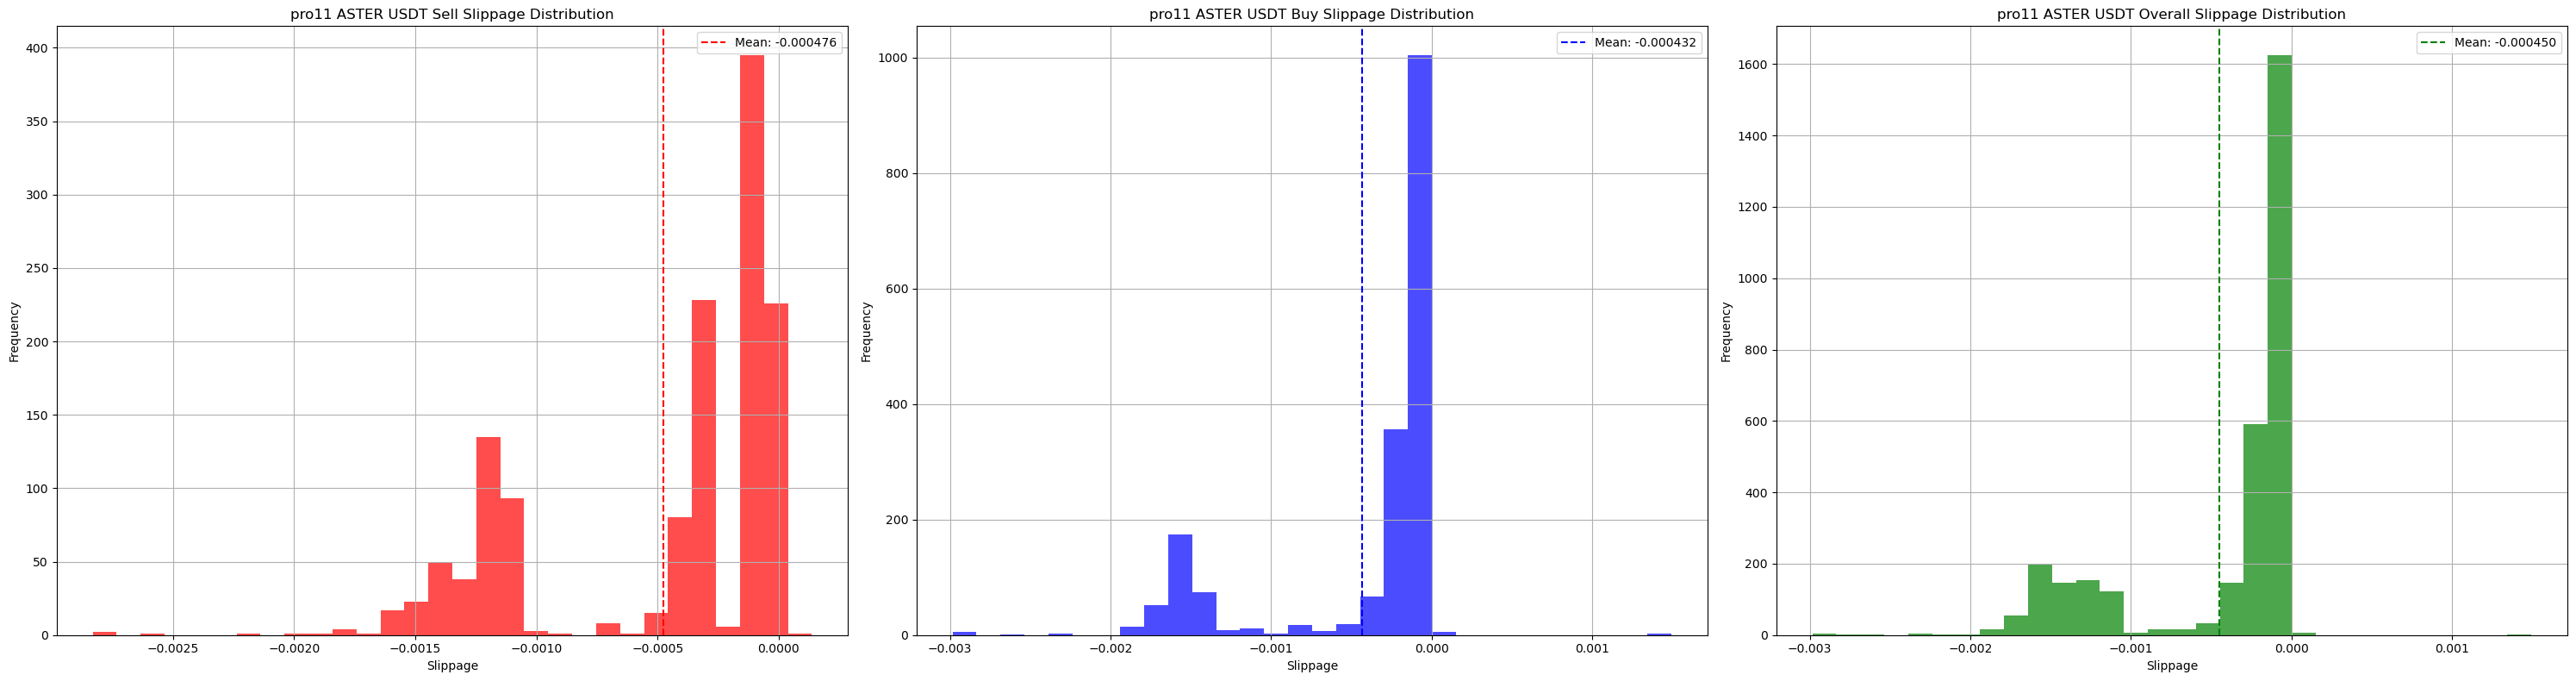

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

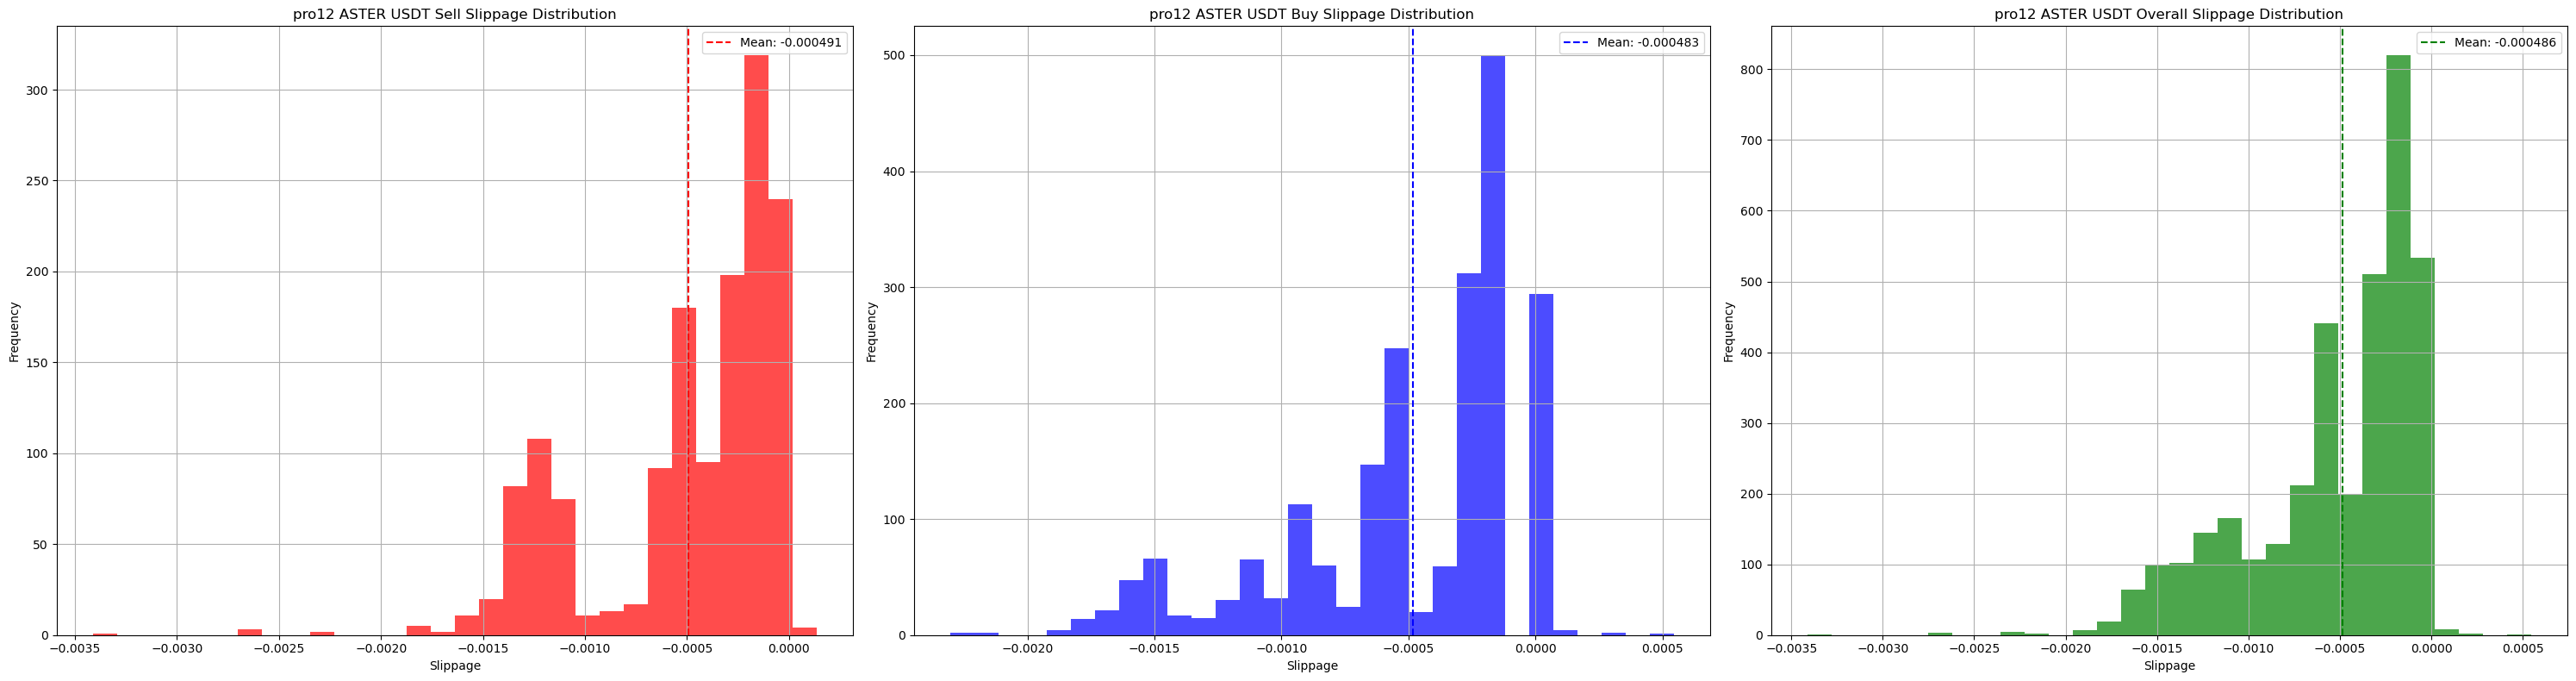

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

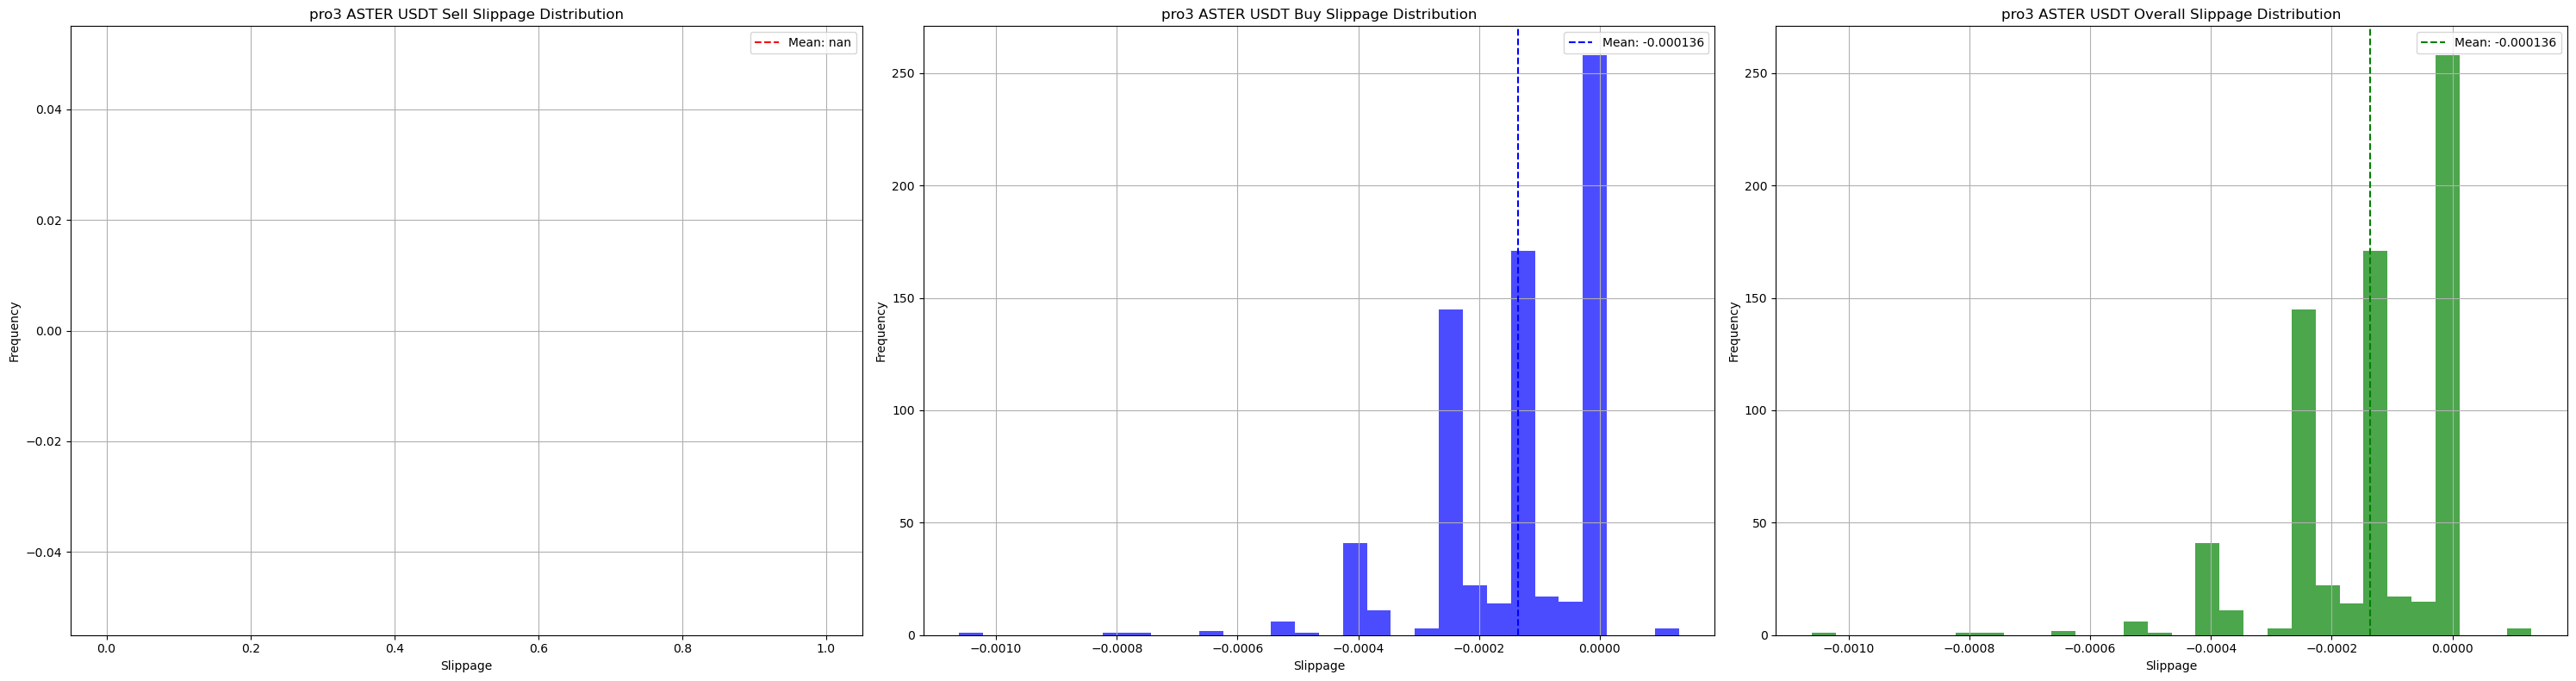

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:87: UserWarning: Boolean Ser

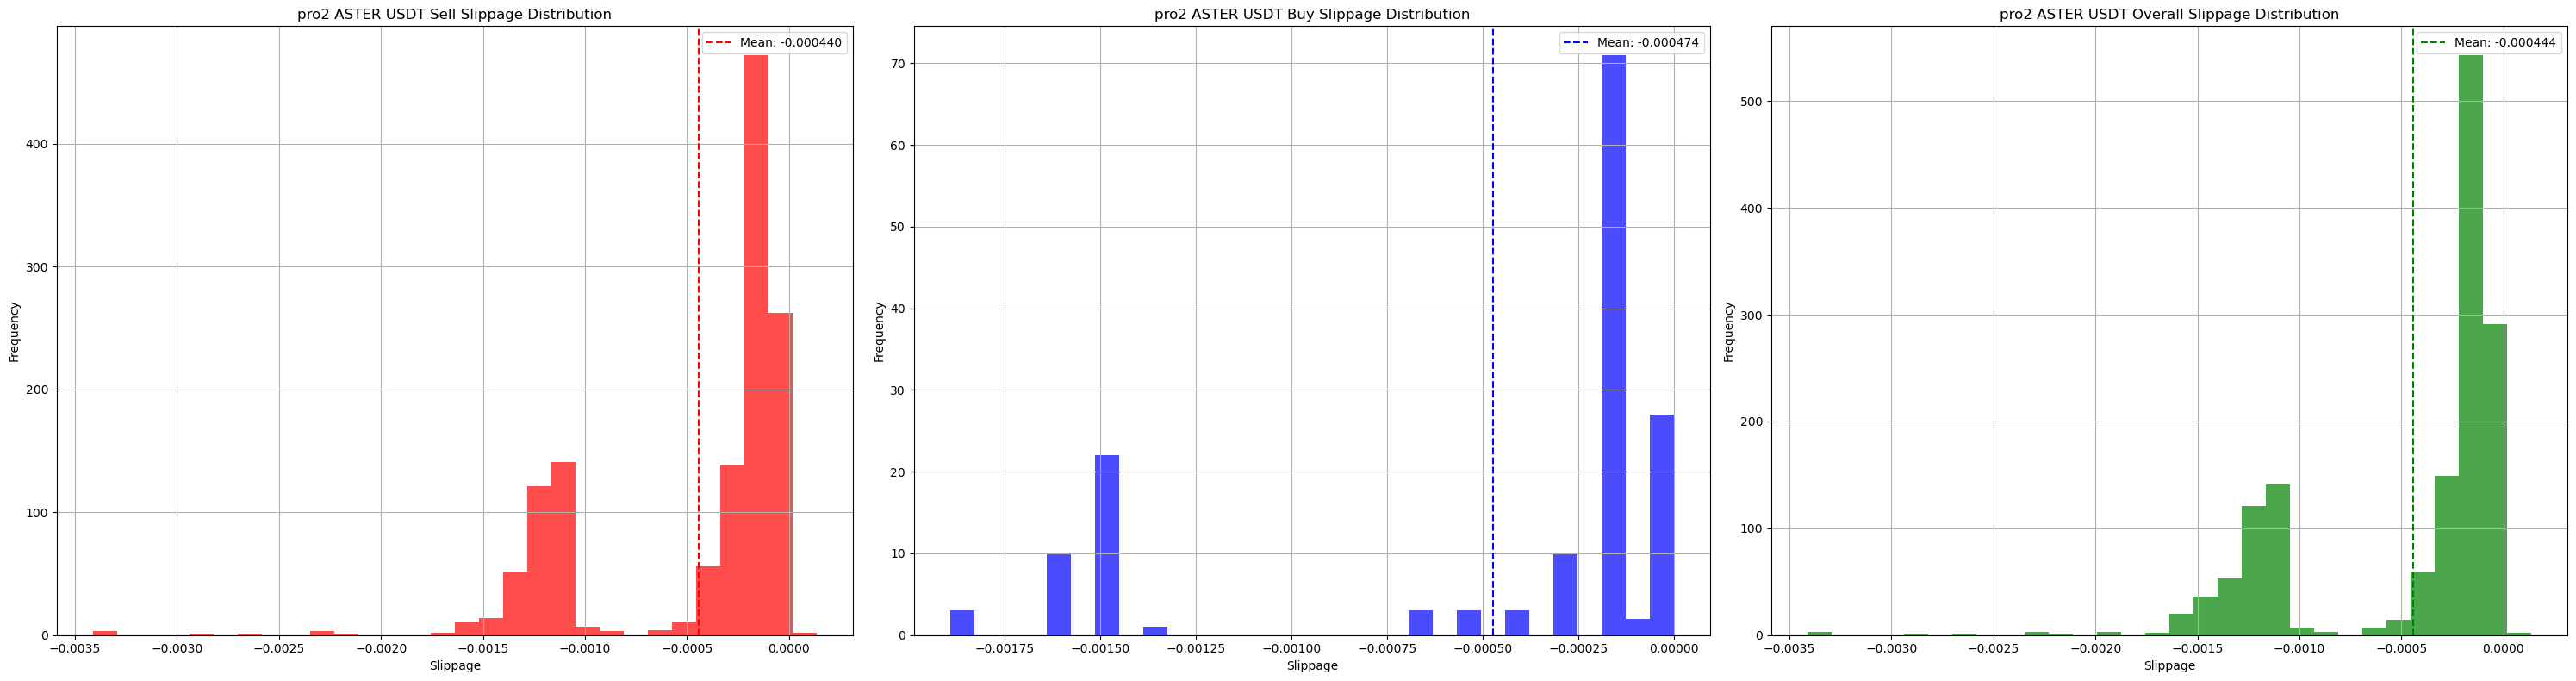

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_20792/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

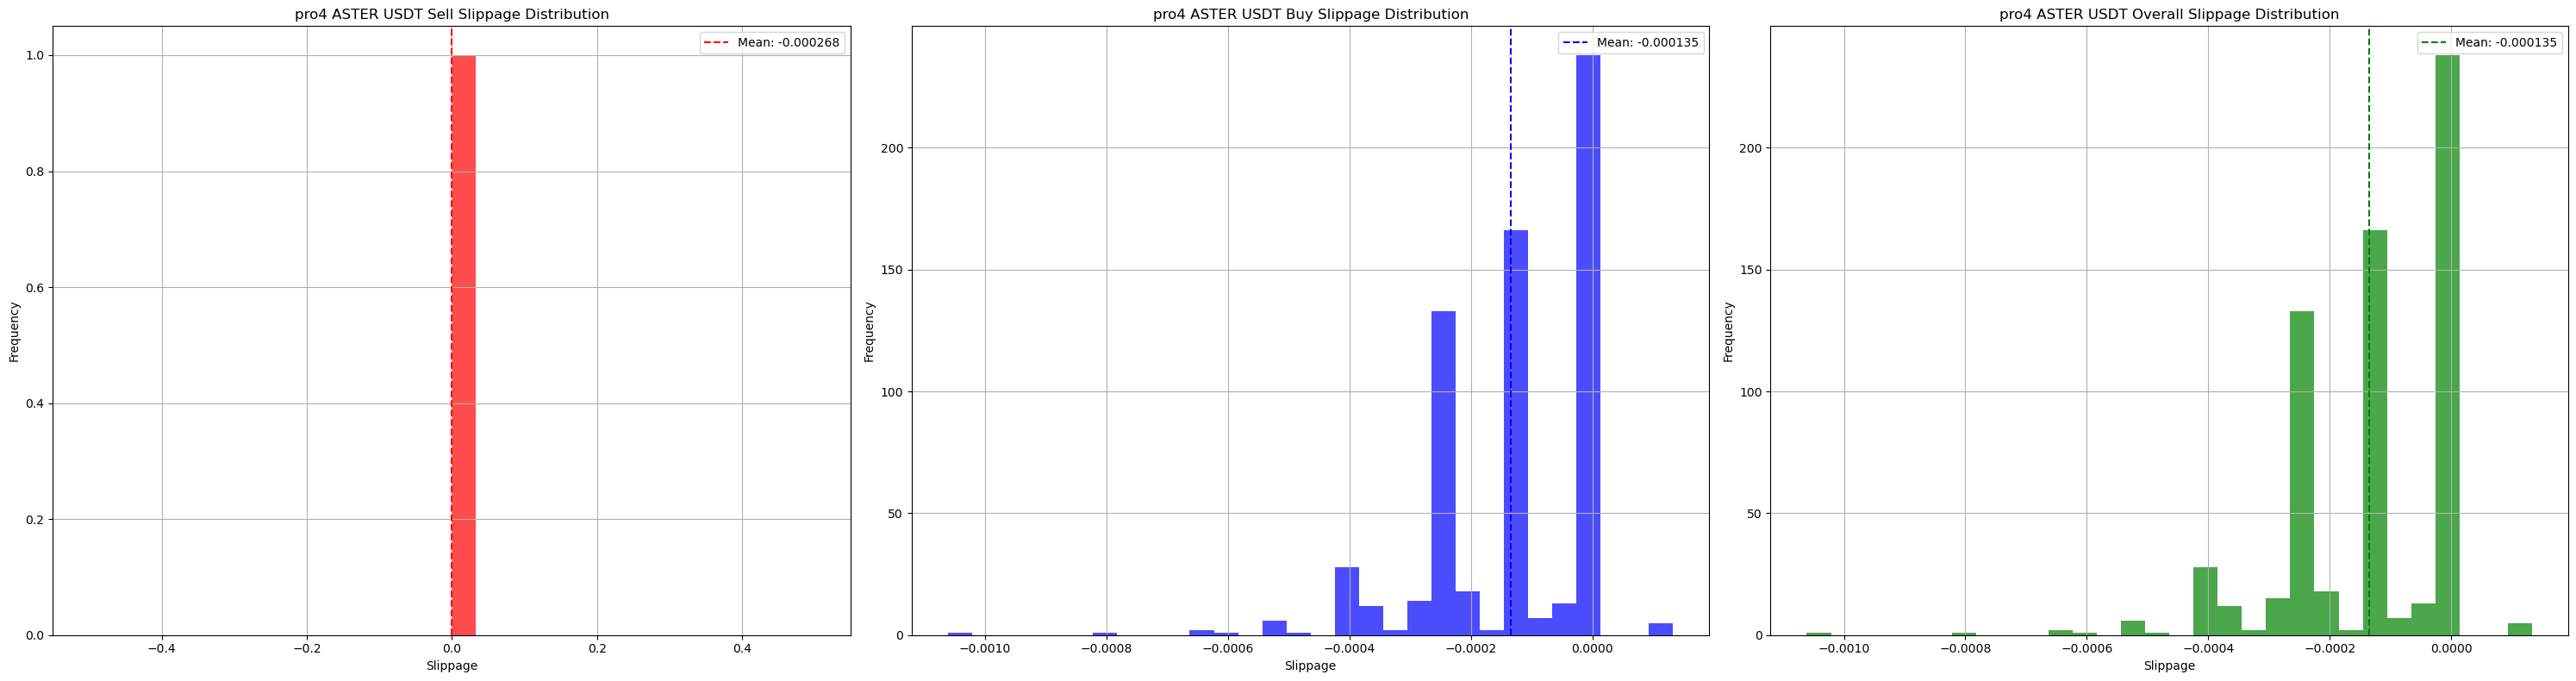

2026-01-07 06:20:00 2026-01-08 15:00:00


symbol                               replace  count      mean    median  \
env                                                                             
pro4   ASTER                            MakerTaker    651 -0.000135 -0.000130   
pro3   ASTER                            MakerTaker    712 -0.000136 -0.000130   
pro1   ASTER                         preTakerMaker    275 -0.000223 -0.000245   
pro2   ASTER  msecs10000 replace10 abnormal 0.0001   1460 -0.000444 -0.000136   
pro11  ASTER  msecs10000 replace10 abnormal 0.0002   3155 -0.000450 -0.000136   
pro10  ASTER  msecs10000 replace10 abnormal 0.0005   3148 -0.000479 -0.000271   
pro12  ASTER   msecs10000 replace1 abnormal 0.0005   3576 -0.000486 -0.000271   

           std       min      max  percentile_5  percentile_10  percentile_25  \
env                                                                             
pro4  0.000140 -0.001061 0.000133     -0.000390      -0.000266      -0.000259   
pro3  0.000140 -0.001061 0.000131     -0.000391      -0.000265      -0.000248   
pro1  0.000200 -0.001042 0.000389     -0.000533      -0.000519      -0.000329   
pro2  0.000532 -0.003412 0.000137     -0.001357      -0.001218      -0.001077   
pro11 0.000555 -0.002984 0.001495     -0.001581      -0.001486      -0.000410   
pro10 0.000474 -0.002732 0.000270     -0.001472      -0.001218      -0.000677   
pro12 0.000472 -0.003412 0.000546     -0.001481      -0.001219      -0.000678   

       percentile_50  percentile_60  percentile_75  percentile_95  \
env                                                                 
pro4       -0.000130      -0.000088      -0.000000       0.000000   
pro3       -0.000130      -0.000086      -0.000000       0.000000   
pro1       -0.000245      -0.000133      -0.000130       0.000000   
pro2       -0.000136      -0.000135      -0.000132       0.000000   
pro11      -0.000136      -0.000135      -0.000130       0.000000   
pro10      -0.000271      -0.000253      -0.000134       0.000000   
pro12      -0.000271      -0.000255      -0.000134       0.000000   

       BNFirstSlippage  BNFirstSlippage_count  OKFirstSlippage  \
env                                                              
pro4         -0.000135                    651              NaN   
pro3         -0.000136                    712              NaN   
pro1               NaN                      0        -0.000223   
pro2         -0.000432                   1095        -0.000478   
pro11        -0.000442                   2360        -0.000474   
pro10        -0.000482                   2395        -0.000469   
pro12        -0.000487                   2704        -0.000484   

       OKFirstSlippage_count  
env                           
pro4                       0  
pro3                       0  
pro1                     275  
pro2                     365  
pro11                    795  
pro10                    753  
pro12                    872

In [6]:
import pandas as pd


symbol = 'ASTER'
env_list = ['pro1','pro2','pro10','pro11','pro12']
env_list = ['pro1','pro10','pro11','pro12','pro3','pro2','pro4']
# env_list = ['pro3']
replace_dict = {
'pro1': 'preTakerMaker',
'pro2': 'msecs10000 replace10 abnormal 0.0001',
'pro10': 'msecs10000 replace10 abnormal 0.0005',
'pro11': 'msecs10000 replace10 abnormal 0.0002', 
'pro12': 'msecs10000 replace1 abnormal 0.0005',
'pro3':'MakerTaker',
'pro4':'MakerTaker'
}

start_date = '2026-01-07 06:20:00'
# start_date = '2025-12-11 15:30:00'
end_date = '2026-01-08 15:00:00'

summary = []

for env in env_list:
    file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.close.csv'
    file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.open.csv'
    if env == 'pmpro':
        file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.close.csv'
        file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.open.csv'
    slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


    # 创建子图  
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

    # 分析卖出滑点
    sell_slippage = short_slippage['slippage']
    sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
    ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
    ax1.set_xlabel('Slippage')
    ax1.set_ylabel('Frequency')
    sell_mean = sell_slippage.mean()
    sell_std = sell_slippage.std()
    ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
    ax1.legend()
    # print('sell count', len(sell_slippage))


    # 分析买入滑点
    buy_slippage = long_slippage['slippage']
    buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
    ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
    ax2.set_xlabel('Slippage')
    ax2.set_ylabel('Frequency')
    buy_mean = buy_slippage.mean()
    buy_std = buy_slippage.std()
    ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
    ax2.legend()
    # print('buy count', len(buy_slippage))

    # overall滑点分布
    slippage_array = slippage_df_selected['slippage'].values
    slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
    ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
    ax3.set_xlabel('Slippage')
    ax3.set_ylabel('Frequency')
    overall_mean = slippage_array.mean()
    ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    stats = {
        'symbol': symbol,
        'env': env,
        'replace': replace_dict[env],
        'count': len(slippage_array),
        'mean': np.mean(slippage_array),
        'median': np.median(slippage_array),
        'std': np.std(slippage_array),
        'min': np.min(slippage_array),
        'max': np.max(slippage_array),
        # 'percentile_1': np.percentile(slippage_array, 1),
        'percentile_5': np.percentile(slippage_array, 5),
        'percentile_10': np.percentile(slippage_array, 10),
        'percentile_25': np.percentile(slippage_array, 25),
        'percentile_50': np.percentile(slippage_array, 50),
        # 'percentile_55': np.percentile(slippage_array, 55),        
        'percentile_60': np.percentile(slippage_array, 60),
        # 'percentile_65': np.percentile(slippage_array, 65),
        'percentile_75': np.percentile(slippage_array, 75),
        'percentile_95': np.percentile(slippage_array, 95),
        # 'percentile_99': np.percentile(slippage_array, 99),
        'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
        'BNFirstSlippage_count': len(Exchange1FirstSlippage),
        'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
        'OKFirstSlippage_count': len(Exchange2FirstSlippage),
    }

    summary.append(stats)

df = pd.DataFrame(summary).set_index('env').sort_values(by='mean', ascending=False)
print(start_date,end_date)
df

In [12]:
symbol = 'ASTER'
env = 'pro2'
file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.close.csv'
file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.open.csv'
start_date = '2026-01-08 11:30:00'
end_date = '2026-01-13 15:00:00'

slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_54427/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_54427/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_54427/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_54427/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_54427/1325737168.py:87: UserWarning: Boolean Ser

In [13]:
df_open[df_open['sign']==-1]['sr_open'].mean()

-0.00040817124735729397

In [14]:
df_open[df_open['sign']==-1]['sr_open_real'].mean()

2.2615904724730015e-05

In [18]:
df_open[df_open['sign']==1]['sr_open'].mean()

1.8568974229408794e-05

In [19]:
df_open[df_open['sign']==1]['sr_open_real'].mean()

-0.0003926772336775502

In [20]:
df_close[df_close['sign']==1]['sr_close']

17742   0.000000
17743   0.000000
17744   0.000000
17745   0.000000
17746   0.000000
          ...   
18942   0.000000
18943   0.000000
18944   0.000000
18945   0.000000
18946   0.000000
Name: sr_close, Length: 1205, dtype: float64

In [17]:
df_close[df_close['sign']==1]['sr_close_real'].mean()

-0.00039560948117763317

# 0112

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:5: DtypeWarning: Columns (1,9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:6: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:8

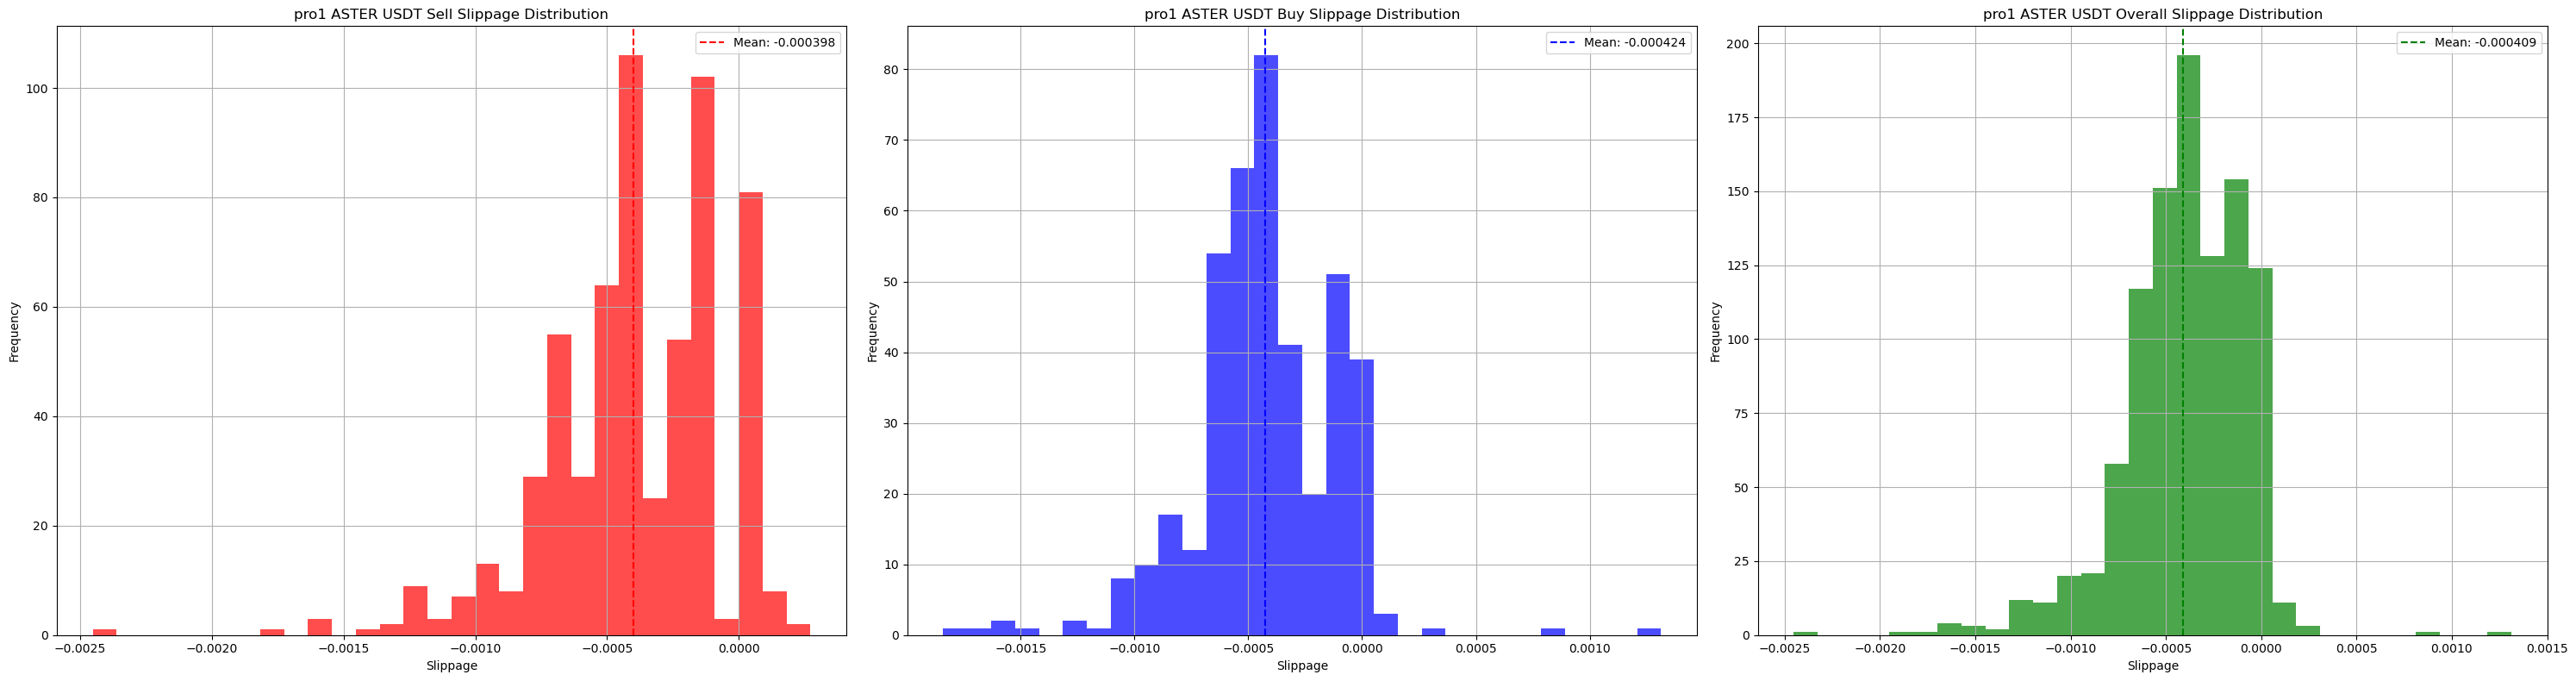

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:6: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:87: UserWarning: Boolean Ser

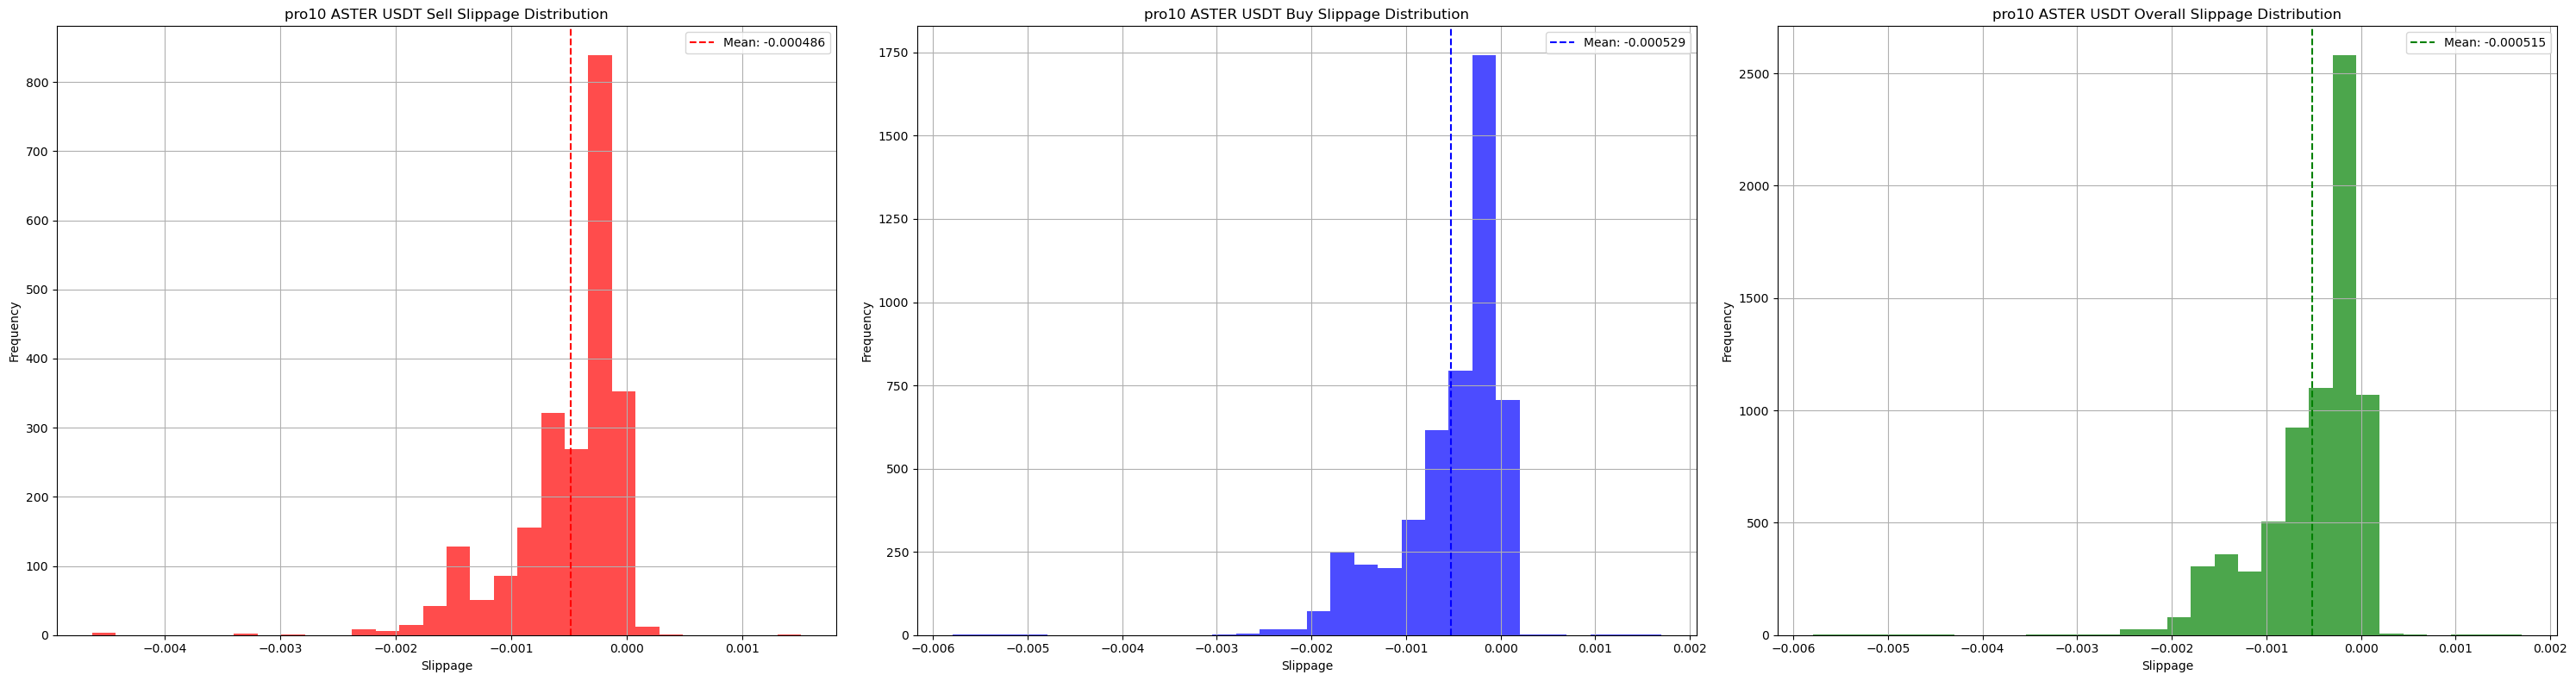

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

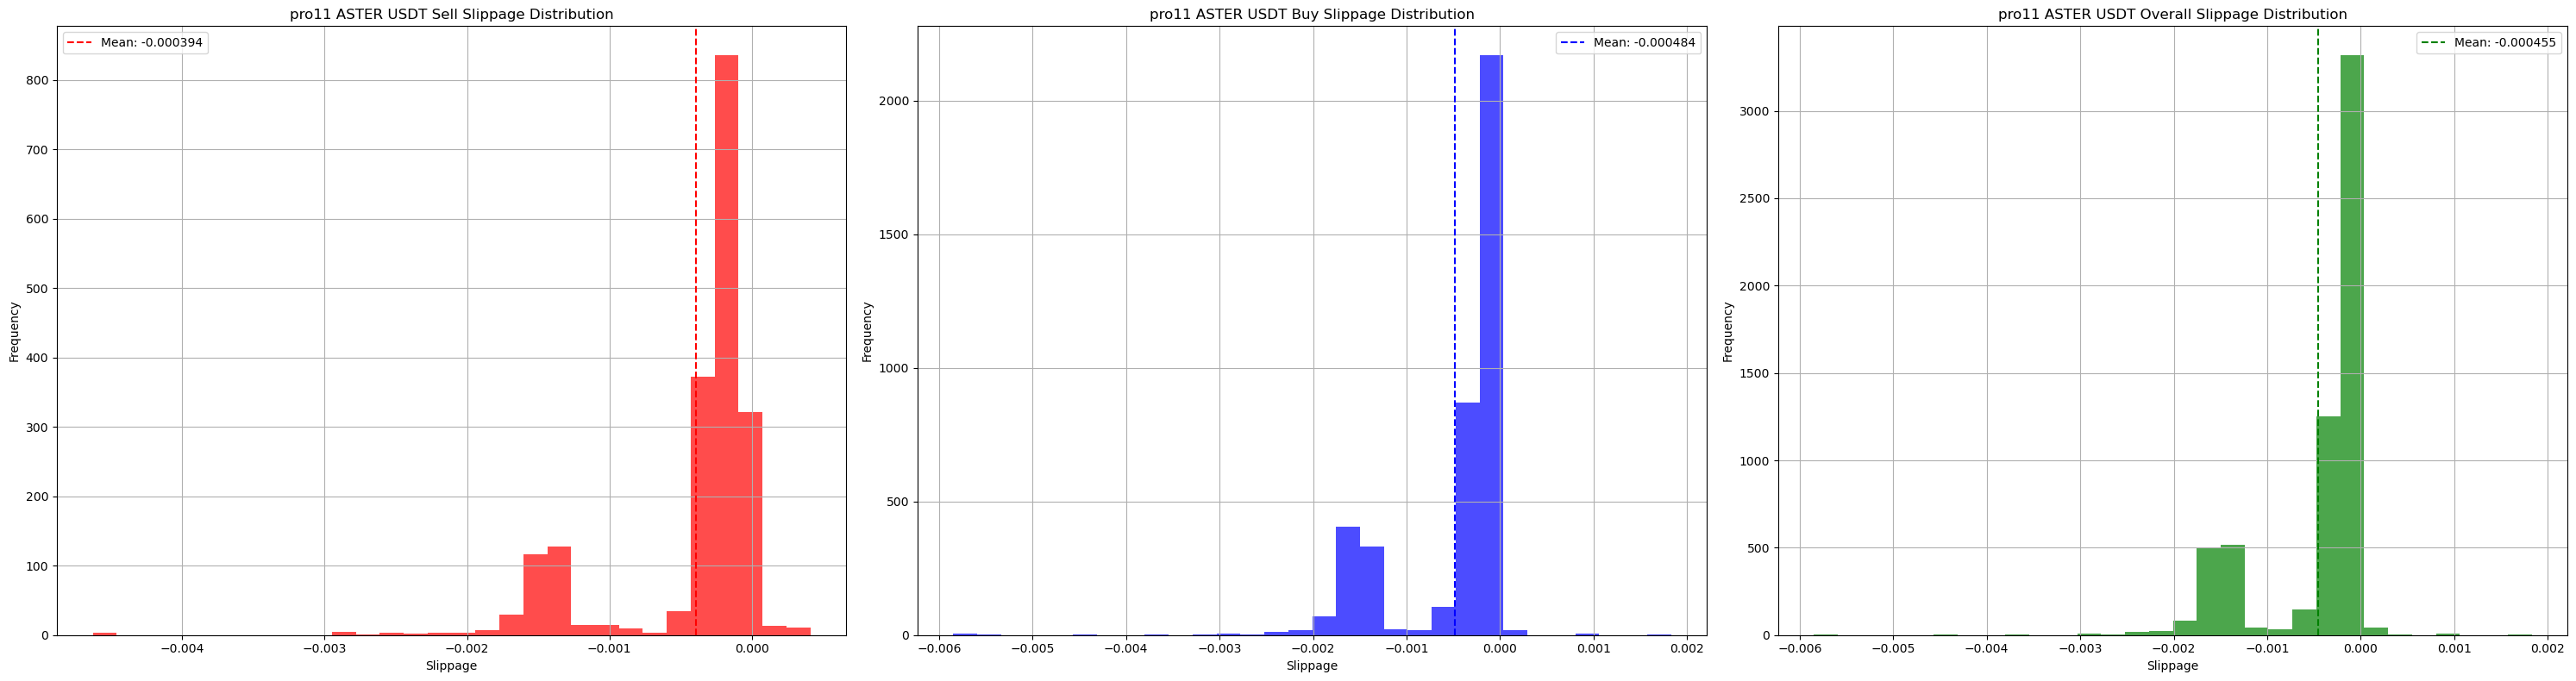

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:87: UserWarning: Boolean Ser

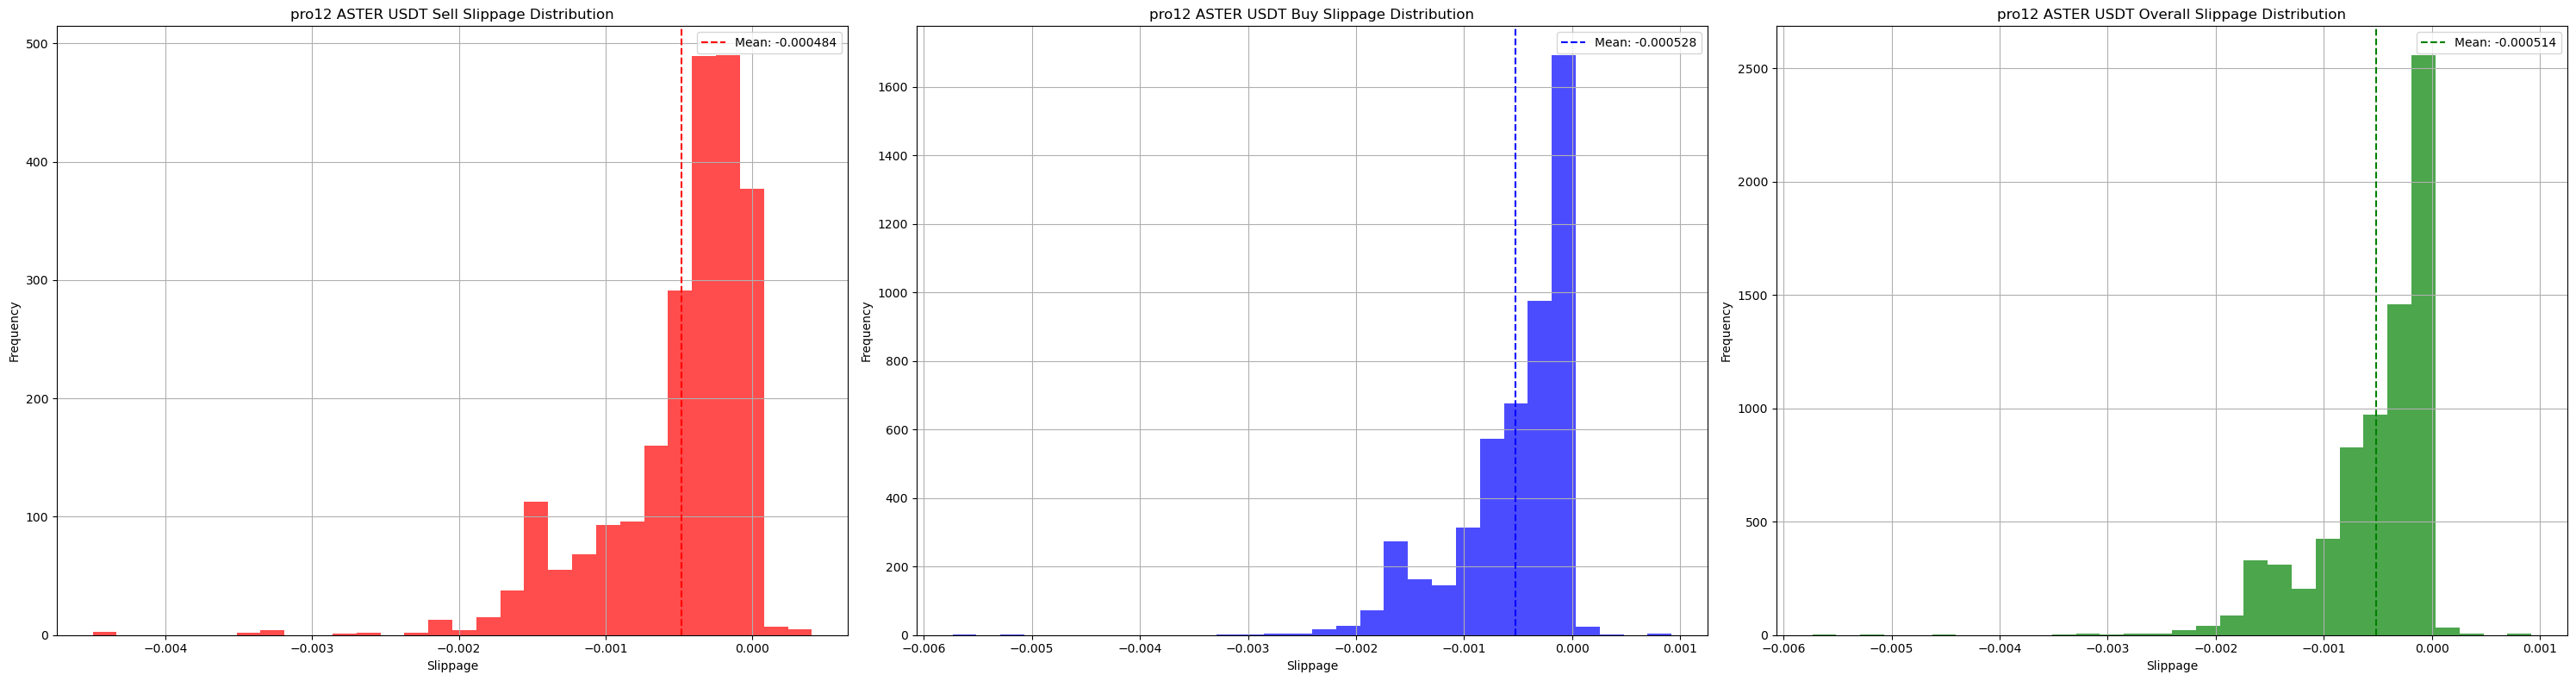

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

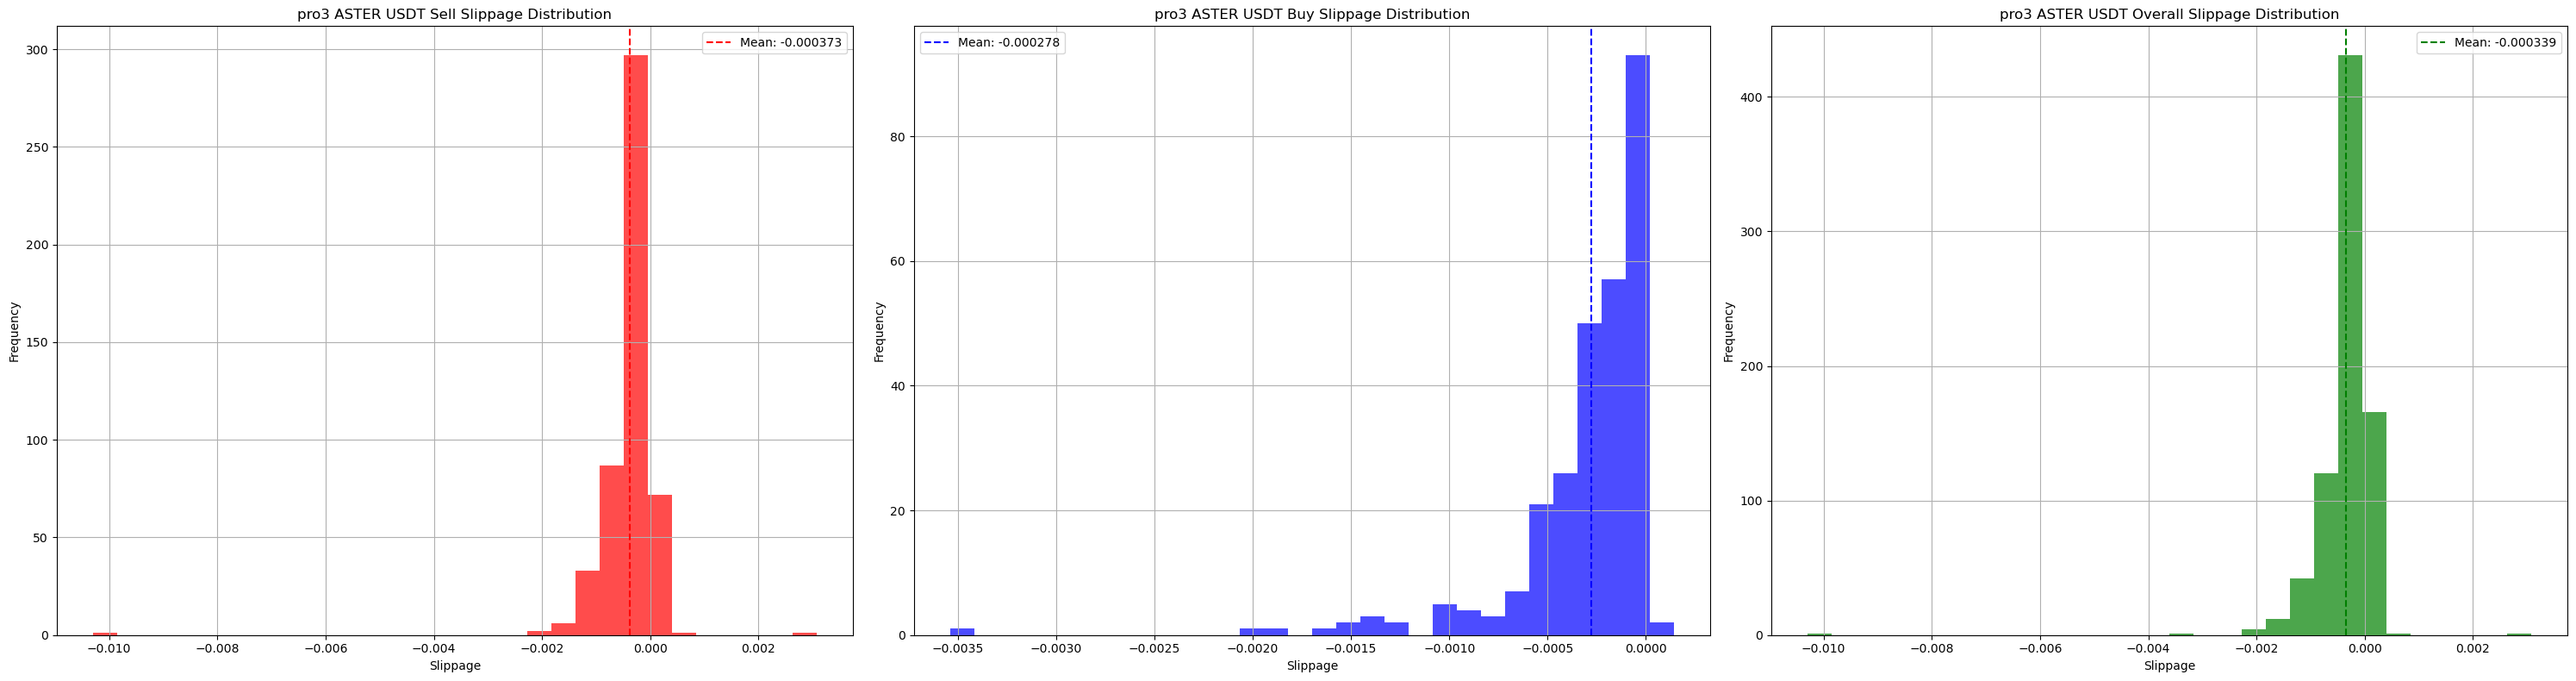

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

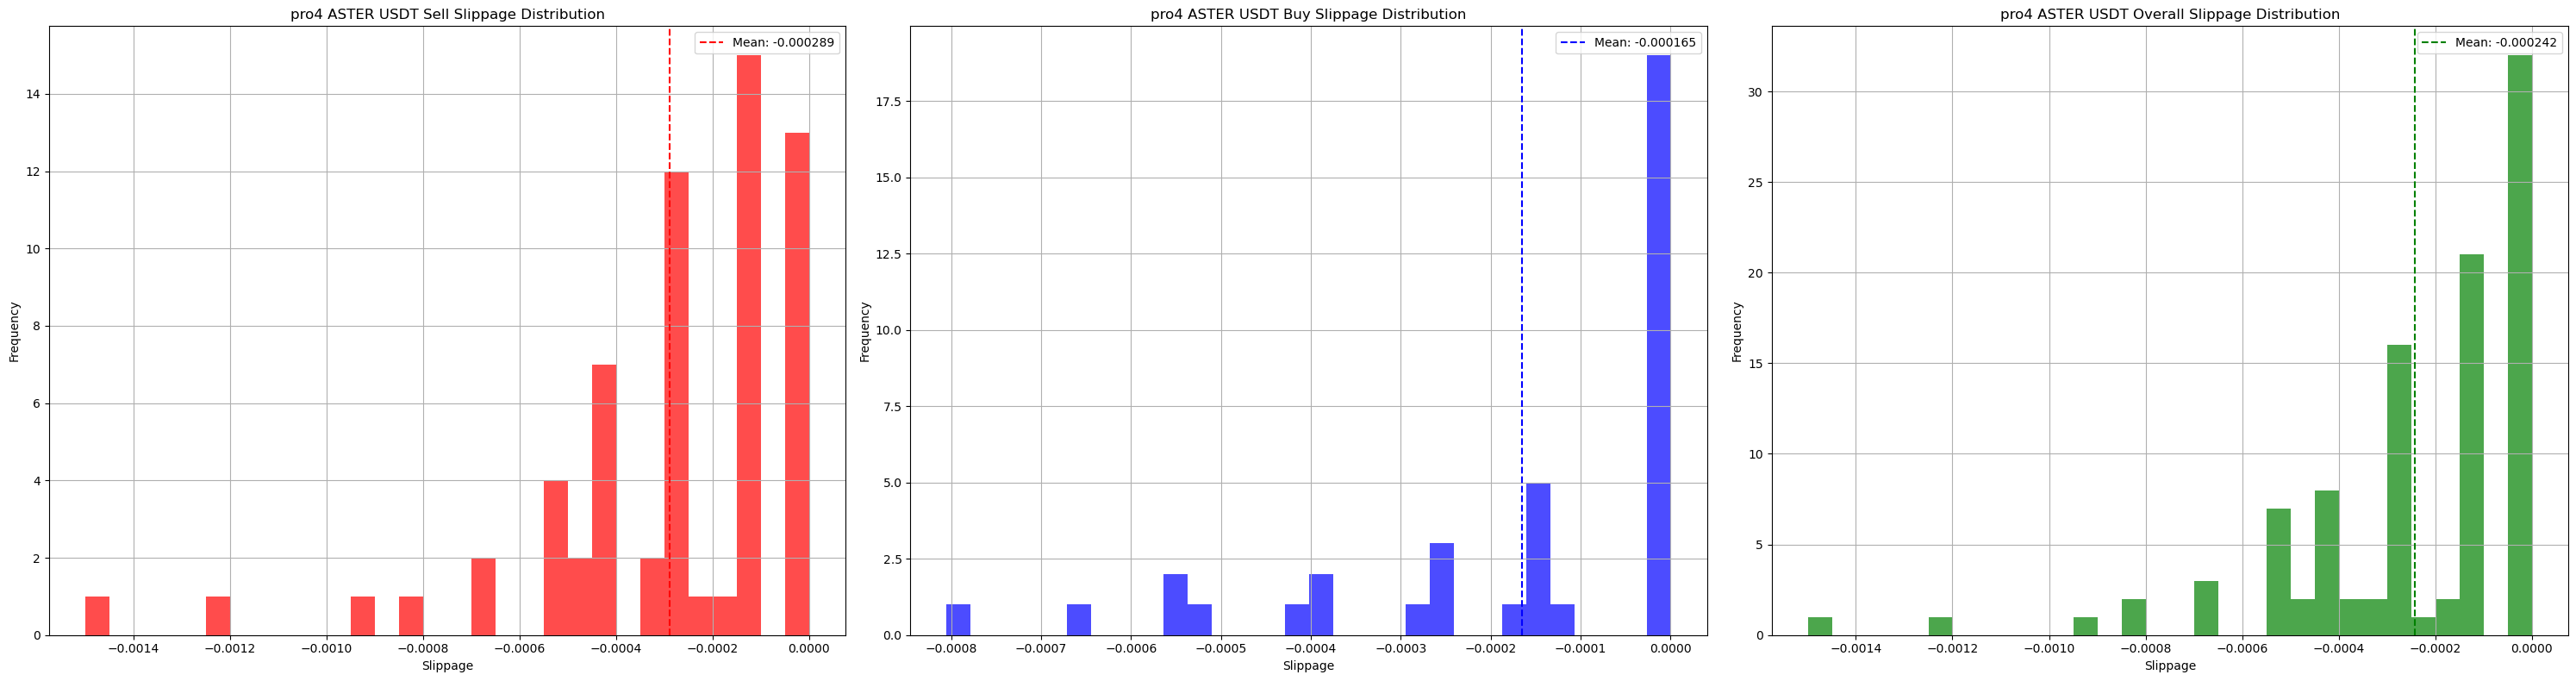

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

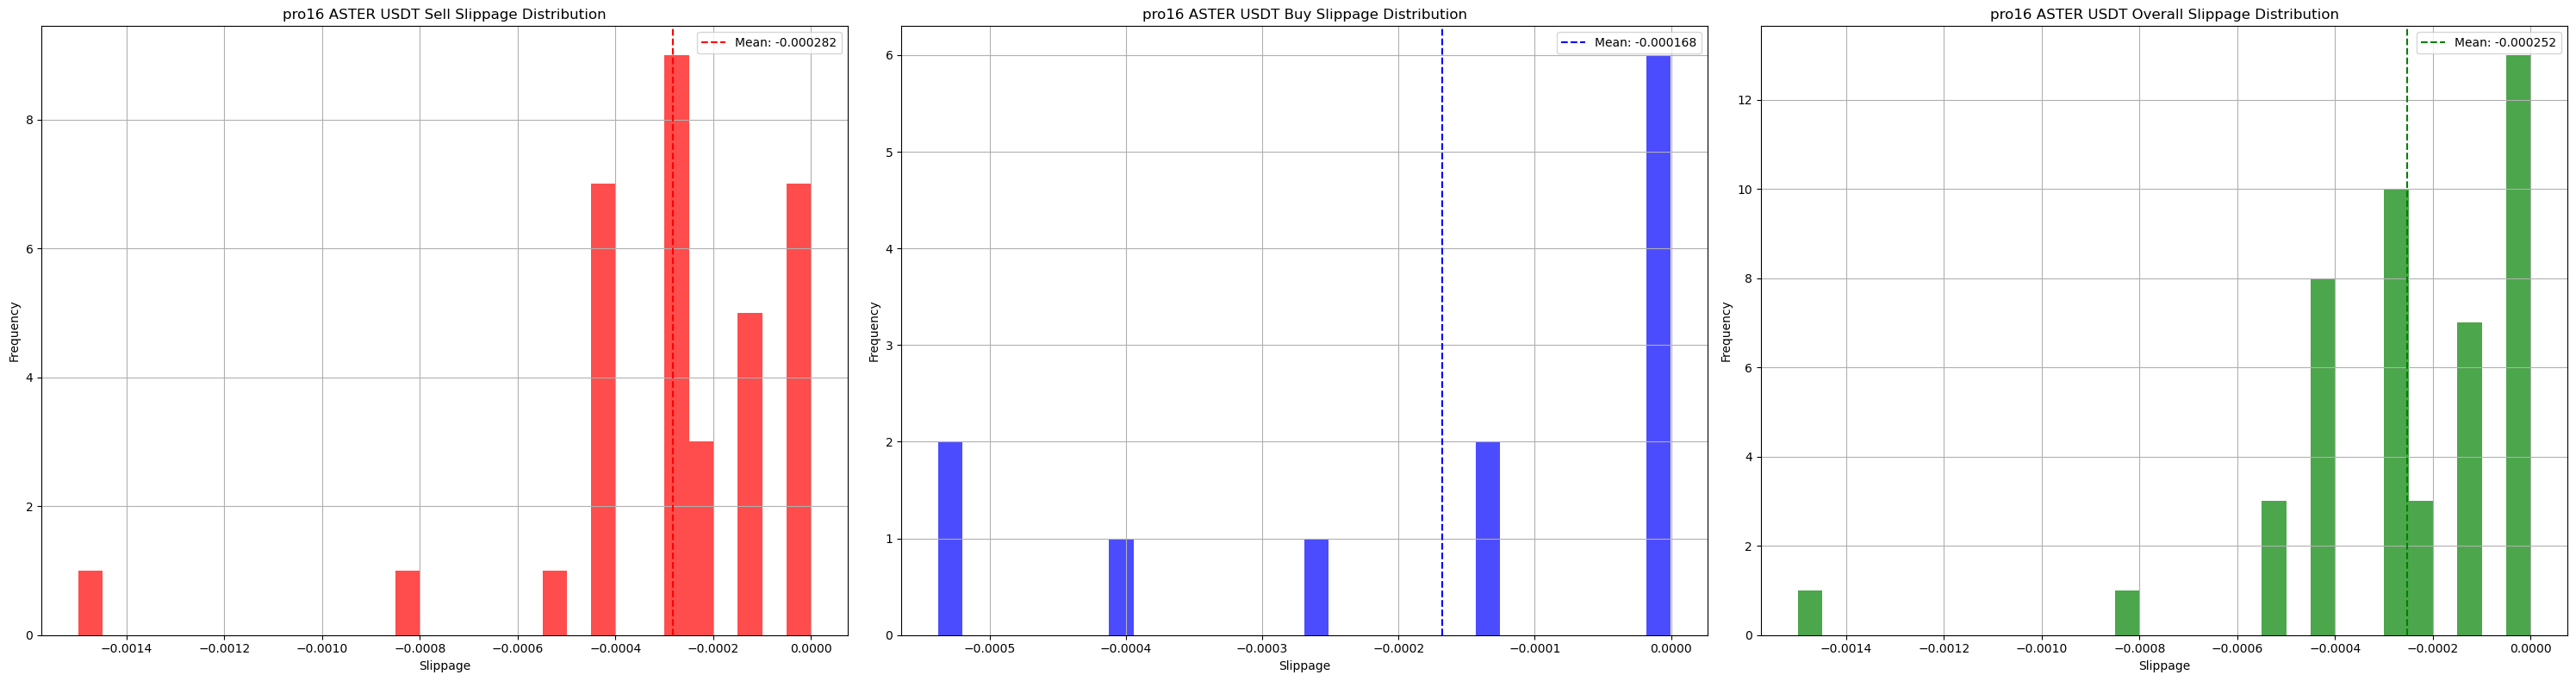

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

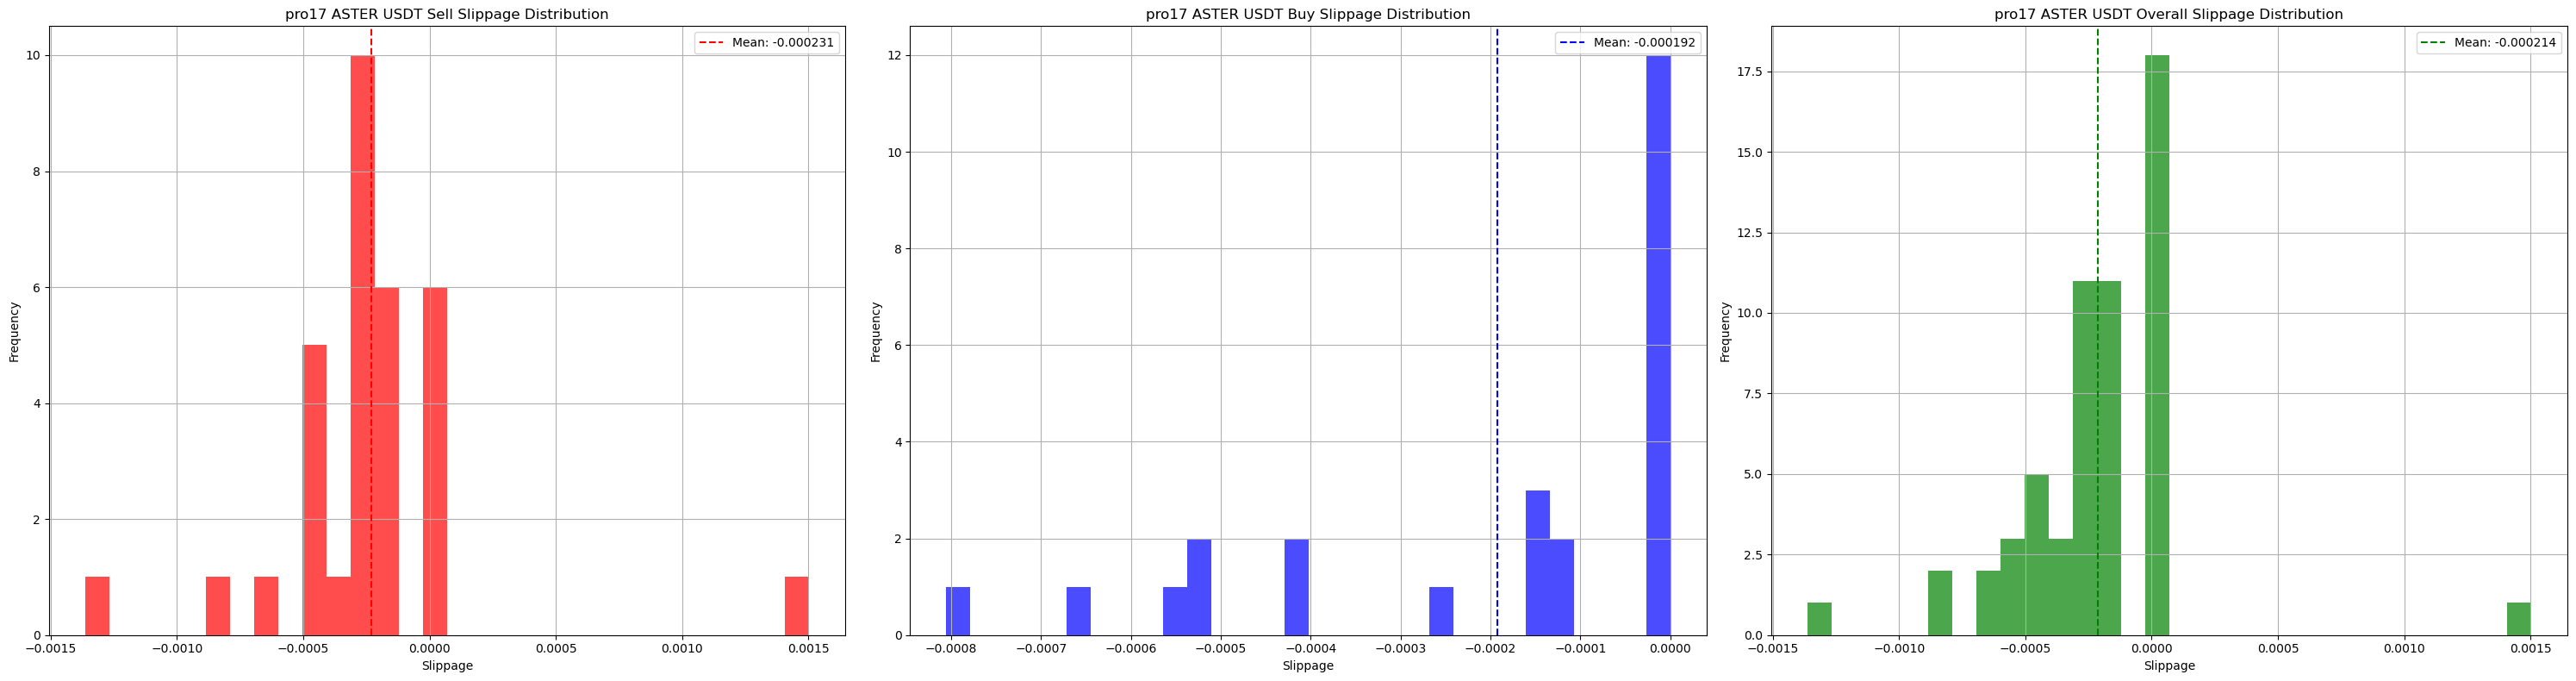

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:87: UserWarning: Boolean Ser

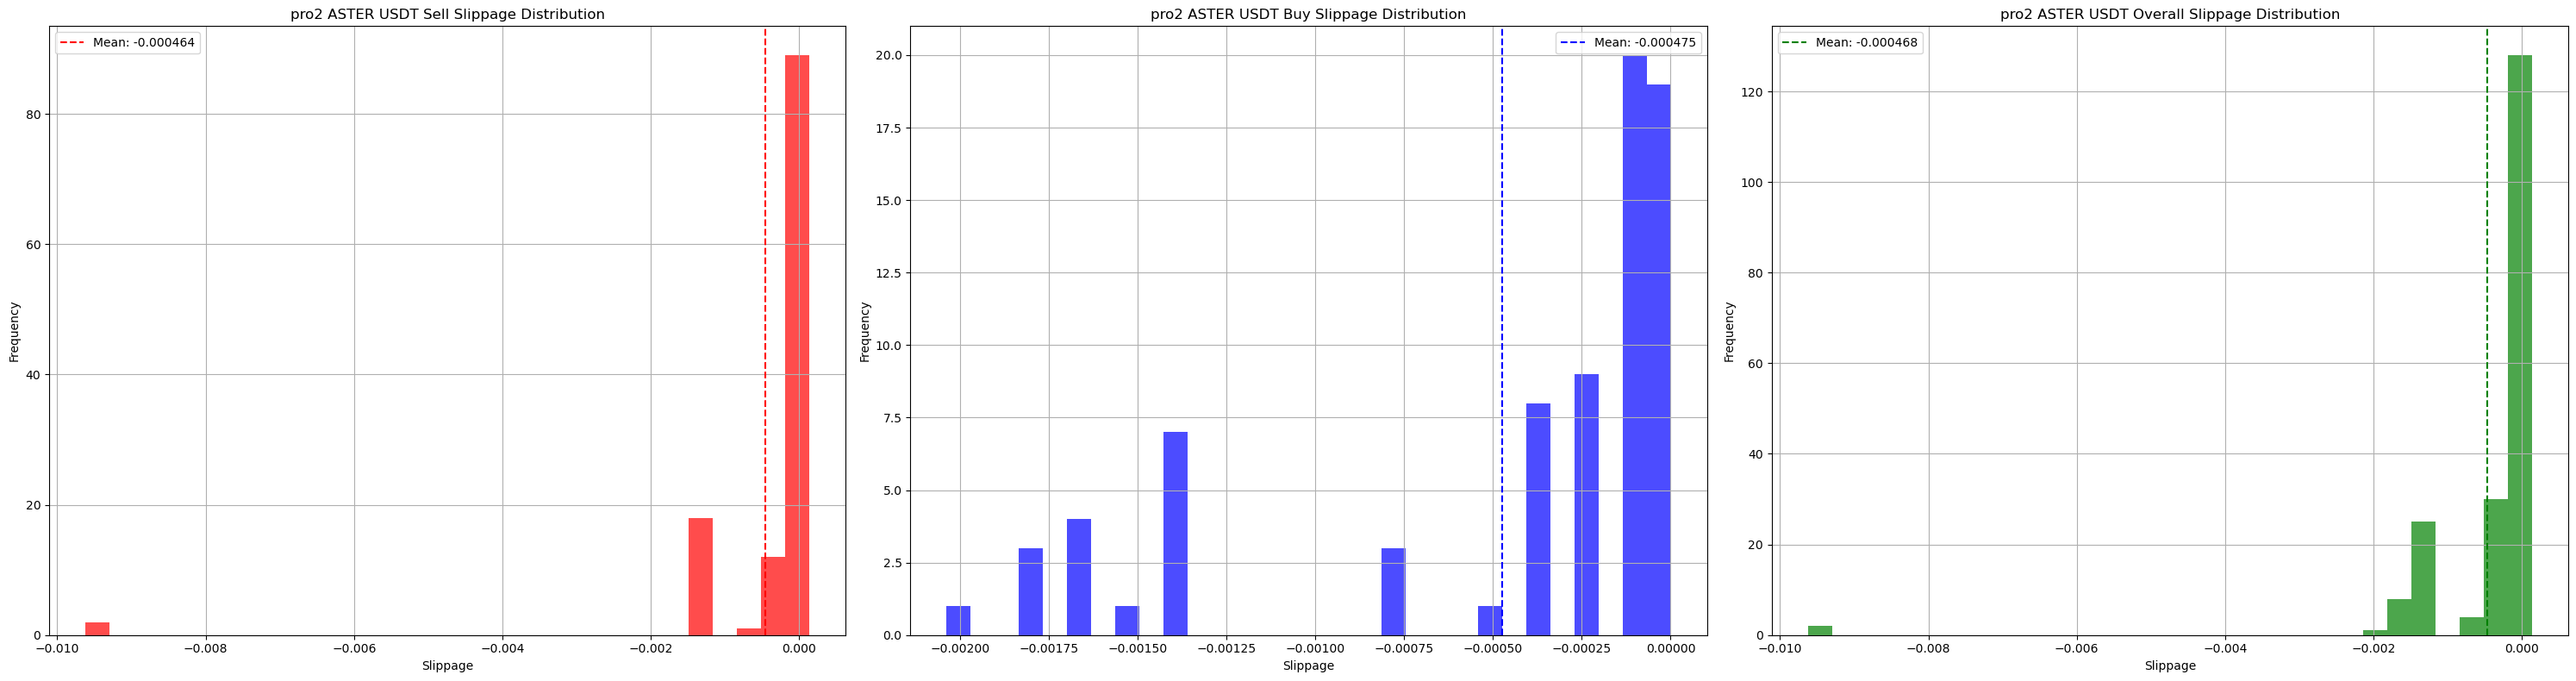

2026-01-13 15:00:00 2026-01-15 15:00:00


symbol                               replace  count      mean    median  \
env                                                                             
pro17  ASTER                            MakerTaker     57 -0.000214 -0.000137   
pro4   ASTER                            MakerTaker    101 -0.000242 -0.000137   
pro16  ASTER                            MakerTaker     46 -0.000252 -0.000254   
pro3   ASTER                         preTakerMaker    779 -0.000339 -0.000269   
pro1   ASTER                         preTakerMaker   1020 -0.000409 -0.000405   
pro11  ASTER  msecs10000 replace10 abnormal 0.0002   6010 -0.000455 -0.000141   
pro2   ASTER  msecs10000 replace10 abnormal 0.0001    198 -0.000468 -0.000135   
pro12  ASTER   msecs10000 replace1 abnormal 0.0005   7308 -0.000514 -0.000285   
pro10  ASTER  msecs10000 replace10 abnormal 0.0005   7289 -0.000515 -0.000286   

           std       min      max  percentile_5  percentile_10  percentile_25  \
env                                                                             
pro17 0.000349 -0.001363 0.001503     -0.000708      -0.000536      -0.000403   
pro4  0.000270 -0.001499 0.000000     -0.000678      -0.000538      -0.000393   
pro16 0.000265 -0.001499 0.000000     -0.000542      -0.000478      -0.000408   
pro3  0.000527 -0.010299 0.003077     -0.001047      -0.000814      -0.000412   
pro1  0.000324 -0.002452 0.001313     -0.000948      -0.000811      -0.000555   
pro11 0.000626 -0.005847 0.001828     -0.001623      -0.001526      -0.000407   
pro2  0.001057 -0.009622 0.000136     -0.001553      -0.001401      -0.000273   
pro12 0.000535 -0.005734 0.000921     -0.001592      -0.001407      -0.000696   
pro10 0.000534 -0.005793 0.001697     -0.001592      -0.001406      -0.000698   

       percentile_50  percentile_60  percentile_75  percentile_95  \
env                                                                 
pro17      -0.000137      -0.000135      -0.000000       0.000000   
pro4       -0.000137      -0.000136      -0.000000       0.000000   
pro16      -0.000254      -0.000137      -0.000009       0.000000   
pro3       -0.000269      -0.000137      -0.000133       0.000000   
pro1       -0.000405      -0.000275      -0.000137       0.000000   
pro11      -0.000141      -0.000136      -0.000133       0.000000   
pro2       -0.000135      -0.000135      -0.000127       0.000000   
pro12      -0.000285      -0.000267      -0.000135       0.000000   
pro10      -0.000286      -0.000267      -0.000135       0.000000   

       BNFirstSlippage  BNFirstSlippage_count  OKFirstSlippage  \
env                                                              
pro17        -0.000214                     57              NaN   
pro4         -0.000242                    101              NaN   
pro16        -0.000252                     46              NaN   
pro3               NaN                      0        -0.000339   
pro1         -0.000409                   1020              NaN   
pro11        -0.000453                   4379        -0.000460   
pro2         -0.000376                    124        -0.000623   
pro12        -0.000524                   5297        -0.000488   
pro10        -0.000529                   5278        -0.000480   

       OKFirstSlippage_count  
env                           
pro17                      0  
pro4                       0  
pro16                      0  
pro3                     779  
pro1                       0  
pro11                   1631  
pro2                      74  
pro12                   2011  
pro10                   2011

In [4]:
import pandas as pd
from CONFIG import *

symbol = 'ASTER'
env_list = ['pro1','pro2','pro10','pro11','pro12']
env_list = ['pro1','pro10','pro11','pro12','pro3','pro4','pro16','pro17','pro2',]
# env_list = ['pro1','pro10','pro11','pro12','pro3','pro4']
# env_list = ['pro3']
replace_dict = {
'pro1':'preTakerMaker',
'pro2': 'msecs10000 replace10 abnormal 0.0001',
'pro10': 'msecs10000 replace10 abnormal 0.0005',
'pro11': 'msecs10000 replace10 abnormal 0.0002', 
'pro12': 'msecs10000 replace1 abnormal 0.0005',
'pro3':'preTakerMaker',
'pro4':'MakerTaker',
'pro5':'MakerTaker',
'pro7':'MakerTaker',
'pro16':'MakerTaker',
'pro17':'MakerTaker',
'pro18':'MakerTaker'
}

start_date = '2026-01-13 15:00:00'
# start_date = '2025-12-11 15:30:00'
end_date = '2026-01-15 15:00:00'

summary = []
base_dir = get_base_dir()

for env in env_list:
    try:
        file_path_1 = f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.close.csv'
        file_path_2 = f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.open.csv'
        if env == 'pmpro':
            file_path_1 = f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.close.csv'
            file_path_2 = f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.open.csv'
        slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


        # 创建子图  
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

        # 分析卖出滑点
        sell_slippage = short_slippage['slippage']
        sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
        ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
        ax1.set_xlabel('Slippage')
        ax1.set_ylabel('Frequency')
        sell_mean = sell_slippage.mean()
        sell_std = sell_slippage.std()
        ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
        ax1.legend()
        # print('sell count', len(sell_slippage))


        # 分析买入滑点
        buy_slippage = long_slippage['slippage']
        buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
        ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
        ax2.set_xlabel('Slippage')
        ax2.set_ylabel('Frequency')
        buy_mean = buy_slippage.mean()
        buy_std = buy_slippage.std()
        ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
        ax2.legend()
        # print('buy count', len(buy_slippage))

        # overall滑点分布
        slippage_array = slippage_df_selected['slippage'].values
        slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
        ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
        ax3.set_xlabel('Slippage')
        ax3.set_ylabel('Frequency')
        overall_mean = slippage_array.mean()
        ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
        ax3.legend()

        plt.tight_layout()
        plt.show()
        stats = {
            'symbol': symbol,
            'env': env,
            'replace': replace_dict[env],
            'count': len(slippage_array),
            'mean': np.mean(slippage_array),
            'median': np.median(slippage_array),
            'std': np.std(slippage_array),
            'min': np.min(slippage_array),
            'max': np.max(slippage_array),
            # 'percentile_1': np.percentile(slippage_array, 1),
            'percentile_5': np.percentile(slippage_array, 5),
            'percentile_10': np.percentile(slippage_array, 10),
            'percentile_25': np.percentile(slippage_array, 25),
            'percentile_50': np.percentile(slippage_array, 50),
            # 'percentile_55': np.percentile(slippage_array, 55),        
            'percentile_60': np.percentile(slippage_array, 60),
            # 'percentile_65': np.percentile(slippage_array, 65),
            'percentile_75': np.percentile(slippage_array, 75),
            'percentile_95': np.percentile(slippage_array, 95),
            # 'percentile_99': np.percentile(slippage_array, 99),
            'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
            'BNFirstSlippage_count': len(Exchange1FirstSlippage),
            'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
            'OKFirstSlippage_count': len(Exchange2FirstSlippage),
        }

        summary.append(stats)
    except Exception as e:
        print(f'Error processing env {env}: {e}')
df = pd.DataFrame(summary).set_index('env').sort_values(by='mean', ascending=False)
print(start_date,end_date)
df

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:6: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:87: UserWarning: Boolean Ser

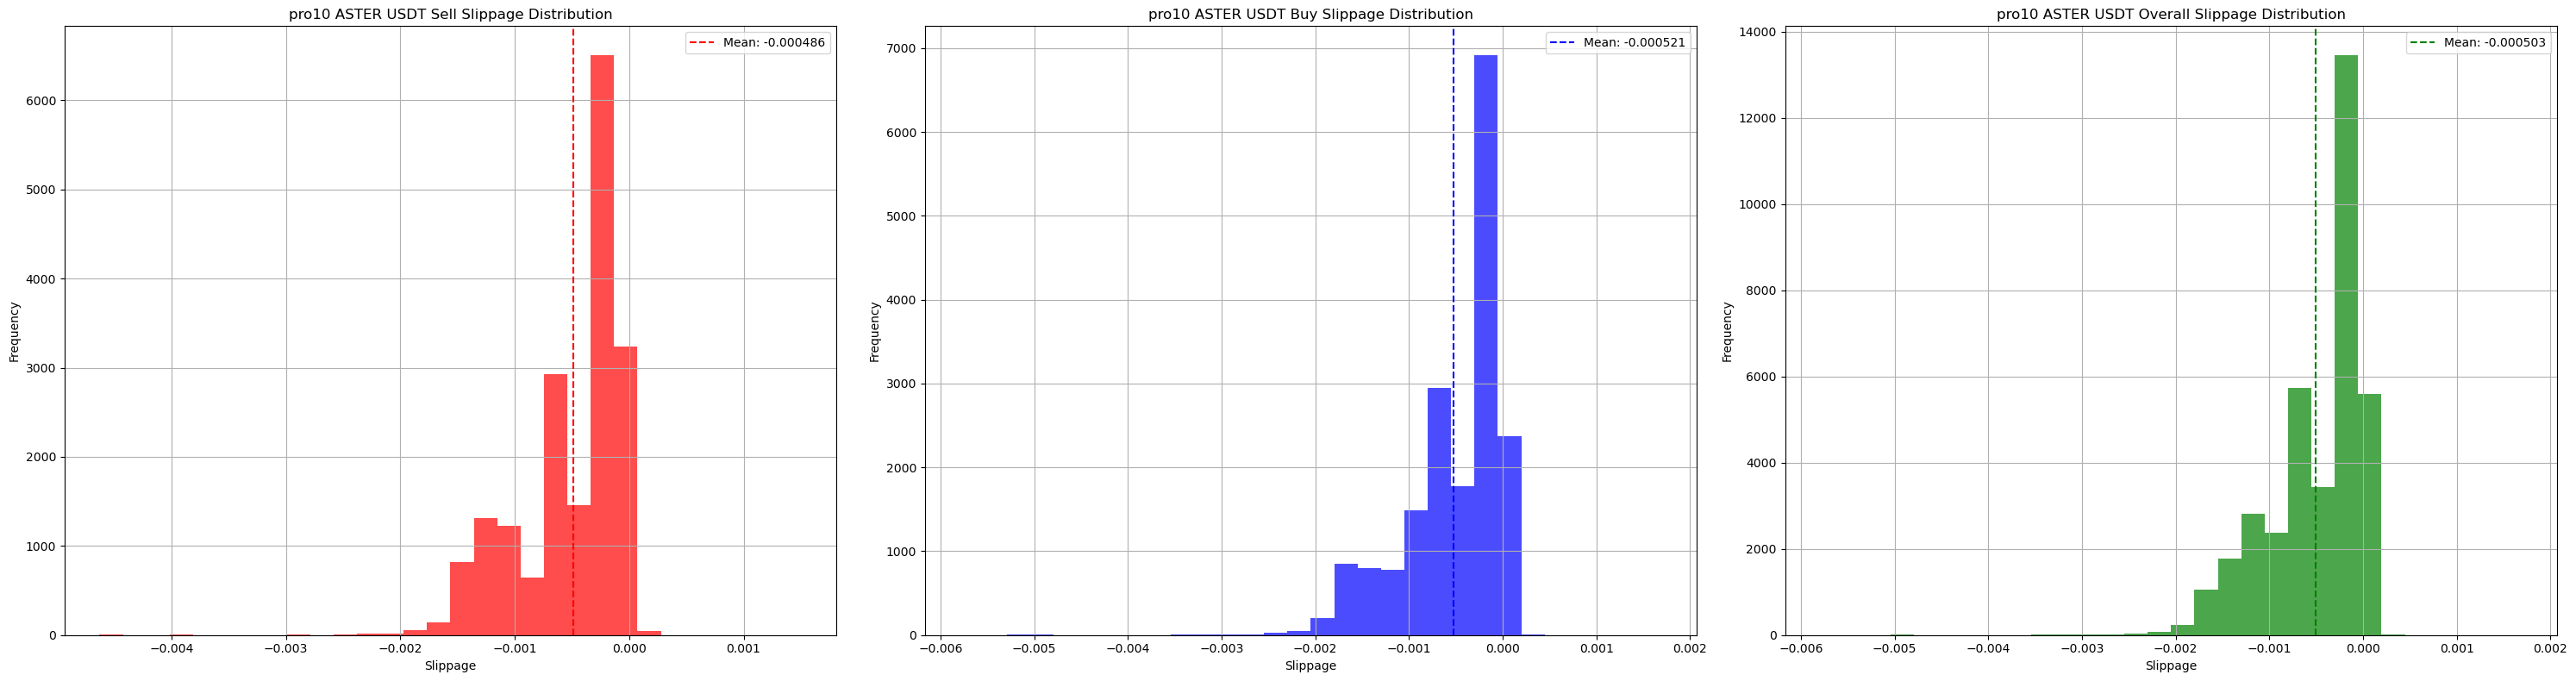

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

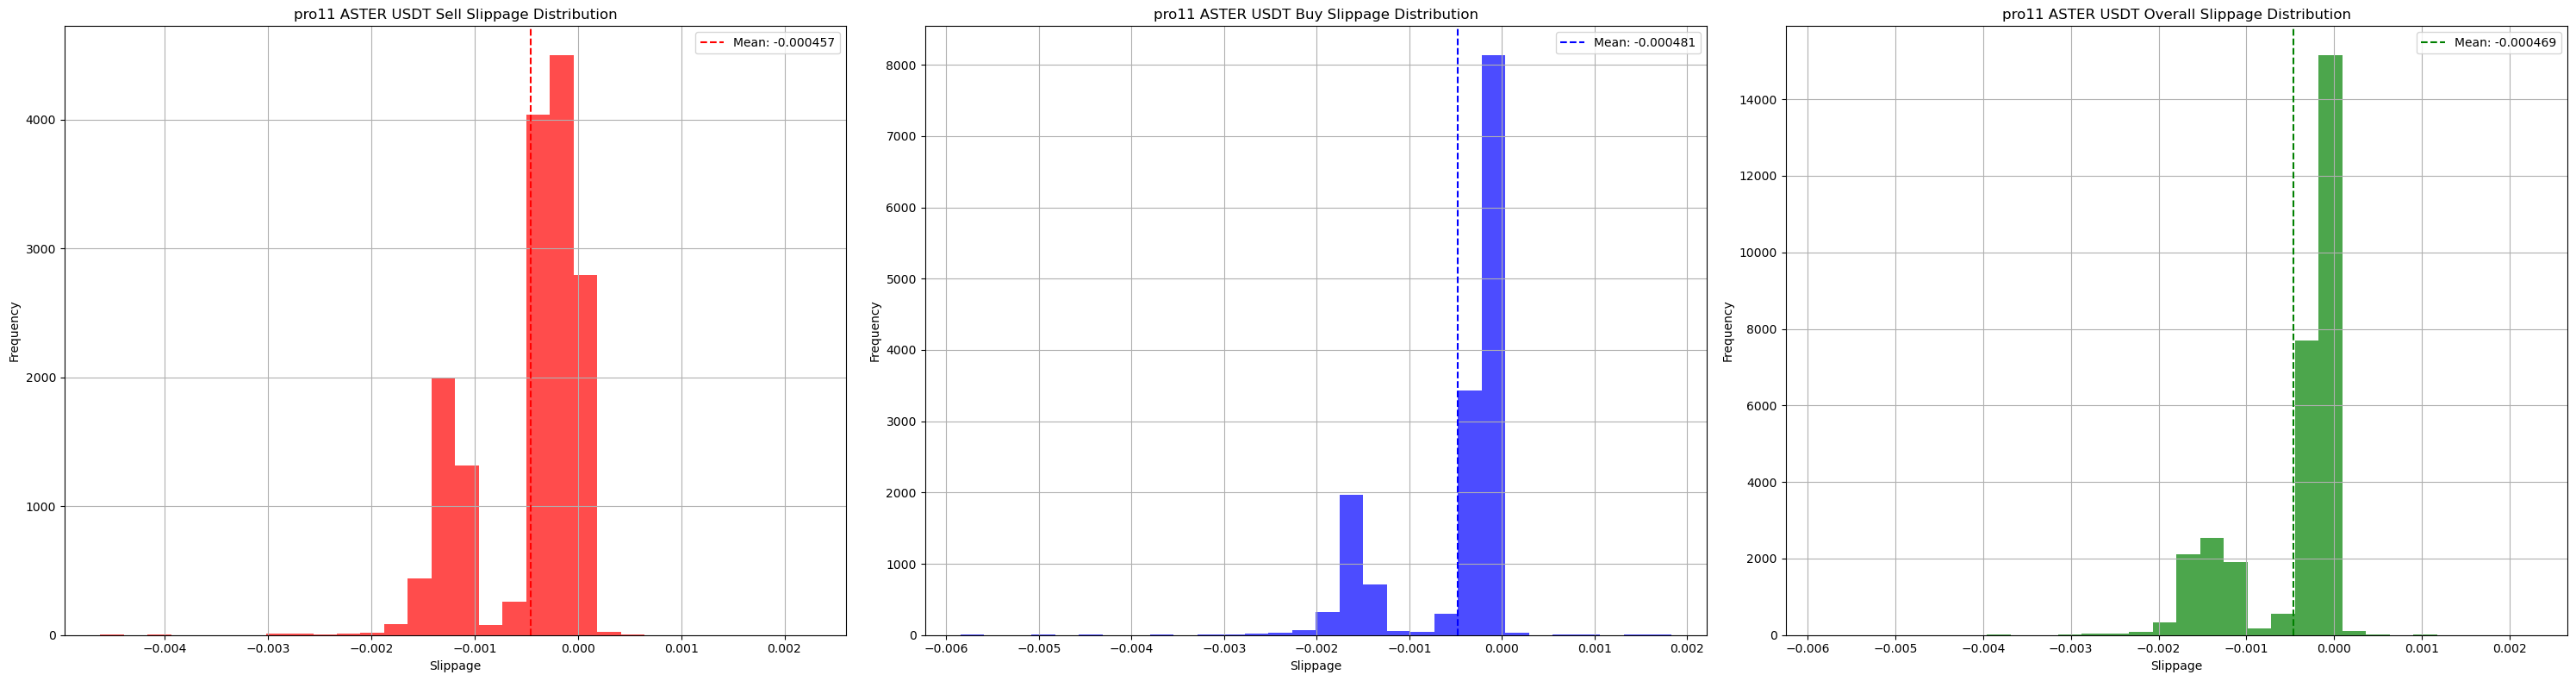

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:87: UserWarning: Boolean Ser

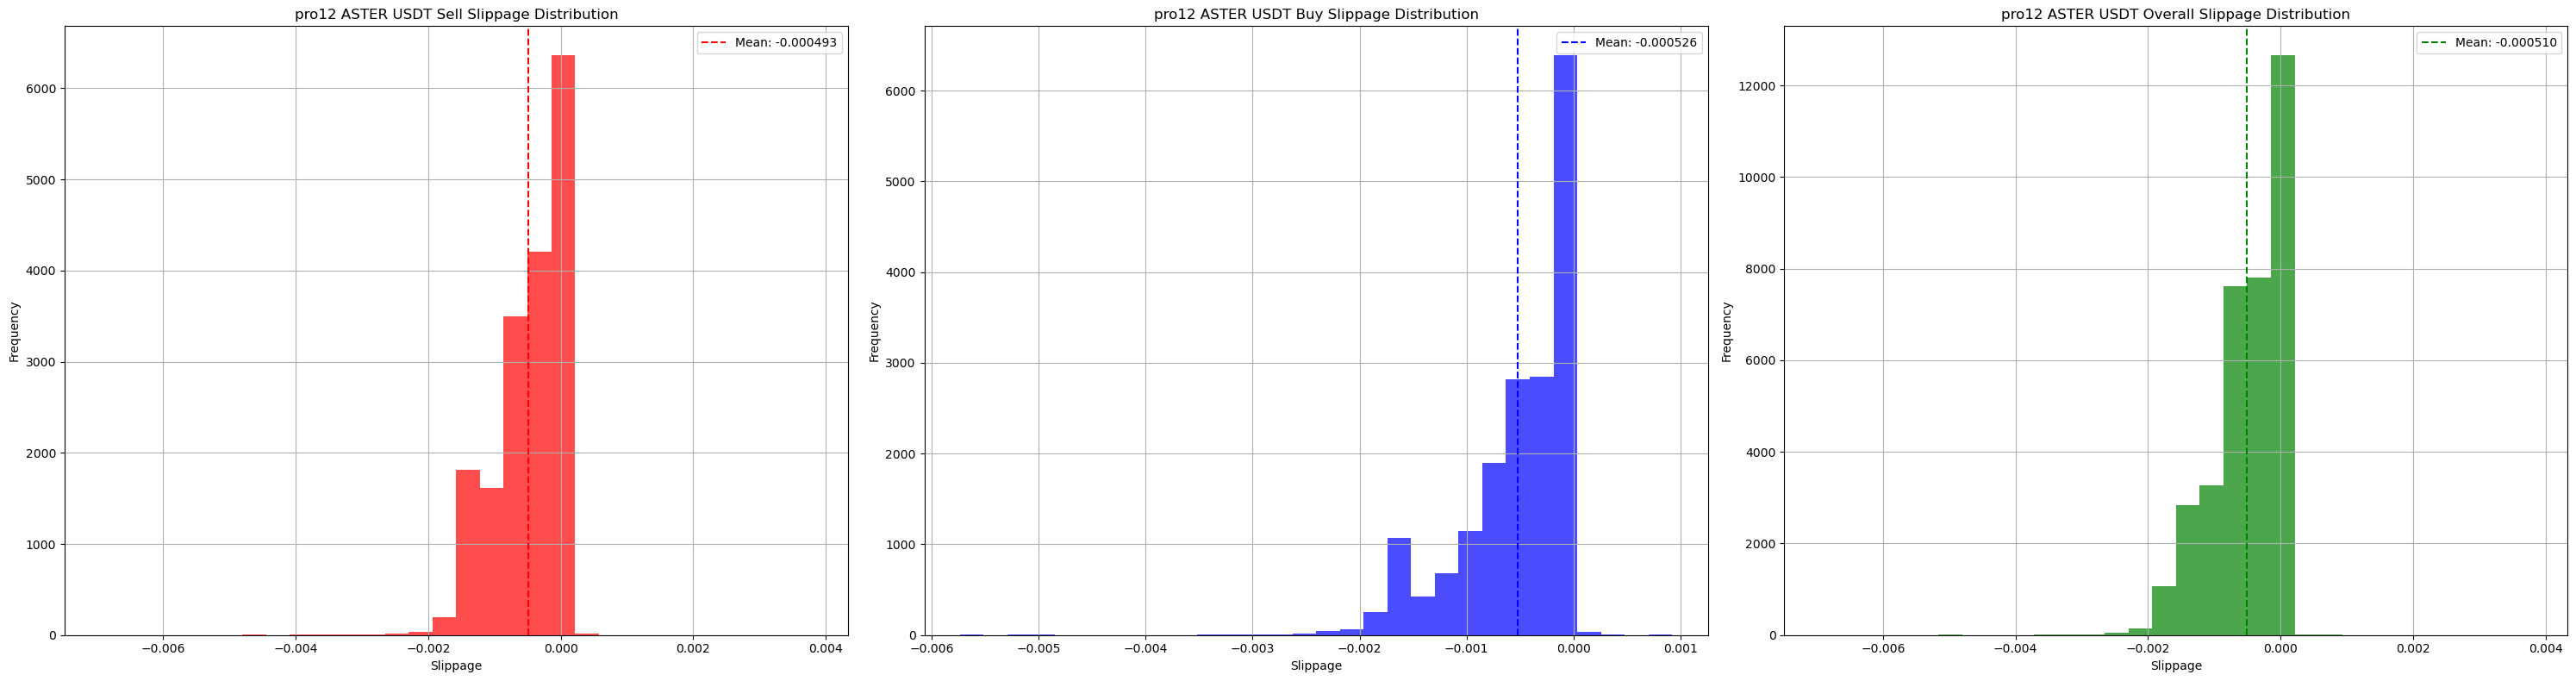

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

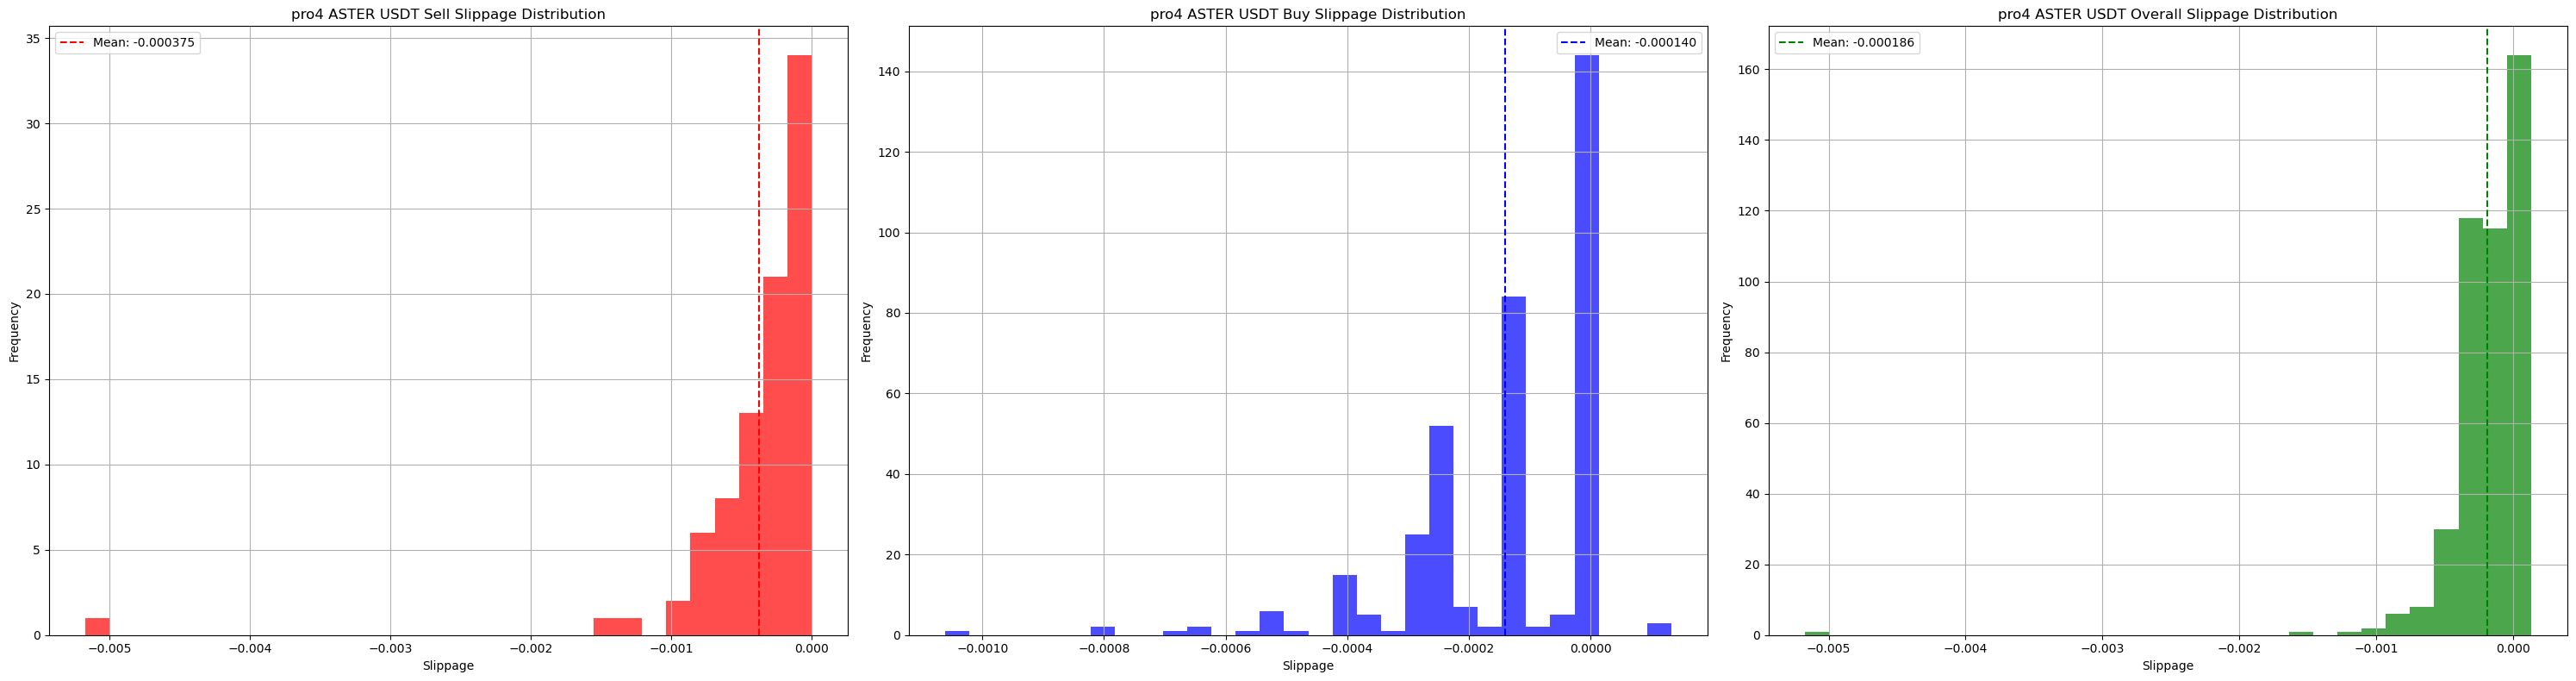

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

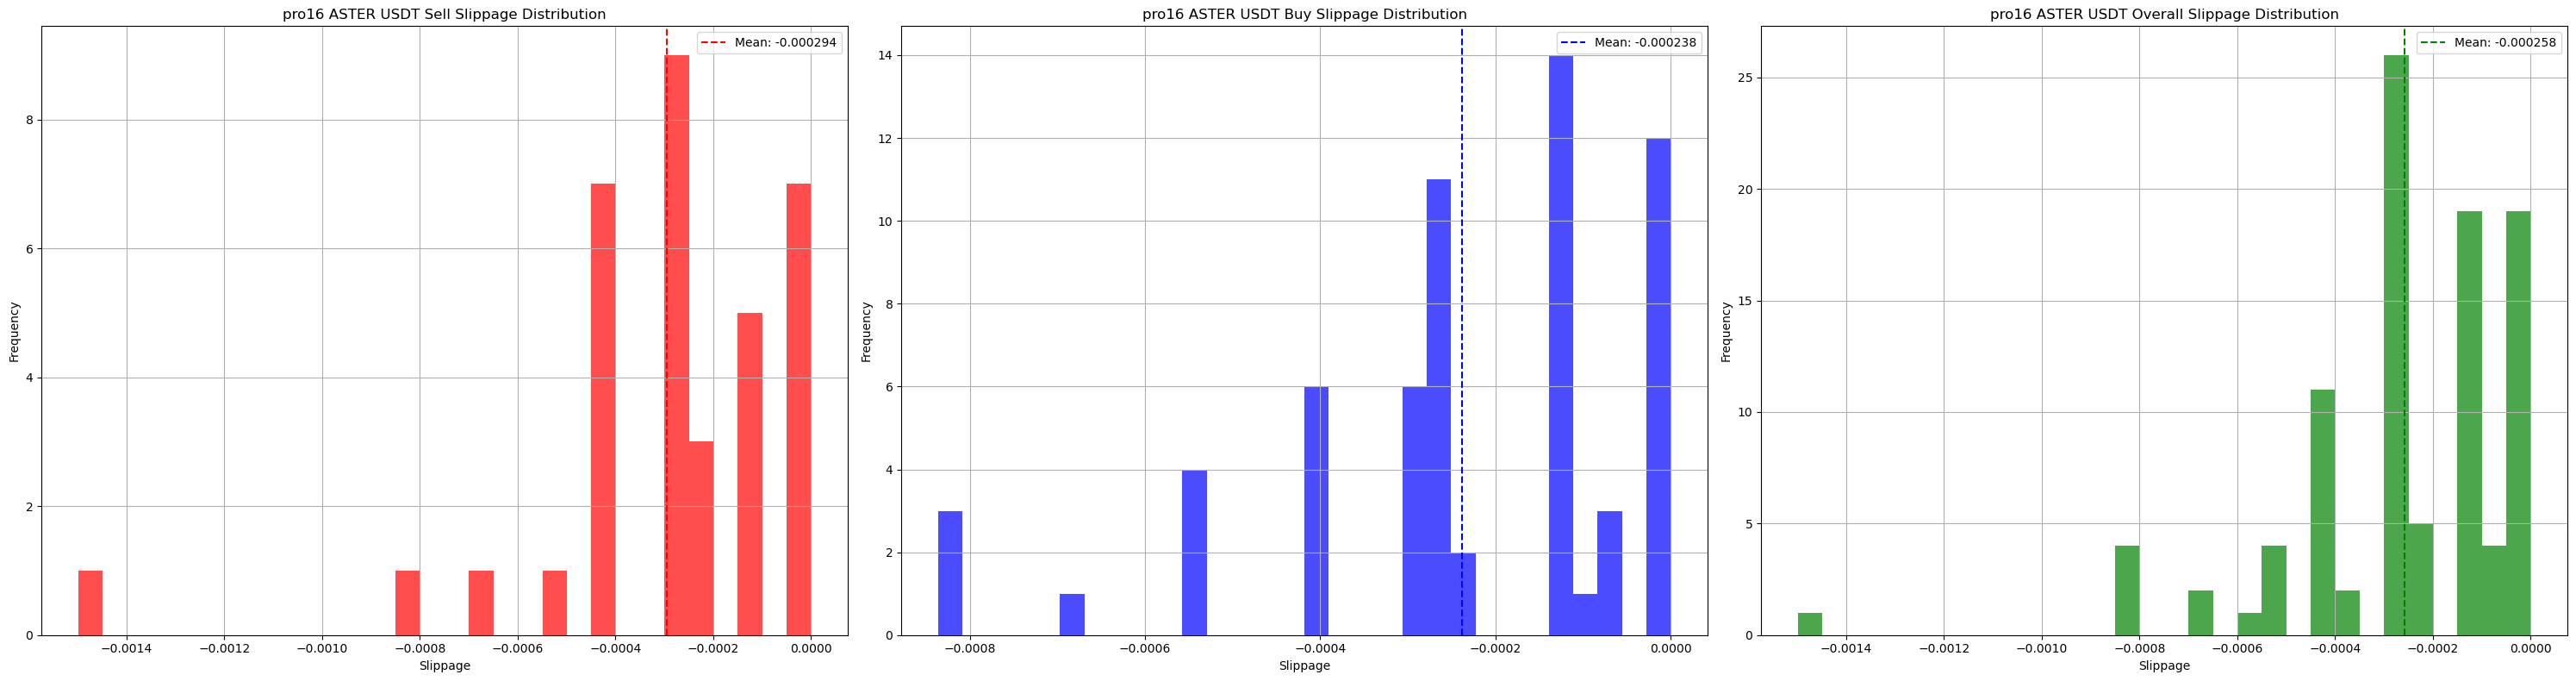

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_69956/1325737168.py:87: UserWarning: Boolean Ser

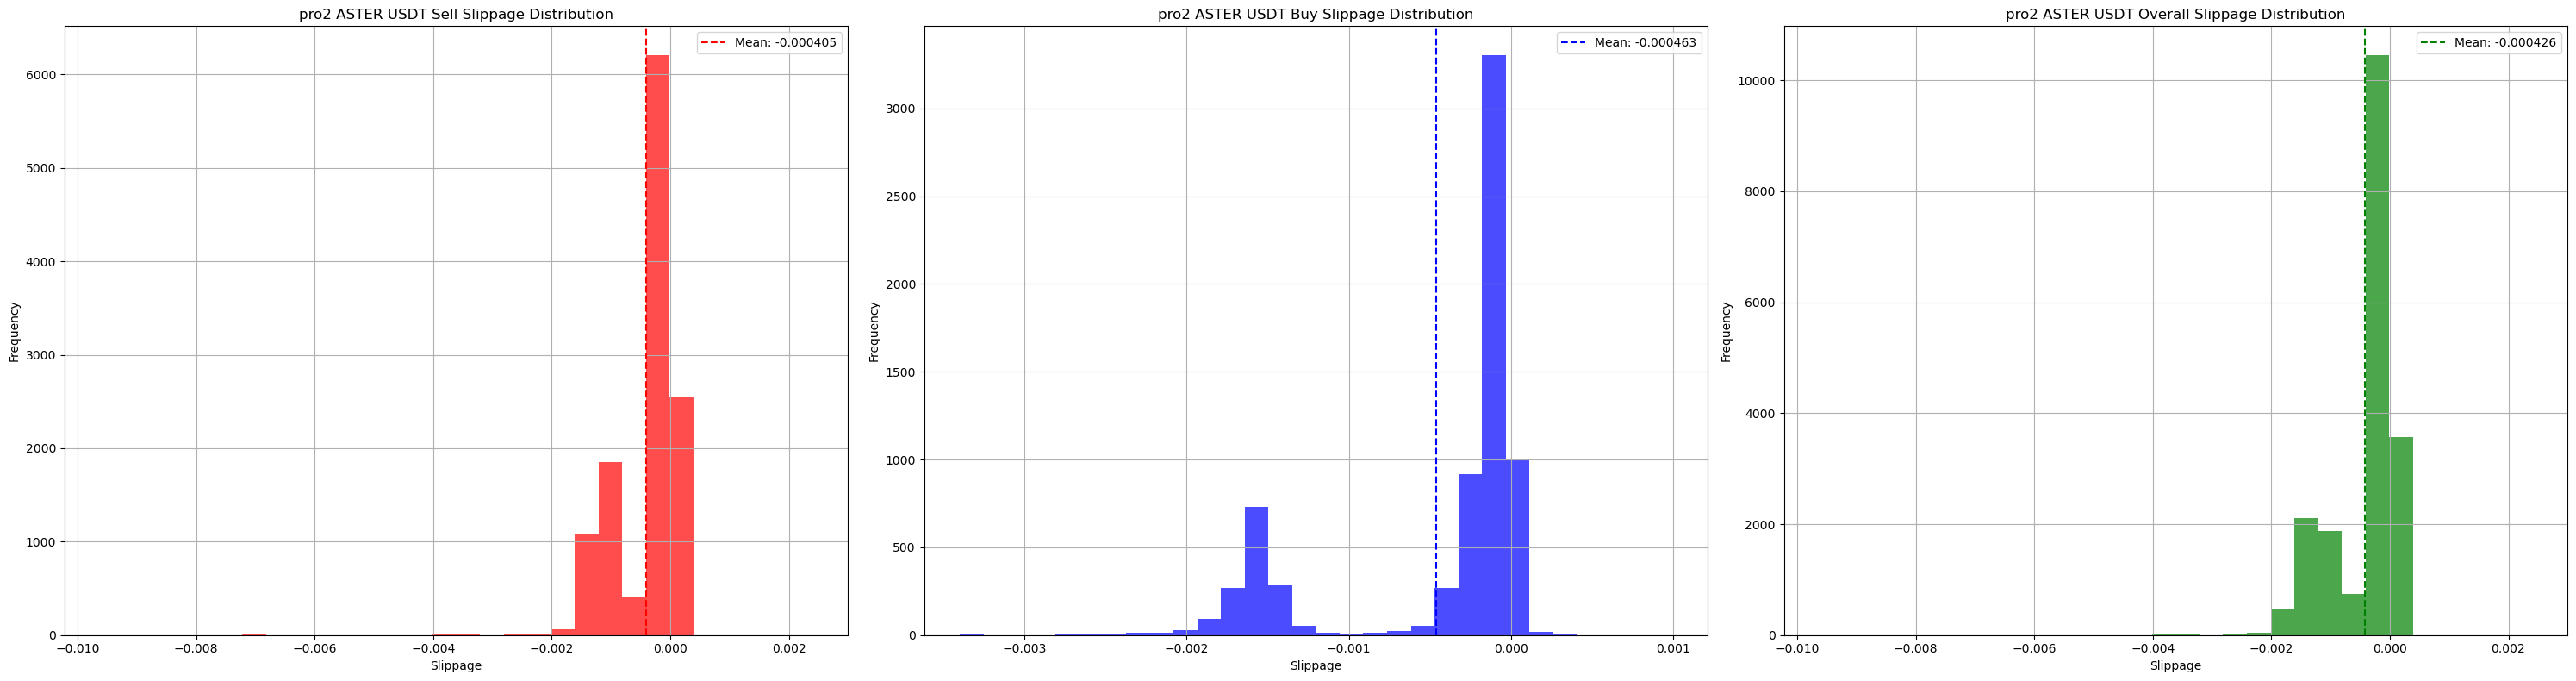

2026-01-07 15:00:00 2026-01-15 15:00:00


symbol                               replace  count      mean    median  \
env                                                                             
pro4   ASTER                            MakerTaker    446 -0.000186 -0.000132   
pro16  ASTER                            MakerTaker     98 -0.000258 -0.000264   
pro2   ASTER  msecs10000 replace10 abnormal 0.0001  19336 -0.000426 -0.000141   
pro11  ASTER  msecs10000 replace10 abnormal 0.0002  30793 -0.000469 -0.000261   
pro10  ASTER  msecs10000 replace10 abnormal 0.0005  36683 -0.000503 -0.000284   
pro12  ASTER   msecs10000 replace1 abnormal 0.0005  35533 -0.000510 -0.000285   

           std       min      max  percentile_5  percentile_10  percentile_25  \
env                                                                             
pro4  0.000313 -0.005173 0.000133     -0.000541      -0.000404      -0.000265   
pro16 0.000238 -0.001499 0.000000     -0.000714      -0.000539      -0.000369   
pro2  0.000552 -0.009622 0.002395     -0.001540      -0.001321      -0.000434   
pro11 0.000572 -0.005847 0.002254     -0.001594      -0.001480      -0.000547   
pro10 0.000494 -0.005793 0.001697     -0.001527      -0.001261      -0.000705   
pro12 0.000503 -0.006951 0.003796     -0.001531      -0.001265      -0.000708   

       percentile_50  percentile_60  percentile_75  percentile_95  \
env                                                                 
pro4       -0.000132      -0.000129      -0.000000       0.000000   
pro16      -0.000264      -0.000137      -0.000132      -0.000000   
pro2       -0.000141      -0.000140      -0.000138       0.000000   
pro11      -0.000261      -0.000140      -0.000136       0.000000   
pro10      -0.000284      -0.000271      -0.000139       0.000000   
pro12      -0.000285      -0.000272      -0.000139       0.000000   

       BNFirstSlippage  BNFirstSlippage_count  OKFirstSlippage  \
env                                                              
pro4         -0.000186                    446              NaN   
pro16        -0.000258                     98              NaN   
pro2         -0.000432                  13060        -0.000414   
pro11        -0.000473                  22149        -0.000457   
pro10        -0.000513                  26768        -0.000476   
pro12        -0.000518                  25980        -0.000486   

       OKFirstSlippage_count  
env                           
pro4                       0  
pro16                      0  
pro2                    6276  
pro11                   8644  
pro10                   9913  
pro12                   9553

In [5]:
import pandas as pd
from CONFIG import *

symbol = 'ASTER'
env_list = ['pro1','pro2','pro10','pro11','pro12']
env_list = ['pro10','pro11','pro12','pro4','pro16','pro2']
# env_list = ['pro1','pro10','pro11','pro12','pro3','pro4']
# env_list = ['pro3']
replace_dict = {
'pro1':'preTakerMaker',
'pro2': 'msecs10000 replace10 abnormal 0.0001',
'pro10': 'msecs10000 replace10 abnormal 0.0005',
'pro11': 'msecs10000 replace10 abnormal 0.0002', 
'pro12': 'msecs10000 replace1 abnormal 0.0005',
'pro3':'preTakerMaker',
'pro4':'MakerTaker',
'pro5':'MakerTaker',
'pro7':'MakerTaker',
'pro16':'MakerTaker',
'pro17':'MakerTaker',
'pro18':'MakerTaker'
}

start_date = '2026-01-07 15:00:00'
# start_date = '2025-12-11 15:30:00'
end_date = '2026-01-15 15:00:00'

summary = []
base_dir = get_base_dir()

for env in env_list:
    try:
        file_path_1 = f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.close.csv'
        file_path_2 = f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.open.csv'
        if env == 'pmpro':
            file_path_1 = f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.close.csv'
            file_path_2 = f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.open.csv'
        slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


        # 创建子图  
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

        # 分析卖出滑点
        sell_slippage = short_slippage['slippage']
        sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
        ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
        ax1.set_xlabel('Slippage')
        ax1.set_ylabel('Frequency')
        sell_mean = sell_slippage.mean()
        sell_std = sell_slippage.std()
        ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
        ax1.legend()
        # print('sell count', len(sell_slippage))


        # 分析买入滑点
        buy_slippage = long_slippage['slippage']
        buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
        ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
        ax2.set_xlabel('Slippage')
        ax2.set_ylabel('Frequency')
        buy_mean = buy_slippage.mean()
        buy_std = buy_slippage.std()
        ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
        ax2.legend()
        # print('buy count', len(buy_slippage))

        # overall滑点分布
        slippage_array = slippage_df_selected['slippage'].values
        slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
        ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
        ax3.set_xlabel('Slippage')
        ax3.set_ylabel('Frequency')
        overall_mean = slippage_array.mean()
        ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
        ax3.legend()

        plt.tight_layout()
        plt.show()
        stats = {
            'symbol': symbol,
            'env': env,
            'replace': replace_dict[env],
            'count': len(slippage_array),
            'mean': np.mean(slippage_array),
            'median': np.median(slippage_array),
            'std': np.std(slippage_array),
            'min': np.min(slippage_array),
            'max': np.max(slippage_array),
            # 'percentile_1': np.percentile(slippage_array, 1),
            'percentile_5': np.percentile(slippage_array, 5),
            'percentile_10': np.percentile(slippage_array, 10),
            'percentile_25': np.percentile(slippage_array, 25),
            'percentile_50': np.percentile(slippage_array, 50),
            # 'percentile_55': np.percentile(slippage_array, 55),        
            'percentile_60': np.percentile(slippage_array, 60),
            # 'percentile_65': np.percentile(slippage_array, 65),
            'percentile_75': np.percentile(slippage_array, 75),
            'percentile_95': np.percentile(slippage_array, 95),
            # 'percentile_99': np.percentile(slippage_array, 99),
            'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
            'BNFirstSlippage_count': len(Exchange1FirstSlippage),
            'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
            'OKFirstSlippage_count': len(Exchange2FirstSlippage),
        }

        summary.append(stats)
    except Exception as e:
        print(f'Error processing env {env}: {e}')
df = pd.DataFrame(summary).set_index('env').sort_values(by='mean', ascending=False)
print(start_date,end_date)
df

C:\Users\xusir\AppData\Local\Temp\ipykernel_97448\1325737168.py:6: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
C:\Users\xusir\AppData\Local\Temp\ipykernel_97448\1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
C:\Users\xusir\AppData\Local\Temp\ipykernel_97448\1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
C:\Users\xusir\AppData\Local\Temp\ipykernel_97448\1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
C:\Users\xusir\AppData\Local\Temp\ipykernel_97448\1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_

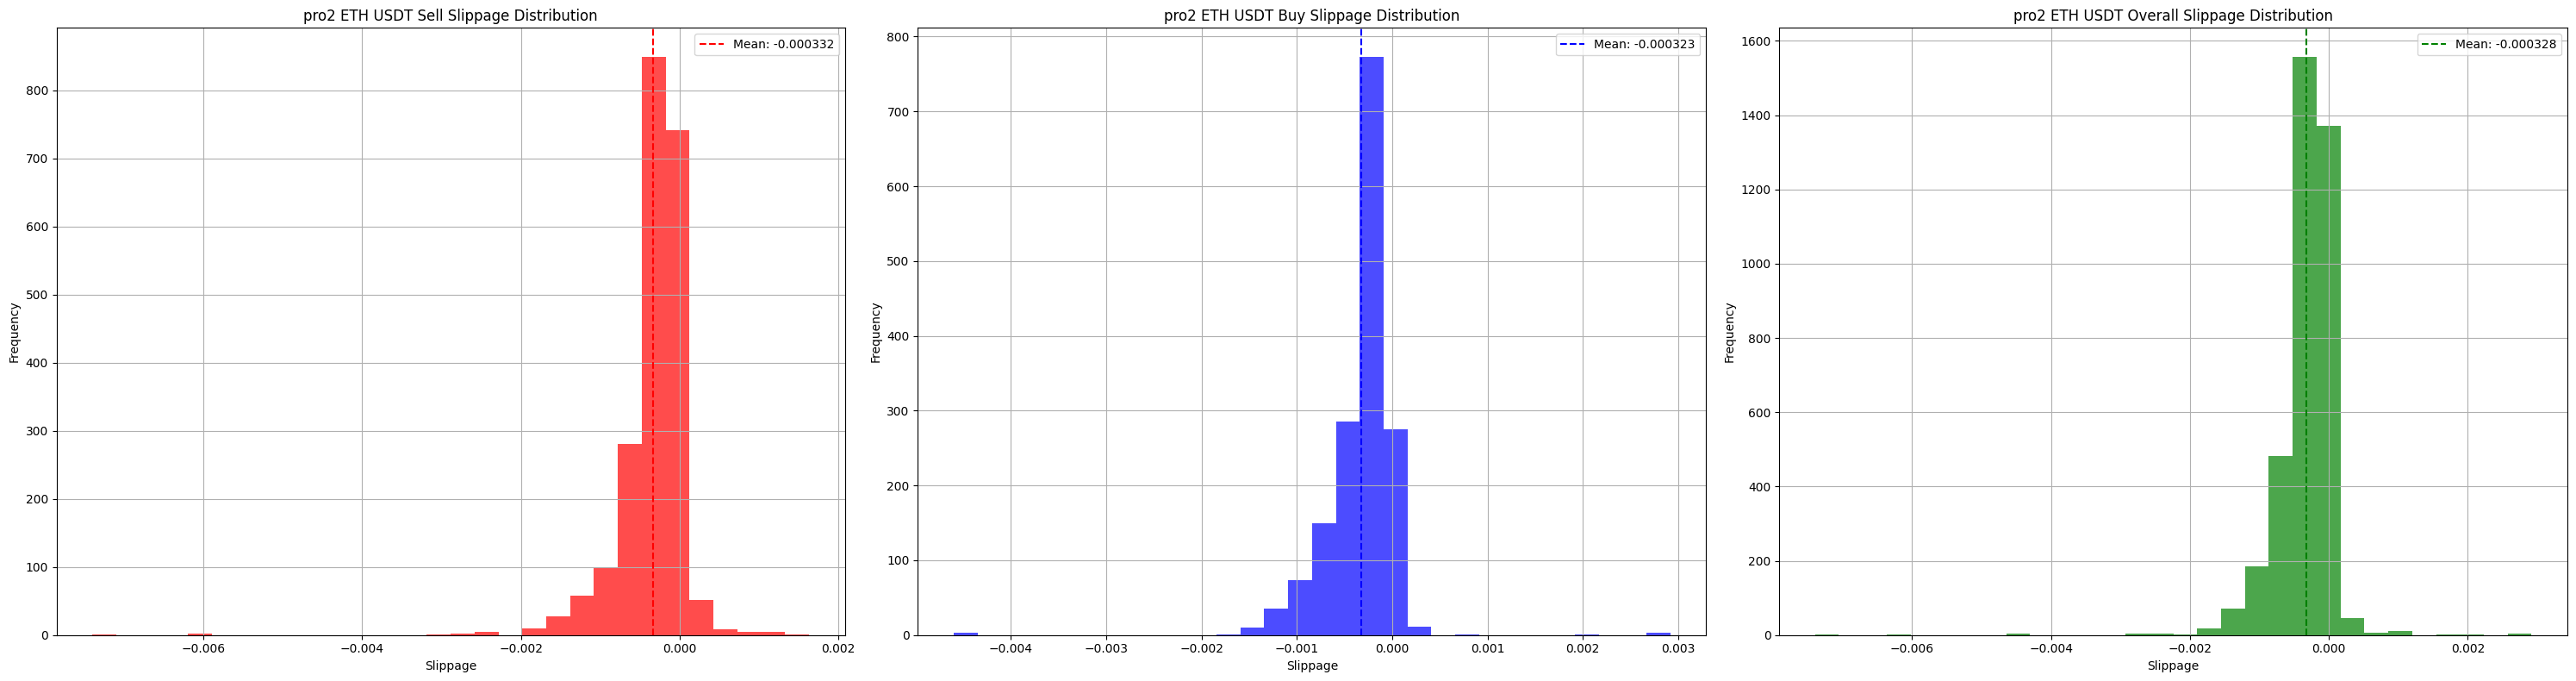

2026-02-01 00:00:00 2026-02-03 15:00:00


symbol                               replace  count      mean    median  \
env                                                                            
pro2    ETH  msecs10000 replace10 abnormal 0.0001   3770 -0.000328 -0.000243   

          std       min      max  percentile_5  percentile_10  percentile_25  \
env                                                                            
pro2 0.000417 -0.007398 0.002917     -0.001031      -0.000751      -0.000451   

      percentile_50  percentile_60  percentile_75  percentile_95  \
env                                                                
pro2      -0.000243      -0.000188      -0.000112       0.000000   

      BNFirstSlippage  BNFirstSlippage_count  OKFirstSlippage  \
env                                                             
pro2        -0.000304                   1698        -0.000348   

      OKFirstSlippage_count  
env                          
pro2                   2072

: 

In [ ]:
import pandas as pd
from CONFIG import *

symbol = 'ETH'
env_list = ['pro2']


replace_dict = {
'pro1':'preTakerMaker',
'pro2': 'msecs10000 replace10 abnormal 0.0001',
'pro10': 'msecs10000 replace10 abnormal 0.0005',
'pro11': 'msecs10000 replace10 abnormal 0.0002', 
'pro12': 'msecs10000 replace1 abnormal 0.0005',
'pro3':'preTakerMaker',
'pro4':'MakerTaker',
'pro5':'MakerTaker',
'pro7':'MakerTaker',
'pro16':'MakerTaker',
'pro17':'MakerTaker',
'pro18':'MakerTaker'
}

start_date = '2026-02-01 00:00:00'
# start_date = '2025-12-11 15:30:00'
end_date = '2026-02-03 15:00:00'

summary = []
base_dir = get_base_dir()

for env in env_list:
    try:
        file_path_1 = f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.close.csv'
        file_path_2 = f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.open.csv'
        if env == 'pmpro':
            file_path_1 = f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.close.csv'
            file_path_2 = f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.open.csv'
        slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


        # 创建子图  
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

        # 分析卖出滑点
        sell_slippage = short_slippage['slippage']
        sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
        ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
        ax1.set_xlabel('Slippage')
        ax1.set_ylabel('Frequency')
        sell_mean = sell_slippage.mean()
        sell_std = sell_slippage.std()
        ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
        ax1.legend()
        # print('sell count', len(sell_slippage))


        # 分析买入滑点
        buy_slippage = long_slippage['slippage']
        buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
        ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
        ax2.set_xlabel('Slippage')
        ax2.set_ylabel('Frequency')
        buy_mean = buy_slippage.mean()
        buy_std = buy_slippage.std()
        ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
        ax2.legend()
        # print('buy count', len(buy_slippage))

        # overall滑点分布
        slippage_array = slippage_df_selected['slippage'].values
        slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
        ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
        ax3.set_xlabel('Slippage')
        ax3.set_ylabel('Frequency')
        overall_mean = slippage_array.mean()
        ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
        ax3.legend()

        plt.tight_layout()
        plt.show()
        stats = {
            'symbol': symbol,
            'env': env,
            'replace': replace_dict[env],
            'count': len(slippage_array),
            'mean': np.mean(slippage_array),
            'median': np.median(slippage_array),
            'std': np.std(slippage_array),
            'min': np.min(slippage_array),
            'max': np.max(slippage_array),
            # 'percentile_1': np.percentile(slippage_array, 1),
            'percentile_5': np.percentile(slippage_array, 5),
            'percentile_10': np.percentile(slippage_array, 10),
            'percentile_25': np.percentile(slippage_array, 25),
            'percentile_50': np.percentile(slippage_array, 50),
            # 'percentile_55': np.percentile(slippage_array, 55),        
            'percentile_60': np.percentile(slippage_array, 60),
            # 'percentile_65': np.percentile(slippage_array, 65),
            'percentile_75': np.percentile(slippage_array, 75),
            'percentile_95': np.percentile(slippage_array, 95),
            # 'percentile_99': np.percentile(slippage_array, 99),
            'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
            'BNFirstSlippage_count': len(Exchange1FirstSlippage),
            'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
            'OKFirstSlippage_count': len(Exchange2FirstSlippage),
        }

        summary.append(stats)
    except Exception as e:
        print(f'Error processing env {env}: {e}')
df = pd.DataFrame(summary).set_index('env').sort_values(by='mean', ascending=False)
print(start_date,end_date)
df

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:6: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:86: User

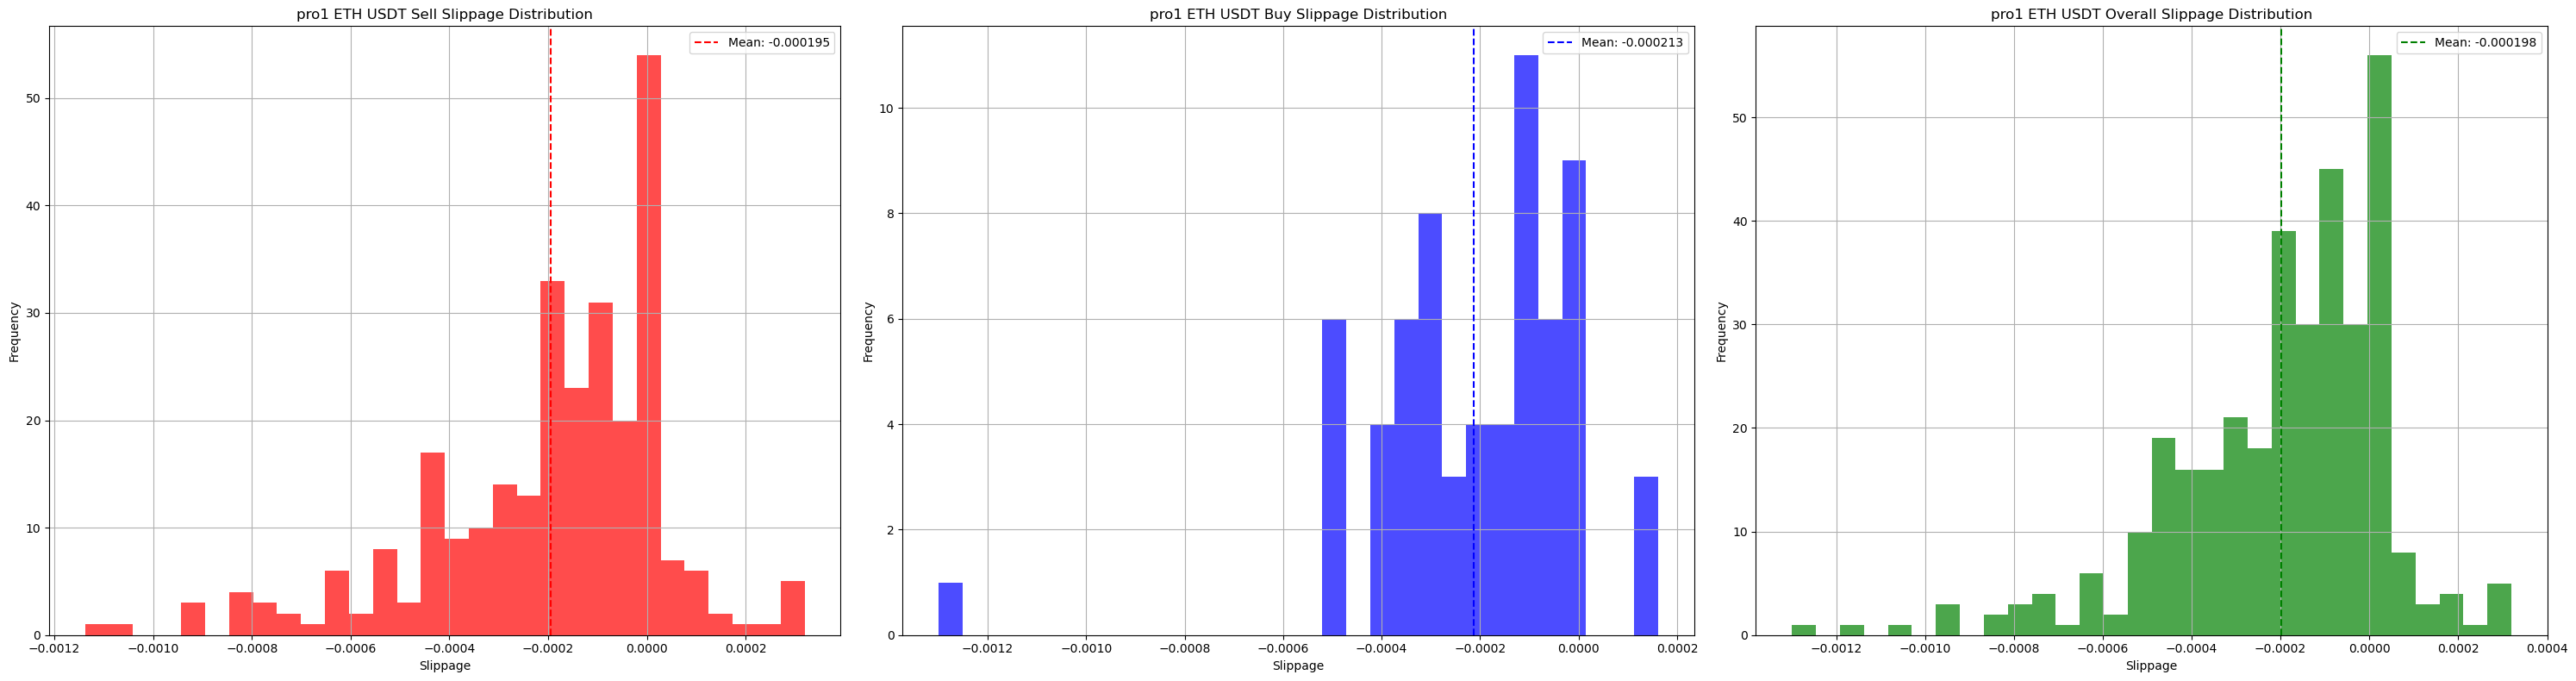

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:6: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:87: UserWarning: Boolean Series k

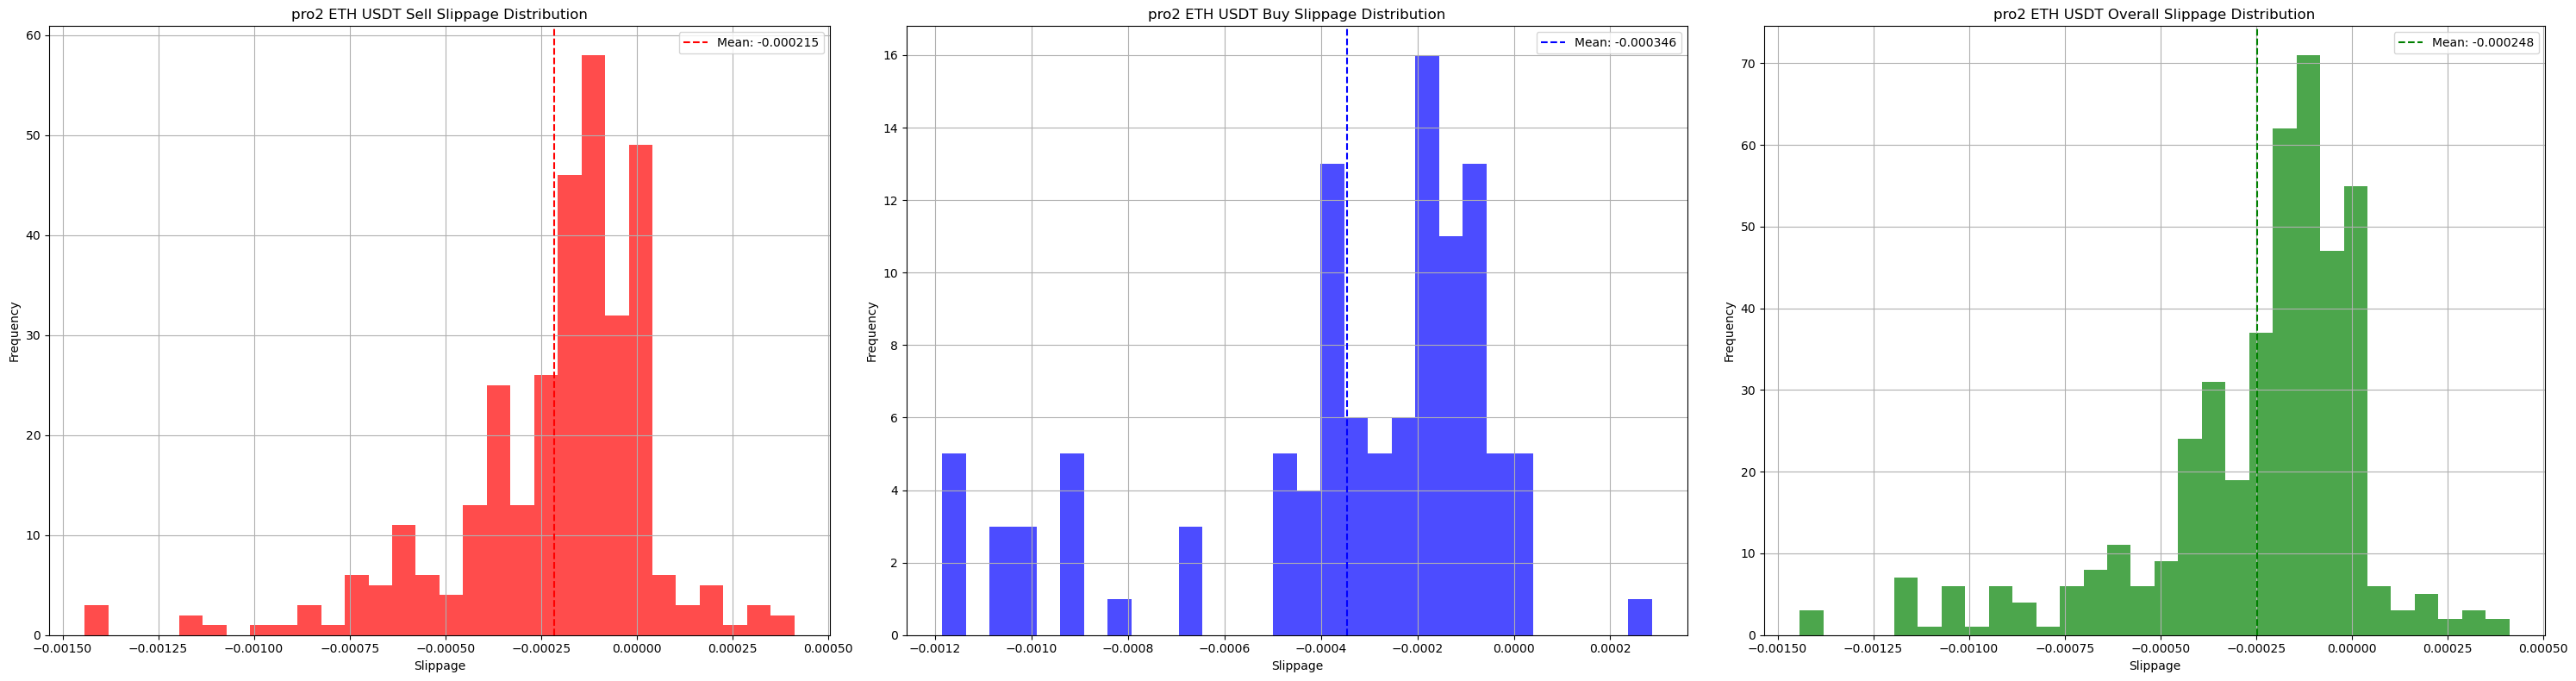

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:6: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:86: User

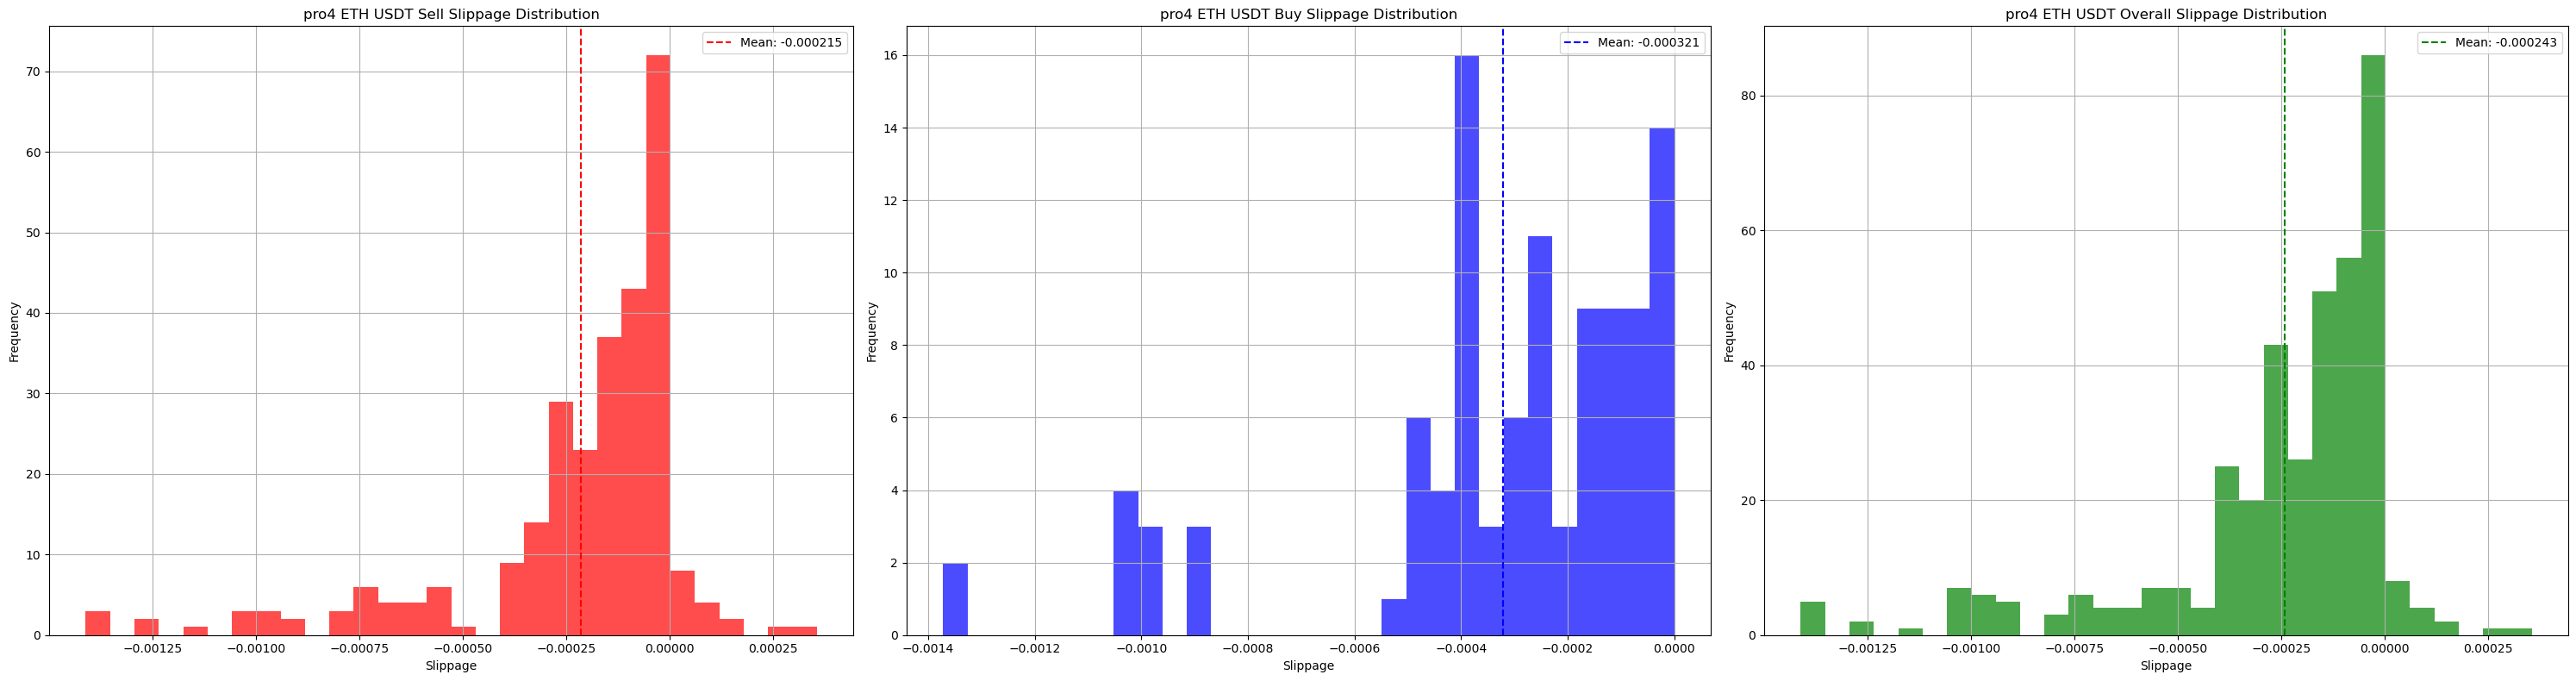

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/1325737168.py:94: UserWarning: Boolean Series key will be reindexed to m

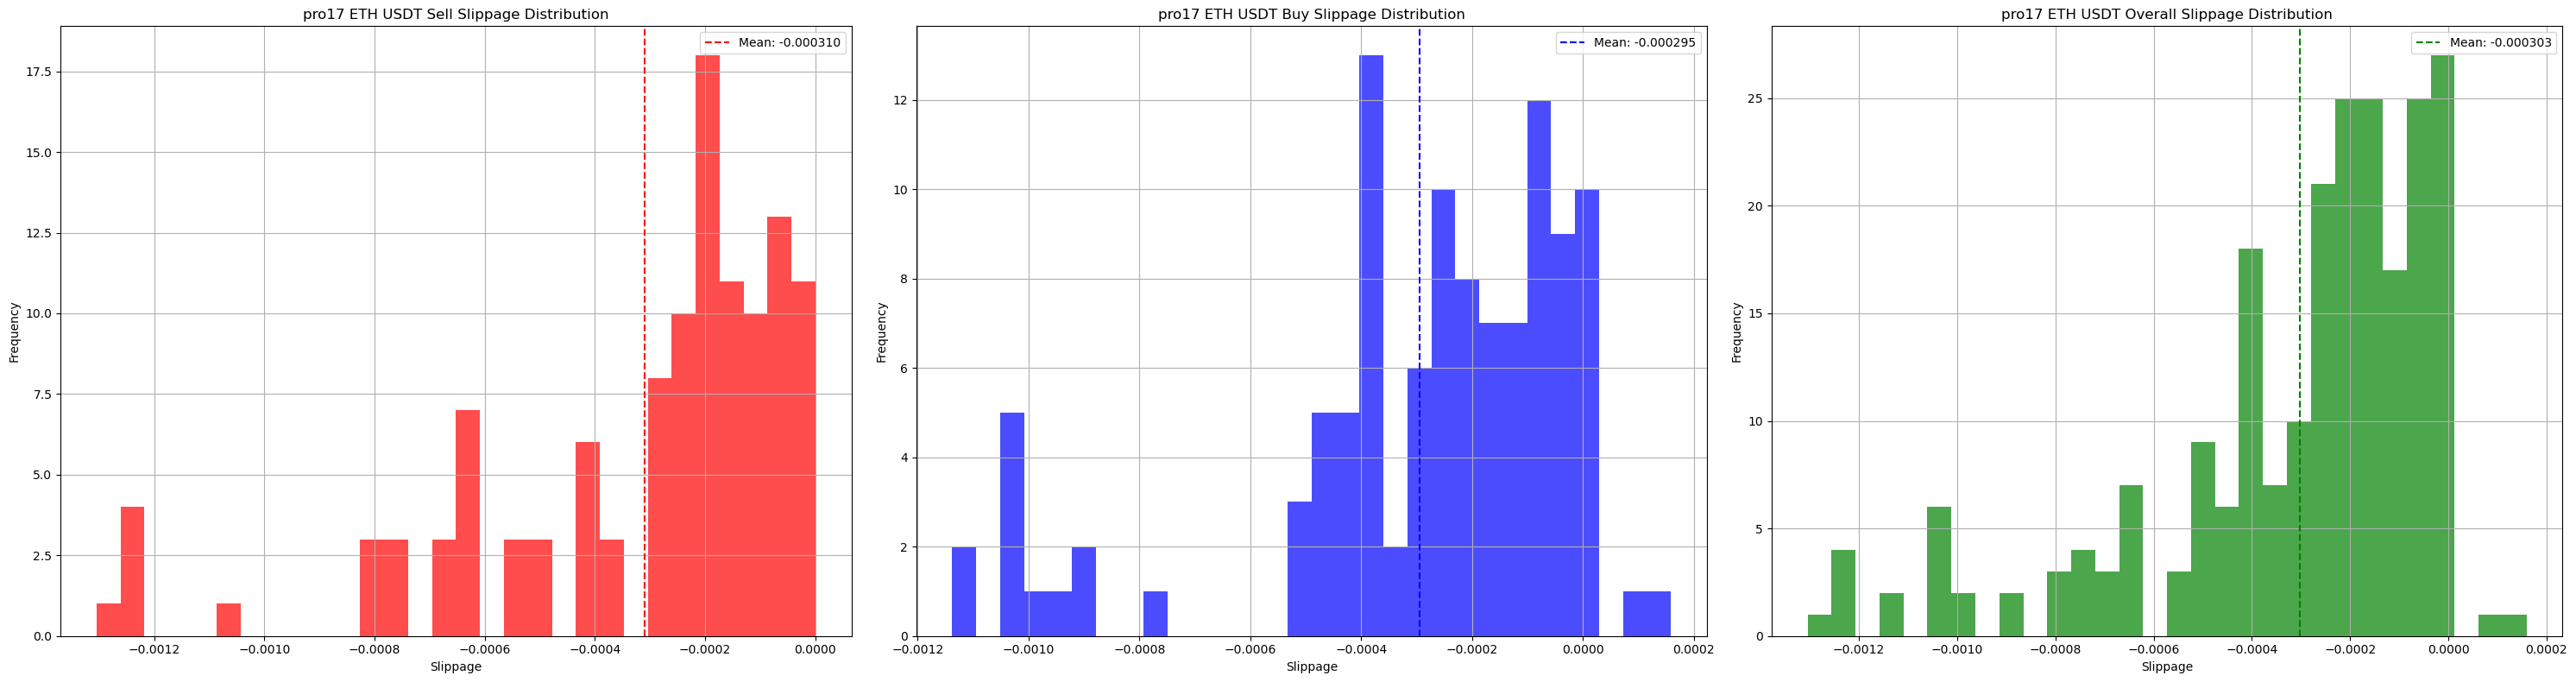

2026-02-02 04:00:00 2026-02-03 15:00:00


symbol                               replace  count      mean    median  \
env                                                                             
pro1     ETH                         preTakerMaker    345 -0.000198 -0.000139   
pro4     ETH                            MakerTaker    384 -0.000243 -0.000152   
pro2     ETH  msecs10000 replace10 abnormal 0.0001    436 -0.000248 -0.000180   
pro17    ETH                            MakerTaker    229 -0.000303 -0.000211   

           std       min      max  percentile_5  percentile_10  percentile_25  \
env                                                                             
pro1  0.000238 -0.001299 0.000320     -0.000630      -0.000490      -0.000325   
pro4  0.000295 -0.001411 0.000354     -0.000965      -0.000664      -0.000323   
pro2  0.000292 -0.001442 0.000412     -0.000896      -0.000626      -0.000360   
pro17 0.000295 -0.001305 0.000159     -0.001032      -0.000745      -0.000397   

       percentile_50  percentile_60  percentile_75  percentile_95  \
env                                                                 
pro1       -0.000139      -0.000098      -0.000027       0.000078   
pro4       -0.000152      -0.000116      -0.000051       0.000000   
pro2       -0.000180      -0.000126      -0.000065       0.000030   
pro17      -0.000211      -0.000177      -0.000098      -0.000000   

       BNFirstSlippage  BNFirstSlippage_count  OKFirstSlippage  \
env                                                              
pro1         -0.000220                    106        -0.000189   
pro4         -0.000217                    160        -0.000265   
pro2         -0.000243                    155        -0.000251   
pro17        -0.000237                    101        -0.000355   

       OKFirstSlippage_count  
env                           
pro1                     239  
pro4                     221  
pro2                     281  
pro17                    128

In [13]:
import pandas as pd
from CONFIG import *

symbol = 'ETH'
env_list = ['pro1','pro2','pro4','pro17']

replace_dict = {
'pro1':'preTakerMaker',
'pro2': 'msecs10000 replace10 abnormal 0.0001',
'pro10': 'msecs10000 replace10 abnormal 0.0005',
'pro11': 'msecs10000 replace10 abnormal 0.0002', 
'pro12': 'msecs10000 replace1 abnormal 0.0005',
'pro3':'preTakerMaker',
'pro4':'MakerTaker',
'pro5':'MakerTaker',
'pro7':'MakerTaker',
'pro16':'MakerTaker',
'pro17':'MakerTaker',
'pro18':'MakerTaker'
}

start_date = '2026-02-02 04:00:00'
end_date = '2026-02-03 15:00:00'

summary = []
base_dir = get_base_dir()

for env in env_list:
    try:
        file_path_1 = f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.close.csv'
        file_path_2 = f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.open.csv'
        if env == 'pmpro':
            file_path_1 = f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.close.csv'
            file_path_2 = f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.open.csv'
        slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


        # 创建子图  
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

        # 分析卖出滑点
        sell_slippage = short_slippage['slippage']
        sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
        ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
        ax1.set_xlabel('Slippage')
        ax1.set_ylabel('Frequency')
        sell_mean = sell_slippage.mean()
        sell_std = sell_slippage.std()
        ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
        ax1.legend()
        # print('sell count', len(sell_slippage))


        # 分析买入滑点
        buy_slippage = long_slippage['slippage']
        buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
        ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
        ax2.set_xlabel('Slippage')
        ax2.set_ylabel('Frequency')
        buy_mean = buy_slippage.mean()
        buy_std = buy_slippage.std()
        ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
        ax2.legend()
        # print('buy count', len(buy_slippage))

        # overall滑点分布
        slippage_array = slippage_df_selected['slippage'].values
        slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
        ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
        ax3.set_xlabel('Slippage')
        ax3.set_ylabel('Frequency')
        overall_mean = slippage_array.mean()
        ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
        ax3.legend()

        plt.tight_layout()
        plt.show()
        stats = {
            'symbol': symbol,
            'env': env,
            'replace': replace_dict[env],
            'count': len(slippage_array),
            'mean': np.mean(slippage_array),
            'median': np.median(slippage_array),
            'std': np.std(slippage_array),
            'min': np.min(slippage_array),
            'max': np.max(slippage_array),
            # 'percentile_1': np.percentile(slippage_array, 1),
            'percentile_5': np.percentile(slippage_array, 5),
            'percentile_10': np.percentile(slippage_array, 10),
            'percentile_25': np.percentile(slippage_array, 25),
            'percentile_50': np.percentile(slippage_array, 50),
            # 'percentile_55': np.percentile(slippage_array, 55),        
            'percentile_60': np.percentile(slippage_array, 60),
            # 'percentile_65': np.percentile(slippage_array, 65),
            'percentile_75': np.percentile(slippage_array, 75),
            'percentile_95': np.percentile(slippage_array, 95),
            # 'percentile_99': np.percentile(slippage_array, 99),
            'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
            'BNFirstSlippage_count': len(Exchange1FirstSlippage),
            'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
            'OKFirstSlippage_count': len(Exchange2FirstSlippage),
        }

        summary.append(stats)
    except Exception as e:
        print(f'Error processing env {env}: {e}')
df = pd.DataFrame(summary).set_index('env').sort_values(by='mean', ascending=False)
print(start_date,end_date)
df

In [9]:
symbol = 'ETH'
env= 'manager_dcpro5'

start_date = '2026-02-04 20:00:00'
end_date = '2026-02-05 08:43:00'

file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.close.csv'
file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.open.csv'

columns_used = ['sr_open_real', 'sr_open','sr_close_real', 'sr_close', 'real_earn', 'funding1_real', 'funding2_real', 'swap1_avg_price', 'swap1_deal_amount', 'swap2_avg_price', 'swap2_deal_amount']

df_close = pd.read_csv(file_path_1)
df_open = pd.read_csv(file_path_2)

if not df_open.empty:
    df_open = df_open[df_open['start'].astype(str).str.contains(r'\d{4}-\d{2}-\d{2}')]
    df_open['time'] = df_open['start'].apply(parse_start_time)

if not df_close.empty:
    df_close = df_close[df_close['start'].astype(str).str.contains(r'\d{4}-\d{2}-\d{2}')]
    df_close['time'] = df_close['start'].apply(parse_start_time)


# 把columns_used都转化为float（前提是得在这个dataframe的column里面）
for c in columns_used:
    if c in df_open.columns:
        df_open[c] = pd.to_numeric(df_open[c], errors='coerce')
for c in columns_used:
    if c in df_close.columns:
        df_close[c] = pd.to_numeric(df_close[c], errors='coerce')

df_open['sign'] = (
    df_open['swap1_side']
    .map({'buy': 1, 'sell': -1})
    .fillna(0)
    .astype('int8')
)

df_open['slippage'] = (df_open['sr_open_real'] - df_open['sr_open'])*df_open['sign']




df_close['sign'] = (
    df_close['swap1_side']
    .map({'closeShort': 1, 'closeLong': -1})
    .fillna(0)
    .astype('int8')
)

df_close['slippage'] = (df_close['sr_close_real'] - df_close['sr_close'])*df_close['sign']


df_open_selected = df_open[(df_open['time'] >= start_date) & (df_open['time'] <= end_date)]
df_close_selected = df_close[(df_close['time'] >= start_date) & (df_close['time'] <= end_date)]

df_close_selected['isTaker'] = (df_close_selected['fee1']+0.00000001)*(df_close_selected['fee2']+0.00000001)
df_open_selected['isTaker'] = (df_open_selected['fee1']+0.00000001)*(df_open_selected['fee2']+0.00000001)

overall_ratio = (len(df_close_selected)/(len(df_open_selected)+len(df_close_selected)))*(len(df_close_selected[df_close_selected['isTaker']< 0]))/len(df_close_selected)+(len(df_open_selected)/(len(df_open_selected)+len(df_close_selected)))*(len(df_open_selected[df_open_selected['isTaker']< 0]))/len(df_open_selected)
print(overall_ratio)
# print((len(df_close_selected[df_close_selected['isTaker']< 0]))/len(df_close_selected))
# print((len(df_open_selected[df_open_selected['isTaker']< 0]))/len(df_open_selected))

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_21079/8182561.py:12: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1)
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_21079/8182561.py:13: DtypeWarning: Columns (8,10,12,17,19,21,28,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2)


0.04341926729986432


/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_21079/8182561.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close_selected['isTaker'] = (df_close_selected['fee1']+0.00000001)*(df_close_selected['fee2']+0.00000001)
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_21079/8182561.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_open_selected['isTaker'] = (df_open_selected['fee1']+0.00000001)*(df_open_selected['fee2']+0.00000001)


In [35]:
df_close_selected[df_close_selected['isTaker']<0]

Empty DataFrame
Columns: [start, sr_close, sr_close_real, swap1_order_id, swap1_avg_price, swap1_deal_amount, swap1_side, swap1_fee, swap1_fee_currency, swap1_is_maker, swap1_open_time, swap1_done_time, swap2_order_id, swap2_avg_price, swap2_deal_amount, swap2_side, swap2_fee, swap2_fee_currency, swap2_is_maker, swap2_open_time, swap2_done_time, swap2_depth_id, swap2_depth_bid0_price, swap2_depth_ask0_price, swap2_depth_bid1_price, swap2_depth_ask1_price, swap2_depth_timestamp, swap1_profit, swap2_profit, fee1, fee1_real, fee2, fee2_real, funding1, funding1_real, funding2, funding2_real, deposit1, deposit2, deposit1_real, deposit2_real, swap1_earn, swap1_earn_real, swap2_earn, swap2_earn_real, earn, earn_rate, real_earn, real_earn_rate, mode, pos_ids, maker_info, end, time, sign, slippage, isTaker]
Index: []

[0 rows x 57 columns]

In [8]:
symbol = 'ETH'
env= 'manager_dcpro2'

start_date = '2026-01-01 00:00:00'
end_date = '2026-01-30 08:43:00'

file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.close.csv'
file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/{env}/{symbol}_USDT.open.csv'

columns_used = ['sr_open_real', 'sr_open','sr_close_real', 'sr_close', 'real_earn', 'funding1_real', 'funding2_real', 'swap1_avg_price', 'swap1_deal_amount', 'swap2_avg_price', 'swap2_deal_amount']

df_close = pd.read_csv(file_path_1)
df_open = pd.read_csv(file_path_2)

if not df_open.empty:
    df_open = df_open[df_open['start'].astype(str).str.contains(r'\d{4}-\d{2}-\d{2}')]
    df_open['time'] = df_open['start'].apply(parse_start_time)

if not df_close.empty:
    df_close = df_close[df_close['start'].astype(str).str.contains(r'\d{4}-\d{2}-\d{2}')]
    df_close['time'] = df_close['start'].apply(parse_start_time)


# 把columns_used都转化为float（前提是得在这个dataframe的column里面）
for c in columns_used:
    if c in df_open.columns:
        df_open[c] = pd.to_numeric(df_open[c], errors='coerce')
for c in columns_used:
    if c in df_close.columns:
        df_close[c] = pd.to_numeric(df_close[c], errors='coerce')

df_open['sign'] = (
    df_open['swap1_side']
    .map({'buy': 1, 'sell': -1})
    .fillna(0)
    .astype('int8')
)

df_open['slippage'] = (df_open['sr_open_real'] - df_open['sr_open'])*df_open['sign']




df_close['sign'] = (
    df_close['swap1_side']
    .map({'closeShort': 1, 'closeLong': -1})
    .fillna(0)
    .astype('int8')
)

df_close['slippage'] = (df_close['sr_close_real'] - df_close['sr_close'])*df_close['sign']


df_open_selected = df_open[(df_open['time'] >= start_date) & (df_open['time'] <= end_date)]
df_close_selected = df_close[(df_close['time'] >= start_date) & (df_close['time'] <= end_date)]

df_close_selected['isTaker'] = df_close_selected['fee1']*df_close_selected['fee2']
df_open_selected['isTaker'] = df_open_selected['fee1']*df_open_selected['fee2']

print((len(df_close_selected[df_close_selected['isTaker']< 0]))/len(df_close_selected))
print((len(df_open_selected[df_open_selected['isTaker']< 0]))/len(df_open_selected))

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/861548097.py:13: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2)


0.014829261112746541
0.012273853314315741


/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/861548097.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close_selected['isTaker'] = df_close_selected['fee1']*df_close_selected['fee2']
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_3294/861548097.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_open_selected['isTaker'] = df_open_selected['fee1']*df_open_selected['fee2']


# 0203

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:6: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:86:

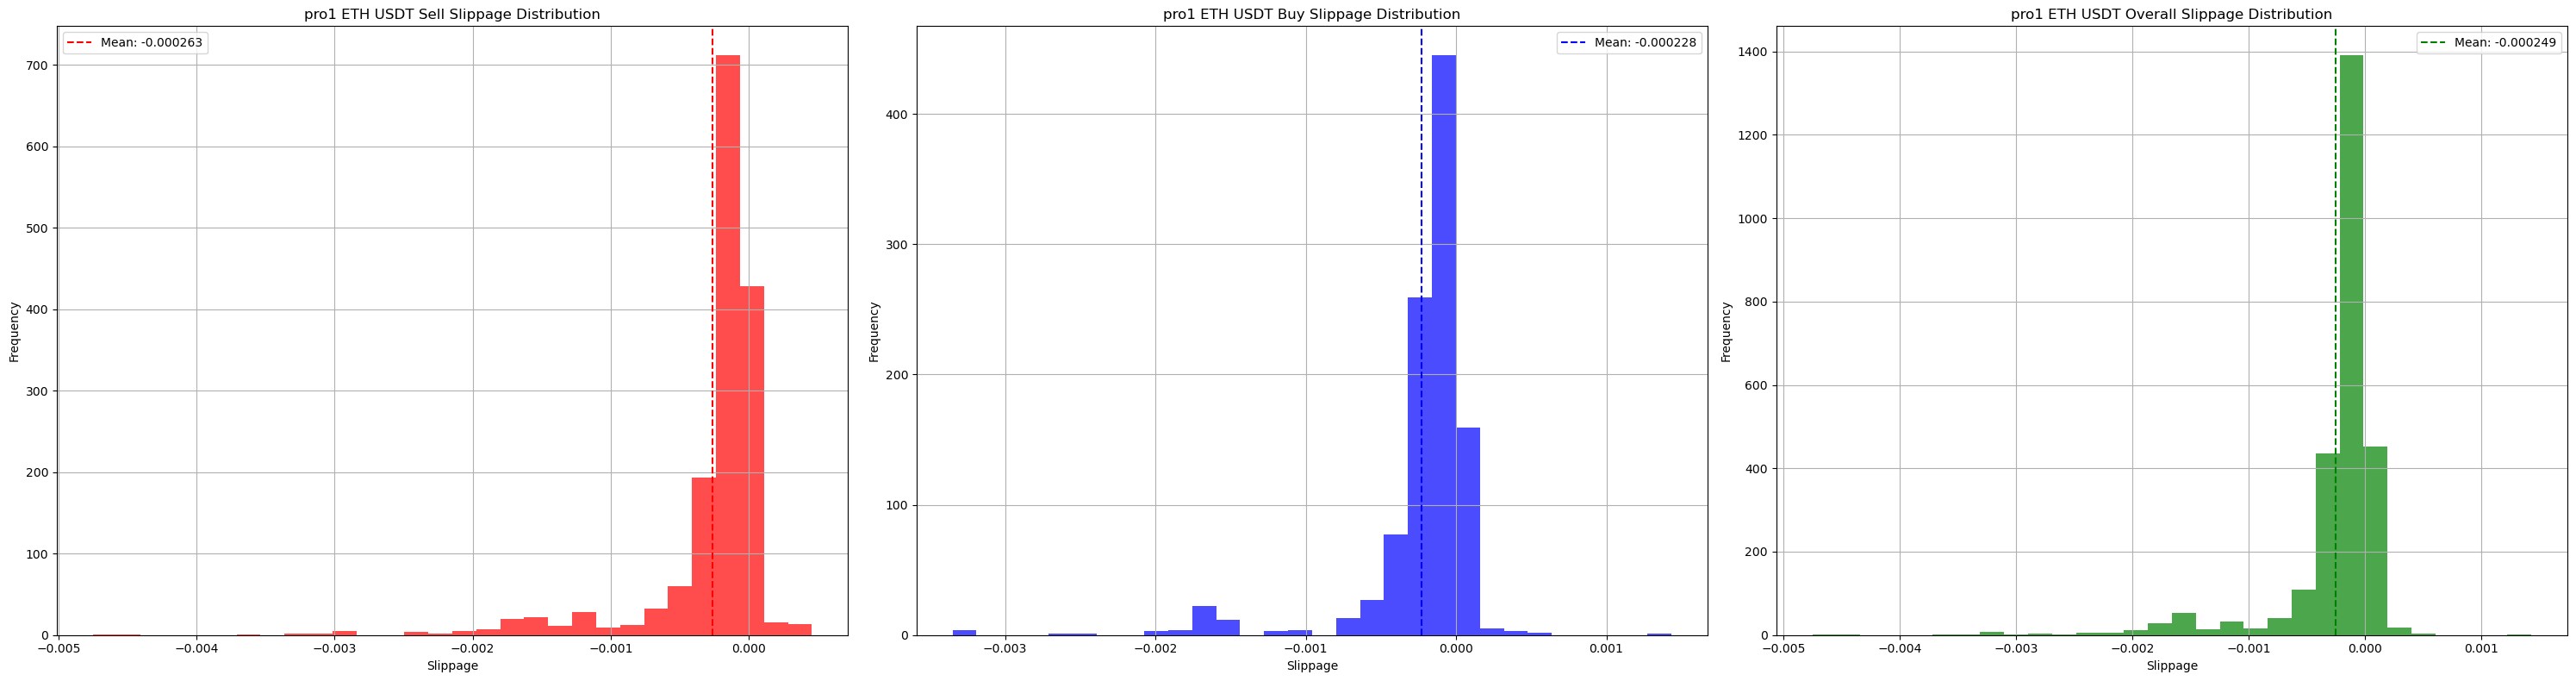

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:6: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:87: UserWarning: Boolean Ser

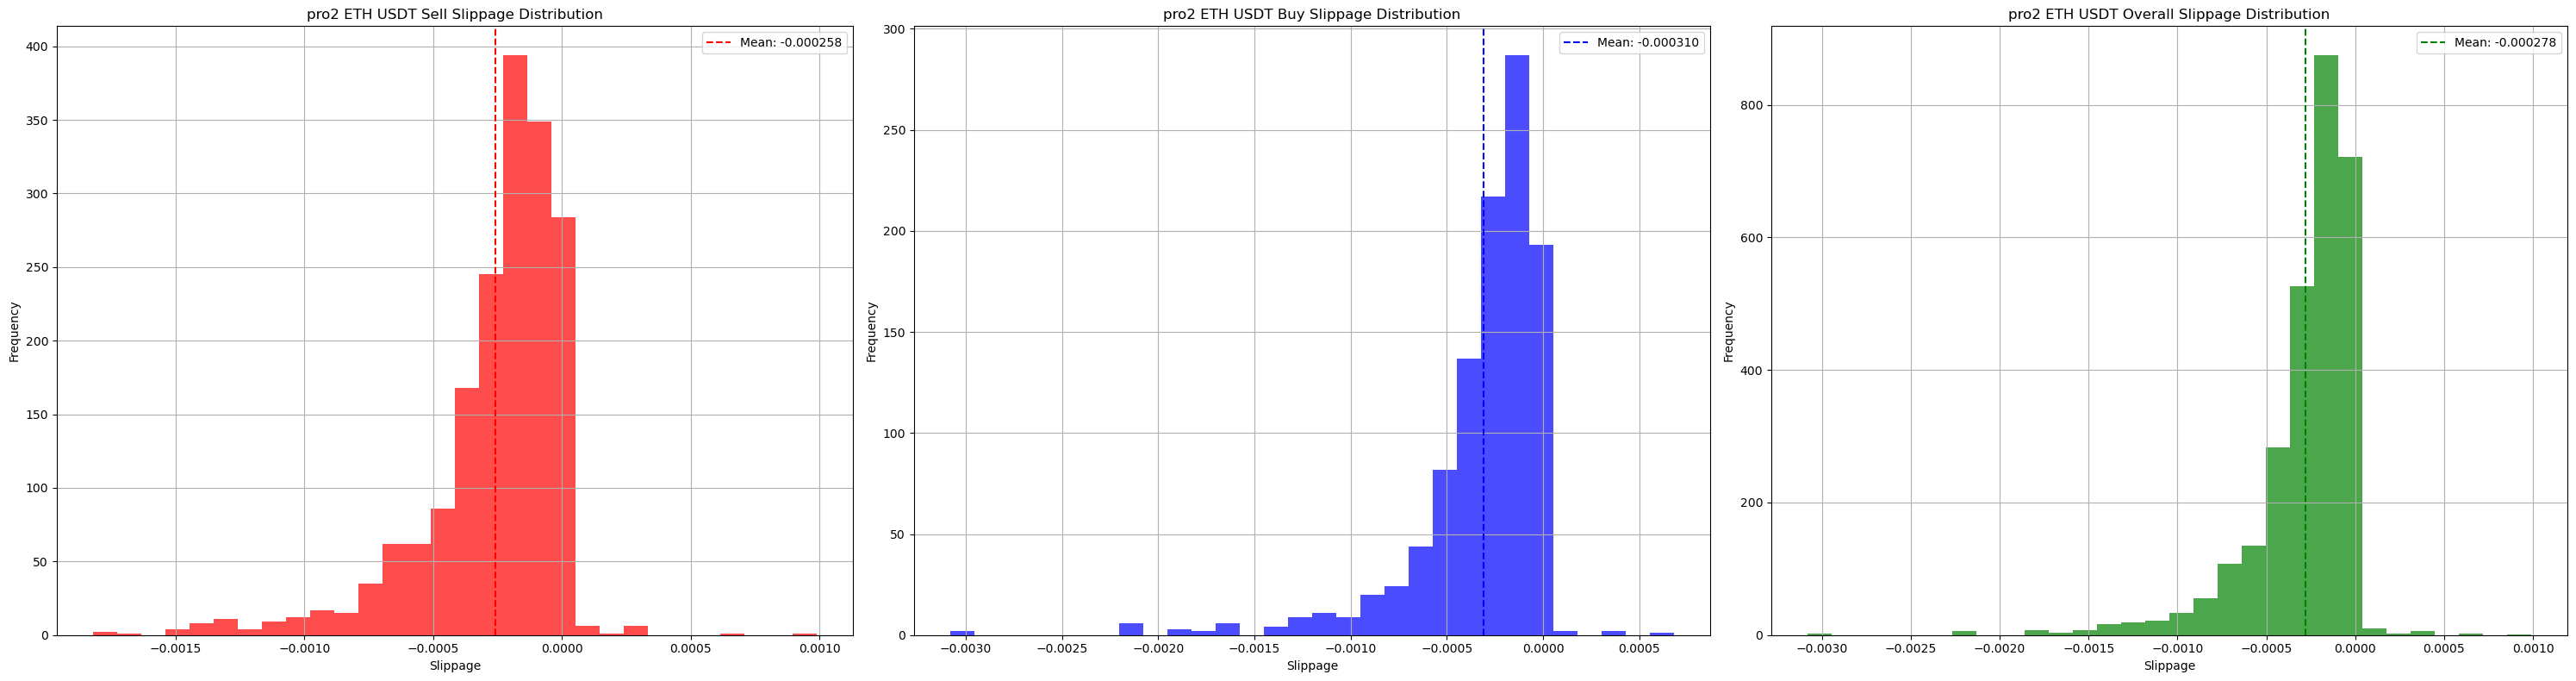

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

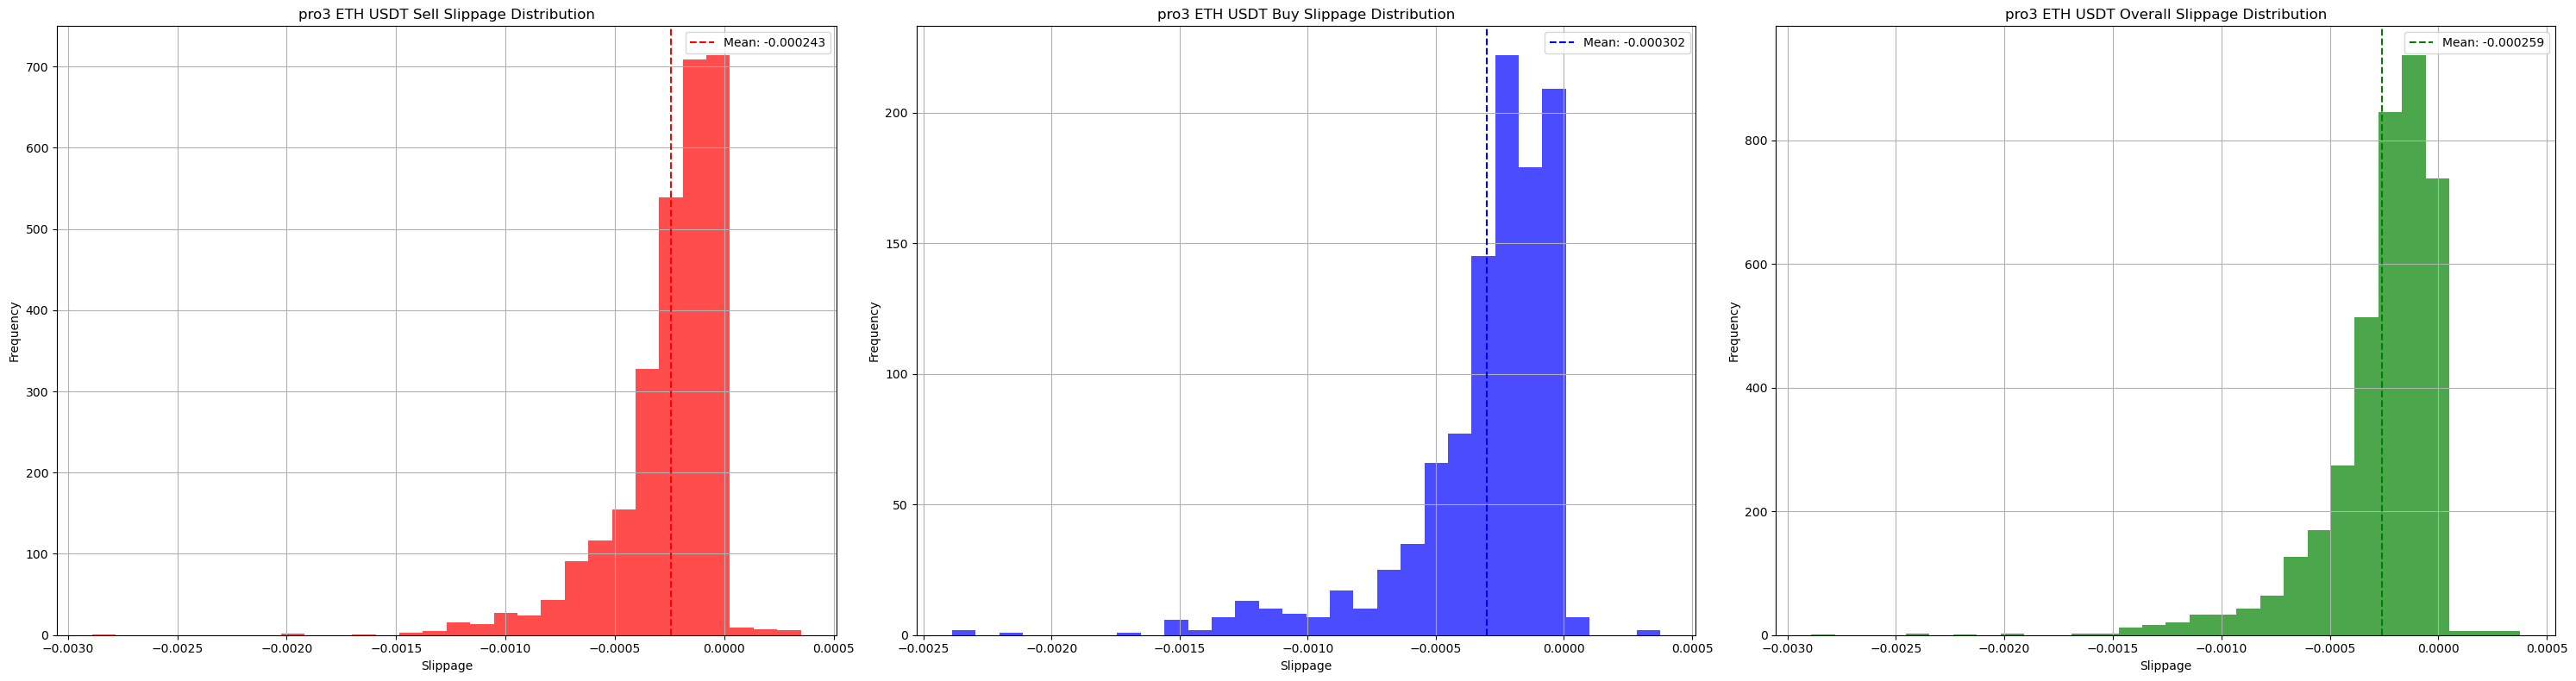

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:6: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:86:

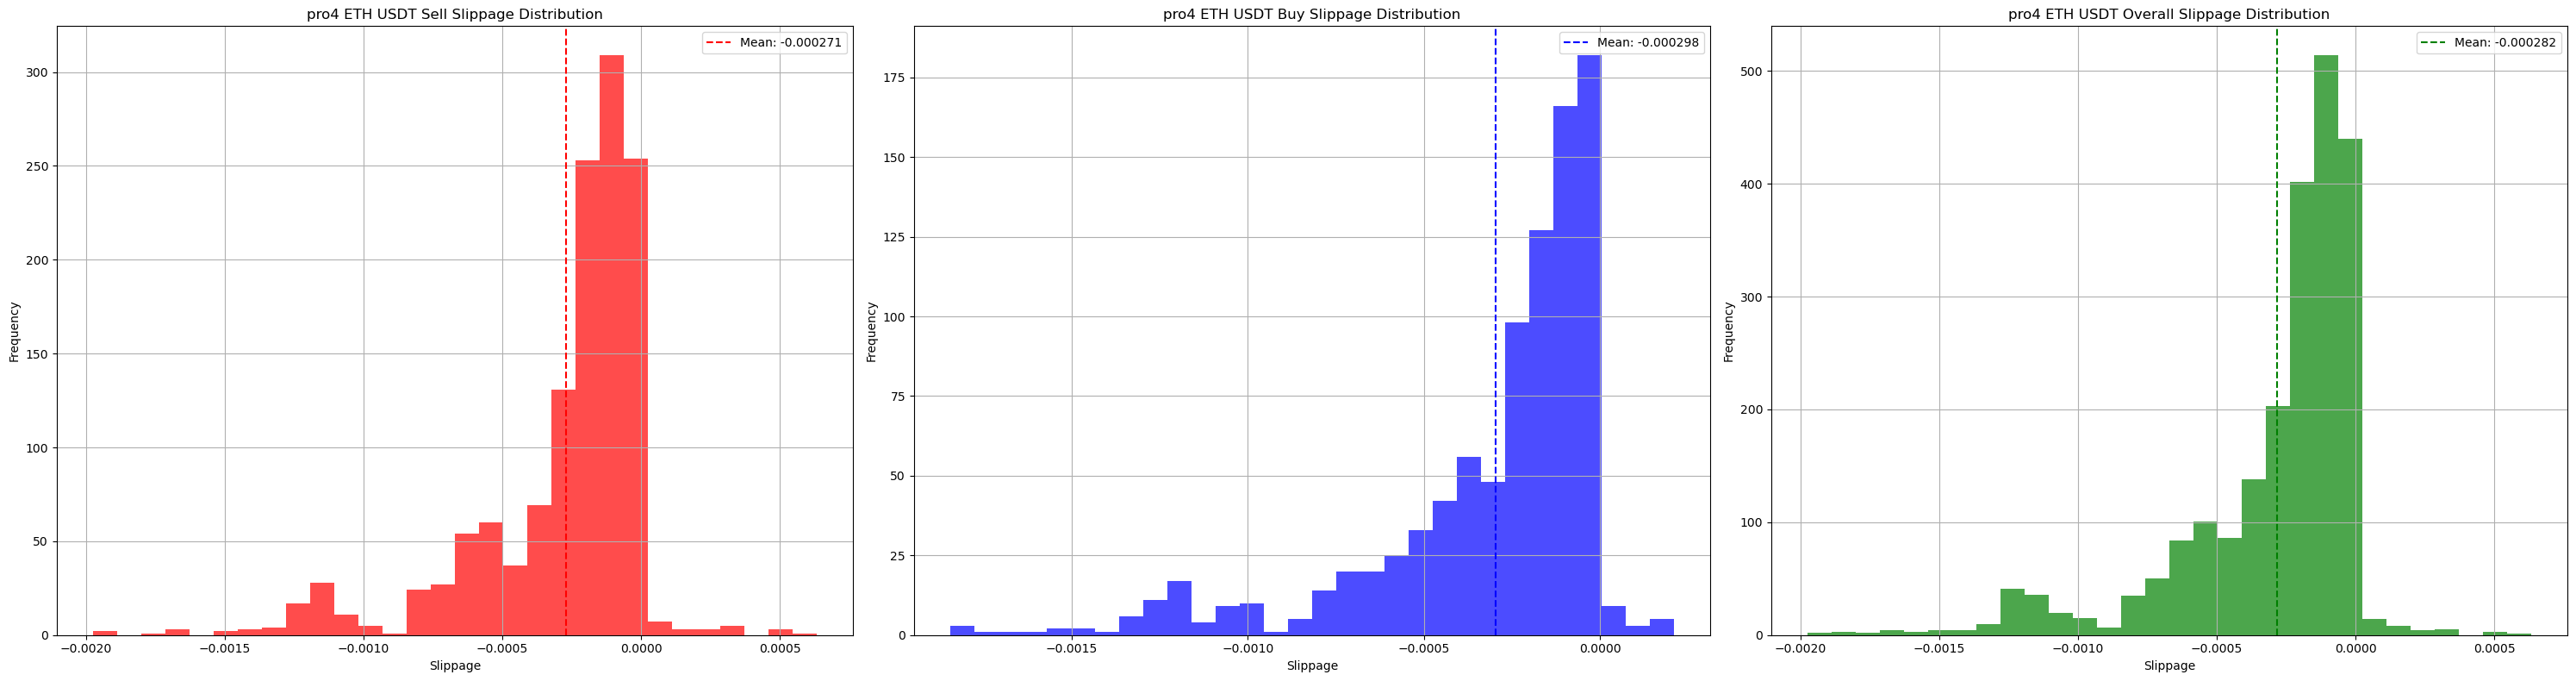

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:6: DtypeWarning: Columns (8,10,12,17,19,21,28,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/

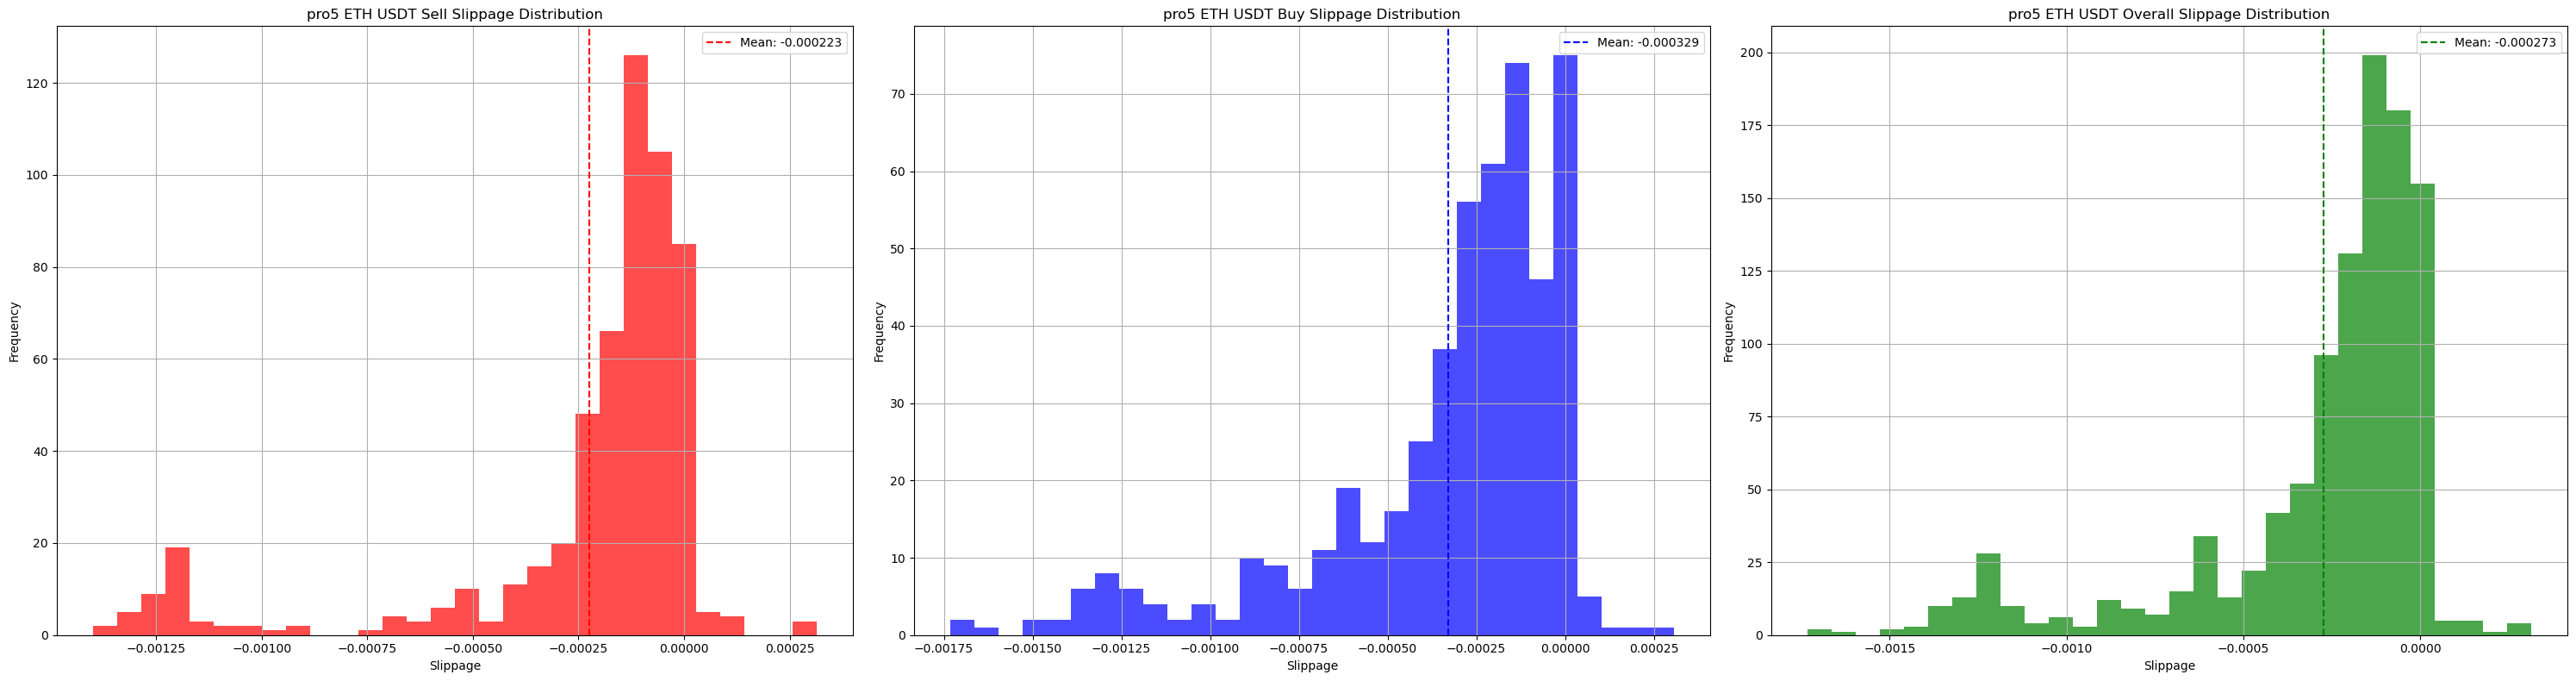

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:6: DtypeWarning: Columns (8,12,17,19,21,28,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/132

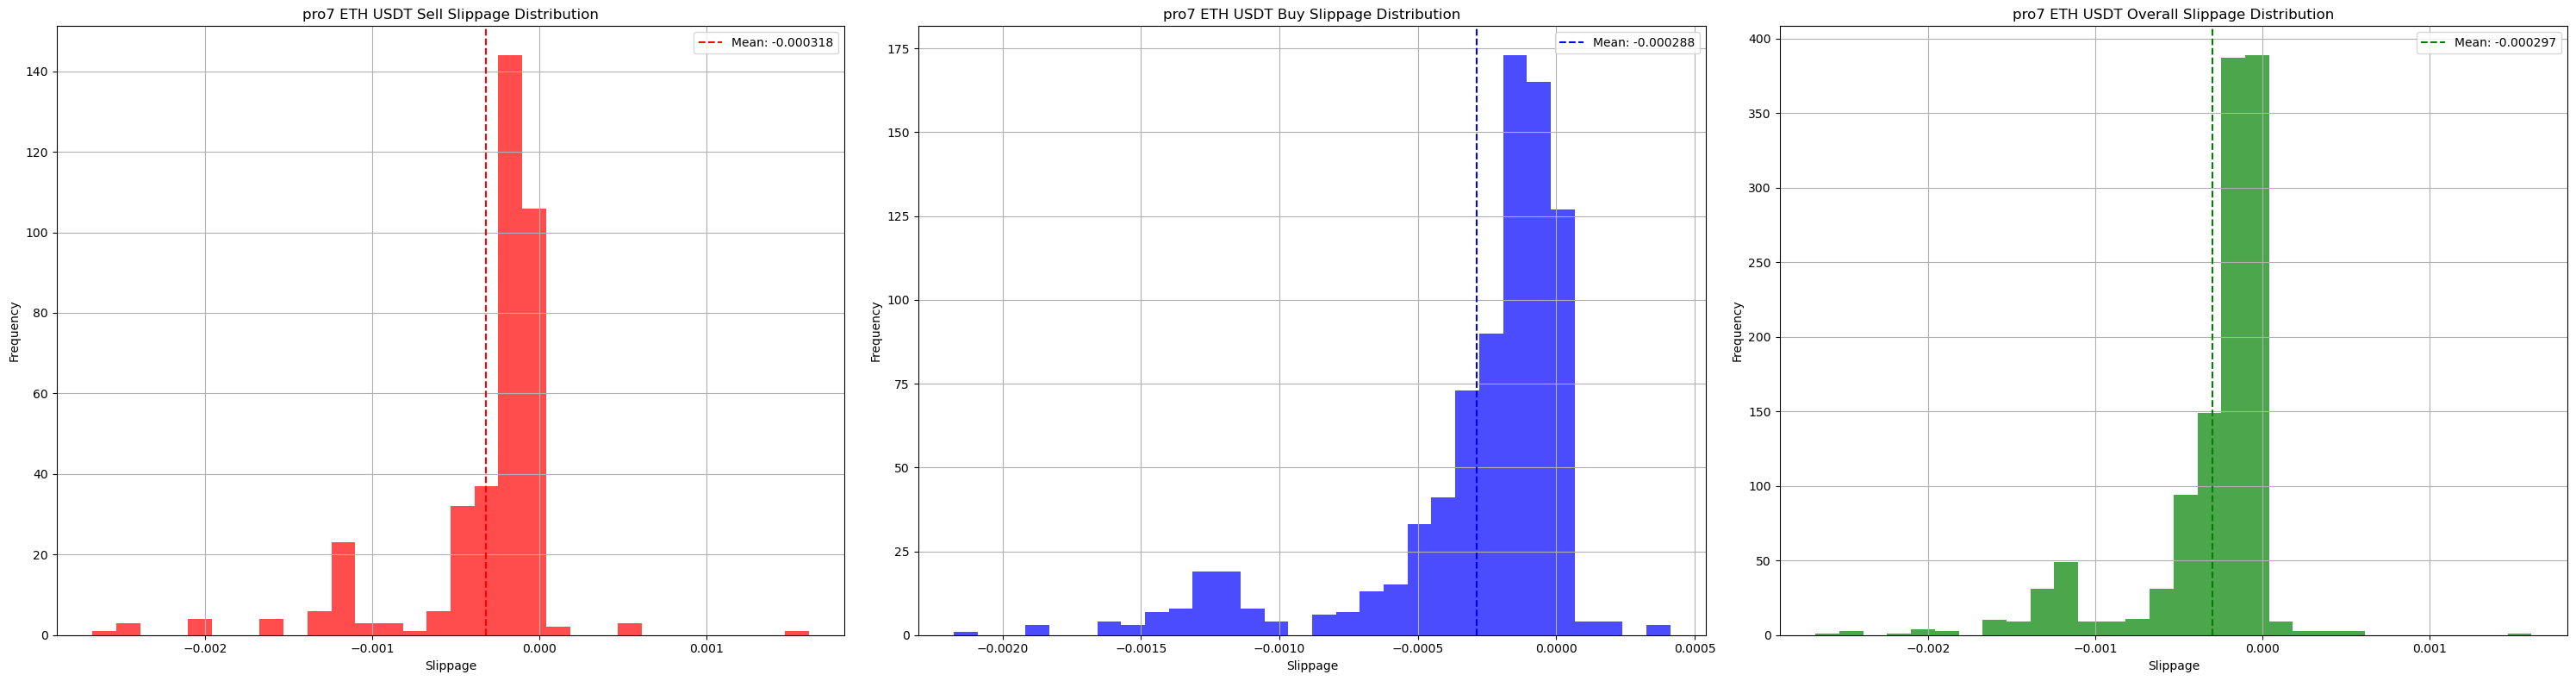

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:87: UserWarning: Boolean Ser

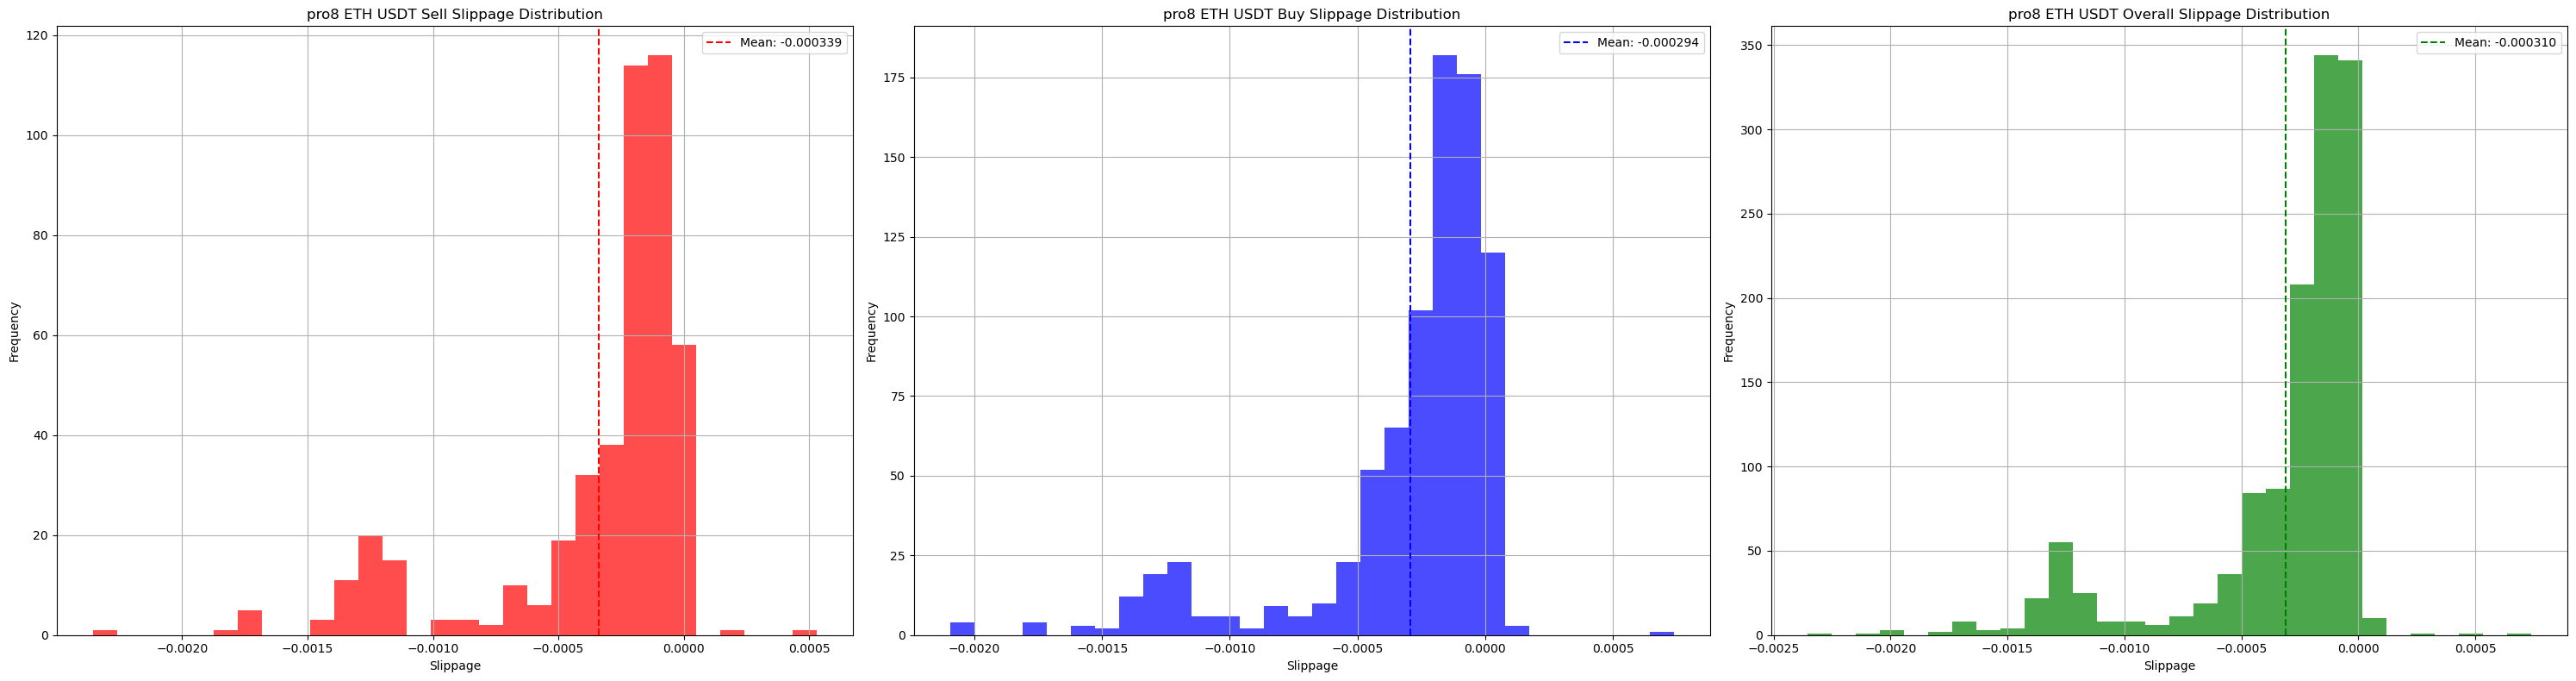

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:87: UserWarning: Boolean Ser

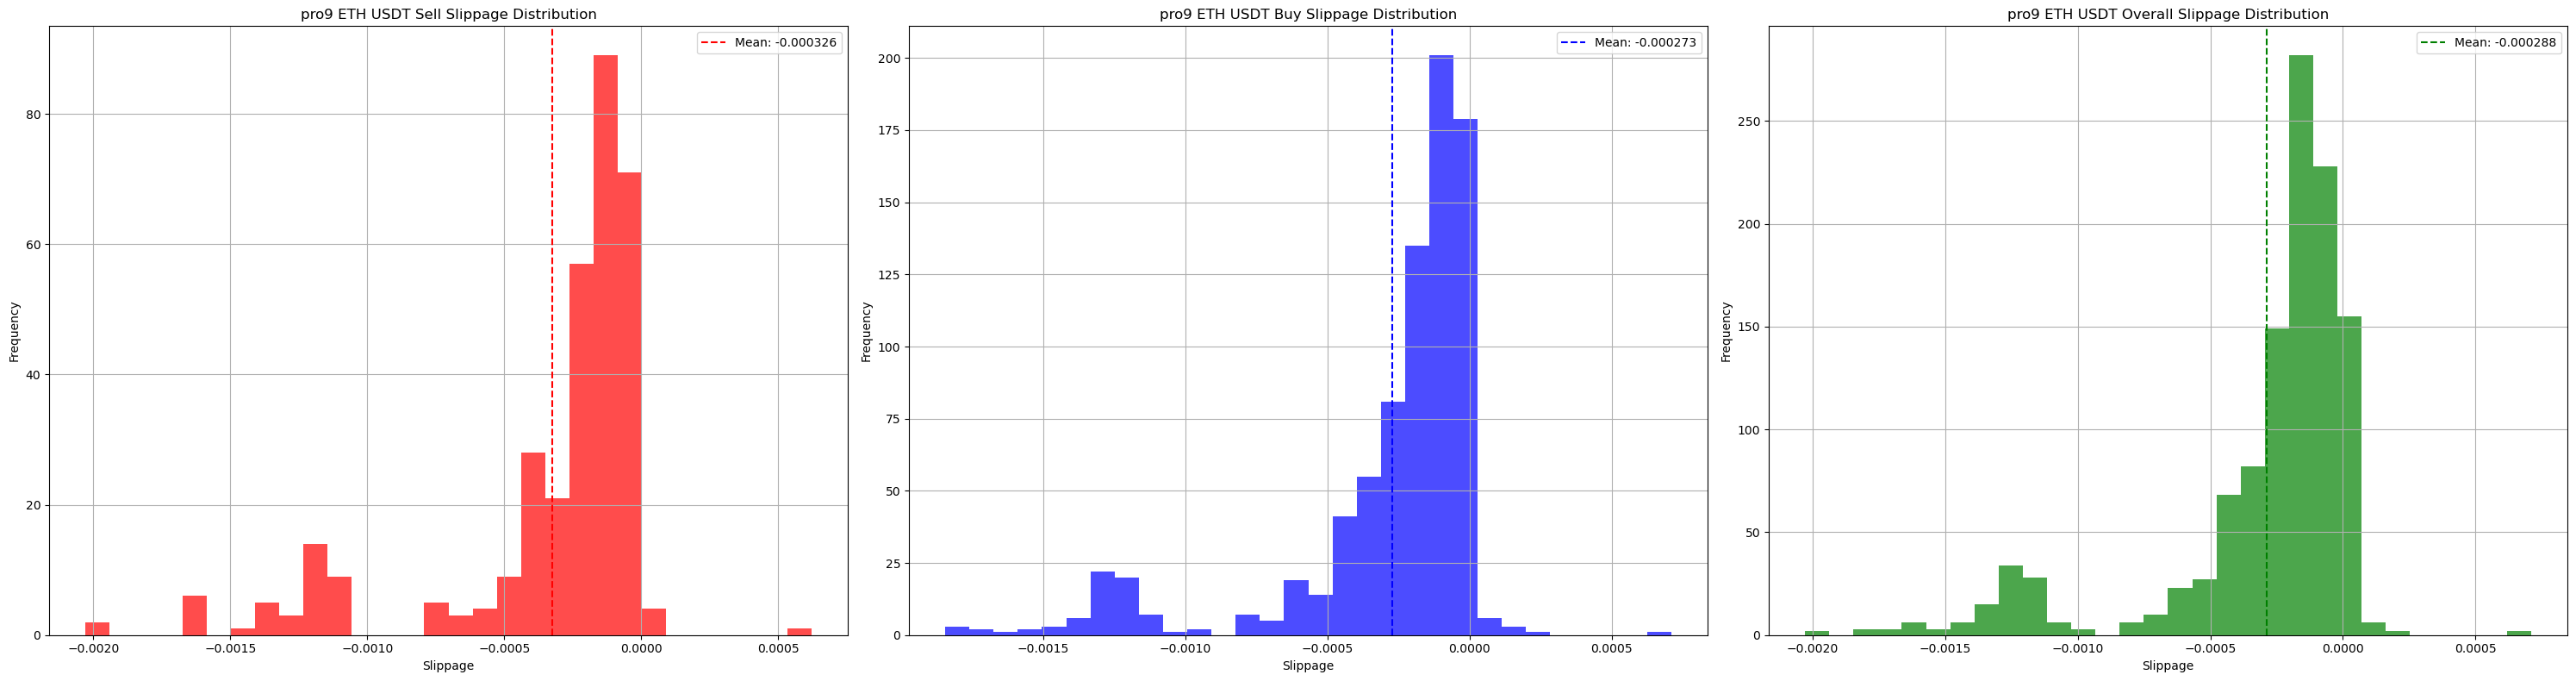

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:6: DtypeWarning: Columns (8,10,12,17,19,21,28,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/

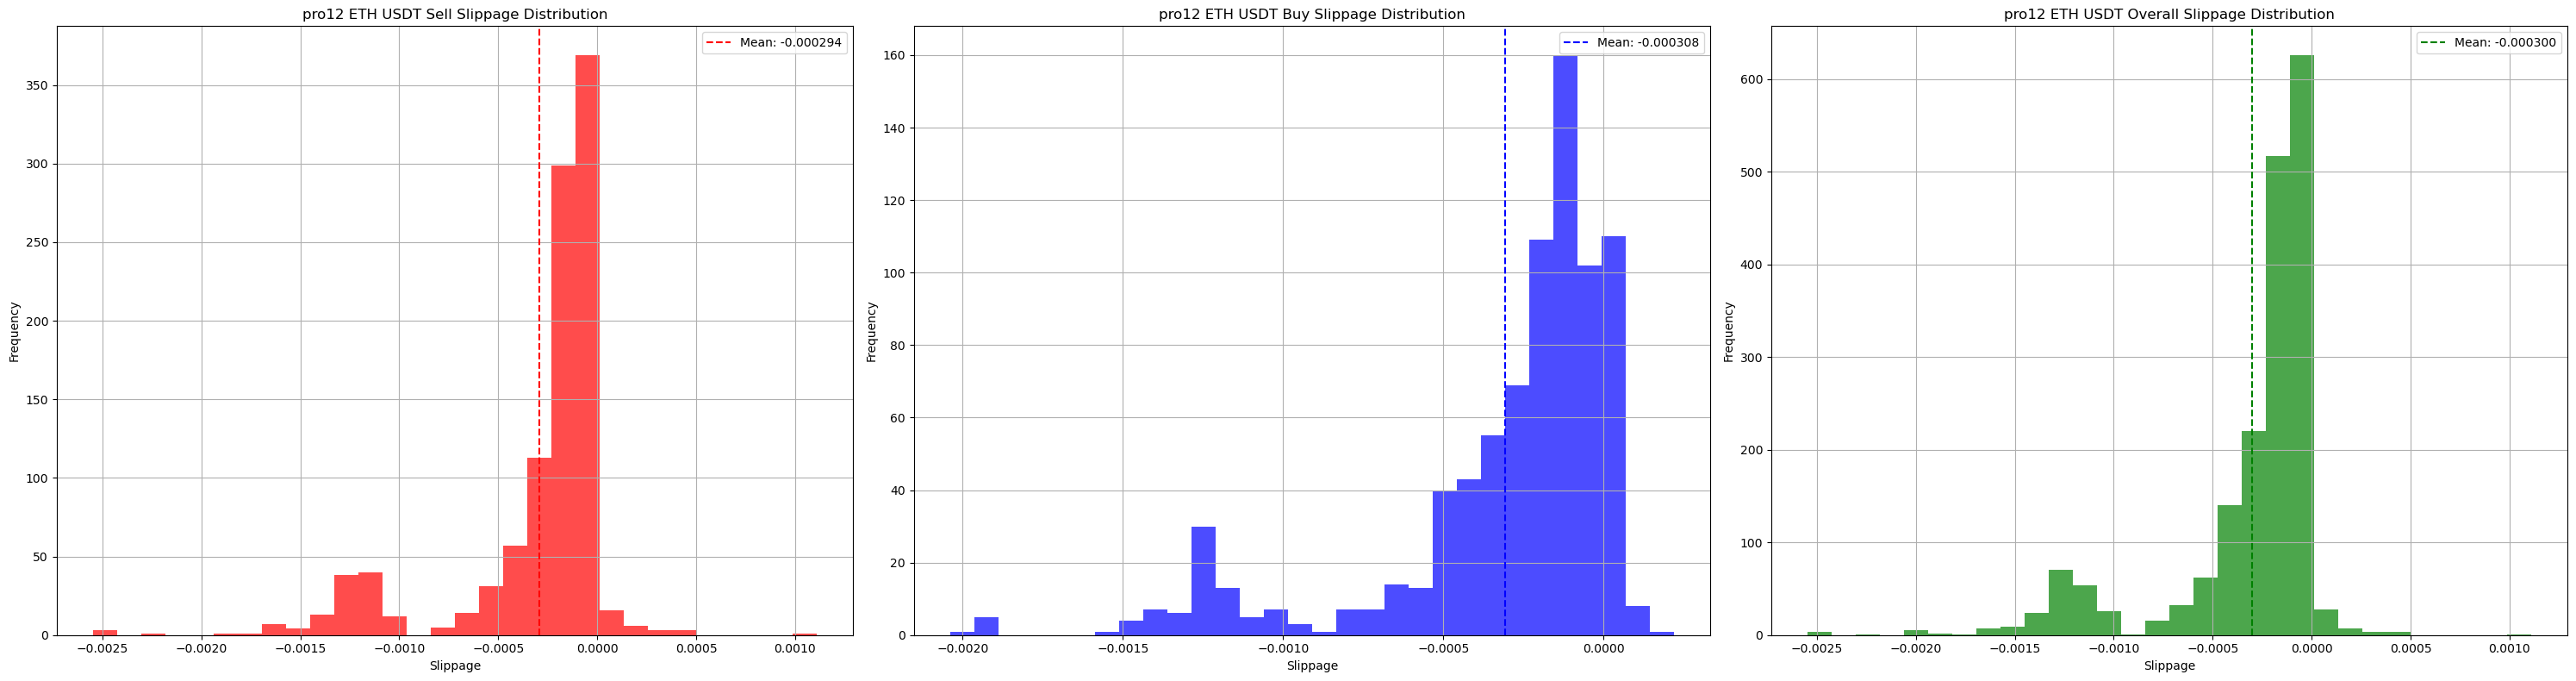

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:6: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:87: UserWarning: Boolean Ser

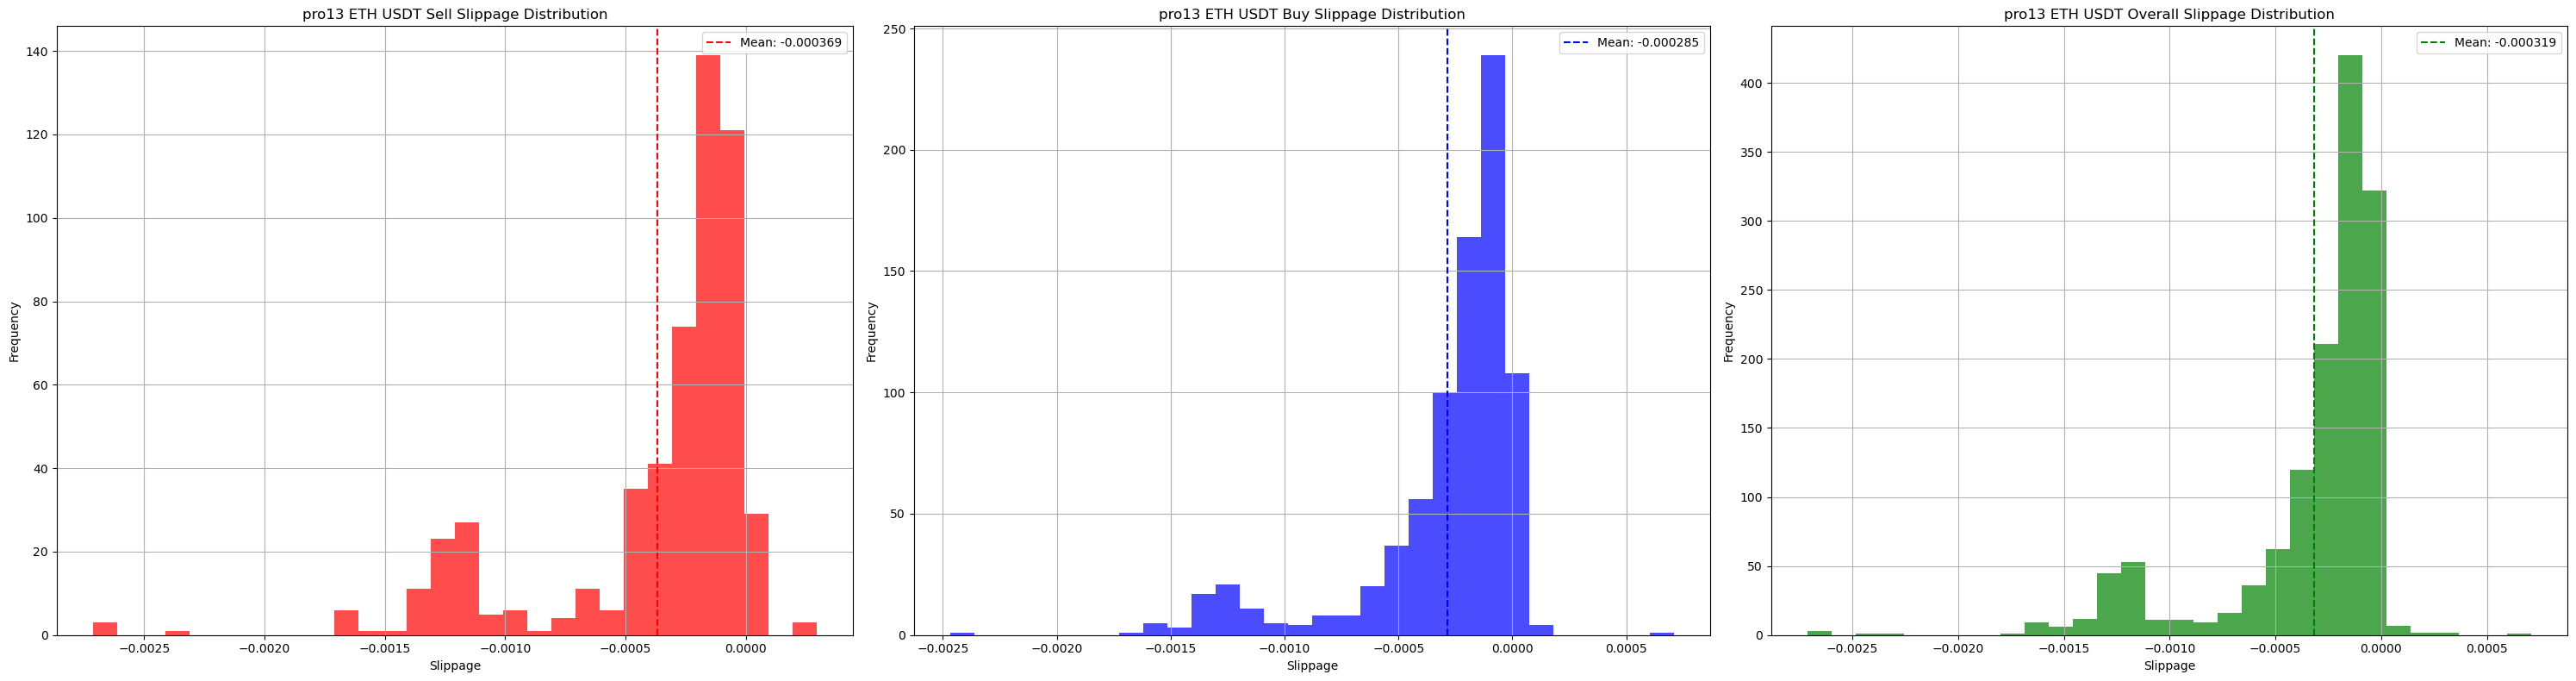

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:87: UserWarning: Boolean Ser

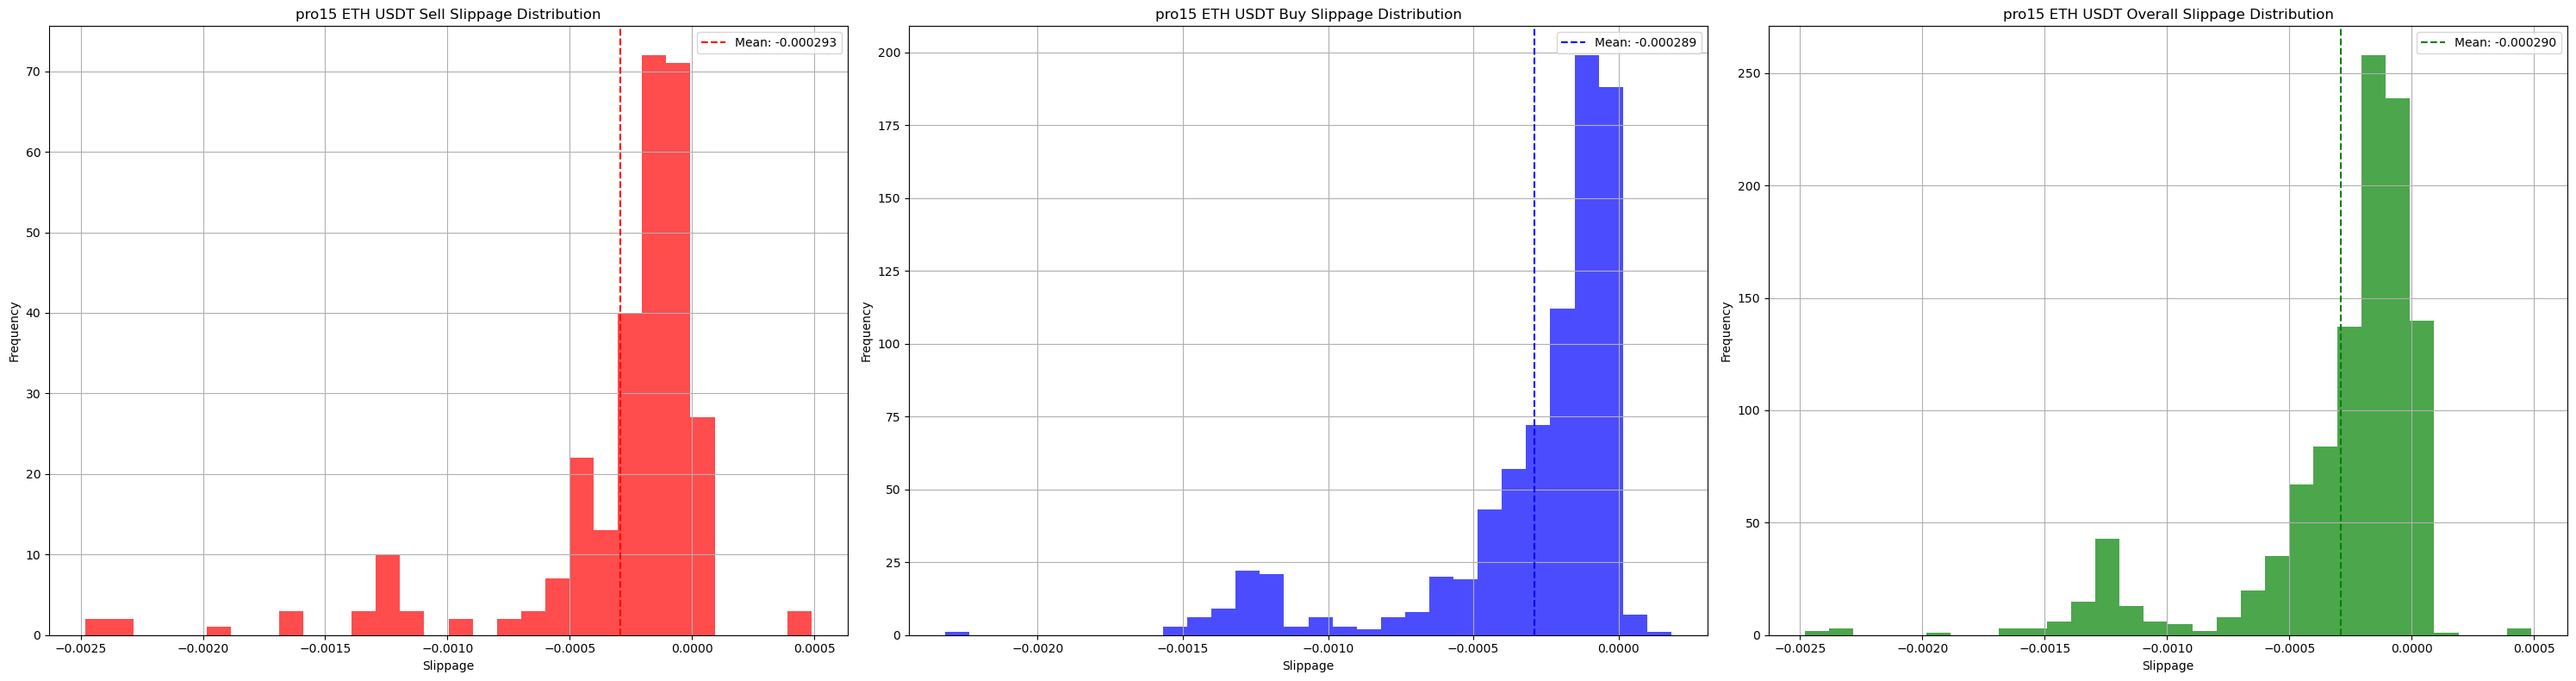

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:6: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:86:

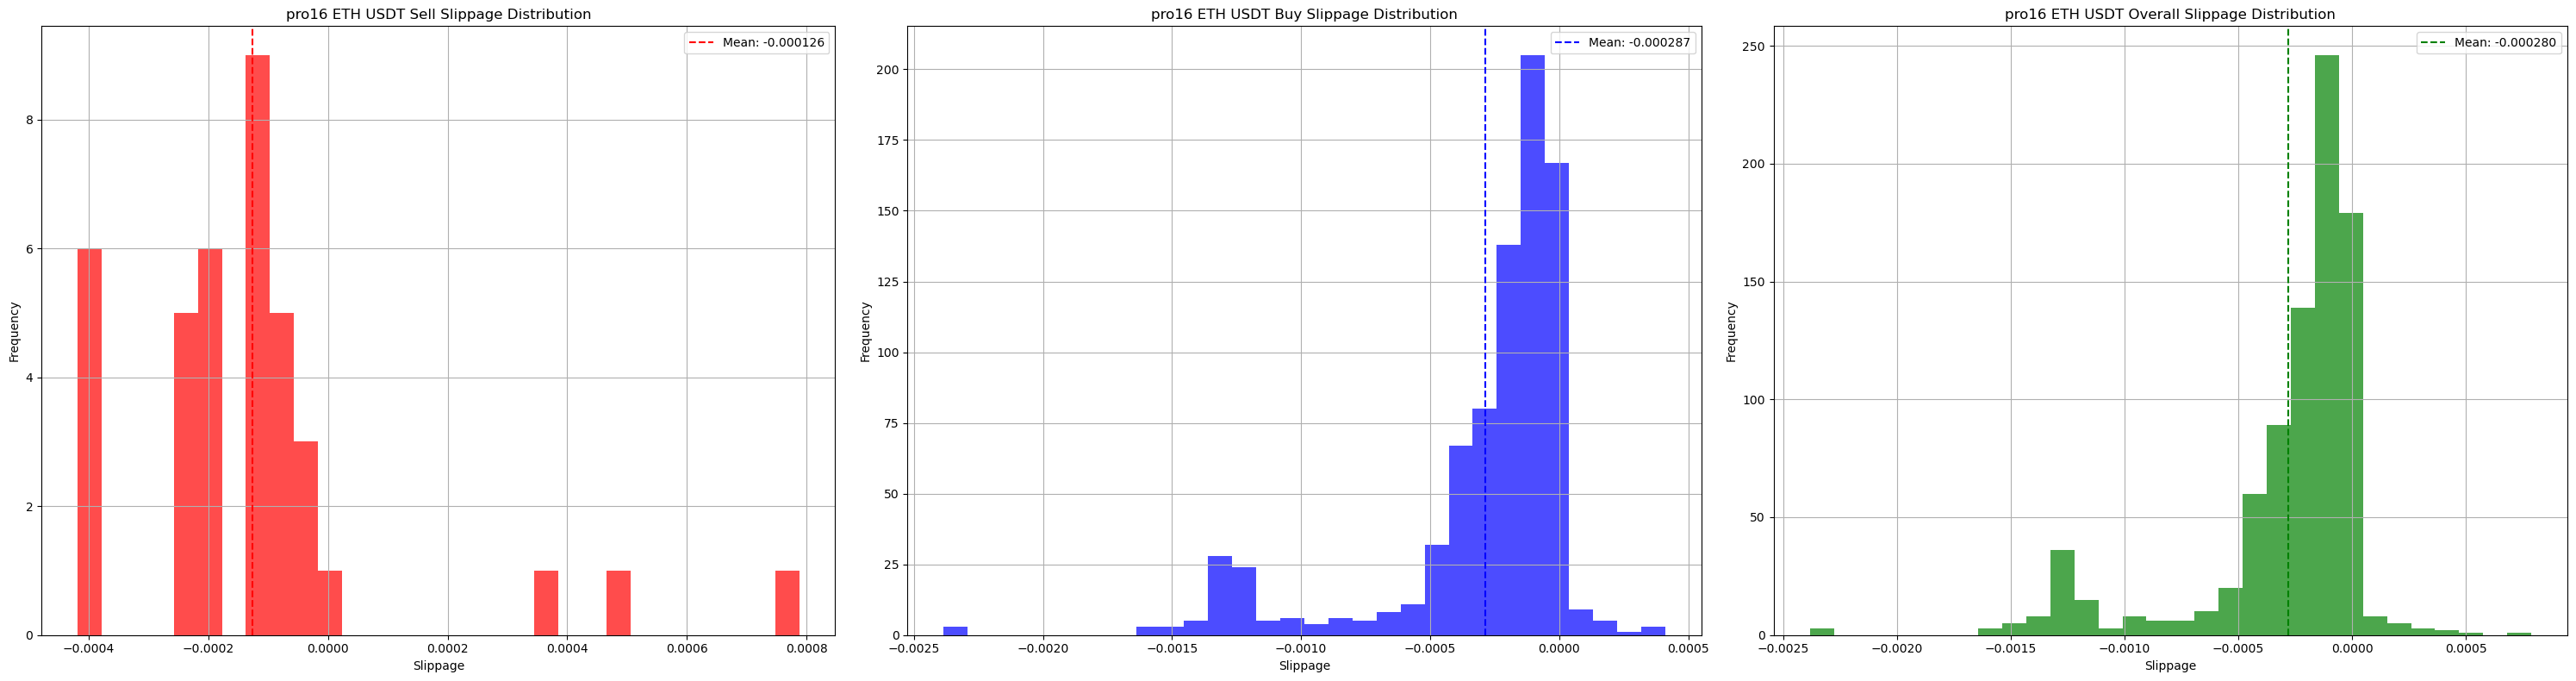

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

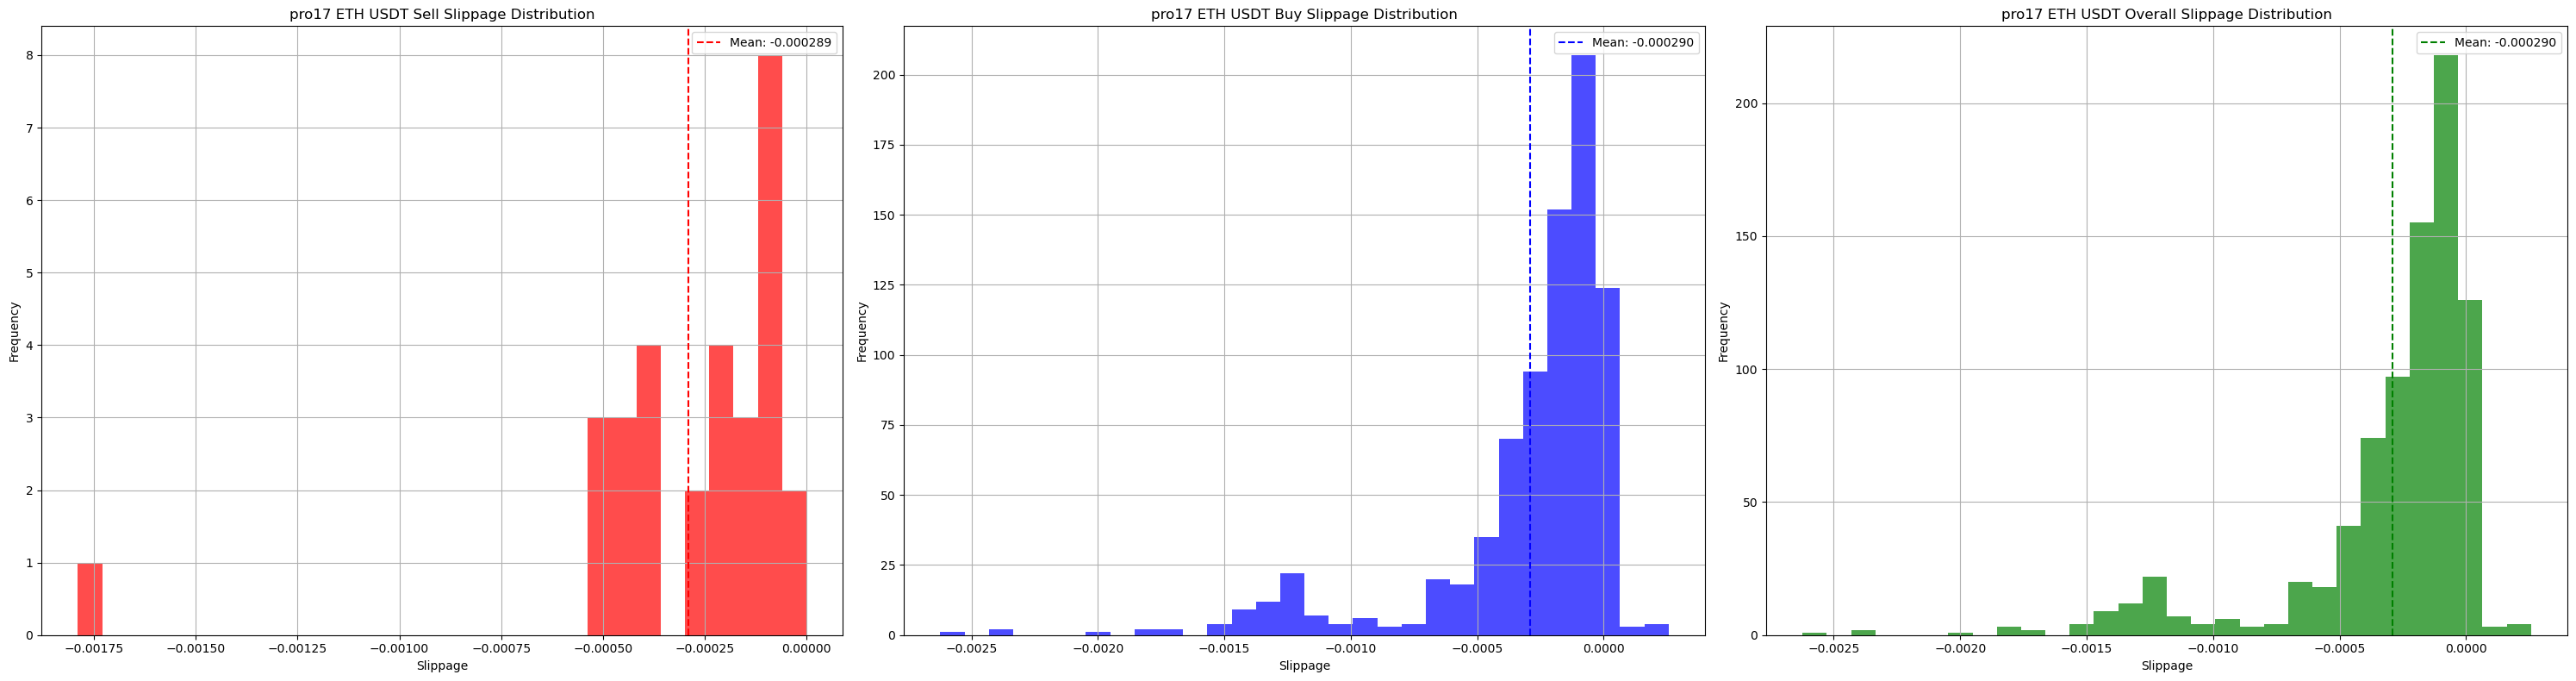

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

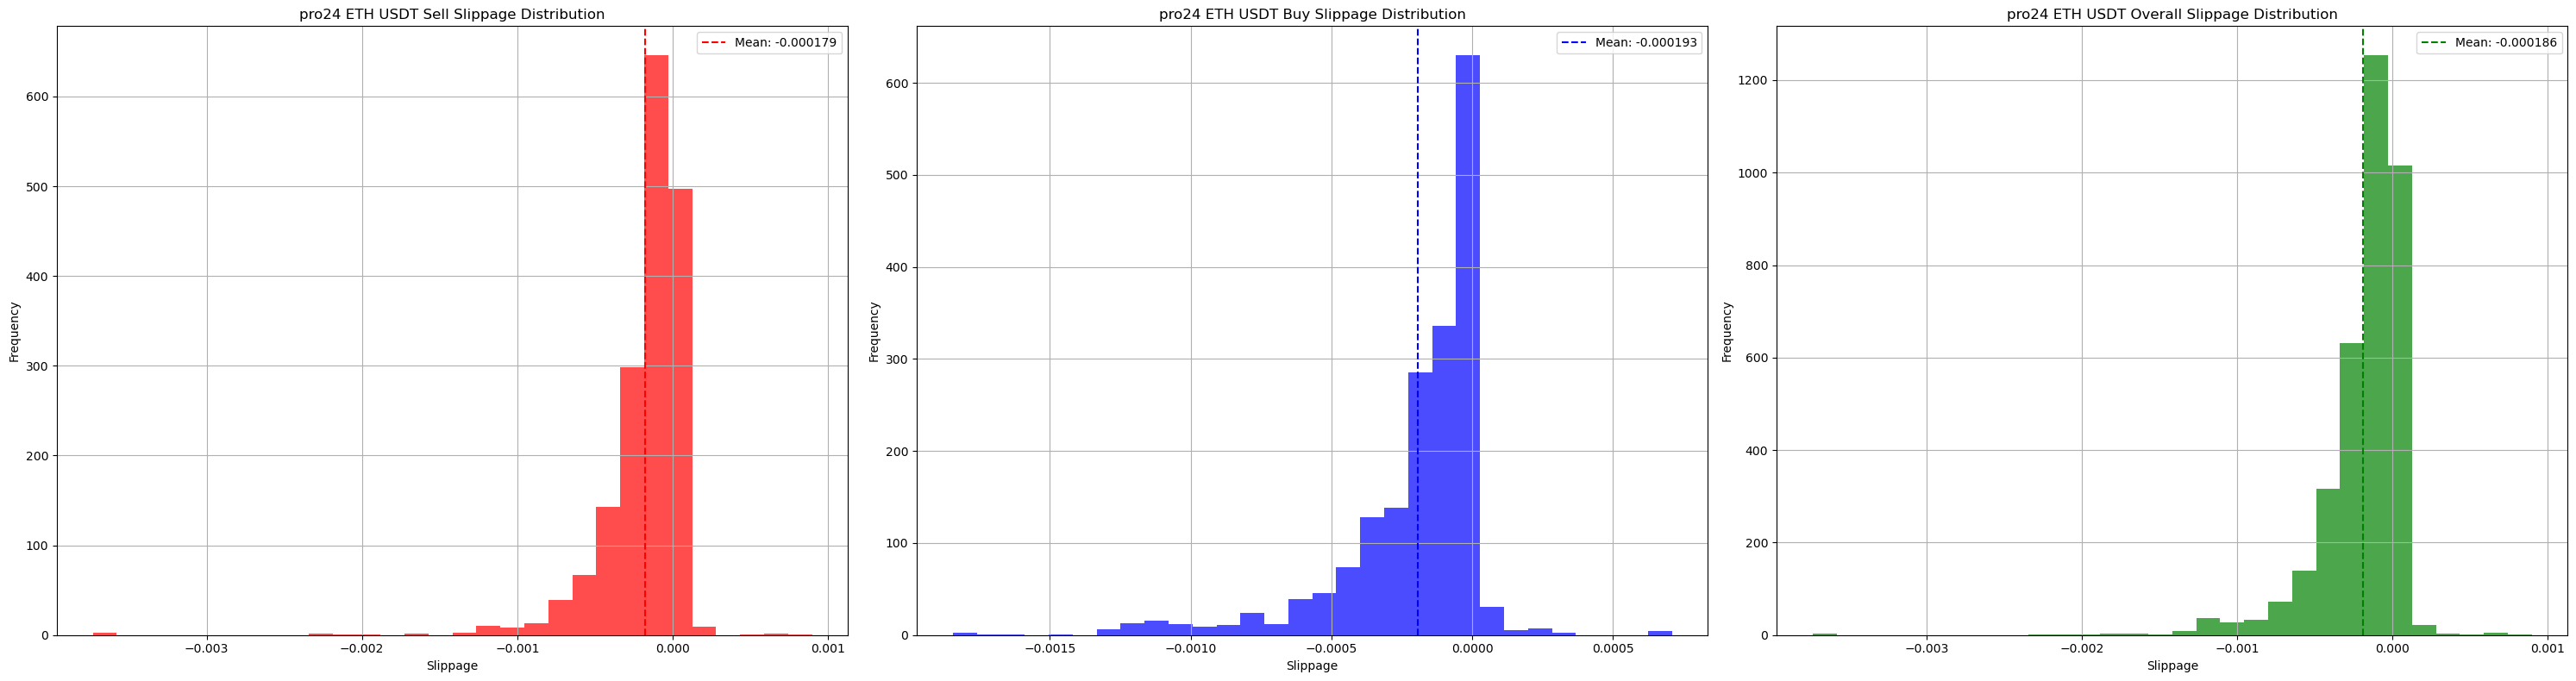

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

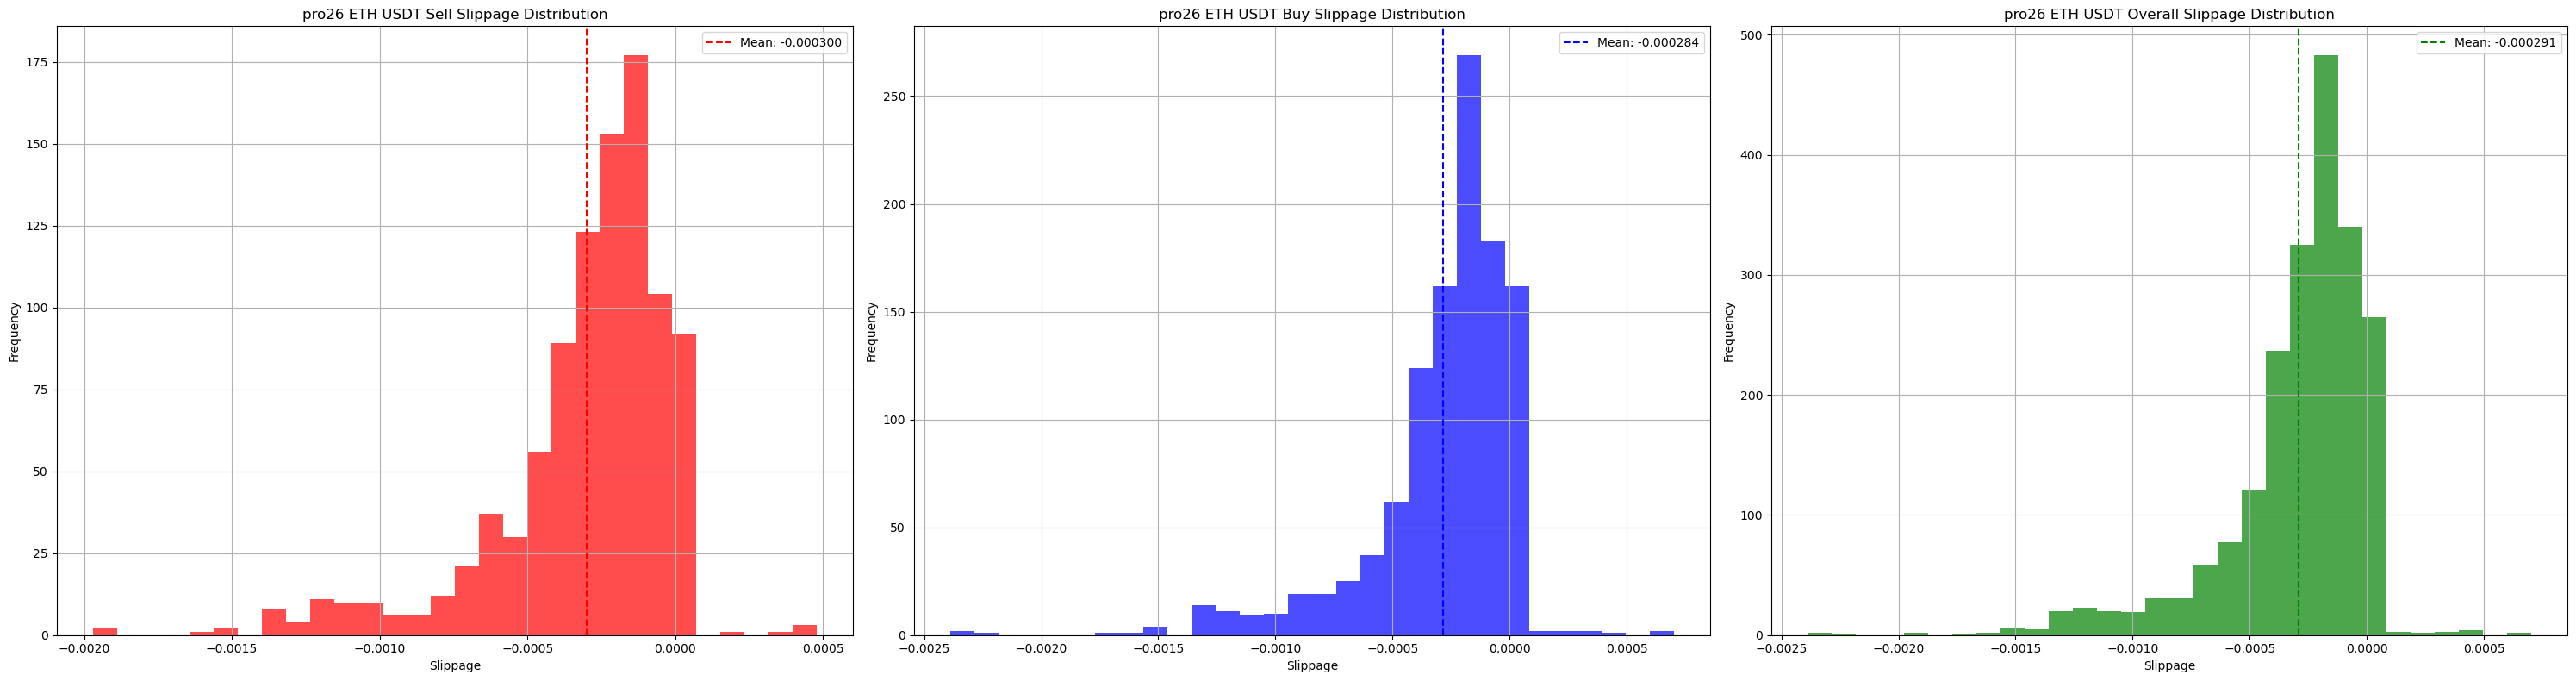

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

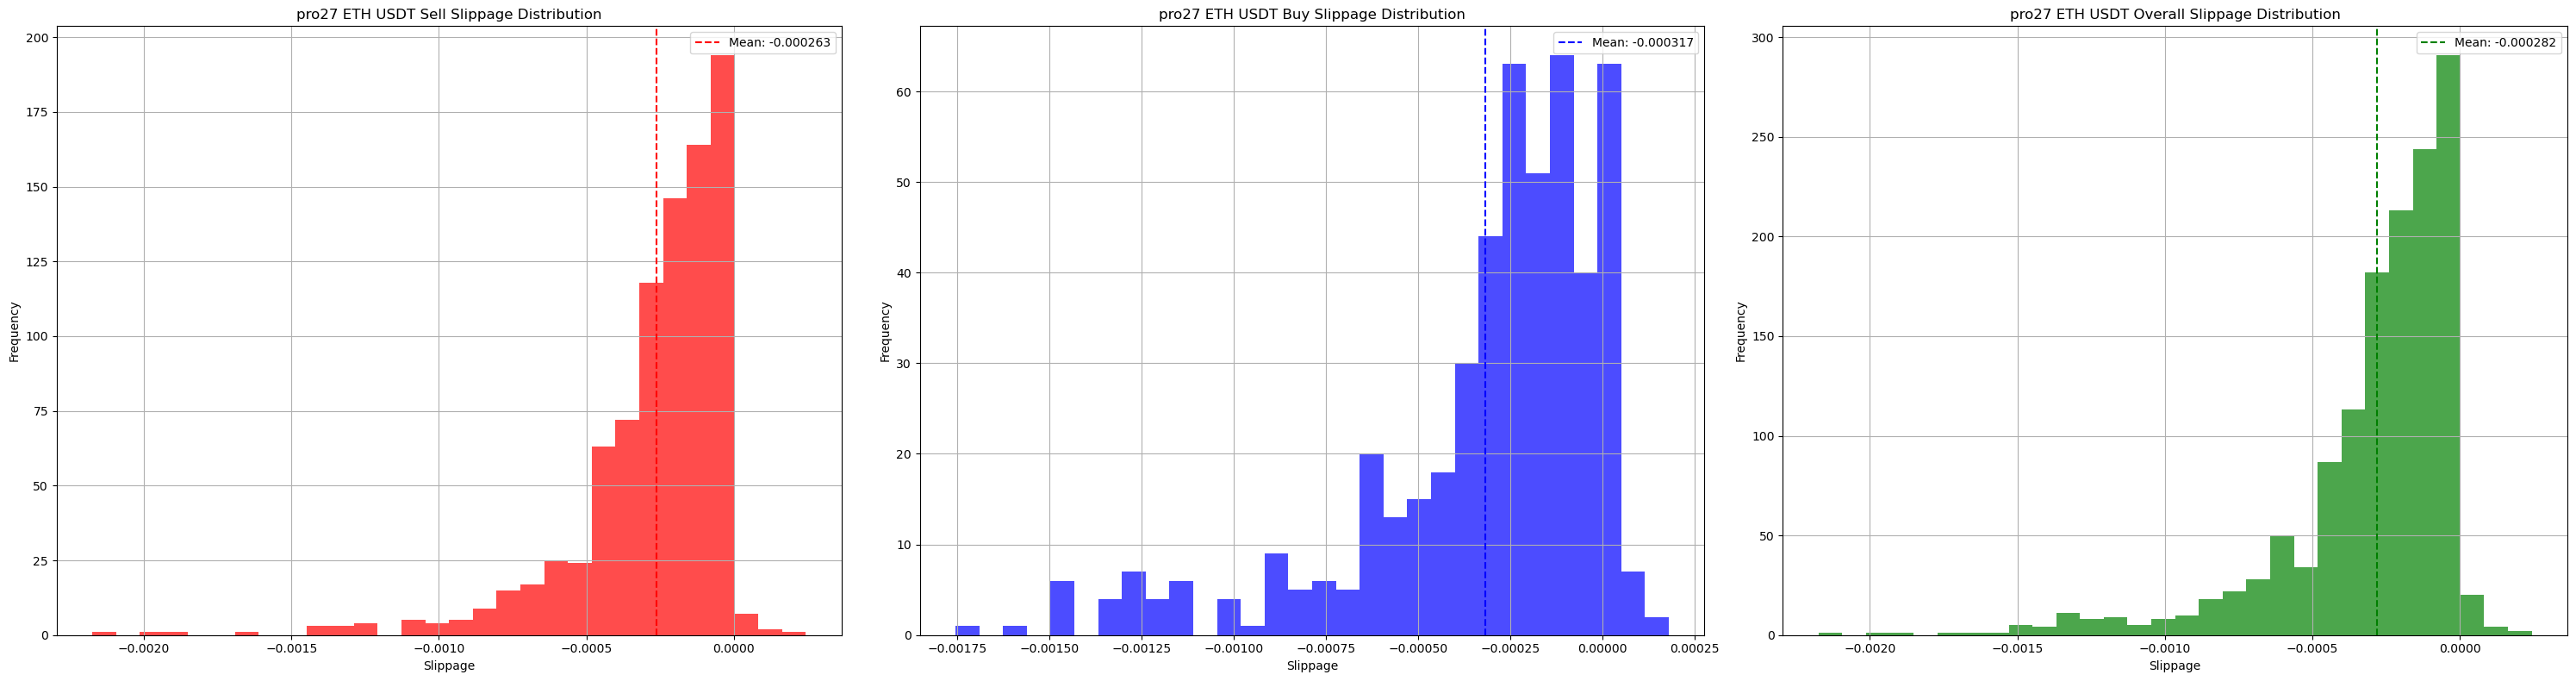

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage2 = df_close_selected[df_close['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage2 = df_close_selected[df_close['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_44260/1325737168.py:94: UserWarning: Boolean Series key will be reindexed

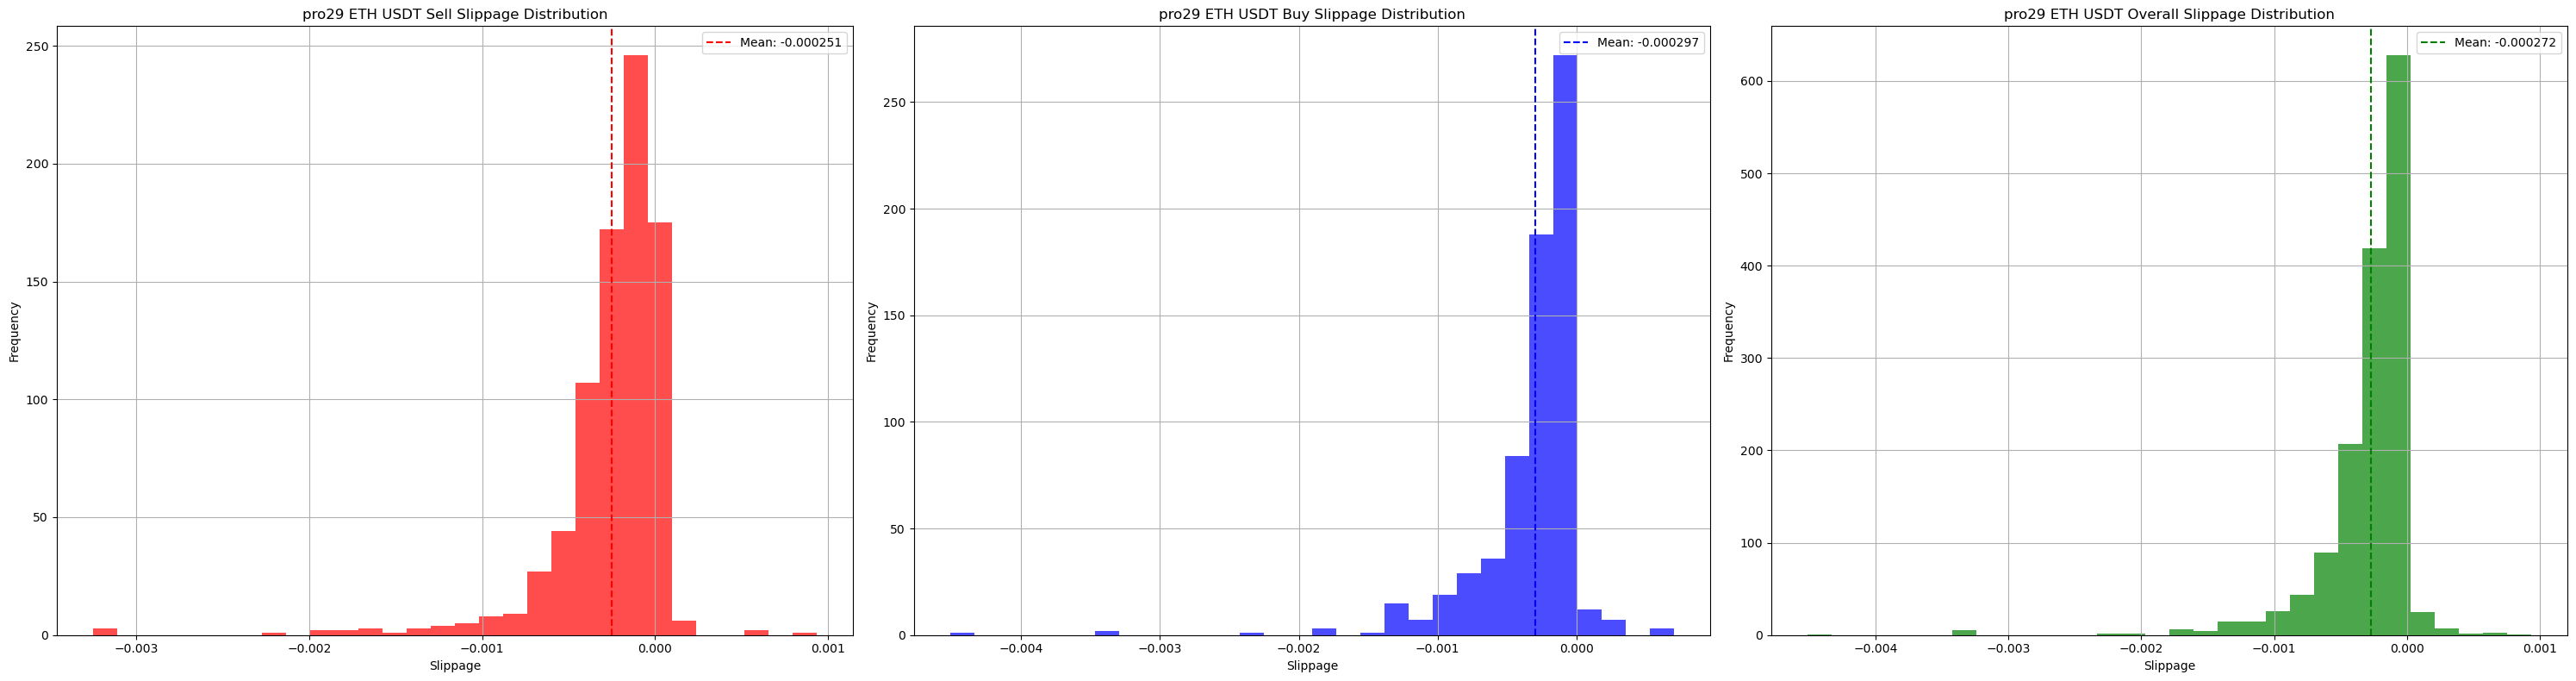

2026-02-08 08:00:00 2026-02-10 08:00:00


symbol  count      mean    median      std       min      max  \
env                                                                   
pro24    ETH   3581 -0.000186 -0.000112 0.000275 -0.003734 0.000898   
pro1     ETH   2631 -0.000249 -0.000130 0.000450 -0.004753 0.001434   
pro3     ETH   3860 -0.000259 -0.000195 0.000268 -0.002889 0.000377   
pro29    ETH   1501 -0.000272 -0.000190 0.000373 -0.004511 0.000935   
pro5     ETH   1064 -0.000273 -0.000154 0.000341 -0.001732 0.000314   
pro2     ETH   2844 -0.000278 -0.000202 0.000305 -0.003081 0.000990   
pro16    ETH    856 -0.000280 -0.000155 0.000377 -0.002385 0.000788   
pro4     ETH   2239 -0.000282 -0.000177 0.000325 -0.001975 0.000633   
pro27    ETH   1374 -0.000282 -0.000207 0.000297 -0.002174 0.000243   
pro9     ETH   1149 -0.000288 -0.000164 0.000372 -0.002029 0.000709   
pro15    ETH   1094 -0.000290 -0.000159 0.000377 -0.002480 0.000488   
pro17    ETH    836 -0.000290 -0.000167 0.000381 -0.002623 0.000257   
pro26    ETH   2083 -0.000291 -0.000213 0.000305 -0.002389 0.000701   
pro7     ETH   1209 -0.000297 -0.000160 0.000405 -0.002675 0.001612   
pro12    ETH   1858 -0.000300 -0.000164 0.000392 -0.002547 0.001109   
pro8     ETH   1289 -0.000310 -0.000171 0.000393 -0.002355 0.000739   
pro13    ETH   1361 -0.000319 -0.000178 0.000396 -0.002713 0.000709   

       percentile_5  percentile_10  percentile_25  percentile_50  \
env                                                                
pro24     -0.000672      -0.000473      -0.000250      -0.000112   
pro1      -0.001267      -0.000533      -0.000243      -0.000130   
pro3      -0.000775      -0.000588      -0.000347      -0.000195   
pro29     -0.000890      -0.000640      -0.000356      -0.000190   
pro5      -0.001196      -0.000731      -0.000334      -0.000154   
pro2      -0.000834      -0.000636      -0.000365      -0.000202   
pro16     -0.001254      -0.000820      -0.000336      -0.000155   
pro4      -0.001091      -0.000678      -0.000369      -0.000177   
pro27     -0.000879      -0.000639      -0.000383      -0.000207   
pro9      -0.001243      -0.000754      -0.000329      -0.000164   
pro15     -0.001241      -0.000714      -0.000348      -0.000159   
pro17     -0.001269      -0.000696      -0.000348      -0.000167   
pro26     -0.000930      -0.000653      -0.000381      -0.000213   
pro7      -0.001249      -0.000878      -0.000343      -0.000160   
pro12     -0.001249      -0.001041      -0.000348      -0.000164   
pro8      -0.001258      -0.001056      -0.000367      -0.000171   
pro13     -0.001259      -0.001046      -0.000360      -0.000178   

       percentile_60  percentile_75  percentile_95  BNFirstSlippage  \
env                                                                   
pro24      -0.000070      -0.000005       0.000000        -0.000261   
pro1       -0.000096      -0.000052       0.000000        -0.000245   
pro3       -0.000149      -0.000082       0.000000        -0.000260   
pro29      -0.000138      -0.000057       0.000000        -0.000268   
pro5       -0.000116      -0.000066       0.000000        -0.000279   
pro2       -0.000163      -0.000093       0.000000        -0.000275   
pro16      -0.000117      -0.000070       0.000000        -0.000312   
pro4       -0.000135      -0.000080       0.000000        -0.000284   
pro27      -0.000155      -0.000094       0.000000        -0.000263   
pro9       -0.000127      -0.000079       0.000000        -0.000281   
pro15      -0.000122      -0.000071       0.000000        -0.000294   
pro17      -0.000122      -0.000075       0.000000        -0.000301   
pro26      -0.000170      -0.000103       0.000000        -0.000300   
pro7       -0.000125      -0.000075       0.000000        -0.000293   
pro12      -0.000125      -0.000075       0.000000        -0.000307   
pro8       -0.000132      -0.000079       0.000000        -0.000302   
pro13      -0.000136      -0.000089      -0.000000        -0.000311   

       BNFirs

In [3]:
import pandas as pd


symbol = 'ETH'
env_list = ["cfdc_dcpro1","cfdc_dcpro2","cfdc_dcpro3","cfdc_dcpro4","cfdc_dcpro5","cfdc_dcpro7", "cfdc_dcpro8","cfdc_dcpro9","cfdc_dcpro12","cfdc_dcpro13","cfdc_dcpro15","cfdc_dcpro16","cfdc_dcpro17","cfdc_dcpro24","cfdc_dcpro26","cfdc_dcpro27","cfdc_dcpro29"]
env_list = ['pro1','pro2','pro3','pro4','pro5','pro7','pro8','pro9','pro12','pro13','pro15','pro16','pro17','pro24','pro26','pro27','pro29']

replace_dict = {
'pro1': 'preTakerMaker',
'pro2': 'msecs10000 replace10 abnormal 0.0001',
'pro10': 'msecs10000 replace10 abnormal 0.0005',
'pro11': 'msecs10000 replace10 abnormal 0.0002', 
'pro12': 'msecs10000 replace1 abnormal 0.0005',
'pro3':'MakerTaker',
'pro4':'MakerTaker'
}

start_date = '2026-02-08 08:00:00'
end_date = '2026-02-10 08:00:00'

summary = []

for env in env_list:
    try:
        file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.close.csv'
        file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.open.csv'
        if env == 'pmpro':
            file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.close.csv'
            file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.open.csv'
        slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


        # 创建子图  
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

        # 分析卖出滑点
        sell_slippage = short_slippage['slippage']
        sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
        ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
        ax1.set_xlabel('Slippage')
        ax1.set_ylabel('Frequency')
        sell_mean = sell_slippage.mean()
        sell_std = sell_slippage.std()
        ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
        ax1.legend()
        # print('sell count', len(sell_slippage))


        # 分析买入滑点
        buy_slippage = long_slippage['slippage']
        buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
        ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
        ax2.set_xlabel('Slippage')
        ax2.set_ylabel('Frequency')
        buy_mean = buy_slippage.mean()
        buy_std = buy_slippage.std()
        ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
        ax2.legend()
        # print('buy count', len(buy_slippage))

        # overall滑点分布
        slippage_array = slippage_df_selected['slippage'].values
        slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
        ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
        ax3.set_xlabel('Slippage')
        ax3.set_ylabel('Frequency')
        overall_mean = slippage_array.mean()
        ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
        ax3.legend()

        plt.tight_layout()
        plt.show()
        stats = {
            'symbol': symbol,
            'env': env,
            # 'replace': replace_dict[env],
            'count': len(slippage_array),
            'mean': np.mean(slippage_array),
            'median': np.median(slippage_array),
            'std': np.std(slippage_array),
            'min': np.min(slippage_array),
            'max': np.max(slippage_array),
            # 'percentile_1': np.percentile(slippage_array, 1),
            'percentile_5': np.percentile(slippage_array, 5),
            'percentile_10': np.percentile(slippage_array, 10),
            'percentile_25': np.percentile(slippage_array, 25),
            'percentile_50': np.percentile(slippage_array, 50),
            # 'percentile_55': np.percentile(slippage_array, 55),        
            'percentile_60': np.percentile(slippage_array, 60),
            # 'percentile_65': np.percentile(slippage_array, 65),
            'percentile_75': np.percentile(slippage_array, 75),
            'percentile_95': np.percentile(slippage_array, 95),
            # 'percentile_99': np.percentile(slippage_array, 99),
            'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
            'BNFirstSlippage_count': len(Exchange1FirstSlippage),
            'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
            'OKFirstSlippage_count': len(Exchange2FirstSlippage),
        }

        summary.append(stats)
    except Exception as e:
        print(f'Error processing env {env}: {e}')

df = pd.DataFrame(summary).set_index('env').sort_values(by='mean', ascending=False)
print(start_date,end_date)
df

In [9]:
pd.DataFrame(summary)

symbol    env                               replace  count      mean  \
0    ETH   pro1                         preTakerMaker   1157 -0.000311   
1    ETH   pro2  msecs10000 replace10 abnormal 0.0001   1196 -0.000337   
2    ETH   pro3                            MakerTaker   1612 -0.000331   
3    ETH   pro4                            MakerTaker   1503 -0.000312   
4    ETH  pro12   msecs10000 replace1 abnormal 0.0005   1597 -0.000316   

     median      std       min      max  percentile_5  percentile_10  \
0 -0.000232 0.000494 -0.003335 0.003960     -0.001098      -0.000798   
1 -0.000261 0.000557 -0.003729 0.003760     -0.001145      -0.000862   
2 -0.000267 0.000469 -0.003738 0.003856     -0.001000      -0.000767   
3 -0.000243 0.000437 -0.002593 0.004183     -0.001073      -0.000816   
4 -0.000251 0.000501 -0.003560 0.004552     -0.001120      -0.000832   

   percentile_25  percentile_50  percentile_60  percentile_75  percentile_95  \
0      -0.000466      -0.000232      -0.000176      -0.000080       0.000138   
1      -0.000520      -0.000261      -0.000202      -0.000100       0.000173   
2      -0.000499      -0.000267      -0.000211      -0.000130       0.000025   
3      -0.000491      -0.000243      -0.000180      -0.000096       0.000105   
4      -0.000483      -0.000251      -0.000200      -0.000105       0.000143   

   BNFirstSlippage  BNFirstSlippage_count  OKFirstSlippage  \
0        -0.000315                    496        -0.000307   
1        -0.000337                    477        -0.000338   
2        -0.000359                    631        -0.000313   
3        -0.000350                    616        -0.000285   
4        -0.000339                    693        -0.000300   

   OKFirstSlippage_count  
0                    661  
1                    716  
2                    978  
3                    887  
4                    901

/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_1487/1325737168.py:5: DtypeWarning: Columns (9,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_close = pd.read_csv(file_path_1,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_1487/1325737168.py:6: DtypeWarning: Columns (8,10,12,17,19,21,28,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_open = pd.read_csv(file_path_2,on_bad_lines="skip")
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_1487/1325737168.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  long_slippage1 = df_open_selected[df_open['sign']==-1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_1487/1325737168.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  short_slippage1 = df_open_selected[df_open['sign']==1]
/var/folders/qw/0x653_gs0238jq6811cpg1_80000gn/T/ipykernel_1487/13257

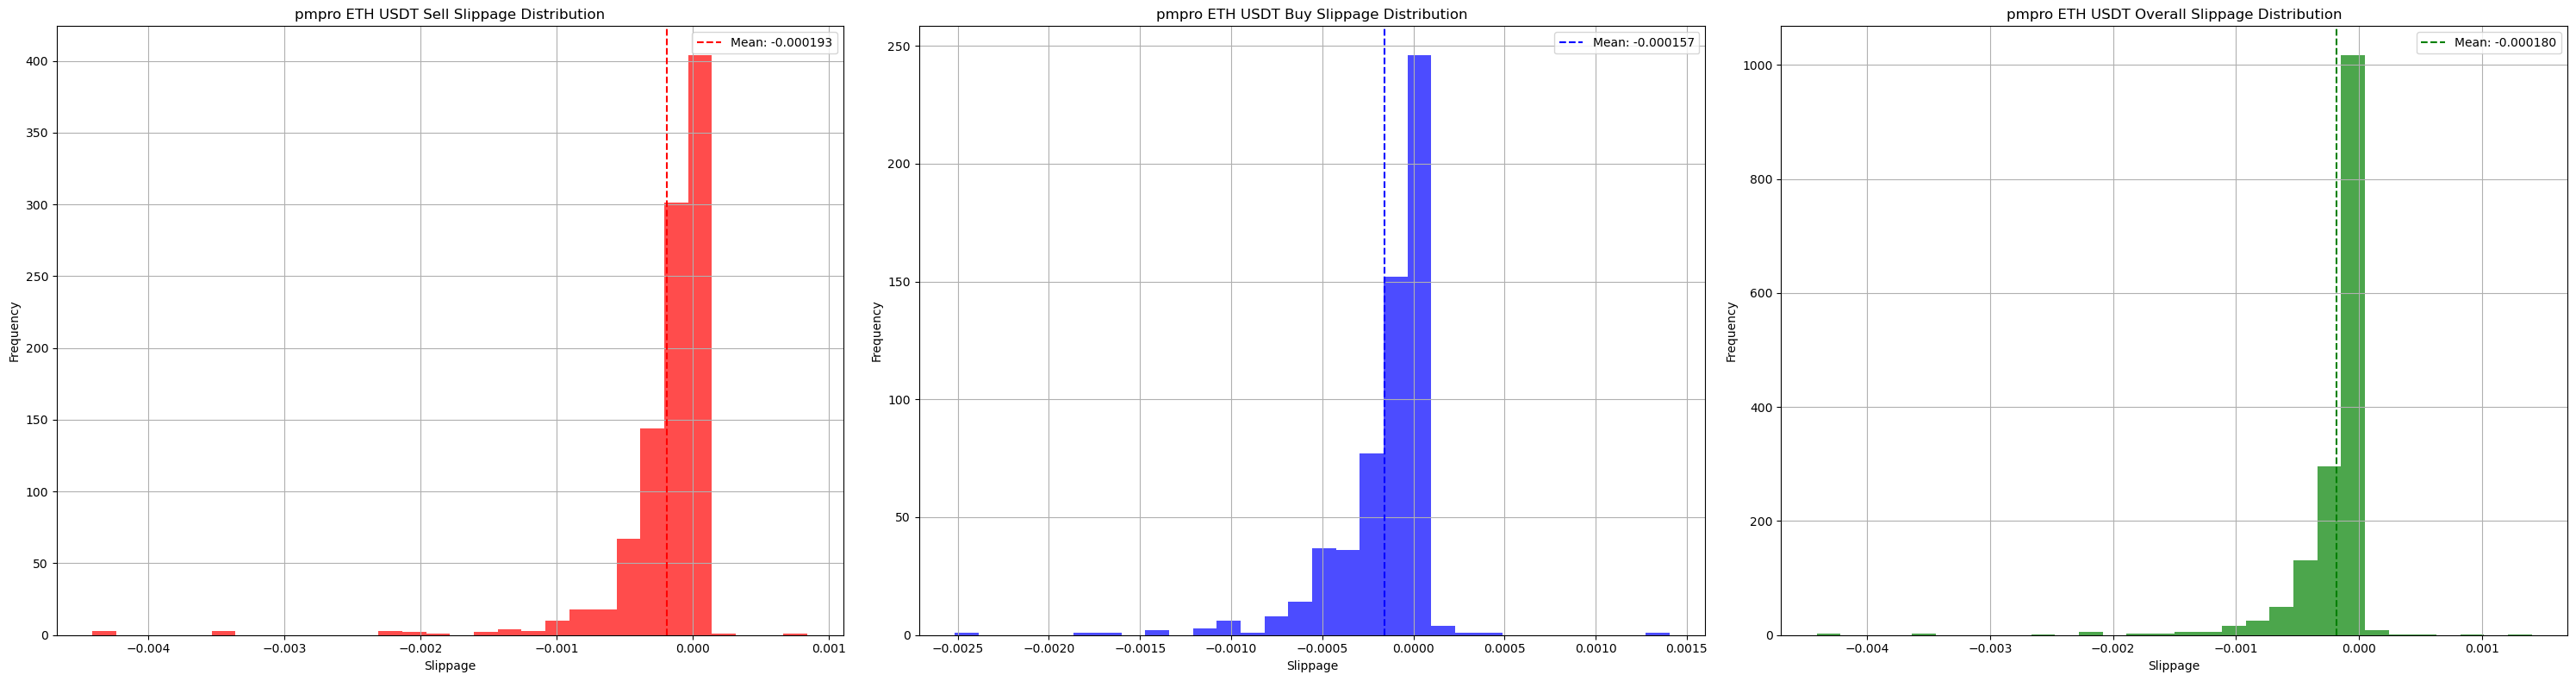

2026-02-09 08:00:00 2026-02-13 16:00:00


symbol  count      mean    median      std       min      max  \
env                                                                   
pmpro    ETH   1577 -0.000180 -0.000071 0.000362 -0.004409 0.001405   

       percentile_5  percentile_10  percentile_25  percentile_50  \
env                                                                
pmpro     -0.000632      -0.000456      -0.000238      -0.000071   

       percentile_60  percentile_75  percentile_95  BNFirstSlippage  \
env                                                                   
pmpro      -0.000030      -0.000000       0.000000        -0.000173   

       BNFirstSlippage_count  OKFirstSlippage  OKFirstSlippage_count  
env                                                                   
pmpro                    699        -0.000185                    877

In [27]:
import pandas as pd


symbol = 'ETH'
env_list = ["cfdc_dcpro1","cfdc_dcpro2","cfdc_dcpro3","cfdc_dcpro4","cfdc_dcpro5","cfdc_dcpro7", "cfdc_dcpro8","cfdc_dcpro9","cfdc_dcpro12","cfdc_dcpro13","cfdc_dcpro15","cfdc_dcpro16","cfdc_dcpro17","cfdc_dcpro24","cfdc_dcpro26","cfdc_dcpro27","cfdc_dcpro29"]
env_list = ['pmpro']

replace_dict = {
'pro1': 'preTakerMaker',
'pro2': 'msecs10000 replace10 abnormal 0.0001',
'pro10': 'msecs10000 replace10 abnormal 0.0005',
'pro11': 'msecs10000 replace10 abnormal 0.0002', 
'pro12': 'msecs10000 replace1 abnormal 0.0005',
'pro3':'MakerTaker',
'pro4':'MakerTaker'
}

start_date = '2026-02-09 08:00:00'
end_date = '2026-02-13 16:00:00'

summary = []

for env in env_list:
    try:
        file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.close.csv'
        file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{env}/{symbol}_USDT.open.csv'
        if env == 'pmpro':
            file_path_1 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.close.csv'
            file_path_2 = f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_maker_dc_pmpro_test/{symbol}_USDT.open.csv'
        slippage_df_selected, short_slippage, long_slippage, df_open, df_close, Exchange1FirstSlippage, Exchange2FirstSlippage = get_slippage_df(file_path_1, file_path_2, start_date, end_date, parse_start_time, ifAnalyzeExchangeFirst = True)


        # 创建子图  
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

        # 分析卖出滑点
        sell_slippage = short_slippage['slippage']
        sell_slippage.hist(ax=ax1, bins=30, alpha=0.7, color='red')
        ax1.set_title(f'{env} {symbol} USDT Sell Slippage Distribution')
        ax1.set_xlabel('Slippage')
        ax1.set_ylabel('Frequency')
        sell_mean = sell_slippage.mean()
        sell_std = sell_slippage.std()
        ax1.axvline(sell_mean, color='red', linestyle='--', label=f'Mean: {sell_mean:.6f}')
        ax1.legend()
        # print('sell count', len(sell_slippage))


        # 分析买入滑点
        buy_slippage = long_slippage['slippage']
        buy_slippage.hist(ax=ax2, bins=30, alpha=0.7, color='blue')
        ax2.set_title(f'{env} {symbol} USDT Buy Slippage Distribution')
        ax2.set_xlabel('Slippage')
        ax2.set_ylabel('Frequency')
        buy_mean = buy_slippage.mean()
        buy_std = buy_slippage.std()
        ax2.axvline(buy_mean, color='blue', linestyle='--', label=f'Mean: {buy_mean:.6f}')
        ax2.legend()
        # print('buy count', len(buy_slippage))

        # overall滑点分布
        slippage_array = slippage_df_selected['slippage'].values
        slippage_df_selected['slippage'].hist(ax=ax3, bins=30, alpha=0.7, color='green')
        ax3.set_title(f'{env} {symbol} USDT Overall Slippage Distribution')
        ax3.set_xlabel('Slippage')
        ax3.set_ylabel('Frequency')
        overall_mean = slippage_array.mean()
        ax3.axvline(overall_mean, color='green', linestyle='--', label=f'Mean: {overall_mean:.6f}')
        ax3.legend()

        plt.tight_layout()
        plt.show()
        stats = {
            'symbol': symbol,
            'env': env,
            # 'replace': replace_dict[env],
            'count': len(slippage_array),
            'mean': np.mean(slippage_array),
            'median': np.median(slippage_array),
            'std': np.std(slippage_array),
            'min': np.min(slippage_array),
            'max': np.max(slippage_array),
            # 'percentile_1': np.percentile(slippage_array, 1),
            'percentile_5': np.percentile(slippage_array, 5),
            'percentile_10': np.percentile(slippage_array, 10),
            'percentile_25': np.percentile(slippage_array, 25),
            'percentile_50': np.percentile(slippage_array, 50),
            # 'percentile_55': np.percentile(slippage_array, 55),        
            'percentile_60': np.percentile(slippage_array, 60),
            # 'percentile_65': np.percentile(slippage_array, 65),
            'percentile_75': np.percentile(slippage_array, 75),
            'percentile_95': np.percentile(slippage_array, 95),
            # 'percentile_99': np.percentile(slippage_array, 99),
            'BNFirstSlippage': Exchange1FirstSlippage['slippage'].mean(),
            'BNFirstSlippage_count': len(Exchange1FirstSlippage),
            'OKFirstSlippage': Exchange2FirstSlippage['slippage'].mean(),
            'OKFirstSlippage_count': len(Exchange2FirstSlippage),
        }

        summary.append(stats)
    except Exception as e:
        print(f'Error processing env {env}: {e}')

df = pd.DataFrame(summary).set_index('env').sort_values(by='mean', ascending=False)
print(start_date,end_date)
df

In [32]:
df_open[(df_open['done_time_diff']<=5)&(df_open['done_time_diff']>=-5)].sort_values(by='slippage')

pos_id  \
70510  260212_213043_122091   
70512  260212_213043_122090   
70511  260212_213043_122089   
70556  260212_213159_122179   
70555  260212_213159_122177   
...                     ...   
69936  260211_140119_120927   
69935  260211_140119_120928   
69900  260211_135752_120851   
69853  260211_100044_120793   
69952  260211_141412_120981   

                                                   start  sr_open  \
70510  2026-02-12 21:30:43.686646167 +0800 CST m=+223... 0.000121   
70512  2026-02-12 21:30:43.67675609 +0800 CST m=+2233... 0.000121   
70511  2026-02-12 21:30:43.676681579 +0800 CST m=+223... 0.000121   
70556  2026-02-12 21:31:59.896514555 +0800 CST m=+224... 0.000131   
70555  2026-02-12 21:31:59.896346176 +0800 CST m=+224... 0.000131   
...                                                  ...      ...   
69936  2026-02-11 14:01:19.467388561 +0800 CST m=+458... 0.000172   
69935  2026-02-11 14:01:19.467482465 +0800 CST m=+458... 0.000172   
69900  2026-02-11 13:57:52.497228717 +0800 CST m=+251... 0.000167   
69853  2026-02-11 10:00:44.433597514 +0800 CST m=+370... 0.000183   
69952  2026-02-11 14:14:12.900407086 +0800 CST m=+123... 0.000169   

       open_trade_unit  open_usdt  sr_open_real             swap1_order_id  \
70510         0.013000  25.787320     -0.000776 8389766099756323840.000000   
70512         0.013000  25.787320     -0.000776 8389766099756323840.000000   
70511         0.013000  25.787320     -0.000776 8389766099756323840.000000   
70556         0.013000  25.799150     -0.000710 8389766099757243392.000000   
70555         0.013000  25.799150     -0.000710 8389766099757243392.000000   
...                ...        ...           ...                        ...   
69936         0.013000  25.669020      0.000203 8389766098448516096.000000   
69935         0.013000  25.669020      0.000203 8389766098448516096.000000   
69900         0.013000  25.674870      0.000203 8389766098446693376.000000   
69853         0.012000  24.289800      0.000237 8389766098291068928.000000   
69952         0.013000  25.378340      0.000395 8389766098458241024.000000   

       swap1_avg_price  swap1_deal_amount swap1_side  ...   deposit  \
70510      1985.420000           0.013000        buy  ... 25.800450   
70512      1985.420000           0.013000        buy  ... 25.800450   
70511      1985.420000           0.013000        buy  ... 25.800450   
70556      1986.190000           0.013000        buy  ... 25.811305   
70555      1986.190000           0.013000        buy  ... 25.811305   
...                ...                ...        ...  ...       ...   
69936      1974.540000           0.013000        buy  ... 25.671620   
69935      1974.540000           0.013000        buy  ... 25.671620   
69900      1974.990000           0.013000        buy  ... 25.677470   
69853      2024.150000           0.012000        buy  ... 24.292680   
69952      1951.740000           0.013000        buy  ... 25.377625   

      deposit_real open_exposure          mode  \
70510    25.800450      0.020020  Swap1MSwap2M   
70512    25.800450      0.020020  Swap1MSwap2M   
70511    25.800450      0.020020  Swap1MSwap2M   
70556    25.811305      0.018330  Swap1MSwap2M   
70555    25.811305      0.018330  Swap1MSwap2M   
...            ...           ...           ...   
69936    25.671620     -0.005200  Swap1MSwap2M   
69935    25.671620     -0.005200  Swap1MSwap2M   
69900    25.677470     -0.005200  Swap1MSwap2M   
69853    24.292680     -0.005760  Swap1MSwap2M   
69952    25.377625     -0.010010  Swap1MSwap2M   

                                              maker_info  \
70510  {"first_filled":"swap2","first_sr":"0","first_...   
70512  {"first_filled":"swap2","first_sr":"0.00008569...   
70511  {"first_filled":"swap2","first_sr":"0.00008569...   
70556  {"first_filled":"swap2","first_sr":"0.00009069...   
70555  {"first_filled":"swap2","first_sr":"0.00009069...   
...                                                  ...   
69936  {